# SVM Model Training

## Import Common Libraries

In [1]:
import numpy as np
from tqdm import tqdm

## Define paths

In [2]:
svm_features_dir = "../data/features/audio_16k/mfcc+deltas_spectral_prosodic_computed_statistics/audio_features"
metadata_dir = "../data/features/audio_16k/mfcc+deltas_spectral_prosodic_computed_statistics/metadata.csv"
final_model_dir = "../models/svm/final"

## Ensure dir exist

In [3]:
import os

os.makedirs(final_model_dir, exist_ok=True)

## Load Metadata

In [4]:
import pandas as pd

df = pd.read_csv(metadata_dir)
print(f"Total samples: {len(df)}")

Total samples: 11318


## Encode labels for SVM

In [5]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Prepare labels
le = LabelEncoder()
y_encoded = le.fit_transform(df['emotion'])

num_classes = len(le.classes_)
inverse_map = {idx: cls for idx, cls in enumerate(le.classes_)}

print("Number of classes:", num_classes)
print(inverse_map)

Number of classes: 6
{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad'}


## Train/test split

In [6]:
from sklearn.model_selection import train_test_split

file_paths = df['file_path'].values

train_paths, test_paths, y_train, y_test = train_test_split(
    file_paths, y_encoded, 
    test_size=0.2, 
    stratify=y_encoded, 
    random_state=42
)

print(f"Training samples: {len(train_paths)}")
print(f"Test samples: {len(test_paths)}")

Training samples: 9054
Test samples: 2264


## Create Generators

In [7]:
import sys
sys.path.append("../src")
import classes
from classes import SVMDataGenerator

batch_size = 32
train_gen = SVMDataGenerator(train_paths, y_train, batch_size=batch_size, shuffle=True)
test_gen = SVMDataGenerator(test_paths, y_test, batch_size=batch_size, shuffle=False)

print(f"Training batches per epoch: {len(train_gen)}")
print(f"Test batches: {len(test_gen)}")

2025-12-04 00:29:45.414718: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-04 00:29:45.450375: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-04 00:29:46.408064: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Training batches per epoch: 283
Test batches: 71


## Initialize Scaler and SGDClassifier (Incremental SVM)

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier

scaler = StandardScaler()
svm_model = SGDClassifier(
    loss='hinge',  # This gives us SVM behavior
    penalty='l2',
    alpha=0.0001,
    max_iter=1000,
    tol=1e-3,
    random_state=42,
    verbose=1,
    n_jobs=-1, 
    learning_rate='optimal'
)

## Train SVM Model with Mini-Batches

In [9]:
epochs = 10
print(f"\nTraining SVM model for {epochs} epochs...")

for epoch in range(epochs):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch + 1}/{epochs}")
    print('='*60)
    
    train_gen.reset()
    
    for batch_idx in tqdm(range(len(train_gen)), desc=f"Epoch {epoch+1}"):
        X_batch, y_batch = train_gen.next_batch()
        
        # Fit or transform the scaler
        if epoch == 0 and batch_idx == 0:
            # First batch: fit the scaler
            X_batch_scaled = scaler.fit_transform(X_batch)
            # First fit for SGDClassifier (need to specify classes)
            svm_model.partial_fit(X_batch_scaled, y_batch, classes=np.arange(num_classes))
        else:
            # Transform using fitted scaler
            X_batch_scaled = scaler.transform(X_batch)
            # Continue training
            svm_model.partial_fit(X_batch_scaled, y_batch)

print("\n✓ Training complete!")


Training SVM model for 10 epochs...

Epoch 1/10


Epoch 1:   0%|                                                                                  | 0/283 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1-- Epoch 1
-- Epoch 1
-- Epoch 1

-- Epoch 1
Norm: 755.13, NNZs: 930, Bias: -137.143302, T: 32, Avg. loss: 1221.429166
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 853.86, NNZs: 930, Bias: -127.655973, T: 32, Avg. loss: 1609.586359
Total training time: 0.00 seconds.
Norm: 563.08, NNZs: 930, Bias: -255.958213, T: 32, Avg. loss: 3029.794472
Total training time: 0.00 seconds.
Norm: 929.37, NNZs: 930, Bias: -157.698171, T: 32, Avg. loss: 1319.993406
Total training time: 0.00 seconds.
Norm: 677.62, NNZs: 930, Bias: -226.445082, T: 32, Avg. loss: 2303.773609
Total training time: 0.00 seconds.
Norm: 760.93, NNZs: 930, Bias: -245.976052, T: 32, Avg. loss: 3078.095463
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 1356.77, NNZs: 930, Bias: -165.945817, T: 32, Avg. loss: 754.282326
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 1578.07, NNZs: 930, Bias: -184.768101, T: 32, Avg. loss: 1416.555846
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 1172.68, NN

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 co

-- Epoch 1
-- Epoch 1
Norm: 2076.19, NNZs: 930, Bias: -534.421502, T: 32, Avg. loss: 852.787351
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 2078.63, NNZs: 930, Bias: -442.154360, T: 32, Avg. loss: 628.331738
Total training time: 0.00 seconds.
Norm: 1959.46, NNZs: 930, Bias: -535.157027, T: 32, Avg. loss: 273.152890
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 1805.74, NNZs: 930, Bias: -554.968842, T: 32, Avg. loss: 1132.152052
Total training time: 0.00 seconds.
-- Epoch 1


[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s re

Norm: 1775.19, NNZs: 930, Bias: -390.168875, T: 32, Avg. loss: 389.062783
Total training time: 0.00 seconds.
Norm: 1892.34, NNZs: 930, Bias: -580.175359, T: 32, Avg. loss: 55.139993
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 1830.54, NNZs: 930, Bias: -404.140106, T: 32, Avg. loss: 497.484983
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 2127.49, NNZs: 930, Bias: -491.194492, T: 32, Avg. loss: 408.930990
Total training time: 0.00 seconds.
Norm: 1975.67, NNZs: 930, Bias: -528.246892, T: 32, Avg. loss: 960.105954
Total training time: 0.00 seconds.
Norm: 1839.30, NNZs: 930, Bias: -580.150677, T: 32, Avg. loss: 838.221383
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 2032.55, NNZs: 930, Bias: -534.578303, T: 32, Avg. loss: 765.851079
Total training time: 0.00 seconds.
Norm: 1801.95, NNZs: 930, Bias: -596.924703, T: 32, Avg. loss: 485.573513
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 2070.03, NNZs: 930, Bias: -484.4386

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 co

-- Epoch 1
-- Epoch 1
Norm: 1868.25, NNZs: 930, Bias: -477.380511, T: 32, Avg. loss: 580.251964
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 2100.99, NNZs: 930, Bias: -625.159522, T: 32, Avg. loss: 703.380983
Total training time: 0.00 seconds.
Norm: 1821.21, NNZs: 930, Bias: -630.757893, T: 32, Avg. loss: 229.723354
Total training time: 0.00 seconds.
Norm: 1875.71, NNZs: 930, Bias: -414.686725, T: 32, Avg. loss: 406.983712
Total training time: 0.00 seconds.
Norm: 1958.11, NNZs: 930, Bias: -618.007174, T: 32, Avg. loss: 201.569051
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 1716.07, NNZs: 930, Bias: -621.860322, T: 32, Avg. loss: 217.465382
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 1880.67, NNZs: 930, Bias: -471.646376, T: 32, Avg. loss: 746.492911
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 1852.81, NNZs: 930, Bias: -420.388092, T: 32, Avg. loss: 314.819769
Total training time: 0.00 seconds.
Norm: 2063.00, NNZs: 930, Bia

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s


-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 1904.31, NNZs: 930, Bias: -453.707414, T: 32, Avg. loss: 841.038862
Total training time: 0.00 seconds.
Norm: 1870.49, NNZs: 930, Bias: -510.656276, T: 32, Avg. loss: 227.360097
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 1992.66, NNZs: 930, Bias: -612.727181, T: 32, Avg. loss: 672.183050
Total training time: 0.00 seconds.
Norm: 2044.22, NNZs: 930, Bias: -664.519214, T: 32, Avg. loss: 845.963974
Total training time: 0.00 seconds.
Norm: 1830.87, NNZs: 930, Bias: -659.084349, T: 32, Avg. loss: 701.121079
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 1814.98, NNZs: 930, Bias: -643.717840, T: 32, Avg. loss: 414.028728
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 1:   9%|██████▋                                                                  | 26/283 [00:00<00:04, 62.32it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Do

-- Epoch 1
Norm: 1920.24, NNZs: 930, Bias: -505.321411, T: 32, Avg. loss: 1048.288017
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 1881.44, NNZs: 930, Bias: -464.509422, T: 32, Avg. loss: 411.212996
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 1783.36, NNZs: 930, Bias: -659.934757, T: 32, Avg. loss: 678.334419
Total training time: 0.00 seconds.
Norm: 1949.20, NNZs: 930, Bias: -629.022877, T: 32, Avg. loss: 209.562888
Total training time: 0.00 seconds.
Norm: 1806.05, NNZs: 930, Bias: -669.772494, T: 32, Avg. loss: 646.020043
Total training time: 0.00 seconds.
Norm: 2078.96, NNZs: 930, Bias: -664.390657, T: 32, Avg. loss: 502.140927
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 1902.31, NNZs: 930, Bias: -494.649190, T: 32, Avg. loss: 368.624112
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 2076.80, NNZs: 930, Bias: -659.110666, T: 32, Avg. loss: 1114.503972
Total training time: 0.00 seconds.
Norm: 1846.93, NNZs: 930, B

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 co

-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 1985.45, NNZs: 930, Bias: -673.452071, T: 32, Avg. loss: 929.446050
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 1656.47, NNZs: 930, Bias: -661.070838, T: 32, Avg. loss: 351.351246
Total training time: 0.00 seconds.
Norm: 1812.80, NNZs: 930, Bias: -563.898527, T: 32, Avg. loss: 536.092408
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 1677.96, NNZs: 930, Bias: -509.505070, T: 32, Avg. loss: 353.359595
Total training time: 0.00 seconds.
Norm: 1852.89, NNZs: 930, Bias: -642.223729, T: 32, Avg. loss: 385.194521
Total training time: 0.00 seconds.
Norm: 1690.01, NNZs: 930, Bias: -708.804297, T: 32, Avg. loss: 448.546167
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 1786.75, NNZs: 930, Bias: -563.862534, T: 32, Avg. loss: 529.185137
Total training time: 0.00 seconds.
Norm: 1981.41, NNZs: 930, Bias: -687.279224, T: 32, Avg. loss: 569.574995
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 1

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 3941.33, NNZs: 930, Bias: -604.744737, T: 32, Avg. loss: 952.789095
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 3989.76, NNZs: 930, Bias: -696.466381, T: 32, Avg. loss: 667.358019
Total training time: 0.00 seconds.
Norm: 1669.14, NNZs: 930, Bias: -509.368027, T: 32, Avg. loss: 314.906334
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 3946.35, NNZs: 930, Bias: -687.150454, T: 32, Avg. loss: 865.202552
Total training time: 0.00 seconds.
Norm: 1667.05, NNZs: 930, Bias: -722.502751, T: 32, Avg. loss: 288.491773
Total training time: 0.00 seconds.
Norm: 3855.03, NNZs: 930, Bias: -702.185033, T: 32, Avg. loss: 724.414691
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 1:  14%|██████████▎                                                              | 40/283 [00:00<00:03, 61.97it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
Norm: 3875.15, NNZs: 930, Bias: -613.588787, T: 32, Avg. loss: 540.226981
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 1645.00, NNZs: 930, Bias: -513.712905, T: 32, Avg. loss: 141.168398
Total training time: 0.00 seconds.
Norm: 3799.56, NNZs: 930, Bias: -724.305017, T: 32, Avg. loss: 338.061525
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 1655.58, NNZs: 930, Bias: -722.424690, T: 32, Avg. loss: 59.728528
Total training time: 0.00 seconds.
Norm: 3877.15, NNZs: 930, Bias: -709.223586, T: 32, Avg. loss: 1105.856120
Total training time: 0.00 seconds.
Norm: 3935.02, NNZs: 930, Bias: -709.699843, T: 32, Avg. loss: 1033.263154
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 3819.03, NNZs: 930, Bias: -626.683726, T: 32, Avg. loss: 300.519392
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 3825.08, NNZs: 930, Bias: -730.997138, T: 32, Avg. loss: 509.462004
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 3449.68, NNZs: 930, Bias: -683.695257, T: 32, Avg. loss: 445.949724
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 3482.65, NNZs: 930, Bias: -792.095188, T: 32, Avg. loss: 396.472686
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 1530.82, NNZs: 930, Bias: -501.288020, T: 32, Avg. loss: 624.612427
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 1557.75, NNZs: 930, Bias: -717.568303, T: 32, Avg. loss: 448.745112
Total training time: 0.00 seconds.
Norm: 3504.69, NNZs: 930, Bias: -793.034483, T: 32, Avg. loss: 445.634956
Total training time: 0.00 seconds.
Norm: 3377.70, NNZs: 930, Bias: -792.524716, T: 32, Avg. loss: 365.314056
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 3412.87, NNZs: 930, Bias: -695.348850, T: 32, Avg. loss: 450.435249
Total training time: 0.00 seconds.
Norm: 3430.67, NNZs: 930, Bias: -811.428897, T: 32, Avg. loss: 446.352639
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoc

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 3327.77, NNZs: 930, Bias: -691.560689, T: 32, Avg. loss: 463.560555
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 3343.74, NNZs: 930, Bias: -834.377103, T: 32, Avg. loss: 596.980677
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 3377.99, NNZs: 930, Bias: -812.030551, T: 32, Avg. loss: 655.321858
Total training time: 0.00 seconds.
Norm: 1471.18, NNZs: 930, Bias: -501.109019, T: 32, Avg. loss: 363.511506
Total training time: 0.00 seconds.
Norm: 3243.23, NNZs: 930, Bias: -811.517647, T: 32, Avg. loss: 289.066547
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 1539.55, NNZs: 930, Bias: -698.306937, T: 32, Avg. loss: 262.455224
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 1:  19%|█████████████▉                                                           | 54/283 [00:00<00:03, 61.77it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1-- Epoch 1
Norm: 1487.16, NNZs: 930, Bias: -493.644915, T: 32, Avg. loss: 363.676303
Total training time: 0.00 seconds.

-- Epoch 1
-- Epoch 1
Norm: 3294.39, NNZs: 930, Bias: -687.783344, T: 32, Avg. loss: 387.357437
Total training time: 0.00 seconds.
Norm: 3330.69, NNZs: 930, Bias: -815.788518, T: 32, Avg. loss: 445.643792
Total training time: 0.00 seconds.
Norm: 3216.89, NNZs: 930, Bias: -822.727057, T: 32, Avg. loss: 239.358578
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 3310.64, NNZs: 930, Bias: -841.843855, T: 32, Avg. loss: 246.995084
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 1508.71, NNZs: 930, Bias: -705.808546, T: 32, Avg. loss: 309.004175
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 3257.13, NNZs: 930, Bias: -684.083751, T: 32, Avg. loss: 141.217432
Total training time: 0.00 seconds.
Norm: 3264.16, NNZs: 930, Bias: -841.853490, T: 32, Avg. loss: 543.776115
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 1

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 1:  22%|███████████████▋                                                         | 61/283 [00:00<00:03, 61.24it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Usi

Norm: 2935.00, NNZs: 930, Bias: -837.016102, T: 32, Avg. loss: 230.431627
Total training time: 0.00 seconds.
Norm: 1467.92, NNZs: 930, Bias: -561.358489, T: 32, Avg. loss: 297.205509
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 1402.29, NNZs: 930, Bias: -709.380408, T: 32, Avg. loss: 553.073820
Total training time: 0.00 seconds.
Norm: 3003.30, NNZs: 930, Bias: -811.041705, T: 32, Avg. loss: 220.528232
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 2990.79, NNZs: 930, Bias: -842.388521, T: 32, Avg. loss: 194.994552
Total training time: 0.00 seconds.
Norm: 1461.12, NNZs: 930, Bias: -561.339210, T: 32, Avg. loss: 50.049685
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 2900.23, NNZs: 930, Bias: -840.356985, T: 32, Avg. loss: 200.533699
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 1409.06, NNZs: 930, Bias: -709.336078, T: 32, Avg. loss: 277.973651
Total training time: 0.00 seconds.
Norm: 2992.49, NNZs: 930, Bias: -712.420113, T: 32, Avg. loss: 

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


-- Epoch 1
-- Epoch 1
Norm: 1458.85, NNZs: 930, Bias: -554.668566, T: 32, Avg. loss: 239.264236
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 2896.08, NNZs: 930, Bias: -679.451046, T: 32, Avg. loss: 312.816296
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 2812.44, NNZs: 930, Bias: -837.112961, T: 32, Avg. loss: 55.281957
Total training time: 0.00 seconds.
Norm: 2870.35, NNZs: 930, Bias: -804.348988, T: 32, Avg. loss: 241.950692
Total training time: 0.00 seconds.
Norm: 1385.01, NNZs: 930, Bias: -709.257449, T: 32, Avg. loss: 187.785549
Total training time: 0.00 seconds.
Norm: 2890.95, NNZs: 930, Bias: -852.496387, T: 32, Avg. loss: 641.361557
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 1:  24%|█████████████████▌                                                       | 68/283 [00:01<00:03, 61.85it/s][Parallel(n_jobs=-1)]: Usi

-- Epoch 1
Norm: 2864.67, NNZs: 930, Bias: -685.906869, T: 32, Avg. loss: 417.676044
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 2835.40, NNZs: 930, Bias: -794.666358, T: 32, Avg. loss: 584.277811
Total training time: 0.00 seconds.
Norm: 1451.18, NNZs: 930, Bias: -551.428054, T: 32, Avg. loss: 350.852979
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 2853.42, NNZs: 930, Bias: -865.447746, T: 32, Avg. loss: 463.099185
Total training time: 0.00 seconds.
Norm: 1381.95, NNZs: 930, Bias: -725.401188, T: 32, Avg. loss: 270.525892
Total training time: 0.00 seconds.
Norm: 2777.41, NNZs: 930, Bias: -843.563621, T: 32, Avg. loss: 330.345788
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 2836.51, NNZs: 930, Bias: -701.925328, T: 32, Avg. loss: 266.117969
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 2819.61, NNZs: 930, Bias: -862.302784, T: 32, Avg. loss: 431.781441
Total training time: 0.00 seconds.
Norm: 1429.08, NNZ

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 1:  27%|███████████████████▎                                                     | 75/283 [00:01<00:03, 61.45it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
Norm: 2651.76, NNZs: 930, Bias: -714.091119, T: 32, Avg. loss: 137.786913
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 2636.79, NNZs: 930, Bias: -795.517378, T: 32, Avg. loss: 785.540180
Total training time: 0.00 seconds.
Norm: 2570.84, NNZs: 930, Bias: -859.044375, T: 32, Avg. loss: 63.293998
Total training time: 0.00 seconds.
Norm: 1354.70, NNZs: 930, Bias: -557.341755, T: 32, Avg. loss: 183.889467
Total training time: 0.00 seconds.
Norm: 2635.12, NNZs: 930, Bias: -877.452202, T: 32, Avg. loss: 663.306300
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 1311.23, NNZs: 930, Bias: -715.547785, T: 32, Avg. loss: 144.655266
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 2620.67, NNZs: 930, Bias: -714.096399, T: 32, Avg. loss: 651.148993
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 1339.74, NNZs: 930, Bias: -557.336516, T: 32, Avg. loss: 82.653217
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 261

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 2540.47, NNZs: 930, Bias: -705.525347, T: 32, Avg. loss: 115.151390
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 2531.62, NNZs: 930, Bias: -880.371853, T: 32, Avg. loss: 765.912422
Total training time: 0.00 seconds.
Norm: 2548.48, NNZs: 930, Bias: -827.612452, T: 32, Avg. loss: 405.388047
Total training time: 0.00 seconds.
Norm: 1312.86, NNZs: 930, Bias: -557.474613, T: 32, Avg. loss: 88.967876
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 2505.04, NNZs: 930, Bias: -876.398482, T: 32, Avg. loss: 155.773321
Total training time: 0.00 seconds.
Norm: 1295.32, NNZs: 930, Bias: -709.844827, T: 32, Avg. loss: 460.652438
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 co

-- Epoch 1
Norm: 2521.77, NNZs: 930, Bias: -708.370291, T: 32, Avg. loss: 324.952525
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 1296.50, NNZs: 930, Bias: -563.188084, T: 32, Avg. loss: 155.399150
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 2525.21, NNZs: 930, Bias: -866.124366, T: 32, Avg. loss: 330.509332
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 2524.26, NNZs: 930, Bias: -827.606782, T: 32, Avg. loss: 461.685918
Total training time: 0.00 seconds.
Norm: 2483.73, NNZs: 930, Bias: -876.378194, T: 32, Avg. loss: 167.701358
Total training time: 0.00 seconds.
Norm: 1284.43, NNZs: 930, Bias: -707.009670, T: 32, Avg. loss: 228.672400
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 2499.25, NNZs: 930, Bias: -708.366351, T: 32, Avg. loss: 348.892891
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 2516.84, NNZs: 930, Bias: -866.125165, T: 32, Avg. loss: 500.882799
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 2501.09, NNZ

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 1:  31%|██████████████████████▉                           

-- Epoch 1
Norm: 2358.62, NNZs: 930, Bias: -733.071149, T: 32, Avg. loss: 1076.364781
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 2356.27, NNZs: 930, Bias: -846.347525, T: 32, Avg. loss: 268.854874
Total training time: 0.00 seconds.
Norm: 1282.00, NNZs: 930, Bias: -577.083614, T: 32, Avg. loss: 138.860623
Total training time: 0.00 seconds.
Norm: 2375.06, NNZs: 930, Bias: -866.215669, T: 32, Avg. loss: 688.048511
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 2338.11, NNZs: 930, Bias: -917.106056, T: 32, Avg. loss: 214.695230
Total training time: 0.00 seconds.
Norm: 1279.98, NNZs: 930, Bias: -706.848440, T: 32, Avg. loss: 154.906700
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 2338.13, NNZs: 930, Bias: -738.348930, T: 32, Avg. loss: 264.069987
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 2337.04, NNZs: 930, Bias: -846.360688, T: 32, Avg. loss: 189.806246
Total training time: 0.00 seconds.
-- Epo

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 co

-- Epoch 1
Norm: 2276.22, NNZs: 930, Bias: -756.384717, T: 32, Avg. loss: 230.969835
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 2261.02, NNZs: 930, Bias: -868.984313, T: 32, Avg. loss: 248.032530
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 1230.53, NNZs: 930, Bias: -571.943786, T: 32, Avg. loss: 188.375291
Total training time: 0.00 seconds.
Norm: 2260.07, NNZs: 930, Bias: -849.030200, T: 32, Avg. loss: 427.135895
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 2227.88, NNZs: 930, Bias: -904.066310, T: 32, Avg. loss: 411.079415
Total training time: 0.00 seconds.
Norm: 1220.58, NNZs: 930, Bias: -743.328854, T: 32, Avg. loss: 541.756077
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 2265.99, NNZs: 930, Bias: -756.376450, T: 32, Avg. loss: 156.705839
Total training time: 0.00 seconds.
Norm: 1223.75, NNZs: 930, Bias: -566.900237, T: 32, Avg. loss: 166.145714
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 2

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s re

-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 2116.49, NNZs: 930, Bias: -859.294228, T: 32, Avg. loss: 128.016642
Total training time: 0.00 seconds.
Norm: 2129.86, NNZs: 930, Bias: -846.679216, T: 32, Avg. loss: 772.037112
Total training time: 0.00 seconds.
Norm: 1168.60, NNZs: 930, Bias: -566.855042, T: 32, Avg. loss: 171.057342
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 1155.05, NNZs: 930, Bias: -760.084144, T: 32, Avg. loss: 231.272841
Total training time: 0.00 seconds.
Norm: 2144.25, NNZs: 930, Bias: -761.571598, T: 32, Avg. loss: 328.059249
Total training time: 0.00 seconds.
Norm: 2084.59, NNZs: 930, Bias: -901.474189, T: 32, Avg. loss: 219.519758
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 2124.61, NNZs: 930, Bias: -766.319936, T: 32, Avg. loss: 110.768380
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 1162.86, NNZs: 930, Bias: -559.728015, T: 32, Avg. loss: 296.239866
Total training time: 0.00 seconds.
Norm: 2102.00, NNZs: 930, Bia

Epoch 1:  36%|██████████████████████████▏                                             | 103/283 [00:01<00:02, 61.48it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 2058.65, NNZs: 930, Bias: -860.917674, T: 32, Avg. loss: 514.967099
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 2087.47, NNZs: 930, Bias: -768.609173, T: 32, Avg. loss: 92.561367
Total training time: 0.00 seconds.
Norm: 2046.91, NNZs: 930, Bias: -859.191819, T: 32, Avg. loss: 302.190243
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 1139.27, NNZs: 930, Bias: -562.034628, T: 32, Avg. loss: 194.445791
Total training time: 0.00 seconds.
Norm: 1134.94, NNZs: 930, Bias: -771.893613, T: 32, Avg. loss: 206.948957
Total training time: 0.00 seconds.
Norm: 2017.50, NNZs: 930, Bias: -908.724479, T: 32, Avg. loss: 186.661878
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 co

-- Epoch 1
Norm: 2075.96, NNZs: 930, Bias: -766.314580, T: 32, Avg. loss: 65.921132
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 2031.37, NNZs: 930, Bias: -859.171688, T: 32, Avg. loss: 336.270773
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 1133.39, NNZs: 930, Bias: -557.420517, T: 32, Avg. loss: 181.773285
Total training time: 0.00 seconds.
Norm: 2039.92, NNZs: 930, Bias: -858.595497, T: 32, Avg. loss: 290.455321
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 2002.32, NNZs: 930, Bias: -906.423513, T: 32, Avg. loss: 83.601199
Total training time: 0.00 seconds.
Norm: 1127.77, NNZs: 930, Bias: -771.883502, T: 32, Avg. loss: 186.574194
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 2060.45, NNZs: 930, Bias: -770.872960, T: 32, Avg. loss: 730.324048
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 2025.55, NNZs: 930, Bias: -858.598115, T: 32, Avg. loss: 231.364718
Total training time: 0.00 seconds

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 co

-- Epoch 1
Norm: 1958.61, NNZs: 930, Bias: -768.660320, T: 32, Avg. loss: 144.408158
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 1097.31, NNZs: 930, Bias: -582.143622, T: 32, Avg. loss: 117.720025
Total training time: 0.00 seconds.
Norm: 1913.39, NNZs: 930, Bias: -866.086117, T: 32, Avg. loss: 30.075570
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 1090.68, NNZs: 930, Bias: -760.804285, T: 32, Avg. loss: 231.700539
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 1918.22, NNZs: 930, Bias: -858.262942, T: 32, Avg. loss: 209.225302
Total training time: 0.00 seconds.
Norm: 1884.08, NNZs: 930, Bias: -911.063141, T: 32, Avg. loss: 168.637969
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 1944.62, NNZs: 930, Bias: -768.661258, T: 32, Avg. loss: 85.639682
Total training time: 0.00 seconds.
Norm: 1900.43, NNZs: 930, Bias: -866.088463, T: 32, Avg. loss: 425.829034
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 1868.35, NNZs:

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
-- Epoch 1
Norm: 1907.35, NNZs: 930, Bias: -785.647691, T: 32, Avg. loss: 371.950885
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 1072.46, NNZs: 930, Bias: -582.011899, T: 32, Avg. loss: 325.414488
Total training time: 0.00 seconds.
Norm: 1857.54, NNZs: 930, Bias: -880.969845, T: 32, Avg. loss: 83.960513
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 1875.44, NNZs: 930, Bias: -849.647097, T: 32, Avg. loss: 345.995643
Total training time: 0.00 seconds.
Norm: 1837.36, NNZs: 930, Bias: -919.591068, T: 32, Avg. loss: 51.179133
Total training time: 0.00 seconds.
Norm: 1075.81, NNZs: 930, Bias: -760.762003, T: 32, Avg. loss: 331.271174
Total training time: 0.00 seconds.


Epoch 1:  41%|█████████████████████████████▊                                          | 117/283 [00:01<00:02, 61.68it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
Norm: 1893.43, NNZs: 930, Bias: -779.340301, T: 32, Avg. loss: 216.758824
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 1062.53, NNZs: 930, Bias: -586.225528, T: 32, Avg. loss: 125.137182
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 1846.83, NNZs: 930, Bias: -876.770340, T: 32, Avg. loss: 361.428916
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 1857.76, NNZs: 930, Bias: -851.748369, T: 32, Avg. loss: 475.639012
Total training time: 0.00 seconds.
Norm: 1059.80, NNZs: 930, Bias: -771.253858, T: 32, Avg. loss: 326.502015
Total training time: 0.00 seconds.
Norm: 1824.76, NNZs: 930, Bias: -921.695888, T: 32, Avg. loss: 32.276757
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 1877.87, NNZs: 930, Bias: -779.348992, T: 32, Avg. loss: 136.893469
Total training time: 0.00 seconds.
Norm: 1834.51, NNZs: 930, Bias: -876.763802, T: 32, Avg. loss: 71.378961
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 1804.83, NNZs: 930, Bias: -783.523182, T: 32, Avg. loss: 128.816235
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 1741.20, NNZs: 930, Bias: -880.680320, T: 32, Avg. loss: 216.565620
Total training time: 0.00 seconds.
Norm: 1033.28, NNZs: 930, Bias: -567.886631, T: 32, Avg. loss: 29.216218
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 1000.94, NNZs: 930, Bias: -771.180888, T: 32, Avg. loss: 46.093764
Total training time: 0.00 seconds.
Norm: 1718.56, NNZs: 930, Bias: -913.773957, T: 32, Avg. loss: 443.238346
Total training time: 0.00 seconds.
Norm: 1763.80, NNZs: 930, Bias: -845.743241, T: 32, Avg. loss: 128.170864
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 1796.14, NNZs: 930, Bias: -781.537873, T: 32, Avg. loss: 30.625210
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 1751.83, NNZs: 930, Bias: -853.670337, T: 32, Avg. loss: 84.673742
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 1729.34, NNZs: 9

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 1753.24, NNZs: 930, Bias: -785.468500, T: 32, Avg. loss: 240.898198
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 1008.50, NNZs: 930, Bias: -571.693093, T: 32, Avg. loss: 159.628459
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 1698.20, NNZs: 930, Bias: -880.606171, T: 32, Avg. loss: 114.538186
Total training time: 0.00 seconds.
Norm: 1722.09, NNZs: 930, Bias: -857.628581, T: 32, Avg. loss: 305.527952
Total training time: 0.00 seconds.
Norm: 1676.46, NNZs: 930, Bias: -919.590490, T: 32, Avg. loss: 33.447554
Total training time: 0.00 seconds.
Norm: 1012.21, NNZs: 930, Bias: -759.462258, T: 32, Avg. loss: 186.798168
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 1:  46%|█████████████████████████████████▎                                      | 131/283 [00:02<00:02, 61.99it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
Norm: 1742.58, NNZs: 930, Bias: -779.670275, T: 32, Avg. loss: 213.424143
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 1003.30, NNZs: 930, Bias: -573.631819, T: 32, Avg. loss: 282.629481
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 1663.99, NNZs: 930, Bias: -931.195187, T: 32, Avg. loss: 222.638926
Total training time: 0.00 seconds.
Norm: 1690.81, NNZs: 930, Bias: -878.683885, T: 32, Avg. loss: 310.063104
Total training time: 0.00 seconds.
Norm: 1712.31, NNZs: 930, Bias: -844.103844, T: 32, Avg. loss: 495.105631
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 1016.67, NNZs: 930, Bias: -763.329607, T: 32, Avg. loss: 227.001966
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 1726.29, NNZs: 930, Bias: -777.737618, T: 32, Avg. loss: 441.741800
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 1654.28, NNZs: 930, Bias: -929.284628, T: 32, Avg. loss: 108.691815
Total training time: 0.00 seconds.
Norm: 1

Epoch 1:  49%|███████████████████████████████████                                     | 138/283 [00:02<00:02, 62.15it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
Norm: 1647.24, NNZs: 930, Bias: -783.408621, T: 32, Avg. loss: 281.549547
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 1600.75, NNZs: 930, Bias: -906.961860, T: 32, Avg. loss: 292.572603
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 973.83, NNZs: 930, Bias: -583.229159, T: 32, Avg. loss: 229.132118
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 1583.80, NNZs: 930, Bias: -933.109594, T: 32, Avg. loss: 373.961415
Total training time: 0.00 seconds.
Norm: 1649.98, NNZs: 930, Bias: -854.933778, T: 32, Avg. loss: 179.148351
Total training time: 0.00 seconds.
Norm: 993.97, NNZs: 930, Bias: -772.777165, T: 32, Avg. loss: 163.157783
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 1641.12, NNZs: 930, Bias: -781.572432, T: 32, Avg. loss: 275.116843
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 1595.13, NNZs: 930, Bias: -910.623522, T: 32, Avg. loss: 188.162554
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 1573.28, NNZs:

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1-- Epoch 1

-- Epoch 1
-- Epoch 1
Norm: 1609.51, NNZs: 930, Bias: -785.214605, T: 32, Avg. loss: 454.540525
Total training time: 0.00 seconds.
Norm: 1569.81, NNZs: 930, Bias: -908.750731, T: 32, Avg. loss: 291.307392
Total training time: 0.00 seconds.
Norm: 957.58, NNZs: 930, Bias: -577.759007, T: 32, Avg. loss: 202.270570
Total training time: 0.00 seconds.
Norm: 1542.35, NNZs: 930, Bias: -934.971854, T: 32, Avg. loss: 38.544819
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 969.48, NNZs: 930, Bias: -776.431202, T: 32, Avg. loss: 111.921892
Total training time: 0.00 seconds.
Norm: 1608.38, NNZs: 930, Bias: -860.450543, T: 32, Avg. loss: 166.759603
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 1:  51%|████████████████████████████████████▉                                   | 145/283 [00:02<00:02, 61.96it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
Norm: 1602.30, NNZs: 930, Bias: -785.203412, T: 32, Avg. loss: 122.290886
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 1559.22, NNZs: 930, Bias: -910.539319, T: 32, Avg. loss: 28.716055
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 1599.21, NNZs: 930, Bias: -860.463020, T: 32, Avg. loss: 77.293734
Total training time: 0.00 seconds.
Norm: 960.99, NNZs: 930, Bias: -574.180846, T: 32, Avg. loss: 292.050221
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 970.50, NNZs: 930, Bias: -772.849535, T: 32, Avg. loss: 198.249946
Total training time: 0.00 seconds.
Norm: 1537.58, NNZs: 930, Bias: -929.602874, T: 32, Avg. loss: 90.367482
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 1597.84, NNZs: 930, Bias: -788.755819, T: 32, Avg. loss: 222.459720
Total training time: 0.00 seconds.
Norm: 1553.52, NNZs: 930, Bias: -906.990391, T: 32, Avg. loss: 197.344031
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 955.90, NNZs: 930, Bias: -57

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 1:  54%|██████████████████████████████████████▋                                 | 152/283 [00:02<00:02, 58.44it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


-- Epoch 1
Norm: 1538.35, NNZs: 930, Bias: -788.644454, T: 32, Avg. loss: 27.922422
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 1497.92, NNZs: 930, Bias: -906.826953, T: 32, Avg. loss: 297.116012
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 926.93, NNZs: 930, Bias: -577.639956, T: 32, Avg. loss: 96.577976
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 949.56, NNZs: 930, Bias: -780.029387, T: 32, Avg. loss: 271.602211
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 1524.37, NNZs: 930, Bias: -857.183671, T: 32, Avg. loss: 125.761749
Total training time: 0.00 seconds.
Norm: 1460.49, NNZs: 930, Bias: -932.763594, T: 32, Avg. loss: 116.739343
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 1526.12, NNZs: 930, Bias: -786.933066, T: 32, Avg. loss: 318.030625
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 1495.45, NNZs: 930, Bias: -908.515785, T: 32, Avg. loss: 165.471440
Total training time: 0.00 seconds.
-- Epoch 1


[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


Norm: 1485.19, NNZs: 930, Bias: -908.522370, T: 32, Avg. loss: 263.771144
Total training time: 0.00 seconds.
Norm: 928.91, NNZs: 930, Bias: -581.062036, T: 32, Avg. loss: 184.718216
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 1445.10, NNZs: 930, Bias: -929.369146, T: 32, Avg. loss: 59.565277
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 1507.43, NNZs: 930, Bias: -855.470045, T: 32, Avg. loss: 228.191192
Total training time: 0.00 seconds.
Norm: 940.59, NNZs: 930, Bias: -785.135193, T: 32, Avg. loss: 415.650731
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 1:  56%|████████████████████████████████████████▏         

-- Epoch 1
Norm: 1514.19, NNZs: 930, Bias: -783.546701, T: 32, Avg. loss: 35.569669
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 1475.28, NNZs: 930, Bias: -908.514179, T: 32, Avg. loss: 402.789011
Total training time: 0.00 seconds.
Norm: 923.02, NNZs: 930, Bias: -582.741863, T: 32, Avg. loss: 46.568771
Total training time: 0.00 seconds.
Norm: 1495.50, NNZs: 930, Bias: -860.512077, T: 32, Avg. loss: 160.242197
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 935.00, NNZs: 930, Bias: -791.856467, T: 32, Avg. loss: 200.740230
Total training time: 0.00 seconds.
Norm: 1437.48, NNZs: 930, Bias: -926.005251, T: 32, Avg. loss: 142.991668
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 1507.28, NNZs: 930, Bias: -783.536633, T: 32, Avg. loss: 256.271396
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 1489.77, NNZs: 930, Bias: -863.862999, T: 32, Avg. loss: 72.051005
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
N

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 1:  58%|█████████████████████████████████████████▋                              | 164/283 [00:02<00:02, 58.05it/s]

-- Epoch 1
Norm: 1453.06, NNZs: 930, Bias: -785.228918, T: 32, Avg. loss: 26.559712
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 1394.43, NNZs: 930, Bias: -902.091799, T: 32, Avg. loss: 275.884859
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 904.36, NNZs: 930, Bias: -586.064603, T: 32, Avg. loss: 179.203283
Total training time: 0.00 seconds.
Norm: 1424.71, NNZs: 930, Bias: -866.744446, T: 32, Avg. loss: 437.314440
Total training time: 0.00 seconds.
Norm: 1365.59, NNZs: 930, Bias: -935.708814, T: 32, Avg. loss: 152.270811
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 901.36, NNZs: 930, Bias: -795.072595, T: 32, Avg. loss: 55.299373
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 1444.69, NNZs: 930, Bias: -783.635299, T: 32, Avg. loss: 122.754964
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 1386.79, NNZs: 930, Bias: -902.095110, T: 32, Avg. loss: 224.388269
Total training time: 0.00 seconds.
Norm: 902.07, NNZs: 93

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 1437.26, NNZs: 930, Bias: -782.056822, T: 32, Avg. loss: 134.684842
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 1377.44, NNZs: 930, Bias: -898.915435, T: 32, Avg. loss: 350.973911
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 897.12, NNZs: 930, Bias: -598.784007, T: 32, Avg. loss: 140.773721
Total training time: 0.00 seconds.
Norm: 1408.05, NNZs: 930, Bias: -866.739857, T: 32, Avg. loss: 391.440838
Total training time: 0.00 seconds.
Norm: 892.03, NNZs: 930, Bias: -791.884295, T: 32, Avg. loss: 192.983312
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 1350.65, NNZs: 930, Bias: -940.451156, T: 32, Avg. loss: 100.746103
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 1:  60%|███████████████████████████████████████████▎      

-- Epoch 1
Norm: 1431.58, NNZs: 930, Bias: -786.807667, T: 32, Avg. loss: 56.857366
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 1401.91, NNZs: 930, Bias: -866.729094, T: 32, Avg. loss: 268.763632
Total training time: 0.00 seconds.
Norm: 1370.70, NNZs: 930, Bias: -897.332391, T: 32, Avg. loss: 335.652578
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 892.45, NNZs: 930, Bias: -598.775264, T: 32, Avg. loss: 85.854653
Total training time: 0.00 seconds.
Norm: 1345.76, NNZs: 930, Bias: -938.867631, T: 32, Avg. loss: 149.899933
Total training time: 0.00 seconds.
Norm: 896.08, NNZs: 930, Bias: -791.882299, T: 32, Avg. loss: 86.347403
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 1422.52, NNZs: 930, Bias: -793.101937, T: 32, Avg. loss: 79.178566
Total training time: 0.00 seconds.
Norm: 1367.38, NNZs: 930, Bias: -897.328446, T: 32, Avg. loss: 364.656004
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
No

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 1:  62%|████████████████████████████████████████████▊                           | 176/283 [00:02<00:01, 58.35it/s]

-- Epoch 1
Norm: 1365.52, NNZs: 930, Bias: -788.454306, T: 32, Avg. loss: 326.402759
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 872.89, NNZs: 930, Bias: -604.840587, T: 32, Avg. loss: 211.309025
Total training time: 0.00 seconds.
Norm: 1323.70, NNZs: 930, Bias: -897.398387, T: 32, Avg. loss: 114.200606
Total training time: 0.00 seconds.
Norm: 1338.77, NNZs: 930, Bias: -861.859176, T: 32, Avg. loss: 144.109714
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 1290.14, NNZs: 930, Bias: -938.854770, T: 32, Avg. loss: 173.918122
Total training time: 0.00 seconds.
Norm: 876.08, NNZs: 930, Bias: -795.218761, T: 32, Avg. loss: 92.032375
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 1357.45, NNZs: 930, Bias: -792.967172, T: 32, Avg. loss: 80.410104
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 1315.03, NNZs: 930, Bias: -901.909450, T: 32, Avg. loss: 218.235612
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 1349.58, NNZs: 930, Bias: -791.472851, T: 32, Avg. loss: 192.372036
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 1309.62, NNZs: 930, Bias: -901.912141, T: 32, Avg. loss: 121.917589
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 1274.55, NNZs: 930, Bias: -941.827615, T: 32, Avg. loss: 146.725300
Total training time: 0.00 seconds.
Norm: 1325.83, NNZs: 930, Bias: -854.358389, T: 32, Avg. loss: 554.699440
Total training time: 0.00 seconds.
Norm: 873.21, NNZs: 930, Bias: -798.222219, T: 32, Avg. loss: 236.968471
Total training time: 0.00 seconds.
Norm: 865.60, NNZs: 930, Bias: -607.818853, T: 32, Avg. loss: 148.046708
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 1:  64%|██████████████████████████████████████████████▎   

-- Epoch 1
Norm: 1343.28, NNZs: 930, Bias: -792.962054, T: 32, Avg. loss: 2.594405
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 1300.34, NNZs: 930, Bias: -903.408898, T: 32, Avg. loss: 159.071988
Total training time: 0.00 seconds.
Norm: 860.40, NNZs: 930, Bias: -609.306286, T: 32, Avg. loss: 135.178794
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 1313.23, NNZs: 930, Bias: -860.318325, T: 32, Avg. loss: 231.492483
Total training time: 0.00 seconds.
Norm: 1267.68, NNZs: 930, Bias: -935.870350, T: 32, Avg. loss: 250.832592
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 866.33, NNZs: 930, Bias: -801.210612, T: 32, Avg. loss: 141.447020
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 1341.17, NNZs: 930, Bias: -789.991615, T: 32, Avg. loss: 209.737982
Total training time: 0.00 seconds.
Norm: 1293.60, NNZs: 930, Bias: -904.898522, T: 32, Avg. loss: 81.696932
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 1259.9

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 1:  66%|███████████████████████████████████████████████▊                        | 188/283 [00:03<00:01, 58.43it/s]

-- Epoch 1
Norm: 1308.45, NNZs: 930, Bias: -795.700726, T: 32, Avg. loss: 246.274375
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 1281.86, NNZs: 930, Bias: -857.386500, T: 32, Avg. loss: 288.140813
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 1251.84, NNZs: 930, Bias: -912.084368, T: 32, Avg. loss: 273.201191
Total training time: 0.00 seconds.
Norm: 828.83, NNZs: 930, Bias: -599.062299, T: 32, Avg. loss: 187.285228
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 1215.38, NNZs: 930, Bias: -933.142691, T: 32, Avg. loss: 138.117042
Total training time: 0.00 seconds.
Norm: 839.84, NNZs: 930, Bias: -809.891954, T: 32, Avg. loss: 130.561863
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 1303.26, NNZs: 930, Bias: -795.696678, T: 32, Avg. loss: 274.572760
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 824.55, NNZs: 930, Bias: -599.061292, T: 32, Avg. loss: 111.849460
Total training time: 0.00 seconds.
Norm: 1245.33, NNZs: 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


-- Epoch 1
Norm: 1295.93, NNZs: 930, Bias: -792.862600, T: 32, Avg. loss: 193.895986
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 1204.79, NNZs: 930, Bias: -930.300084, T: 32, Avg. loss: 181.912724
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 836.68, NNZs: 930, Bias: -808.482389, T: 32, Avg. loss: 155.922092
Total training time: 0.00 seconds.
Norm: 1239.93, NNZs: 930, Bias: -907.825830, T: 32, Avg. loss: 134.355375
Total training time: 0.00 seconds.
Norm: 824.13, NNZs: 930, Bias: -596.233639, T: 32, Avg. loss: 129.753533
Total training time: 0.00 seconds.
Norm: 1264.32, NNZs: 930, Bias: -864.489246, T: 32, Avg. loss: 157.394507
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 1:  69%|█████████████████████████████████████████████████▎                      | 194/283 [00:03<00:01, 58.11it/s][Parallel(n_jobs=-1)]: Usi

-- Epoch 1
Norm: 1291.80, NNZs: 930, Bias: -791.452163, T: 32, Avg. loss: 4.092300
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 1239.28, NNZs: 930, Bias: -907.826218, T: 32, Avg. loss: 50.677544
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 1264.45, NNZs: 930, Bias: -864.491233, T: 32, Avg. loss: 115.332418
Total training time: 0.00 seconds.
Norm: 819.42, NNZs: 930, Bias: -599.051942, T: 32, Avg. loss: 50.874565
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 840.03, NNZs: 930, Bias: -804.260410, T: 32, Avg. loss: 136.522399
Total training time: 0.00 seconds.
Norm: 1199.72, NNZs: 930, Bias: -931.706353, T: 32, Avg. loss: 43.958964
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 820.11, NNZs: 930, Bias: -596.256136, T: 32, Avg. loss: 98.085779
Total training time: 0.00 seconds.
Norm: 1234.73, NNZs: 930, Bias: -906.422315, T: 32, Avg. loss: 82.038095
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 1:  71%|██████████████████████████████████████████████████▉                     | 200/283 [00:03<00:01, 58.50it/s]

-- Epoch 1
Norm: 1247.27, NNZs: 930, Bias: -790.272481, T: 32, Avg. loss: 55.904148
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 1184.20, NNZs: 930, Bias: -905.031082, T: 32, Avg. loss: 192.350825
Total training time: 0.00 seconds.
Norm: 790.15, NNZs: 930, Bias: -603.227502, T: 32, Avg. loss: 154.755639
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 1215.74, NNZs: 930, Bias: -869.910149, T: 32, Avg. loss: 111.074459
Total training time: 0.00 seconds.
Norm: 813.84, NNZs: 930, Bias: -807.132829, T: 32, Avg. loss: 373.013594
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 1157.27, NNZs: 930, Bias: -938.546297, T: 32, Avg. loss: 71.625796
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 1242.82, NNZs: 930, Bias: -788.922953, T: 32, Avg. loss: 12.184470
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 785.26, NNZs: 930, Bias: -607.277371, T: 32, Avg. loss: 125.656212
Total training time: 0.00 seconds.
Norm: 1176.99, NNZs: 930, Bias: -90

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


-- Epoch 1
Norm: 1240.29, NNZs: 930, Bias: -788.924574, T: 32, Avg. loss: 29.341394
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 1171.17, NNZs: 930, Bias: -903.685177, T: 32, Avg. loss: 197.110731
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 1203.44, NNZs: 930, Bias: -868.576200, T: 32, Avg. loss: 88.568722
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 785.04, NNZs: 930, Bias: -600.556393, T: 32, Avg. loss: 412.386205
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 1147.15, NNZs: 930, Bias: -941.245171, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
Norm: 810.71, NNZs: 930, Bias: -808.470982, T: 32, Avg. loss: 82.658198
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s re

-- Epoch 1
Norm: 1232.09, NNZs: 930, Bias: -791.605706, T: 32, Avg. loss: 122.686893
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 1162.43, NNZs: 930, Bias: -909.042780, T: 32, Avg. loss: 367.400446
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 1145.90, NNZs: 930, Bias: -937.225717, T: 32, Avg. loss: 207.078051
Total training time: 0.00 seconds.
Norm: 806.09, NNZs: 930, Bias: -808.464011, T: 32, Avg. loss: 138.295141
Total training time: 0.00 seconds.
Norm: 780.87, NNZs: 930, Bias: -603.241635, T: 32, Avg. loss: 152.519063
Total training time: 0.00 seconds.
Norm: 1197.77, NNZs: 930, Bias: -867.243226, T: 32, Avg. loss: 457.442037
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 1228.56, NNZs: 930, Bias: -787.612798, T: 32, Avg. loss: 72.961073
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 1191.44, NNZs: 930, Bias: -867.243409, T: 32, Avg. loss: 210.182549
Total training time: 0.00 seconds.
Norm: 1160.01, NNZs: 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 1:  75%|█████████████████████████████████████████████████████▉                  | 212/283 [00:03<00:01, 58.41it/s]

-- Epoch 1
Norm: 1189.24, NNZs: 930, Bias: -790.080678, T: 32, Avg. loss: 100.580629
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 1129.98, NNZs: 930, Bias: -905.069016, T: 32, Avg. loss: 38.721625
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 753.68, NNZs: 930, Bias: -603.166534, T: 32, Avg. loss: 149.283308
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 1153.33, NNZs: 930, Bias: -872.493748, T: 32, Avg. loss: 159.012382
Total training time: 0.00 seconds.
Norm: 1104.44, NNZs: 930, Bias: -947.804925, T: 32, Avg. loss: 165.905353
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 805.62, NNZs: 930, Bias: -798.100316, T: 32, Avg. loss: 133.499580
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 1125.00, NNZs: 930, Bias: -906.349589, T: 32, Avg. loss: 38.510512
Total training time: 0.00 seconds.
Norm: 750.79, NNZs: 930, Bias: -603.168673, T: 32, Avg. loss: 125.680603
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
N

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


-- Epoch 1
Norm: 1182.16, NNZs: 930, Bias: -781.128584, T: 32, Avg. loss: 256.136892
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 1120.63, NNZs: 930, Bias: -906.350403, T: 32, Avg. loss: 22.247004
Total training time: 0.00 seconds.
Norm: 1143.38, NNZs: 930, Bias: -878.879103, T: 32, Avg. loss: 155.669628
Total training time: 0.00 seconds.
Norm: 756.47, NNZs: 930, Bias: -605.724742, T: 32, Avg. loss: 145.194850
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 1097.31, NNZs: 930, Bias: -951.652700, T: 32, Avg. loss: 27.145220
Total training time: 0.00 seconds.
Norm: 800.44, NNZs: 930, Bias: -795.550122, T: 32, Avg. loss: 132.412370
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s re

-- Epoch 1
Norm: 1177.52, NNZs: 930, Bias: -779.854698, T: 32, Avg. loss: 224.563848
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 1118.96, NNZs: 930, Bias: -905.076684, T: 32, Avg. loss: 109.385582
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 758.19, NNZs: 930, Bias: -603.175679, T: 32, Avg. loss: 160.392183
Total training time: 0.00 seconds.
Norm: 1135.25, NNZs: 930, Bias: -875.067158, T: 32, Avg. loss: 313.902771
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 795.02, NNZs: 930, Bias: -796.820931, T: 32, Avg. loss: 54.324060
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 1091.54, NNZs: 930, Bias: -952.923182, T: 32, Avg. loss: 48.506693
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 1174.58, NNZs: 930, Bias: -778.590480, T: 32, Avg. loss: 102.774156
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 758.26, NNZs: 930, Bias: -599.375473, T: 32, Avg. loss: 148.018843
Total training time: 0.00 seconds.
Norm: 1117.42, NNZs: 930, Bias: -9

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 1:  79%|████████████████████████████████████████████████████████▉               | 224/283 [00:03<00:01, 58.77it/s]

-- Epoch 1
Norm: 1125.25, NNZs: 930, Bias: -789.723216, T: 32, Avg. loss: 128.363920
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 745.91, NNZs: 930, Bias: -596.883547, T: 32, Avg. loss: 209.620079
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 1056.15, NNZs: 930, Bias: -938.063391, T: 32, Avg. loss: 173.279173
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 1097.53, NNZs: 930, Bias: -861.435155, T: 32, Avg. loss: 254.347698
Total training time: 0.00 seconds.
Norm: 761.29, NNZs: 930, Bias: -804.247134, T: 32, Avg. loss: 101.427466
Total training time: 0.00 seconds.
Norm: 1067.39, NNZs: 930, Bias: -913.681282, T: 32, Avg. loss: 104.850419
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 1119.57, NNZs: 930, Bias: -789.719185, T: 32, Avg. loss: 58.069164
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 745.37, NNZs: 930, Bias: -594.435567, T: 32, Avg. loss: 107.535469
Total training time: 0.00 seconds.
Norm: 1051.

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


-- Epoch 1
Norm: 1111.13, NNZs: 930, Bias: -792.148429, T: 32, Avg. loss: 222.267699
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 1058.58, NNZs: 930, Bias: -911.241169, T: 32, Avg. loss: 347.076328
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 1047.75, NNZs: 930, Bias: -941.720006, T: 32, Avg. loss: 57.844987
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 1093.59, NNZs: 930, Bias: -857.771555, T: 32, Avg. loss: 106.972342
Total training time: 0.00 seconds.
Norm: 741.32, NNZs: 930, Bias: -593.222136, T: 32, Avg. loss: 274.979725
Total training time: 0.00 seconds.
Norm: 757.42, NNZs: 930, Bias: -803.030751, T: 32, Avg. loss: 33.633146
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s re

-- Epoch 1
Norm: 1109.19, NNZs: 930, Bias: -789.724481, T: 32, Avg. loss: 67.650934
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 737.77, NNZs: 930, Bias: -596.858506, T: 32, Avg. loss: 54.287185
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 1053.42, NNZs: 930, Bias: -911.239406, T: 32, Avg. loss: 330.445271
Total training time: 0.00 seconds.
Norm: 1089.43, NNZs: 930, Bias: -857.774199, T: 32, Avg. loss: 41.839005
Total training time: 0.00 seconds.
Norm: 1043.05, NNZs: 930, Bias: -941.723682, T: 32, Avg. loss: 82.156458
Total training time: 0.00 seconds.
Norm: 753.77, NNZs: 930, Bias: -799.397031, T: 32, Avg. loss: 197.350566
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 1105.54, NNZs: 930, Bias: -789.723026, T: 32, Avg. loss: 178.063558
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 734.67, NNZs: 930, Bias: -599.273529, T: 32, Avg. loss: 67.851214
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 1059.28, NNZs: 930, 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 1:  83%|████████████████████████████████████████████████████████████            | 236/283 [00:03<00:00, 58.98it/s]

-- Epoch 1
Norm: 1080.93, NNZs: 930, Bias: -789.752134, T: 32, Avg. loss: 69.835867
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 1015.01, NNZs: 930, Bias: -905.279690, T: 32, Avg. loss: 140.878391
Total training time: 0.00 seconds.
Norm: 706.04, NNZs: 930, Bias: -606.277684, T: 32, Avg. loss: 91.502703
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 725.81, NNZs: 930, Bias: -804.107571, T: 32, Avg. loss: 84.248095
Total training time: 0.00 seconds.
Norm: 1055.25, NNZs: 930, Bias: -847.118047, T: 32, Avg. loss: 301.057291
Total training time: 0.00 seconds.
Norm: 1009.77, NNZs: 930, Bias: -942.962435, T: 32, Avg. loss: 126.958451
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 1076.52, NNZs: 930, Bias: -792.085990, T: 32, Avg. loss: 56.803154
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 705.82, NNZs: 930, Bias: -605.111502, T: 32, Avg. loss: 55.865052
Total training time: 0.00 seconds.
Norm: 1047.24, NNZs: 930, 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


Norm: 1007.84, NNZs: 930, Bias: -904.110255, T: 32, Avg. loss: 155.983765
Total training time: 0.00 seconds.
Norm: 1002.58, NNZs: 930, Bias: -940.631841, T: 32, Avg. loss: 100.440752
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 701.76, NNZs: 930, Bias: -607.438708, T: 32, Avg. loss: 33.842606
Total training time: 0.00 seconds.
Norm: 1041.48, NNZs: 930, Bias: -851.784455, T: 32, Avg. loss: 219.852949
Total training time: 0.00 seconds.
Norm: 722.99, NNZs: 930, Bias: -801.768808, T: 32, Avg. loss: 109.594307
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 1069.95, NNZs: 930, Bias: -792.080732, T: 32, Avg. loss: 129.761777
Total training time: 0.00 seconds.
-- Epoch 1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 co

-- Epoch 1
-- Epoch 1
Norm: 1041.46, NNZs: 930, Bias: -847.147972, T: 32, Avg. loss: 125.142386
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 1005.10, NNZs: 930, Bias: -906.427617, T: 32, Avg. loss: 40.134844
Total training time: 0.00 seconds.
Norm: 701.06, NNZs: 930, Bias: -605.120538, T: 32, Avg. loss: 46.770290
Total training time: 0.00 seconds.
Norm: 722.24, NNZs: 930, Bias: -800.607780, T: 32, Avg. loss: 136.166363
Total training time: 0.00 seconds.
Norm: 1005.02, NNZs: 930, Bias: -935.996975, T: 32, Avg. loss: 121.595179
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 1068.23, NNZs: 930, Bias: -792.080336, T: 32, Avg. loss: 205.677689
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 698.96, NNZs: 930, Bias: -606.275938, T: 32, Avg. loss: 35.701371
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 729.74, NNZs: 930, Bias: -794.836900, T: 32, Avg. loss: 51.709492
Total training time: 0.00 seconds.
Norm: 999.27, NNZs: 930, Bias: -907.585551, T: 3

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
-- Epoch 1
Norm: 1035.54, NNZs: 930, Bias: -793.212990, T: 32, Avg. loss: 56.151394
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 967.74, NNZs: 930, Bias: -906.408461, T: 32, Avg. loss: 170.146406
Total training time: 0.00 seconds.
Norm: 688.84, NNZs: 930, Bias: -605.161171, T: 32, Avg. loss: 84.725764
Total training time: 0.00 seconds.
Norm: 961.06, NNZs: 930, Bias: -943.887225, T: 32, Avg. loss: 93.749000
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 1008.24, NNZs: 930, Bias: -841.405444, T: 32, Avg. loss: 141.582825
Total training time: 0.00 seconds.
Norm: 701.02, NNZs: 930, Bias: -800.590004, T: 32, Avg. loss: 167.891374
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 1030.43, NNZs: 930, Bias: -795.441031, T: 32, Avg. loss: 35.908336
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 688.38, NNZs: 930, Bias: -604.046471, T: 32, Avg. loss: 94.670543
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 968.88, NNZ

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 1:  88%|███████████████████████████████████████████████████████████████▌        | 250/283 [00:04<00:00, 60.41it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 1028.55, NNZs: 930, Bias: -795.439061, T: 32, Avg. loss: 59.673855
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 970.03, NNZs: 930, Bias: -899.734351, T: 32, Avg. loss: 88.396594
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 692.75, NNZs: 930, Bias: -597.396673, T: 32, Avg. loss: 115.867633
Total training time: 0.00 seconds.
Norm: 697.46, NNZs: 930, Bias: -802.815199, T: 32, Avg. loss: 41.955325
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 1000.51, NNZs: 930, Bias: -843.624081, T: 32, Avg. loss: 104.889059
Total training time: 0.00 seconds.
Norm: 952.79, NNZs: 930, Bias: -942.770815, T: 32, Avg. loss: 68.260937
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 co

-- Epoch 1
Norm: 1023.17, NNZs: 930, Bias: -797.648642, T: 32, Avg. loss: 55.138285
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 970.28, NNZs: 930, Bias: -899.730198, T: 32, Avg. loss: 95.742629
Total training time: 0.00 seconds.
Norm: 689.37, NNZs: 930, Bias: -599.603691, T: 32, Avg. loss: 63.007144
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 998.94, NNZs: 930, Bias: -842.519597, T: 32, Avg. loss: 112.730622
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 691.22, NNZs: 930, Bias: -803.920540, T: 32, Avg. loss: 134.727109
Total training time: 0.00 seconds.
Norm: 951.88, NNZs: 930, Bias: -940.561114, T: 32, Avg. loss: 67.842660
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 1017.54, NNZs: 930, Bias: -797.650826, T: 32, Avg. loss: 112.389353
Total training time: 0.00 seconds.
Norm: 970.41, NNZs: 930, Bias: -896.433875, T: 32, Avg. loss: 201.570715
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 997.96, NNZs: 930, Bias: -790.005965, T: 32, Avg. loss: 63.352964
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 686.28, NNZs: 930, Bias: -599.698227, T: 32, Avg. loss: 104.113437
Total training time: 0.00 seconds.
Norm: 939.32, NNZs: 930, Bias: -902.919445, T: 32, Avg. loss: 145.071002
Total training time: 0.00 seconds.
Norm: 683.78, NNZs: 930, Bias: -798.512666, T: 32, Avg. loss: 129.798284
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 955.44, NNZs: 930, Bias: -845.776201, T: 32, Avg. loss: 176.668837
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 910.68, NNZs: 930, Bias: -944.949640, T: 32, Avg. loss: 28.802451
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 997.48, NNZs: 930, Bias: -791.071832, T: 32, Avg. loss: 108.591038
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 934.83, NNZs: 930, Bias: -902.918992, T: 32, Avg. loss: 130.634051
Total training time: 0.00 seconds.
Norm: 692.79, NNZs: 930, Bias: -595.443

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


-- Epoch 1
-- Epoch 1
Norm: 992.09, NNZs: 930, Bias: -790.008685, T: 32, Avg. loss: 146.326723
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 939.36, NNZs: 930, Bias: -899.735402, T: 32, Avg. loss: 114.570303
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 691.30, NNZs: 930, Bias: -595.447740, T: 32, Avg. loss: 86.092634
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 946.49, NNZs: 930, Bias: -845.779697, T: 32, Avg. loss: 196.611225
Total training time: 0.00 seconds.
Norm: 905.76, NNZs: 930, Bias: -944.947495, T: 32, Avg. loss: 45.093856
Total training time: 0.00 seconds.
Norm: 677.27, NNZs: 930, Bias: -799.572332, T: 32, Avg. loss: 35.797443
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 1:  93%|███████████████████████████████████████████████████████████████████▏    | 264/283 [00:04<00:00, 60.33it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Usi

-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 988.25, NNZs: 930, Bias: -790.010583, T: 32, Avg. loss: 127.678625
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 675.53, NNZs: 930, Bias: -800.630194, T: 32, Avg. loss: 39.776469
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 941.47, NNZs: 930, Bias: -848.945479, T: 32, Avg. loss: 34.384806
Total training time: 0.00 seconds.
Norm: 688.58, NNZs: 930, Bias: -596.505047, T: 32, Avg. loss: 59.942634
Total training time: 0.00 seconds.
Norm: 927.14, NNZs: 930, Bias: -902.905875, T: 32, Avg. loss: 357.961946
Total training time: 0.00 seconds.
Norm: 902.43, NNZs: 930, Bias: -944.949952, T: 32, Avg. loss: 36.572442
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 925.80, NNZs: 930, Bias: -902.909977, T: 32, Avg. loss: 58.533679
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 986.42, NNZs: 930, Bias: -787.902323, T: 32, Avg. loss: 58.463330
Total training time: 0.00 seconds.
Norm: 899.64, NNZs: 9

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


-- Epoch 1
Norm: 961.05, NNZs: 930, Bias: -782.709800, T: 32, Avg. loss: 76.921672
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 680.49, NNZs: 930, Bias: -601.696287, T: 32, Avg. loss: 53.305870
Total training time: 0.00 seconds.
Norm: 917.82, NNZs: 930, Bias: -844.686139, T: 32, Avg. loss: 183.715548
Total training time: 0.00 seconds.
Norm: 900.72, NNZs: 930, Bias: -905.011780, T: 32, Avg. loss: 16.660552
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 654.82, NNZs: 930, Bias: -795.340760, T: 32, Avg. loss: 45.265185
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 875.51, NNZs: 930, Bias: -939.819839, T: 32, Avg. loss: 122.262598
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 957.46, NNZs: 930, Bias: -782.709592, T: 32, Avg. loss: 43.240184
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 899.78, NNZs: 930, Bias: -901.942203, T: 32, Avg. loss: 175.084129
Total training time: 0.00 seconds.
Norm: 680.20, NNZs: 930, Bias: 

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
-- Epoch 1
Norm: 895.15, NNZs: 930, Bias: -902.958457, T: 32, Avg. loss: 169.818606
Total training time: 0.00 seconds.
Norm: 958.41, NNZs: 930, Bias: -785.763442, T: 32, Avg. loss: 171.999009
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 874.75, NNZs: 930, Bias: -937.780063, T: 32, Avg. loss: 93.903836
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 656.04, NNZs: 930, Bias: -795.346488, T: 32, Avg. loss: 96.261007
Total training time: 0.00 seconds.
Norm: 675.33, NNZs: 930, Bias: -605.772312, T: 32, Avg. loss: 68.300203
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 917.91, NNZs: 930, Bias: -843.678127, T: 32, Avg. loss: 193.116299
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 1:  98%|██████████████████████████████████████████████████████████████████████▍ | 277/283 [00:04<00:00, 59.57it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 893.54, NNZs: 930, Bias: -901.941680, T: 32, Avg. loss: 8.366271
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 953.54, NNZs: 930, Bias: -788.811190, T: 32, Avg. loss: 14.698865
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 913.50, NNZs: 930, Bias: -842.662795, T: 32, Avg. loss: 144.979535
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 670.01, NNZs: 930, Bias: -609.833846, T: 32, Avg. loss: 243.625910
Total training time: 0.00 seconds.
Norm: 868.41, NNZs: 930, Bias: -939.811036, T: 32, Avg. loss: 102.730192
Total training time: 0.00 seconds.
Norm: 655.09, NNZs: 930, Bias: -796.360067, T: 32, Avg. loss: 159.519780
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 950.14, NNZs: 930, Bias: -788.811801, T: 32, Avg. loss: 139.557067
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 669.58, NNZs: 930, Bias: -610.848962, T: 32, Avg. loss: 127.358176
Total training time: 0.00 seconds.
Norm: 890.79, NNZs: 930, Bias: -902.9541

Epoch 2:   0%|                                                                                  | 0/283 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 929.18, NNZs: 930, Bias: -789.800348, T: 32, Avg. loss: 55.188008
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 870.29, NNZs: 930, Bias: -905.967853, T: 32, Avg. loss: 68.014261
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 657.95, NNZs: 930, Bias: -602.813232, T: 32, Avg. loss: 104.317211
Total training time: 0.00 seconds.
Norm: 632.92, NNZs: 930, Bias: -801.321111, T: 32, Avg. loss: 28.875964
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 855.28, NNZs: 930, Bias: -938.814159, T: 32, Avg. loss: 88.144600
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 891.66, NNZs: 930, Bias: -845.649427, T: 32, Avg. loss: 181.524843
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 926.16, NNZs: 930, Bias: -789.801228, T: 32, Avg. loss: 50.686182
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 633.02, NNZs: 930, Bias: -799.341207, T: 32, Avg. loss: 80.413710
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 658.

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 924.25, NNZs: 930, Bias: -789.800935, T: 32, Avg. loss: 34.244565
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 885.56, NNZs: 930, Bias: -843.675559, T: 32, Avg. loss: 245.409128
Total training time: 0.00 seconds.
Norm: 659.25, NNZs: 930, Bias: -604.785611, T: 32, Avg. loss: 29.269246
Total training time: 0.00 seconds.
Norm: 866.27, NNZs: 930, Bias: -903.997708, T: 32, Avg. loss: 382.697241
Total training time: 0.00 seconds.
Norm: 858.36, NNZs: 930, Bias: -933.861604, T: 32, Avg. loss: 115.668540
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 631.76, NNZs: 930, Bias: -800.327988, T: 32, Avg. loss: 30.833060
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 921.65, NNZs: 930, Bias: -791.769536, T: 32, Avg. loss: 24.148239
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 655.83, NNZs: 930, Bias: -604.786290, T: 32, Avg. loss: 86.451112
Total training time: 0.00 seconds.
Norm: 882.86, NNZs: 930, Bias: 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


-- Epoch 1
Norm: 627.96, NNZs: 930, Bias: -802.293023, T: 32, Avg. loss: 111.737828
Total training time: 0.00 seconds.
Norm: 876.77, NNZs: 930, Bias: -846.618460, T: 32, Avg. loss: 116.585009
Total training time: 0.00 seconds.
Norm: 853.54, NNZs: 930, Bias: -933.862297, T: 32, Avg. loss: 42.593920
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 914.98, NNZs: 930, Bias: -791.773471, T: 32, Avg. loss: 112.839762
Total training time: 0.00 seconds.
Norm: 858.80, NNZs: 930, Bias: -900.074745, T: 32, Avg. loss: 106.930774
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 855.12, NNZs: 930, Bias: -930.931269, T: 32, Avg. loss: 67.009669
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 656.68, NNZs: 930, Bias: -601.853449, T: 32, Avg. loss: 114.620507
Total training time: 0.00 seconds.
Norm: 874.53, NNZs: 930, Bias: -846.617599, T: 32, Avg. loss: 69.157773
Total training time: 0.00 seconds.
Norm: 624.72, NNZs: 930, Bias: -804.249493, T: 32, Avg. loss: 

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 2:   2%|█▊                                                                        | 7/283 [00:00<00:04, 60.86it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Usi

-- Epoch 1
-- Epoch 1
Norm: 859.55, NNZs: 930, Bias: -899.099990, T: 32, Avg. loss: 49.734348
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 914.53, NNZs: 930, Bias: -788.847877, T: 32, Avg. loss: 65.731912
Total training time: 0.00 seconds.
Norm: 660.63, NNZs: 930, Bias: -599.903936, T: 32, Avg. loss: 124.760574
Total training time: 0.00 seconds.
Norm: 848.28, NNZs: 930, Bias: -934.828671, T: 32, Avg. loss: 51.229606
Total training time: 0.00 seconds.
Norm: 626.12, NNZs: 930, Bias: -804.247501, T: 32, Avg. loss: 129.994227
Total training time: 0.00 seconds.
Norm: 873.72, NNZs: 930, Bias: -847.593305, T: 32, Avg. loss: 84.668186
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 657.31, NNZs: 930, Bias: -601.845686, T: 32, Avg. loss: 79.277400
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 911.78, NNZs: 930, Bias: -789.819789, T: 32, Avg. loss: 2.714227
Total training time: 0.00 seconds.
Norm: 857.36, NNZs: 93

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 2:   5%|███▌                                                                     | 14/283 [00:00<00:04, 60.85it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


-- Epoch 1
Norm: 903.22, NNZs: 930, Bias: -786.980051, T: 32, Avg. loss: 168.405914
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 838.64, NNZs: 930, Bias: -896.260383, T: 32, Avg. loss: 79.206314
Total training time: 0.00 seconds.
Norm: 653.23, NNZs: 930, Bias: -600.838400, T: 32, Avg. loss: 149.954937
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 827.23, NNZs: 930, Bias: -937.683587, T: 32, Avg. loss: 45.845120
Total training time: 0.00 seconds.
Norm: 854.11, NNZs: 930, Bias: -846.636447, T: 32, Avg. loss: 51.177182
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 615.00, NNZs: 930, Bias: -798.460888, T: 32, Avg. loss: 171.697246
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 899.89, NNZs: 930, Bias: -786.028938, T: 32, Avg. loss: 54.693657
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 855.91, NNZs: 930, Bias: -844.732865, T: 32, Avg. loss: 63.129730
Total training time: 0.00 seconds.
Norm: 653.08, NNZs: 930, Bias: 

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s


-- Epoch 1
Norm: 895.86, NNZs: 930, Bias: -787.922969, T: 32, Avg. loss: 85.656593
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 652.40, NNZs: 930, Bias: -598.931406, T: 32, Avg. loss: 30.595031
Total training time: 0.00 seconds.
Norm: 852.47, NNZs: 930, Bias: -846.626625, T: 32, Avg. loss: 88.541698
Total training time: 0.00 seconds.
Norm: 831.37, NNZs: 930, Bias: -898.159623, T: 32, Avg. loss: 83.742186
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 611.16, NNZs: 930, Bias: -799.414894, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
Norm: 826.05, NNZs: 930, Bias: -933.892301, T: 32, Avg. loss: 126.950970
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 891.75, NNZs: 930, Bias: -788.867523, T: 32, Avg. loss: 27.002294
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 831.47, NNZs: 930, Bias: -896.268815, T: 32, Avg. loss: 38.568803
Total training time: 0.00 seconds.
Norm: 852.07, NNZs: 930

[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 890.30, NNZs: 930, Bias: -787.927057, T: 32, Avg. loss: 42.952300
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 829.60, NNZs: 930, Bias: -894.382646, T: 32, Avg. loss: 171.722989
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 646.19, NNZs: 930, Bias: -603.648491, T: 32, Avg. loss: 17.745033
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 612.66, NNZs: 930, Bias: -796.581398, T: 32, Avg. loss: 34.551990
Total training time: 0.00 seconds.
Norm: 847.37, NNZs: 930, Bias: -846.624835, T: 32, Avg. loss: 54.665153
Total training time: 0.00 seconds.
Norm: 821.46, NNZs: 930, Bias: -933.890877, T: 32, Avg. loss: 44.613293
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 888.52, NNZs: 930, Bias: -788.864700, T: 32, Avg. loss: 42.644333
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 830.76, NNZs: 930, Bias: -891.562479, T: 32, Avg. loss: 133.829731
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 819.88, NNZs: 9

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 2:   7%|█████▍                                                                   | 21/283 [00:00<00:04, 61.41it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 647.15, NNZs: 930, Bias: -600.830444, T: 32, Avg. loss: 119.082122
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 887.10, NNZs: 930, Bias: -787.929860, T: 32, Avg. loss: 139.849767
Total training time: 0.00 seconds.
Norm: 828.75, NNZs: 930, Bias: -891.564497, T: 32, Avg. loss: 41.861195
Total training time: 0.00 seconds.
Norm: 842.99, NNZs: 930, Bias: -843.815579, T: 32, Avg. loss: 79.702315
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 605.96, NNZs: 930, Bias: -798.455372, T: 32, Avg. loss: 28.789491
Total training time: 0.00 seconds.
Norm: 817.76, NNZs: 930, Bias: -932.956225, T: 32, Avg. loss: 91.535627
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 886.03, NNZs: 930, Bias: -788.865922, T: 32, Avg. loss: 51.029109
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 646.63, NNZs: 930, Bias: -598.963027, T: 32, Avg. loss: 33.868172
Total training time: 0.00 seconds.
Norm: 833.03, NNZs: 930, Bias: -885.966001,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 870.78, NNZs: 930, Bias: -786.119770, T: 32, Avg. loss: 119.512922
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 828.11, NNZs: 930, Bias: -839.155396, T: 32, Avg. loss: 119.582164
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 808.14, NNZs: 930, Bias: -894.359763, T: 32, Avg. loss: 149.500273
Total training time: 0.00 seconds.
Norm: 639.58, NNZs: 930, Bias: -606.370278, T: 32, Avg. loss: 42.746240
Total training time: 0.00 seconds.
Norm: 805.72, NNZs: 930, Bias: -939.414877, T: 32, Avg. loss: 80.070200
Total training time: 0.00 seconds.
Norm: 600.31, NNZs: 930, Bias: -799.373389, T: 32, Avg. loss: 49.158341
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 871.02, NNZs: 930, Bias: -785.204606, T: 32, Avg. loss: 27.978253
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 806.15, NNZs: 930, Bias: -891.618199, T: 32, Avg. loss: 180.015594
Total training time: 0.00 seconds.
Norm: 640.11, NNZs: 930, Bias:

Epoch 2:  10%|███████▏                                                                 | 28/283 [00:00<00:04, 61.74it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
-- Epoch 1
Norm: 808.10, NNZs: 930, Bias: -889.794795, T: 32, Avg. loss: 64.738394
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 869.53, NNZs: 930, Bias: -786.118513, T: 32, Avg. loss: 153.423822
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 799.05, NNZs: 930, Bias: -941.244371, T: 32, Avg. loss: 20.650034
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 821.33, NNZs: 930, Bias: -840.072313, T: 32, Avg. loss: 18.256102
Total training time: 0.00 seconds.
Norm: 599.56, NNZs: 930, Bias: -796.644736, T: 32, Avg. loss: 118.078145
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 642.87, NNZs: 930, Bias: -605.455871, T: 32, Avg. loss: 50.784576
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 866.69, NNZs: 930, Bias: -786.119424, T: 32, Avg. loss: 86.478027
Total training time: 0.00 seconds.
Norm: 804.82, NNZs: 930, Bias: -889.794216, T: 32, Avg. loss: 89.373703
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 795.86, NNZs: 9

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 864.54, NNZs: 930, Bias: -785.211818, T: 32, Avg. loss: 37.702282
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 635.99, NNZs: 930, Bias: -610.893208, T: 32, Avg. loss: 230.406047
Total training time: 0.00 seconds.
Norm: 805.61, NNZs: 930, Bias: -892.513003, T: 32, Avg. loss: 167.666260
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 813.70, NNZs: 930, Bias: -842.801326, T: 32, Avg. loss: 84.009493
Total training time: 0.00 seconds.
Norm: 794.09, NNZs: 930, Bias: -941.245526, T: 32, Avg. loss: 22.353848
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 595.75, NNZs: 930, Bias: -796.645475, T: 32, Avg. loss: 72.194464
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 861.72, NNZs: 930, Bias: -785.211737, T: 32, Avg. loss: 99.184935
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 800.60, NNZs: 930, Bias: -894.323039, T: 32, Avg. loss: 122.351450
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 634

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 2:  12%|█████████                                                                | 35/283 [00:00<00:04, 61.71it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
-- Epoch 1
Norm: 858.00, NNZs: 930, Bias: -787.914441, T: 32, Avg. loss: 27.154795
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 800.90, NNZs: 930, Bias: -893.421488, T: 32, Avg. loss: 76.155083
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 591.17, NNZs: 930, Bias: -799.348986, T: 32, Avg. loss: 50.267017
Total training time: 0.00 seconds.
Norm: 634.61, NNZs: 930, Bias: -605.475098, T: 32, Avg. loss: 117.624535
Total training time: 0.00 seconds.
Norm: 791.37, NNZs: 930, Bias: -940.344208, T: 32, Avg. loss: 121.424470
Total training time: 0.00 seconds.
Norm: 809.89, NNZs: 930, Bias: -843.704009, T: 32, Avg. loss: 24.617761
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 855.95, NNZs: 930, Bias: -787.912986, T: 32, Avg. loss: 16.885751
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 800.78, NNZs: 930, Bias: -892.521318, T: 32, Avg. loss: 92.674958
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 633.

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 842.64, NNZs: 930, Bias: -787.030203, T: 32, Avg. loss: 39.608721
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 779.95, NNZs: 930, Bias: -898.740391, T: 32, Avg. loss: 33.752300
Total training time: 0.00 seconds.
Norm: 624.99, NNZs: 930, Bias: -601.053133, T: 32, Avg. loss: 60.959269
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 581.13, NNZs: 930, Bias: -797.530634, T: 32, Avg. loss: 96.196261
Total training time: 0.00 seconds.
Norm: 796.07, NNZs: 930, Bias: -842.839290, T: 32, Avg. loss: 14.684540
Total training time: 0.00 seconds.
Norm: 785.14, NNZs: 930, Bias: -932.298730, T: 32, Avg. loss: 8.535546
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 620.06, NNZs: 930, Bias: -603.694754, T: 32, Avg. loss: 79.187443
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 782.21, NNZs: 930, Bias: -933.183046, T: 32, Avg. loss: 178.020013
Total training time: 0.00 seconds.
Norm: 796.82, NNZs: 930

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 2:  15%|██████████▊                                                              | 42/283 [00:00<00:03, 62.15it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 837.47, NNZs: 930, Bias: -785.265525, T: 32, Avg. loss: 191.313176
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 777.43, NNZs: 930, Bias: -895.221275, T: 32, Avg. loss: 185.371335
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 619.49, NNZs: 930, Bias: -603.693983, T: 32, Avg. loss: 98.993854
Total training time: 0.00 seconds.
Norm: 578.16, NNZs: 930, Bias: -795.772168, T: 32, Avg. loss: 33.408193
Total training time: 0.00 seconds.
Norm: 793.54, NNZs: 930, Bias: -839.311958, T: 32, Avg. loss: 97.288279
Total training time: 0.00 seconds.
Norm: 778.30, NNZs: 930, Bias: -934.940594, T: 32, Avg. loss: 12.640115
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 839.33, NNZs: 930, Bias: -781.762513, T: 32, Avg. loss: 75.599148
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 777.18, NNZs: 930, Bias: -894.343469, T: 32, Avg. loss: 25.913479
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 773.

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 838.18, NNZs: 930, Bias: -782.634580, T: 32, Avg. loss: 7.988301
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 776.61, NNZs: 930, Bias: -892.595217, T: 32, Avg. loss: 63.221607
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 617.45, NNZs: 930, Bias: -603.687173, T: 32, Avg. loss: 68.536167
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 783.05, NNZs: 930, Bias: -841.940223, T: 32, Avg. loss: 111.175611
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 577.44, NNZs: 930, Bias: -796.646759, T: 32, Avg. loss: 76.811758
Total training time: 0.00 seconds.
Norm: 773.06, NNZs: 930, Bias: -935.818096, T: 32, Avg. loss: 55.574152
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 835.94, NNZs: 930, Bias: -782.633137, T: 32, Avg. loss: 24.053786
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 772.23, NNZs: 930, Bias: -895.209523, T: 32, Avg. loss: 79.083863
Total training time: 0.00 seconds.
Norm: 782.28, NNZs: 930, Bias: -84

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 2:  17%|████████████▋                                     

-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 835.74, NNZs: 930, Bias: -780.026933, T: 32, Avg. loss: 101.916355
Total training time: 0.00 seconds.
Norm: 770.46, NNZs: 930, Bias: -894.341316, T: 32, Avg. loss: 73.349916
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 618.12, NNZs: 930, Bias: -601.071655, T: 32, Avg. loss: 72.373621
Total training time: 0.00 seconds.
Norm: 783.27, NNZs: 930, Bias: -841.072097, T: 32, Avg. loss: 56.433978
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 773.16, NNZs: 930, Bias: -932.340053, T: 32, Avg. loss: 34.344687
Total training time: 0.00 seconds.
Norm: 574.09, NNZs: 930, Bias: -796.650164, T: 32, Avg. loss: 75.511108
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 834.56, NNZs: 930, Bias: -782.624938, T: 32, Avg. loss: 71.527002
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 768.79, NNZs: 930, Bias: -893.472062, T: 32, Avg. loss: 40.154072
Total training time: 0.00 seconds.
Norm: 575.64, NNZs: 93

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.1s finished


-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 765.69, NNZs: 930, Bias: -890.048930, T: 32, Avg. loss: 122.504821
Total training time: 0.00 seconds.
Norm: 613.52, NNZs: 930, Bias: -595.919103, T: 32, Avg. loss: 59.712823
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 771.97, NNZs: 930, Bias: -838.481955, T: 32, Avg. loss: 110.751279
Total training time: 0.00 seconds.
Norm: 822.70, NNZs: 930, Bias: -786.067495, T: 32, Avg. loss: 67.791109
Total training time: 0.00 seconds.
Norm: 759.26, NNZs: 930, Bias: -929.766147, T: 32, Avg. loss: 27.280664
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 575.80, NNZs: 930, Bias: -795.741073, T: 32, Avg. loss: 2.010269
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 2:  20%|██████████████▍                                   

-- Epoch 1-- Epoch 1
Norm: 766.93, NNZs: 930, Bias: -888.343609, T: 32, Avg. loss: 6.609494
Total training time: 0.00 seconds.

-- Epoch 1
-- Epoch 1
Norm: 612.94, NNZs: 930, Bias: -595.068623, T: 32, Avg. loss: 24.902250
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 755.76, NNZs: 930, Bias: -930.617428, T: 32, Avg. loss: 91.370184
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 820.67, NNZs: 930, Bias: -786.067931, T: 32, Avg. loss: 85.662560
Total training time: 0.00 seconds.
Norm: 573.67, NNZs: 930, Bias: -796.592062, T: 32, Avg. loss: 52.902929
Total training time: 0.00 seconds.
Norm: 767.87, NNZs: 930, Bias: -841.891652, T: 32, Avg. loss: 30.521598
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 818.07, NNZs: 930, Bias: -786.069882, T: 32, Avg. loss: 23.193468
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 766.00, NNZs: 930, Bias: -886.648491, T: 32, Avg. loss: 182.293713
Total training time: 0.00 seconds.
Norm: 750.91, NNZs: 930

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s


-- Epoch 1
Norm: 807.97, NNZs: 930, Bias: -782.779800, T: 32, Avg. loss: 75.390605
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 742.05, NNZs: 930, Bias: -886.655927, T: 32, Avg. loss: 68.620873
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 756.35, NNZs: 930, Bias: -837.675608, T: 32, Avg. loss: 99.573501
Total training time: 0.00 seconds.
Norm: 732.38, NNZs: 930, Bias: -932.277425, T: 32, Avg. loss: 35.472652
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 596.16, NNZs: 930, Bias: -597.612470, T: 32, Avg. loss: 75.151410
Total training time: 0.00 seconds.
Norm: 559.83, NNZs: 930, Bias: -792.381281, T: 32, Avg. loss: 45.372320
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s fi

-- Epoch 1
-- Epoch 1
Norm: 804.59, NNZs: 930, Bias: -783.603997, T: 32, Avg. loss: 55.778438
Total training time: 0.00 seconds.
Norm: 742.23, NNZs: 930, Bias: -885.010175, T: 32, Avg. loss: 14.321155
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 732.95, NNZs: 930, Bias: -929.807679, T: 32, Avg. loss: 74.786957
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 555.33, NNZs: 930, Bias: -795.673058, T: 32, Avg. loss: 92.671413
Total training time: 0.00 seconds.
Norm: 596.50, NNZs: 930, Bias: -596.789425, T: 32, Avg. loss: 62.391681
Total training time: 0.00 seconds.
Norm: 754.16, NNZs: 930, Bias: -836.853510, T: 32, Avg. loss: 163.047027
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 802.78, NNZs: 930, Bias: -783.605142, T: 32, Avg. loss: 42.762802
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 742.03, NNZs: 930, Bias: -884.189022, T: 32, Avg. loss: 131.318332
Total training time: 0.00 seconds.
Norm: 594.25, NNZs: 930, Bias: -

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 779.78, NNZs: 930, Bias: -786.029592, T: 32, Avg. loss: 87.456910
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 582.98, NNZs: 930, Bias: -600.004875, T: 32, Avg. loss: 56.859379
Total training time: 0.00 seconds.
Norm: 732.99, NNZs: 930, Bias: -831.205025, T: 32, Avg. loss: 207.109809
Total training time: 0.00 seconds.
Norm: 727.55, NNZs: 930, Bias: -882.576381, T: 32, Avg. loss: 71.744150
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 719.43, NNZs: 930, Bias: -930.641193, T: 32, Avg. loss: 9.178456
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 553.33, NNZs: 930, Bias: -788.359170, T: 32, Avg. loss: 78.341073
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s re

-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 585.36, NNZs: 930, Bias: -595.218275, T: 32, Avg. loss: 89.619548
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 731.36, NNZs: 930, Bias: -832.003746, T: 32, Avg. loss: 46.582351
Total training time: 0.00 seconds.
Norm: 777.45, NNZs: 930, Bias: -786.028445, T: 32, Avg. loss: 22.709229
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 724.28, NNZs: 930, Bias: -881.780266, T: 32, Avg. loss: 192.618526
Total training time: 0.00 seconds.
Norm: 552.94, NNZs: 930, Bias: -789.156936, T: 32, Avg. loss: 39.177194
Total training time: 0.00 seconds.
Norm: 718.83, NNZs: 930, Bias: -929.842662, T: 32, Avg. loss: 33.267585
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 776.55, NNZs: 930, Bias: -786.029396, T: 32, Avg. loss: 26.116392
Total training time: 0.00 seconds.
Norm: 583.67, NNZs: 930, Bias: -596.016225, T: 32, Avg. loss: 33.409238
Total training time: 0.00 seconds.
Norm: 725.46, NNZs: 930, Bias: -880.983770, 

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
-- Epoch 1
Norm: 750.36, NNZs: 930, Bias: -782.879328, T: 32, Avg. loss: 92.994547
Total training time: 0.00 seconds.
Norm: 708.21, NNZs: 930, Bias: -881.006900, T: 32, Avg. loss: 179.867953
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 702.17, NNZs: 930, Bias: -929.048151, T: 32, Avg. loss: 21.141751
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 539.28, NNZs: 930, Bias: -787.675081, T: 32, Avg. loss: 54.948675
Total training time: 0.00 seconds.
Norm: 556.26, NNZs: 930, Bias: -599.139927, T: 32, Avg. loss: 63.840039
Total training time: 0.00 seconds.
Norm: 717.25, NNZs: 930, Bias: -830.411085, T: 32, Avg. loss: 16.655899
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 co

-- Epoch 1
Norm: 750.14, NNZs: 930, Bias: -780.562128, T: 32, Avg. loss: 68.698231
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 558.05, NNZs: 930, Bias: -595.280889, T: 32, Avg. loss: 74.078846
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 536.35, NNZs: 930, Bias: -789.220258, T: 32, Avg. loss: 65.036378
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 705.67, NNZs: 930, Bias: -879.461961, T: 32, Avg. loss: 114.542586
Total training time: 0.00 seconds.
Norm: 701.11, NNZs: 930, Bias: -928.275891, T: 32, Avg. loss: 45.853739
Total training time: 0.00 seconds.
Norm: 716.14, NNZs: 930, Bias: -829.638943, T: 32, Avg. loss: 86.011663
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 558.10, NNZs: 930, Bias: -592.201717, T: 32, Avg. loss: 133.315755
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 746.32, NNZs: 930, Bias: -782.102011, T: 32, Avg. loss: 77.161428
Total training time: 0.00 seconds.
Norm: 707.89, NNZs: 930, Bias: -

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
-- Epoch 1
Norm: 726.34, NNZs: 930, Bias: -782.061565, T: 32, Avg. loss: 48.870061
Total training time: 0.00 seconds.
Norm: 691.11, NNZs: 930, Bias: -871.882754, T: 32, Avg. loss: 135.233375
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 543.23, NNZs: 930, Bias: -592.936015, T: 32, Avg. loss: 43.808185
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 519.08, NNZs: 930, Bias: -785.476958, T: 32, Avg. loss: 126.818637
Total training time: 0.00 seconds.
Norm: 675.73, NNZs: 930, Bias: -931.357837, T: 32, Avg. loss: 13.948308
Total training time: 0.00 seconds.
Norm: 706.38, NNZs: 930, Bias: -826.570116, T: 32, Avg. loss: 59.107978
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 co

-- Epoch 1
Norm: 724.76, NNZs: 930, Bias: -780.565678, T: 32, Avg. loss: 72.248341
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 703.97, NNZs: 930, Bias: -827.317051, T: 32, Avg. loss: 106.406846
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 516.46, NNZs: 930, Bias: -787.723138, T: 32, Avg. loss: 66.562371
Total training time: 0.00 seconds.
Norm: 687.81, NNZs: 930, Bias: -872.632043, T: 32, Avg. loss: 58.966271
Total training time: 0.00 seconds.
Norm: 678.27, NNZs: 930, Bias: -928.365895, T: 32, Avg. loss: 26.314233
Total training time: 0.00 seconds.
Norm: 542.89, NNZs: 930, Bias: -594.434198, T: 32, Avg. loss: 73.944695
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 673.92, NNZs: 930, Bias: -930.605315, T: 32, Avg. loss: 23.277746
Total training time: 0.00 seconds.
Norm: 723.54, NNZs: 930, Bias: -780.566291, T: 32, Avg. loss: 49.817151
Total training time: 0.00 seconds.
Norm: 702.83, NNZs: 930, Bias: -8

Epoch 2:  41%|█████████████████████████████▎                                          | 115/283 [00:01<00:02, 61.18it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
-- Epoch 1
Norm: 708.73, NNZs: 930, Bias: -774.721739, T: 32, Avg. loss: 37.075652
Total training time: 0.00 seconds.
Norm: 672.29, NNZs: 930, Bias: -871.833576, T: 32, Avg. loss: 49.331196
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 535.76, NNZs: 930, Bias: -594.405439, T: 32, Avg. loss: 77.699516
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 684.83, NNZs: 930, Bias: -825.087767, T: 32, Avg. loss: 56.088016
Total training time: 0.00 seconds.
Norm: 663.04, NNZs: 930, Bias: -924.720127, T: 32, Avg. loss: 42.592860
Total training time: 0.00 seconds.
Norm: 500.53, NNZs: 930, Bias: -786.985386, T: 32, Avg. loss: 21.566967
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 co

-- Epoch 1
Norm: 708.27, NNZs: 930, Bias: -773.996102, T: 32, Avg. loss: 0.075109
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 671.62, NNZs: 930, Bias: -870.383143, T: 32, Avg. loss: 174.191132
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 663.49, NNZs: 930, Bias: -923.995122, T: 32, Avg. loss: 52.427524
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 501.39, NNZs: 930, Bias: -786.259538, T: 32, Avg. loss: 5.649678
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 681.52, NNZs: 930, Bias: -826.538672, T: 32, Avg. loss: 45.526530
Total training time: 0.00 seconds.
Norm: 537.35, NNZs: 930, Bias: -594.404965, T: 32, Avg. loss: 112.922776
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 705.16, NNZs: 930, Bias: -776.167918, T: 32, Avg. loss: 45.336225
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 669.84, NNZs: 930, Bias: -872.556426, T: 32, Avg. loss: 44.100697
Total training time: 0.00 seconds.
Norm: 664.54, NNZs: 930

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 687.01, NNZs: 930, Bias: -776.165777, T: 32, Avg. loss: 37.173425
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 653.03, NNZs: 930, Bias: -872.600155, T: 32, Avg. loss: 91.210440
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 527.11, NNZs: 930, Bias: -595.086152, T: 32, Avg. loss: 43.786438
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 494.15, NNZs: 930, Bias: -784.123266, T: 32, Avg. loss: 49.822795
Total training time: 0.00 seconds.
Norm: 667.14, NNZs: 930, Bias: -822.182850, T: 32, Avg. loss: 15.409200
Total training time: 0.00 seconds.
Norm: 645.40, NNZs: 930, Bias: -925.451738, T: 32, Avg. loss: 43.493591
Total training time: 0.00 seconds.


Epoch 2:  46%|████████████████████████████████▊                                       | 129/283 [00:02<00:02, 61.82it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
Norm: 685.02, NNZs: 930, Bias: -776.868912, T: 32, Avg. loss: 104.252903
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 528.09, NNZs: 930, Bias: -592.972830, T: 32, Avg. loss: 61.367432
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 648.72, NNZs: 930, Bias: -874.008953, T: 32, Avg. loss: 82.418092
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 663.91, NNZs: 930, Bias: -823.589317, T: 32, Avg. loss: 95.621073
Total training time: 0.00 seconds.
Norm: 494.75, NNZs: 930, Bias: -783.419884, T: 32, Avg. loss: 47.084169
Total training time: 0.00 seconds.
Norm: 644.51, NNZs: 930, Bias: -925.453624, T: 32, Avg. loss: 105.036988
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 682.74, NNZs: 930, Bias: -777.571801, T: 32, Avg. loss: 11.660474
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 643.78, NNZs: 930, Bias: -876.116336, T: 32, Avg. loss: 92.139717
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 496.

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 676.58, NNZs: 930, Bias: -776.199375, T: 32, Avg. loss: 25.419137
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 537.91, NNZs: 930, Bias: -586.078296, T: 32, Avg. loss: 41.513686
Total training time: 0.00 seconds.
Norm: 632.77, NNZs: 930, Bias: -871.238553, T: 32, Avg. loss: 91.652649
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 632.92, NNZs: 930, Bias: -924.069345, T: 32, Avg. loss: 40.251749
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 485.80, NNZs: 930, Bias: -779.925230, T: 32, Avg. loss: 21.395929
Total training time: 0.00 seconds.
Norm: 651.23, NNZs: 930, Bias: -824.264076, T: 32, Avg. loss: 48.822694
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 2:  51%|████████████████████████████████████▍                                   | 143/283 [00:02<00:02, 61.92it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
Norm: 677.15, NNZs: 930, Bias: -775.514772, T: 32, Avg. loss: 54.105450
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 631.62, NNZs: 930, Bias: -870.555120, T: 32, Avg. loss: 55.636576
Total training time: 0.00 seconds.
Norm: 536.24, NNZs: 930, Bias: -587.446427, T: 32, Avg. loss: 12.081353
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 652.91, NNZs: 930, Bias: -822.895478, T: 32, Avg. loss: 22.402767
Total training time: 0.00 seconds.
Norm: 486.89, NNZs: 930, Bias: -779.240252, T: 32, Avg. loss: 77.446238
Total training time: 0.00 seconds.
Norm: 629.81, NNZs: 930, Bias: -925.437428, T: 32, Avg. loss: 2.129147
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 678.86, NNZs: 930, Bias: -774.151076, T: 32, Avg. loss: 38.054318
Total training time: 0.00 seconds.
Norm: 535.81, NNZs: 930, Bias: -588.813059, T: 32, Avg. loss: 66.149828
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 484.86,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 656.90, NNZs: 930, Bias: -778.869789, T: 32, Avg. loss: 107.918086
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 613.53, NNZs: 930, Bias: -866.519270, T: 32, Avg. loss: 67.589212
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 533.46, NNZs: 930, Bias: -584.117180, T: 32, Avg. loss: 95.065029
Total training time: 0.00 seconds.
Norm: 476.23, NNZs: 930, Bias: -782.647081, T: 32, Avg. loss: 52.112213
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 639.02, NNZs: 930, Bias: -814.076605, T: 32, Avg. loss: 134.772308
Total training time: 0.00 seconds.
Norm: 613.54, NNZs: 930, Bias: -920.684655, T: 32, Avg. loss: 108.731202
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 2:  55%|███████████████████████████████████████▉                                | 157/283 [00:02<00:02, 62.00it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
Norm: 656.44, NNZs: 930, Bias: -778.204364, T: 32, Avg. loss: 18.914679
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 613.76, NNZs: 930, Bias: -865.854067, T: 32, Avg. loss: 11.126894
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 531.98, NNZs: 930, Bias: -584.782959, T: 32, Avg. loss: 31.379414
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 636.84, NNZs: 930, Bias: -814.741232, T: 32, Avg. loss: 25.457177
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 476.19, NNZs: 930, Bias: -779.986091, T: 32, Avg. loss: 143.457232
Total training time: 0.00 seconds.
Norm: 611.21, NNZs: 930, Bias: -921.350655, T: 32, Avg. loss: 18.726125
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 654.28, NNZs: 930, Bias: -778.868507, T: 32, Avg. loss: 111.524164
Total training time: 0.00 seconds.
Norm: 611.74, NNZs: 930, Bias: -869.173416, T: 32, Avg. loss: 105.599975
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 611

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


Norm: 639.11, NNZs: 930, Bias: -778.858072, T: 32, Avg. loss: 39.625342
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 598.61, NNZs: 930, Bias: -866.544945, T: 32, Avg. loss: 17.558591
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 629.81, NNZs: 930, Bias: -813.409258, T: 32, Avg. loss: 151.056655
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 637.73, NNZs: 930, Bias: -777.560045, T: 32, Avg. loss: 107.867692
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 466.60, NNZs: 930, Bias: -779.362184, T: 32, Avg. loss: 18.841558
Total training time: 0.00 seconds.
Norm: 520.00, NNZs: 930, Bias: -588.061033, T: 32, Avg. loss: 67.531251
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 2:  60%|███████████████████████████████████████████▌                            | 171/283 [00:02<00:01, 60.14it/s][Parallel(n_jobs=-1)]: Usi

Norm: 598.58, NNZs: 930, Bias: -917.405694, T: 32, Avg. loss: 38.805337
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 637.28, NNZs: 930, Bias: -776.264204, T: 32, Avg. loss: 35.860481
Total training time: 0.00 seconds.
Norm: 597.74, NNZs: 930, Bias: -865.898618, T: 32, Avg. loss: 70.977229
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 629.11, NNZs: 930, Bias: -814.057723, T: 32, Avg. loss: 57.332069
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 518.99, NNZs: 930, Bias: -587.412862, T: 32, Avg. loss: 59.463284
Total training time: 0.00 seconds.
Norm: 597.95, NNZs: 930, Bias: -916.756516, T: 32, Avg. loss: 87.727355
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 464.67, NNZs: 930, Bias: -780.008554, T: 32, Avg. loss: 34.368101
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 636.83, NNZs: 930, Bias: -775.619421, T: 32, Avg. loss: 61.127124
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 594.61, NNZs: 930, Bias: -867.191693, T

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
-- Epoch 1
Norm: 628.08, NNZs: 930, Bias: -772.401321, T: 32, Avg. loss: 43.816161
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 587.07, NNZs: 930, Bias: -868.467079, T: 32, Avg. loss: 20.642571
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 613.84, NNZs: 930, Bias: -814.070565, T: 32, Avg. loss: 72.154510
Total training time: 0.00 seconds.
Norm: 585.19, NNZs: 930, Bias: -916.769631, T: 32, Avg. loss: 29.469919
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 509.91, NNZs: 930, Bias: -584.862587, T: 32, Avg. loss: 77.164682
Total training time: 0.00 seconds.
Norm: 457.22, NNZs: 930, Bias: -779.350086, T: 32, Avg. loss: 103.867059
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 co

-- Epoch 1
Norm: 623.96, NNZs: 930, Bias: -773.667465, T: 32, Avg. loss: 113.837000
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 589.76, NNZs: 930, Bias: -865.935953, T: 32, Avg. loss: 60.466830
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 579.07, NNZs: 930, Bias: -919.302439, T: 32, Avg. loss: 100.143058
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 613.80, NNZs: 930, Bias: -813.438774, T: 32, Avg. loss: 85.633960
Total training time: 0.00 seconds.
Norm: 507.37, NNZs: 930, Bias: -586.128209, T: 32, Avg. loss: 50.337369
Total training time: 0.00 seconds.
Norm: 455.95, NNZs: 930, Bias: -779.351087, T: 32, Avg. loss: 21.578070
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 624.50, NNZs: 930, Bias: -771.772688, T: 32, Avg. loss: 52.428657
Total training time: 0.00 seconds.
Norm: 587.13, NNZs: 930, Bias: -867.200176, T: 32, Avg. loss: 53.837745
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 504.

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 612.92, NNZs: 930, Bias: -773.017863, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 573.51, NNZs: 930, Bias: -916.188700, T: 32, Avg. loss: 49.535839
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 497.64, NNZs: 930, Bias: -584.269293, T: 32, Avg. loss: 13.558238
Total training time: 0.00 seconds.
Norm: 607.52, NNZs: 930, Bias: -807.827291, T: 32, Avg. loss: 83.210628
Total training time: 0.00 seconds.
Norm: 444.18, NNZs: 930, Bias: -779.389954, T: 32, Avg. loss: 65.625345
Total training time: 0.00 seconds.
Norm: 571.14, NNZs: 930, Bias: -866.554059, T: 32, Avg. loss: 141.328551
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 co

-- Epoch 1
Norm: 610.76, NNZs: 930, Bias: -773.635222, T: 32, Avg. loss: 56.512750
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 571.65, NNZs: 930, Bias: -865.936585, T: 32, Avg. loss: 90.589851
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 498.68, NNZs: 930, Bias: -583.034537, T: 32, Avg. loss: 83.437183
Total training time: 0.00 seconds.
Norm: 572.74, NNZs: 930, Bias: -916.806288, T: 32, Avg. loss: 45.830061
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 441.47, NNZs: 930, Bias: -780.008650, T: 32, Avg. loss: 69.982984
Total training time: 0.00 seconds.
Norm: 607.67, NNZs: 930, Bias: -808.446179, T: 32, Avg. loss: 57.825306
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 608.07, NNZs: 930, Bias: -774.251630, T: 32, Avg. loss: 55.311510
Total training time: 0.00 seconds.
Norm: 567.44, NNZs: 930, Bias: -865.936166, T: 32, Avg. loss: 155.792000
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 572.52, NNZs: 930, Bias: -9

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 2:  71%|███████████████████████████████████████████████████▍                    | 202/283 [00:03<00:01, 57.45it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


Norm: 564.42, NNZs: 930, Bias: -913.722560, T: 32, Avg. loss: 21.913868
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1


[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s re

Norm: 563.49, NNZs: 930, Bias: -861.690487, T: 32, Avg. loss: 36.275262
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 598.11, NNZs: 930, Bias: -772.396124, T: 32, Avg. loss: 53.029694
Total training time: 0.00 seconds.
Norm: 592.48, NNZs: 930, Bias: -803.600138, T: 32, Avg. loss: 127.407213
Total training time: 0.00 seconds.
Norm: 490.76, NNZs: 930, Bias: -581.233216, T: 32, Avg. loss: 33.050038
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 563.13, NNZs: 930, Bias: -913.721206, T: 32, Avg. loss: 24.655345
Total training time: 0.00 seconds.
Norm: 430.00, NNZs: 930, Bias: -778.765209, T: 32, Avg. loss: 30.246312
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 563.61, NNZs: 930, Bias: -860.482940, T: 32, Avg. loss: 29.163031
Total training time: 0.00 seconds.
Norm: 489.56, NNZs: 930, Bias: -582.439561, T: 32, Avg. loss: 40.723675
Total training time: 0.00 seconds.
Norm: 596.24, NNZs: 930, Bias: -773.000281, T: 32, Avg. loss: 2.175607
Total 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 2:  76%|██████████████████████████████████████████████████████▍                 | 214/283 [00:03<00:01, 57.21it/s]

-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 592.80, NNZs: 930, Bias: -768.786164, T: 32, Avg. loss: 58.613120
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 579.30, NNZs: 930, Bias: -805.381915, T: 32, Avg. loss: 124.067756
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 479.45, NNZs: 930, Bias: -583.663260, T: 32, Avg. loss: 37.439273
Total training time: 0.00 seconds.
Norm: 556.95, NNZs: 930, Bias: -861.111139, T: 32, Avg. loss: 61.988419
Total training time: 0.00 seconds.
Norm: 424.53, NNZs: 930, Bias: -775.163453, T: 32, Avg. loss: 80.250015
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 555.95, NNZs: 930, Bias: -911.342548, T: 32, Avg. loss: 18.217325
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 co

-- Epoch 1
Norm: 591.73, NNZs: 930, Bias: -768.785919, T: 32, Avg. loss: 50.595038
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 552.62, NNZs: 930, Bias: -911.933915, T: 32, Avg. loss: 51.947759
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 480.96, NNZs: 930, Bias: -581.891223, T: 32, Avg. loss: 76.395216
Total training time: 0.00 seconds.
Norm: 557.63, NNZs: 930, Bias: -859.929840, T: 32, Avg. loss: 63.896969
Total training time: 0.00 seconds.
Norm: 423.85, NNZs: 930, Bias: -775.754016, T: 32, Avg. loss: 35.180527
Total training time: 0.00 seconds.
Norm: 577.50, NNZs: 930, Bias: -805.971534, T: 32, Avg. loss: 40.361380
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 589.65, NNZs: 930, Bias: -768.786163, T: 32, Avg. loss: 60.322733
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 423.91, NNZs: 930, Bias: -775.165089, T: 32, Avg. loss: 35.108484
Total training time: 0.00 seconds.
Norm: 559.15, NNZs: 930, Bias: -85

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 2:  80%|█████████████████████████████████████████████████████████▍              | 226/283 [00:03<00:00, 58.14it/s]

-- Epoch 1
-- Epoch 1
Norm: 584.75, NNZs: 930, Bias: -770.525848, T: 32, Avg. loss: 16.081789
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 545.92, NNZs: 930, Bias: -910.190902, T: 32, Avg. loss: 91.144537
Total training time: 0.00 seconds.
Norm: 469.93, NNZs: 930, Bias: -581.842515, T: 32, Avg. loss: 107.788105
Total training time: 0.00 seconds.
Norm: 424.33, NNZs: 930, Bias: -773.979672, T: 32, Avg. loss: 34.153384
Total training time: 0.00 seconds.
Norm: 571.32, NNZs: 930, Bias: -799.565507, T: 32, Avg. loss: 6.591358
Total training time: 0.00 seconds.
Norm: 560.46, NNZs: 930, Bias: -854.671309, T: 32, Avg. loss: 114.146530
Total training time: 0.00 seconds.
-- Epoch 1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 co

Norm: 583.35, NNZs: 930, Bias: -771.104083, T: 32, Avg. loss: 8.290131
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 470.82, NNZs: 930, Bias: -581.841880, T: 32, Avg. loss: 59.655436
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 557.91, NNZs: 930, Bias: -855.250480, T: 32, Avg. loss: 65.092290
Total training time: 0.00 seconds.
Norm: 545.66, NNZs: 930, Bias: -909.035367, T: 32, Avg. loss: 53.429434
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 571.54, NNZs: 930, Bias: -800.721276, T: 32, Avg. loss: 60.137574
Total training time: 0.00 seconds.
Norm: 426.77, NNZs: 930, Bias: -772.823335, T: 32, Avg. loss: 71.732847
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 581.81, NNZs: 930, Bias: -771.680818, T: 32, Avg. loss: 0.692992
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 556.00, NNZs: 930, Bias: -855.826815, T: 32, Avg. loss: 33.037877
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 425.16, NNZs: 930, Bias: -773.399937, T: 

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


-- Epoch 1
Norm: 571.21, NNZs: 930, Bias: -769.402429, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 462.52, NNZs: 930, Bias: -576.731209, T: 32, Avg. loss: 65.490574
Total training time: 0.00 seconds.
Norm: 556.96, NNZs: 930, Bias: -802.991130, T: 32, Avg. loss: 24.287166
Total training time: 0.00 seconds.
Norm: 536.23, NNZs: 930, Bias: -857.501012, T: 32, Avg. loss: 157.855579
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 534.81, NNZs: 930, Bias: -909.019658, T: 32, Avg. loss: 26.844647
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 416.06, NNZs: 930, Bias: -774.527337, T: 32, Avg. loss: 14.583421
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 2:  84%|████████████████████████████████████████████████████████████▊           | 239/283 [00:04<00:00, 59.67it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Usi

-- Epoch 1
-- Epoch 1
Norm: 535.15, NNZs: 930, Bias: -857.499993, T: 32, Avg. loss: 89.771522
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 534.99, NNZs: 930, Bias: -909.019753, T: 32, Avg. loss: 61.010567
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 460.87, NNZs: 930, Bias: -577.860387, T: 32, Avg. loss: 10.171167
Total training time: 0.00 seconds.
Norm: 555.10, NNZs: 930, Bias: -803.555560, T: 32, Avg. loss: 17.494113
Total training time: 0.00 seconds.
Norm: 572.59, NNZs: 930, Bias: -766.581300, T: 32, Avg. loss: 124.751359
Total training time: 0.00 seconds.
Norm: 417.68, NNZs: 930, Bias: -773.398319, T: 32, Avg. loss: 49.935708
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 572.18, NNZs: 930, Bias: -766.017348, T: 32, Avg. loss: 40.880191
Total training time: 0.00 seconds.
Norm: 538.96, NNZs: 930, Bias: -855.246281, T: 32, Avg. loss: 58.152577
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 532.0

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


-- Epoch 1
-- Epoch 1
Norm: 562.74, NNZs: 930, Bias: -763.798276, T: 32, Avg. loss: 37.887738
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 462.92, NNZs: 930, Bias: -574.507432, T: 32, Avg. loss: 88.734442
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 532.45, NNZs: 930, Bias: -847.990044, T: 32, Avg. loss: 92.778054
Total training time: 0.00 seconds.
Norm: 523.60, NNZs: 930, Bias: -908.491996, T: 32, Avg. loss: 5.450084
Total training time: 0.00 seconds.
Norm: 545.49, NNZs: 930, Bias: -801.278939, T: 32, Avg. loss: 15.538715
Total training time: 0.00 seconds.
-- Epoch 1


[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 2:  89%|████████████████████████████████████████████████████████████████▎       | 253/283 [00:04<00:00, 60.04it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Usi

Norm: 412.13, NNZs: 930, Bias: -771.752954, T: 32, Avg. loss: 48.214780
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 561.97, NNZs: 930, Bias: -763.798246, T: 32, Avg. loss: 35.262452
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 546.75, NNZs: 930, Bias: -798.521352, T: 32, Avg. loss: 130.083744
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 462.38, NNZs: 930, Bias: -574.508345, T: 32, Avg. loss: 24.383157
Total training time: 0.00 seconds.
Norm: 530.59, NNZs: 930, Bias: -848.541616, T: 32, Avg. loss: 33.440682
Total training time: 0.00 seconds.
Norm: 415.61, NNZs: 930, Bias: -768.996310, T: 32, Avg. loss: 81.744894
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 524.34, NNZs: 930, Bias: -906.837949, T: 32, Avg. loss: 76.282757
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 561.45, NNZs: 930, Bias: -764.349422, T: 32, Avg. loss: 31.601247
Total training time: 0.00 seconds.
Norm: 529.62, NNZs: 930, Bias: -848.541919, T: 32, Avg.

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


-- Epoch 1
Norm: 549.16, NNZs: 930, Bias: -765.444418, T: 32, Avg. loss: 49.680873
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1


[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 2:  94%|███████████████████████████████████████████████████████████████████▉    | 267/283 [00:04<00:00, 59.71it/s][Parallel(n_jobs=-1)]: Usi

Norm: 452.25, NNZs: 930, Bias: -575.066110, T: 32, Avg. loss: 42.165773
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 512.96, NNZs: 930, Bias: -906.316122, T: 32, Avg. loss: 35.806151
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 523.70, NNZs: 930, Bias: -848.556773, T: 32, Avg. loss: 45.387200
Total training time: 0.00 seconds.
Norm: 538.18, NNZs: 930, Bias: -793.016471, T: 32, Avg. loss: 47.375350
Total training time: 0.00 seconds.
Norm: 408.34, NNZs: 930, Bias: -768.991290, T: 32, Avg. loss: 7.689977
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 548.03, NNZs: 930, Bias: -765.443893, T: 32, Avg. loss: 28.693796
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 523.06, NNZs: 930, Bias: -848.555986, T: 32, Avg. loss: 52.561957
Total training time: 0.00 seconds.
Norm: 450.99, NNZs: 930, Bias: -576.145470, T: 32, Avg. loss: 33.303593
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 405.08, NNZs: 930, Bias: -770.071641, T:

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 co

-- Epoch 1
Norm: 544.50, NNZs: 930, Bias: -764.362313, T: 32, Avg. loss: 22.713228
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 510.16, NNZs: 930, Bias: -848.025743, T: 32, Avg. loss: 35.903251
Total training time: 0.00 seconds.
Norm: 452.54, NNZs: 930, Bias: -567.626540, T: 32, Avg. loss: 87.968825
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 400.43, NNZs: 930, Bias: -768.984987, T: 32, Avg. loss: 92.368349
Total training time: 0.00 seconds.
Norm: 500.42, NNZs: 930, Bias: -905.234834, T: 32, Avg. loss: 43.824394
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 524.22, NNZs: 930, Bias: -794.622027, T: 32, Avg. loss: 131.242650
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 543.24, NNZs: 930, Bias: -765.419172, T: 32, Avg. loss: 36.188733
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 453.17, NNZs: 930, Bias: -566.042060, T: 32, Avg. loss: 69.705762
Total training time: 0.00 seconds.
Norm: 506.05, NNZs: 930, Bias: -850.138177, 

Epoch 3:   0%|                                                                                  | 0/283 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
-- Epoch 1
Norm: 542.47, NNZs: 930, Bias: -762.261389, T: 32, Avg. loss: 77.237284
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 522.02, NNZs: 930, Bias: -794.622368, T: 32, Avg. loss: 24.329124
Total training time: 0.00 seconds.
Norm: 502.42, NNZs: 930, Bias: -846.474876, T: 32, Avg. loss: 53.140391
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 400.16, NNZs: 930, Bias: -767.923498, T: 32, Avg. loss: 37.556991
Total training time: 0.00 seconds.
Norm: 445.69, NNZs: 930, Bias: -567.114200, T: 32, Avg. loss: 36.073542
Total training time: 0.00 seconds.
Norm: 499.71, NNZs: 930, Bias: -903.136371, T: 32, Avg. loss: 30.761597
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 541.02, NNZs: 930, Bias: -762.783855, T: 32, Avg. loss: 3.898295
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 500.75, NNZs: 930, Bias: -847.518989, T: 32, Avg. loss: 28.854555
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 520.04, NNZs: 930, Bias: -794

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 3:   2%|█▌                                                                        | 6/283 [00:00<00:04, 56.24it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
Norm: 539.20, NNZs: 930, Bias: -760.700735, T: 32, Avg. loss: 17.783204
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 440.91, NNZs: 930, Bias: -569.193134, T: 32, Avg. loss: 22.415727
Total training time: 0.00 seconds.
Norm: 521.08, NNZs: 930, Bias: -792.548195, T: 32, Avg. loss: 21.154631
Total training time: 0.00 seconds.
Norm: 495.50, NNZs: 930, Bias: -849.079892, T: 32, Avg. loss: 47.060021
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 397.83, NNZs: 930, Bias: -767.926283, T: 32, Avg. loss: 12.356696
Total training time: 0.00 seconds.
Norm: 498.52, NNZs: 930, Bias: -902.091017, T: 32, Avg. loss: 16.315281
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 537.85, NNZs: 930, Bias: -761.218467, T: 32, Avg. loss: 11.944714
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 518.56, NNZs: 930, Bias: -794.619608, T: 32, Avg. loss: 13.982809
Total training time: 0.00 seconds.
Norm: 494.39, NNZs: 930, Bias: -84

Epoch 3:   4%|███                                                                      | 12/283 [00:00<00:04, 57.34it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 501.07, NNZs: 930, Bias: -841.357971, T: 32, Avg. loss: 70.294132
Total training time: 0.00 seconds.
Norm: 535.21, NNZs: 930, Bias: -763.277737, T: 32, Avg. loss: 12.925612
Total training time: 0.00 seconds.
Norm: 441.53, NNZs: 930, Bias: -568.677437, T: 32, Avg. loss: 12.386461
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 391.31, NNZs: 930, Bias: -770.503575, T: 32, Avg. loss: 27.170482
Total training time: 0.00 seconds.
Norm: 514.64, NNZs: 930, Bias: -792.565668, T: 32, Avg. loss: 28.445501
Total training time: 0.00 seconds.
Norm: 491.76, NNZs: 930, Bias: -903.128366, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 535.42, NNZs: 930, Bias: -762.765573, T: 32, Avg. loss: 29.159203
Total training time: 0.00 seconds.
Norm: 502.36, NNZs: 930, Bias: -840.334350, T: 32, Avg. loss: 6.201628
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 490.61, NNZs: 930, 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 3:   6%|████▋                                                                    | 18/283 [00:00<00:04, 58.30it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
Norm: 532.55, NNZs: 930, Bias: -763.275671, T: 32, Avg. loss: 41.166636
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 497.68, NNZs: 930, Bias: -841.358972, T: 32, Avg. loss: 8.549776
Total training time: 0.00 seconds.
Norm: 437.23, NNZs: 930, Bias: -568.170319, T: 32, Avg. loss: 95.048969
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 384.58, NNZs: 930, Bias: -772.034300, T: 32, Avg. loss: 92.207625
Total training time: 0.00 seconds.
Norm: 511.19, NNZs: 930, Bias: -793.072074, T: 32, Avg. loss: 64.010250
Total training time: 0.00 seconds.
Norm: 485.91, NNZs: 930, Bias: -903.122716, T: 32, Avg. loss: 4.011232
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 508.42, NNZs: 930, Bias: -793.579740, T: 32, Avg. loss: 70.850079
Total training time: 0.00 seconds.
Norm: 531.74, NNZs: 930, Bias: -762.768057, T: 32, Avg. loss: 51.431735
Total training time: 0.00 seconds.
Norm: 498.18, NNZs: 930, Bias: -840.

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 co

-- Epoch 1
Norm: 528.69, NNZs: 930, Bias: -761.254209, T: 32, Avg. loss: 13.600661
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 492.50, NNZs: 930, Bias: -842.369618, T: 32, Avg. loss: 105.047587
Total training time: 0.00 seconds.
Norm: 516.39, NNZs: 930, Bias: -787.532135, T: 32, Avg. loss: 73.035880
Total training time: 0.00 seconds.
Norm: 431.28, NNZs: 930, Bias: -568.679363, T: 32, Avg. loss: 12.544683
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 384.21, NNZs: 930, Bias: -769.502872, T: 32, Avg. loss: 15.714184
Total training time: 0.00 seconds.
Norm: 481.30, NNZs: 930, Bias: -904.120134, T: 32, Avg. loss: 69.141804
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 529.32, NNZs: 930, Bias: -760.250747, T: 32, Avg. loss: 22.068589
Total training time: 0.00 seconds.
Norm: 491.71, NNZs: 930, Bias: -842.369618, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 480.50

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 3:  11%|███████▋                                                                 | 30/283 [00:00<00:04, 58.30it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
Norm: 527.42, NNZs: 930, Bias: -760.746896, T: 32, Avg. loss: 4.514442
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 494.08, NNZs: 930, Bias: -838.876280, T: 32, Avg. loss: 68.177809
Total training time: 0.00 seconds.
Norm: 517.76, NNZs: 930, Bias: -783.521839, T: 32, Avg. loss: 62.945639
Total training time: 0.00 seconds.
Norm: 431.69, NNZs: 930, Bias: -566.175821, T: 32, Avg. loss: 25.636676
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 385.36, NNZs: 930, Bias: -768.998930, T: 32, Avg. loss: 6.201622
Total training time: 0.00 seconds.
Norm: 479.70, NNZs: 930, Bias: -902.619252, T: 32, Avg. loss: 1.058937
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 434.82, NNZs: 930, Bias: -564.681995, T: 32, Avg. loss: 54.335916
Total training time: 0.00 seconds.
Norm: 526.83, NNZs: 930, Bias: -760.248615, T: 32, Avg. loss: 30.158652
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 382.77, N

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 co

-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 520.06, NNZs: 930, Bias: -760.747766, T: 32, Avg. loss: 34.333792
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 429.13, NNZs: 930, Bias: -568.648380, T: 32, Avg. loss: 29.708121
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 489.84, NNZs: 930, Bias: -839.380977, T: 32, Avg. loss: 28.541779
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 384.42, NNZs: 930, Bias: -766.525854, T: 32, Avg. loss: 21.412782
Total training time: 0.00 seconds.
Norm: 513.51, NNZs: 930, Bias: -785.499377, T: 32, Avg. loss: 51.982297
Total training time: 0.00 seconds.
Norm: 476.07, NNZs: 930, Bias: -902.123942, T: 32, Avg. loss: 5.681104
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 520.04, NNZs: 930, Bias: -760.255083, T: 32, Avg. loss: 69.534479
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 515.58, NNZs: 930, Bias: -784.022563, T: 32, Avg. loss: 29.241816
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 488.66, NNZs: 930,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 3:  15%|██████████▊                                                              | 42/283 [00:00<00:04, 58.17it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
-- Epoch 1
Norm: 429.78, NNZs: 930, Bias: -565.707518, T: 32, Avg. loss: 73.359416
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 509.12, NNZs: 930, Bias: -787.462169, T: 32, Avg. loss: 30.813569
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 488.47, NNZs: 930, Bias: -836.923281, T: 32, Avg. loss: 59.771465
Total training time: 0.00 seconds.
Norm: 477.07, NNZs: 930, Bias: -899.673639, T: 32, Avg. loss: 30.884921
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 378.80, NNZs: 930, Bias: -767.990252, T: 32, Avg. loss: 5.639612
Total training time: 0.00 seconds.
Norm: 516.88, NNZs: 930, Bias: -760.255217, T: 32, Avg. loss: 78.085548
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 517.88, NNZs: 930, Bias: -759.278129, T: 32, Avg. loss: 31.242124
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 486.20, NNZs: 930, Bias: -837.900512, T: 32, Avg. loss: 53.334365
Total training time: 0.00 seconds.
Norm: 428.72, NNZs: 930, Bias: -564

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 3:  17%|████████████▋                                                            | 49/283 [00:00<00:03, 59.14it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Usi

-- Epoch 1
-- Epoch 1
Norm: 483.55, NNZs: 930, Bias: -837.414560, T: 32, Avg. loss: 13.126688
Total training time: 0.00 seconds.
Norm: 508.20, NNZs: 930, Bias: -762.195403, T: 32, Avg. loss: 31.894047
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 380.32, NNZs: 930, Bias: -764.576269, T: 32, Avg. loss: 6.803183
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 470.95, NNZs: 930, Bias: -900.165453, T: 32, Avg. loss: 16.006864
Total training time: 0.00 seconds.
Norm: 425.03, NNZs: 930, Bias: -566.178420, T: 32, Avg. loss: 58.580991
Total training time: 0.00 seconds.
Norm: 508.27, NNZs: 930, Bias: -783.086647, T: 32, Avg. loss: 69.954988
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 507.13, NNZs: 930, Bias: -762.195682, T: 32, Avg. loss: 27.113281
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 480.36, NNZs: 930, Bias: -838.861692, T: 32, Avg. loss: 26.255012
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 424.26,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 3:  19%|██████████████▏                                                          | 55/283 [00:00<00:03, 57.89it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 479.14, NNZs: 930, Bias: -838.862294, T: 32, Avg. loss: 38.684975
Total training time: 0.00 seconds.
Norm: 504.72, NNZs: 930, Bias: -761.233474, T: 32, Avg. loss: 65.497800
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 502.47, NNZs: 930, Bias: -785.014263, T: 32, Avg. loss: 1.109378
Total training time: 0.00 seconds.
Norm: 426.37, NNZs: 930, Bias: -563.769247, T: 32, Avg. loss: 42.540197
Total training time: 0.00 seconds.
Norm: 469.93, NNZs: 930, Bias: -898.723863, T: 32, Avg. loss: 25.403723
Total training time: 0.00 seconds.
Norm: 381.95, NNZs: 930, Bias: -762.653003, T: 32, Avg. loss: 98.024126
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 426.72, NNZs: 930, Bias: -562.809991, T: 32, Avg. loss: 91.952814
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 503.95, NNZs: 930, Bias: -761.233474, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 470.03, 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 3:  22%|███████████████▉                                                         | 62/283 [00:01<00:03, 58.68it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
Norm: 496.11, NNZs: 930, Bias: -763.144754, T: 32, Avg. loss: 80.238814
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 481.12, NNZs: 930, Bias: -835.040115, T: 32, Avg. loss: 46.718780
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 424.39, NNZs: 930, Bias: -560.430550, T: 32, Avg. loss: 52.570917
Total training time: 0.00 seconds.
Norm: 466.83, NNZs: 930, Bias: -897.774488, T: 32, Avg. loss: 69.841624
Total training time: 0.00 seconds.
Norm: 494.19, NNZs: 930, Bias: -786.925532, T: 32, Avg. loss: 166.605800
Total training time: 0.00 seconds.
Norm: 375.43, NNZs: 930, Bias: -764.572576, T: 32, Avg. loss: 36.923473
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 494.97, NNZs: 930, Bias: -763.618778, T: 32, Avg. loss: 1.871648
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 493.46, NNZs: 930, Bias: -787.872861, T: 32, Avg. loss: 18.370108
Total training time: 0.00 seconds.
Norm: 422.09, NNZs: 930, Bias: -56

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 3:  24%|█████████████████▊                                                       | 69/283 [00:01<00:03, 58.84it/s][Parallel(n_jobs=-1)]: Usi

Norm: 494.26, NNZs: 930, Bias: -762.205447, T: 32, Avg. loss: 93.288075
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 464.24, NNZs: 930, Bias: -898.246417, T: 32, Avg. loss: 18.230039
Total training time: 0.00 seconds.
Norm: 375.04, NNZs: 930, Bias: -763.629129, T: 32, Avg. loss: 35.176982
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 480.28, NNZs: 930, Bias: -834.095545, T: 32, Avg. loss: 50.955141
Total training time: 0.00 seconds.
Norm: 496.98, NNZs: 930, Bias: -761.263717, T: 32, Avg. loss: 79.071689
Total training time: 0.00 seconds.
Norm: 420.22, NNZs: 930, Bias: -559.961864, T: 32, Avg. loss: 41.495860
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 463.50, NNZs: 930, Bias: -898.246594, T: 32, Avg. loss: 12.579539
Total training time: 0.00 seconds.
Norm: 377.38, NNZs: 930, Bias: -764.570594, T: 32, Avg. loss: 16.180886
Total training time: 0.00 seconds.
Norm: 489.41, NNZs: 930, Bias: -786.930131, T: 32, Avg. loss: 101.2

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 3:  27%|███████████████████▎                                                     | 75/283 [00:01<00:03, 58.12it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 493.76, NNZs: 930, Bias: -760.327472, T: 32, Avg. loss: 25.219710
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 480.45, NNZs: 930, Bias: -831.292374, T: 32, Avg. loss: 47.490040
Total training time: 0.00 seconds.
Norm: 417.75, NNZs: 930, Bias: -558.552527, T: 32, Avg. loss: 67.880323
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 460.32, NNZs: 930, Bias: -897.770358, T: 32, Avg. loss: 29.625308
Total training time: 0.00 seconds.
Norm: 375.30, NNZs: 930, Bias: -762.687546, T: 32, Avg. loss: 43.638807
Total training time: 0.00 seconds.
Norm: 491.37, NNZs: 930, Bias: -781.770336, T: 32, Avg. loss: 18.845697
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 492.66, NNZs: 930, Bias: -760.328533, T: 32, Avg. loss: 60.878807
Total training time: 0.00 seconds.
Norm: 478.81, NNZs: 930, Bias: -831.758161, T: 32, Avg. loss: 31.610512
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 417.08, NNZs: 930, Bias: -55

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 co

-- Epoch 1
Norm: 492.91, NNZs: 930, Bias: -757.546980, T: 32, Avg. loss: 79.703441
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 478.41, NNZs: 930, Bias: -830.368500, T: 32, Avg. loss: 39.634015
Total training time: 0.00 seconds.
Norm: 411.59, NNZs: 930, Bias: -560.405012, T: 32, Avg. loss: 15.758004
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 486.10, NNZs: 930, Bias: -781.775253, T: 32, Avg. loss: 78.195845
Total training time: 0.00 seconds.
Norm: 378.38, NNZs: 930, Bias: -760.829807, T: 32, Avg. loss: 39.022784
Total training time: 0.00 seconds.
Norm: 459.71, NNZs: 930, Bias: -896.377382, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 493.46, NNZs: 930, Bias: -756.621975, T: 32, Avg. loss: 14.546336
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 477.83, NNZs: 930, Bias: -829.905537, T: 32, Avg. loss: 41.949131
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 486.07, NNZs: 930,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 3:  31%|██████████████████████▍                                                  | 87/283 [00:01<00:03, 57.91it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
Norm: 490.65, NNZs: 930, Bias: -756.614584, T: 32, Avg. loss: 18.851040
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 468.30, NNZs: 930, Bias: -829.451136, T: 32, Avg. loss: 14.396334
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 408.08, NNZs: 930, Bias: -560.860069, T: 32, Avg. loss: 62.569752
Total training time: 0.00 seconds.
Norm: 448.72, NNZs: 930, Bias: -898.677346, T: 32, Avg. loss: 0.448628
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 484.26, NNZs: 930, Bias: -778.563122, T: 32, Avg. loss: 14.180112
Total training time: 0.00 seconds.
Norm: 374.51, NNZs: 930, Bias: -759.457387, T: 32, Avg. loss: 78.479191
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 490.17, NNZs: 930, Bias: -756.614751, T: 32, Avg. loss: 25.031586
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 404.97, NNZs: 930, Bias: -562.231749, T: 32, Avg. loss: 49.576593
Total training time: 0.00 seconds.
Norm: 465.08, NNZs: 930, Bias: -831

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 3:  33%|███████████████████████▉                          

-- Epoch 1-- Epoch 1

Norm: 467.11, NNZs: 930, Bias: -829.909429, T: 32, Avg. loss: 39.100548
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 491.69, NNZs: 930, Bias: -754.338152, T: 32, Avg. loss: 35.285655
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 484.13, NNZs: 930, Bias: -777.644305, T: 32, Avg. loss: 55.223164
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 451.03, NNZs: 930, Bias: -897.305207, T: 32, Avg. loss: 20.397453
Total training time: 0.00 seconds.
Norm: 403.45, NNZs: 930, Bias: -562.231289, T: 32, Avg. loss: 59.730836
Total training time: 0.00 seconds.
Norm: 374.82, NNZs: 930, Bias: -758.546952, T: 32, Avg. loss: 51.713211
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 493.61, NNZs: 930, Bias: -752.520342, T: 32, Avg. loss: 46.505533
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 402.19, NNZs: 930, Bias: -562.685794, T: 32, Avg. loss: 25.995341
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 372.92

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 3:  35%|█████████████████████████▍                                              | 100/283 [00:01<00:03, 58.26it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
Norm: 484.00, NNZs: 930, Bias: -755.678883, T: 32, Avg. loss: 28.535324
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 398.91, NNZs: 930, Bias: -562.234662, T: 32, Avg. loss: 38.762696
Total training time: 0.00 seconds.
Norm: 465.01, NNZs: 930, Bias: -825.395057, T: 32, Avg. loss: 68.256205
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 480.62, NNZs: 930, Bias: -776.730761, T: 32, Avg. loss: 26.388685
Total training time: 0.00 seconds.
Norm: 448.27, NNZs: 930, Bias: -895.493776, T: 32, Avg. loss: 21.650077
Total training time: 0.00 seconds.
Norm: 369.71, NNZs: 930, Bias: -758.552347, T: 32, Avg. loss: 7.278101
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 483.13, NNZs: 930, Bias: -755.678782, T: 32, Avg. loss: 29.138116
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 465.04, NNZs: 930, Bias: -824.946042, T: 32, Avg. loss: 27.198318
Total training time: 0.00 seconds.
Norm: 477.33, NNZs: 930, Bias: -778

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 co

-- Epoch 1
-- Epoch 1
Norm: 460.73, NNZs: 930, Bias: -825.841738, T: 32, Avg. loss: 40.463551
Total training time: 0.00 seconds.
Norm: 484.24, NNZs: 930, Bias: -753.885178, T: 32, Avg. loss: 3.332911
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 446.11, NNZs: 930, Bias: -894.595532, T: 32, Avg. loss: 24.207149
Total training time: 0.00 seconds.
Norm: 476.05, NNZs: 930, Bias: -776.733472, T: 32, Avg. loss: 60.416010
Total training time: 0.00 seconds.
Norm: 400.26, NNZs: 930, Bias: -559.986611, T: 32, Avg. loss: 44.479658
Total training time: 0.00 seconds.
Norm: 369.10, NNZs: 930, Bias: -757.209280, T: 32, Avg. loss: 34.661006
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 482.54, NNZs: 930, Bias: -754.331606, T: 32, Avg. loss: 21.326320
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 460.89, NNZs: 930, Bias: -824.948741, T: 32, Avg. loss: 71.735917
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 443.81,

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 3:  40%|████████████████████████████▋                                           | 113/283 [00:01<00:02, 59.68it/s][Parallel(n_jobs=-1)]: Usi

Norm: 475.91, NNZs: 930, Bias: -756.101165, T: 32, Avg. loss: 49.271594
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 397.51, NNZs: 930, Bias: -559.092451, T: 32, Avg. loss: 46.423833
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 365.72, NNZs: 930, Bias: -755.880800, T: 32, Avg. loss: 31.336173
Total training time: 0.00 seconds.
Norm: 477.63, NNZs: 930, Bias: -773.610597, T: 32, Avg. loss: 86.130593
Total training time: 0.00 seconds.
Norm: 444.93, NNZs: 930, Bias: -892.833640, T: 32, Avg. loss: 30.894391
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 474.52, NNZs: 930, Bias: -756.984343, T: 32, Avg. loss: 14.390973
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 362.26, NNZs: 930, Bias: -757.205245, T: 32, Avg. loss: 40.115443
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 460.19, NNZs: 930, Bias: -824.504533, T: 32, Avg. loss: 44.364167
Total training time: 0.00 seconds.
Norm: 400.40, NNZs: 930, Bias: -557.325959, T

[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s fi

-- Epoch 1
Norm: 477.03, NNZs: 930, Bias: -753.027130, T: 32, Avg. loss: 42.663864
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 404.61, NNZs: 930, Bias: -556.002613, T: 32, Avg. loss: 38.439349
Total training time: 0.00 seconds.
Norm: 478.98, NNZs: 930, Bias: -770.965935, T: 32, Avg. loss: 50.395432
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 453.73, NNZs: 930, Bias: -825.828259, T: 32, Avg. loss: 55.998735
Total training time: 0.00 seconds.
Norm: 442.30, NNZs: 930, Bias: -892.386844, T: 32, Avg. loss: 40.121749
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 359.26, NNZs: 930, Bias: -757.207395, T: 32, Avg. loss: 38.592651
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 477.75, NNZs: 930, Bias: -752.589399, T: 32, Avg. loss: 36.690367
Total training time: 0.00 seconds.
Norm: 453.34, NNZs: 930, Bias: -825.390239, T: 32, Avg. loss: 36.774073
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 404.52, NNZs: 930, Bias: -55

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 co

-- Epoch 1
Norm: 470.08, NNZs: 930, Bias: -753.020387, T: 32, Avg. loss: 34.247274
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 448.45, NNZs: 930, Bias: -822.331736, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
Norm: 396.62, NNZs: 930, Bias: -558.628749, T: 32, Avg. loss: 56.714674
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 357.16, NNZs: 930, Bias: -757.643480, T: 32, Avg. loss: 37.542624
Total training time: 0.00 seconds.
Norm: 475.43, NNZs: 930, Bias: -767.922113, T: 32, Avg. loss: 72.181955
Total training time: 0.00 seconds.
Norm: 440.73, NNZs: 930, Bias: -890.207254, T: 32, Avg. loss: 11.485223
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 469.39, NNZs: 930, Bias: -752.587356, T: 32, Avg. loss: 85.791184
Total training time: 0.00 seconds.
Norm: 447.25, NNZs: 930, Bias: -822.765651, T: 32, Avg. loss: 15.594556
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 438.52, NNZs: 930,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 3:  45%|████████████████████████████████▎                                       | 127/283 [00:02<00:02, 60.90it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
-- Epoch 1
Norm: 464.52, NNZs: 930, Bias: -754.319338, T: 32, Avg. loss: 30.090137
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 448.06, NNZs: 930, Bias: -821.900039, T: 32, Avg. loss: 59.559135
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 358.12, NNZs: 930, Bias: -756.774028, T: 32, Avg. loss: 12.128902
Total training time: 0.00 seconds.
Norm: 397.74, NNZs: 930, Bias: -556.900539, T: 32, Avg. loss: 131.534810
Total training time: 0.00 seconds.
Norm: 440.62, NNZs: 930, Bias: -888.482571, T: 32, Avg. loss: 48.644038
Total training time: 0.00 seconds.
Norm: 466.26, NNZs: 930, Bias: -771.386137, T: 32, Avg. loss: 15.638332
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 464.06, NNZs: 930, Bias: -753.888174, T: 32, Avg. loss: 32.745245
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 465.91, NNZs: 930, Bias: -770.955362, T: 32, Avg. loss: 17.437782
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 357.53, NNZs: 93

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 co

-- Epoch 1
-- Epoch 1
Norm: 468.80, NNZs: 930, Bias: -749.605919, T: 32, Avg. loss: 35.116448
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 463.75, NNZs: 930, Bias: -769.236214, T: 32, Avg. loss: 45.043444
Total training time: 0.00 seconds.
Norm: 441.00, NNZs: 930, Bias: -821.894237, T: 32, Avg. loss: 66.011019
Total training time: 0.00 seconds.
Norm: 392.56, NNZs: 930, Bias: -556.476375, T: 32, Avg. loss: 53.865886
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 439.07, NNZs: 930, Bias: -888.482586, T: 32, Avg. loss: 8.748792
Total training time: 0.00 seconds.
Norm: 355.73, NNZs: 930, Bias: -754.633014, T: 32, Avg. loss: 66.283635
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 469.73, NNZs: 930, Bias: -750.032086, T: 32, Avg. loss: 33.263933
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 395.28, NNZs: 930, Bias: -555.198256, T: 32, Avg. loss: 35.932147
Total training time: 0.00 seconds.
Norm: 462.79, NNZs: 930, Bias: -770

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 3:  50%|███████████████████████████████████▊                                    | 141/283 [00:02<00:02, 61.53it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
Norm: 464.08, NNZs: 930, Bias: -751.730963, T: 32, Avg. loss: 45.748026
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 391.22, NNZs: 930, Bias: -556.047732, T: 32, Avg. loss: 17.923710
Total training time: 0.00 seconds.
Norm: 460.09, NNZs: 930, Bias: -770.090386, T: 32, Avg. loss: 70.366430
Total training time: 0.00 seconds.
Norm: 438.02, NNZs: 930, Bias: -822.316026, T: 32, Avg. loss: 43.264531
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 355.58, NNZs: 930, Bias: -753.361264, T: 32, Avg. loss: 110.279358
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 442.39, NNZs: 930, Bias: -885.936631, T: 32, Avg. loss: 14.772059
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 464.56, NNZs: 930, Bias: -751.308488, T: 32, Avg. loss: 18.838419
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 440.17, NNZs: 930, Bias: -886.783460, T: 32, Avg. loss: 35.040428
Total training time: 0.00 seconds.
Norm: 459.06, NNZs: 93

Epoch 3:  52%|█████████████████████████████████████▋                                  | 148/283 [00:02<00:02, 61.64it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
Norm: 459.11, NNZs: 930, Bias: -752.990488, T: 32, Avg. loss: 71.655080
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 389.10, NNZs: 930, Bias: -556.056905, T: 32, Avg. loss: 8.803005
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 433.66, NNZs: 930, Bias: -888.051250, T: 32, Avg. loss: 49.911642
Total training time: 0.00 seconds.
Norm: 428.89, NNZs: 930, Bias: -823.568071, T: 32, Avg. loss: 153.953394
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 457.71, NNZs: 930, Bias: -768.407470, T: 32, Avg. loss: 72.242464
Total training time: 0.00 seconds.
Norm: 353.11, NNZs: 930, Bias: -752.935068, T: 32, Avg. loss: 52.629034
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 458.56, NNZs: 930, Bias: -752.990628, T: 32, Avg. loss: 8.262529
Total training time: 0.00 seconds.
Norm: 429.50, NNZs: 930, Bias: -822.312035, T: 32, Avg. loss: 70.077915
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 433.13, NNZs: 930, Bias: -888

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 3:  55%|███████████████████████████████████████▍                                | 155/283 [00:02<00:02, 59.27it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
-- Epoch 1
Norm: 429.81, NNZs: 930, Bias: -820.637669, T: 32, Avg. loss: 10.207063
Total training time: 0.00 seconds.
Norm: 455.90, NNZs: 930, Bias: -752.572067, T: 32, Avg. loss: 0.752485
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 456.24, NNZs: 930, Bias: -765.490736, T: 32, Avg. loss: 67.388503
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 387.52, NNZs: 930, Bias: -553.963154, T: 32, Avg. loss: 57.388517
Total training time: 0.00 seconds.
Norm: 354.61, NNZs: 930, Bias: -752.102984, T: 32, Avg. loss: 58.979745
Total training time: 0.00 seconds.
Norm: 433.94, NNZs: 930, Bias: -887.219463, T: 32, Avg. loss: 26.838955
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 455.38, NNZs: 930, Bias: -752.156543, T: 32, Avg. loss: 25.194594
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 428.10, NNZs: 930, Bias: -821.468976, T: 32, Avg. loss: 21.262595
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 357.89, NNZs: 930,

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 3:  57%|████████████████████████████████████████▉                               | 161/283 [00:02<00:02, 52.80it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s


-- Epoch 1
Norm: 453.49, NNZs: 930, Bias: -751.328313, T: 32, Avg. loss: 45.051377
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 384.97, NNZs: 930, Bias: -553.958923, T: 32, Avg. loss: 60.574734
Total training time: 0.00 seconds.
Norm: 453.80, NNZs: 930, Bias: -765.075353, T: 32, Avg. loss: 75.140364
Total training time: 0.00 seconds.
Norm: 431.27, NNZs: 930, Bias: -817.740172, T: 32, Avg. loss: 72.550866
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 353.69, NNZs: 930, Bias: -752.095094, T: 32, Avg. loss: 24.625614
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 432.54, NNZs: 930, Bias: -885.977317, T: 32, Avg. loss: 21.630974
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 453.62, NNZs: 930, Bias: -750.915517, T: 32, Avg. loss: 7.422490
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 431.25, NNZs: 930, Bias: -817.326728, T: 32, Avg. loss: 43.947809
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 453.86, NNZs: 930,

[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s fi

-- Epoch 1
Norm: 453.34, NNZs: 930, Bias: -750.503622, T: 32, Avg. loss: 7.358803
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 429.56, NNZs: 930, Bias: -816.501139, T: 32, Avg. loss: 9.880010
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 383.52, NNZs: 930, Bias: -554.780823, T: 32, Avg. loss: 35.641889
Total training time: 0.00 seconds.
Norm: 455.88, NNZs: 930, Bias: -763.014169, T: 32, Avg. loss: 50.813320
Total training time: 0.00 seconds.
Norm: 429.74, NNZs: 930, Bias: -884.735982, T: 32, Avg. loss: 31.538097
Total training time: 0.00 seconds.
Norm: 354.85, NNZs: 930, Bias: -751.272012, T: 32, Avg. loss: 33.343010
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 428.97, NNZs: 930, Bias: -816.500784, T: 32, Avg. loss: 64.225853
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 428.01, NNZs: 930, Bias: -885.147065, T: 32, Avg. loss: 46.548703
Total training time: 0.00 seconds.
Norm: 454.81, NNZs: 930, 

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


-- Epoch 1
Norm: 454.10, NNZs: 930, Bias: -747.636823, T: 32, Avg. loss: 19.978093
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 384.74, NNZs: 930, Bias: -552.743161, T: 32, Avg. loss: 62.037456
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 430.65, NNZs: 930, Bias: -813.635404, T: 32, Avg. loss: 49.244968
Total training time: 0.00 seconds.
Norm: 452.64, NNZs: 930, Bias: -762.598312, T: 32, Avg. loss: 38.605929
Total training time: 0.00 seconds.
Norm: 422.43, NNZs: 930, Bias: -886.376067, T: 32, Avg. loss: 31.576836
Total training time: 0.00 seconds.
Norm: 352.21, NNZs: 930, Bias: -749.634151, T: 32, Avg. loss: 24.260354
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 453.50, NNZs: 930, Bias: -747.636823, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 428.08, NNZs: 930, Bias: -814.856538, T: 32, Avg. loss: 23.180800
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 452.30, NNZs: 930, Bias: -762

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 3:  61%|████████████████████████████████████████████                            | 173/283 [00:03<00:02, 51.28it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Usi

-- Epoch 1
Norm: 452.35, NNZs: 930, Bias: -746.823055, T: 32, Avg. loss: 37.379389
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 422.54, NNZs: 930, Bias: -885.968272, T: 32, Avg. loss: 28.065505
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 383.25, NNZs: 930, Bias: -552.740052, T: 32, Avg. loss: 13.714172
Total training time: 0.00 seconds.
Norm: 451.72, NNZs: 930, Bias: -761.380233, T: 32, Avg. loss: 40.769614
Total training time: 0.00 seconds.
Norm: 426.56, NNZs: 930, Bias: -815.263291, T: 32, Avg. loss: 87.528046
Total training time: 0.00 seconds.
Norm: 354.02, NNZs: 930, Bias: -748.822165, T: 32, Avg. loss: 22.370752
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 451.27, NNZs: 930, Bias: -747.228504, T: 32, Avg. loss: 7.263237
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 452.63, NNZs: 930, Bias: -760.974619, T: 32, Avg. loss: 18.951646
Total training time: 0.00 seconds.
Norm: 385.23,

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 446.30, NNZs: 930, Bias: -747.621004, T: 32, Avg. loss: 42.936776
Total training time: 0.00 seconds.
Norm: 425.90, NNZs: 930, Bias: -814.457202, T: 32, Avg. loss: 34.687268
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 422.50, NNZs: 930, Bias: -883.941915, T: 32, Avg. loss: 10.230529
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 379.73, NNZs: 930, Bias: -554.750982, T: 32, Avg. loss: 24.646484
Total training time: 0.00 seconds.
Norm: 451.62, NNZs: 930, Bias: -759.358371, T: 32, Avg. loss: 46.040267
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 477.60, NNZs: 930, Bias: -747.209160, T: 32, Avg. loss: 31.425841
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 449.27, NNZs: 930, Bias: -745.611907, T: 32, Avg. loss: 25.655437
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 378.54, NNZs: 930, Bias: -554.751338, T: 32, Avg. loss: 41.695526
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 451.34, NNZs: 930, Bias: -75

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 3:  65%|███████████████████████████████████████████████                         | 185/283 [00:03<00:01, 49.01it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
Norm: 447.64, NNZs: 930, Bias: -746.414266, T: 32, Avg. loss: 29.623054
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 376.03, NNZs: 930, Bias: -556.356765, T: 32, Avg. loss: 35.980817
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 418.18, NNZs: 930, Bias: -884.743726, T: 32, Avg. loss: 20.828654
Total training time: 0.00 seconds.
Norm: 477.84, NNZs: 930, Bias: -745.604520, T: 32, Avg. loss: 106.751805
Total training time: 0.00 seconds.
Norm: 450.44, NNZs: 930, Bias: -758.154308, T: 32, Avg. loss: 23.830723
Total training time: 0.00 seconds.
Norm: 426.11, NNZs: 930, Bias: -813.256473, T: 32, Avg. loss: 86.931678
Total training time: 0.01 seconds.
-- Epoch 1
-- Epoch 1
Norm: 448.42, NNZs: 930, Bias: -745.613353, T: 32, Avg. loss: 8.395565
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 426.08, NNZs: 930, Bias: -812.855993, T: 32, Avg. loss: 19.236486
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 376.96, NNZs: 930

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 3:  67%|████████████████████████████████████████████████▎                       | 190/283 [00:03<00:01, 48.09it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


-- Epoch 1
-- Epoch 1
Norm: 423.28, NNZs: 930, Bias: -813.260997, T: 32, Avg. loss: 67.384243
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 415.88, NNZs: 930, Bias: -883.945544, T: 32, Avg. loss: 30.976248
Total training time: 0.00 seconds.
Norm: 443.44, NNZs: 930, Bias: -747.205872, T: 32, Avg. loss: 46.567899
Total training time: 0.00 seconds.
Norm: 378.12, NNZs: 930, Bias: -550.770587, T: 32, Avg. loss: 53.371956
Total training time: 0.00 seconds.
Norm: 474.91, NNZs: 930, Bias: -744.011543, T: 32, Avg. loss: 29.178752
Total training time: 0.00 seconds.
Norm: 446.87, NNZs: 930, Bias: -757.352126, T: 32, Avg. loss: 11.505599
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 444.30, NNZs: 930, Bias: -746.412882, T: 32, Avg. loss: 55.551402
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 379.44, NNZs: 930, Bias: -549.977141, T: 32, Avg. loss: 34.474481
Total training time: 0.00 seconds.
Norm: 422.55, NNZs: 930, Bias: -81

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 3:  69%|█████████████████████████████████████████████████▌                      | 195/283 [00:03<00:01, 48.13it/s][Parallel(n_jobs=-1)]: Usi

-- Epoch 1
Norm: 441.11, NNZs: 930, Bias: -747.600830, T: 32, Avg. loss: 13.251336
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 424.28, NNZs: 930, Bias: -811.677715, T: 32, Avg. loss: 57.754716
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 379.80, NNZs: 930, Bias: -549.977533, T: 32, Avg. loss: 21.469438
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 440.06, NNZs: 930, Bias: -760.523427, T: 32, Avg. loss: 4.209128
Total training time: 0.00 seconds.
Norm: 416.73, NNZs: 930, Bias: -882.755575, T: 32, Avg. loss: 46.459037
Total training time: 0.00 seconds.
Norm: 469.44, NNZs: 930, Bias: -746.390391, T: 32, Avg. loss: 53.090852
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 443.29, NNZs: 930, Bias: -746.019942, T: 32, Avg. loss: 38.240504
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 378.11, NNZs: 930, Bias: -550.372603, T: 32, Avg. loss: 56.049750
Total training time: 0.00 seconds.
Norm: 439.50, NNZs: 930, Bias: -760

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 3:  71%|███████████████████████████████████████████████████▏                    | 201/283 [00:03<00:01, 50.72it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 440.01, NNZs: 930, Bias: -745.627267, T: 32, Avg. loss: 8.800957
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 374.84, NNZs: 930, Bias: -550.759575, T: 32, Avg. loss: 4.907006
Total training time: 0.00 seconds.
Norm: 420.02, NNZs: 930, Bias: -812.082740, T: 32, Avg. loss: 84.411300
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 437.70, NNZs: 930, Bias: -757.766127, T: 32, Avg. loss: 22.041363
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 412.38, NNZs: 930, Bias: -882.758049, T: 32, Avg. loss: 28.589877
Total training time: 0.00 seconds.
Norm: 467.17, NNZs: 930, Bias: -742.060426, T: 32, Avg. loss: 37.935763
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 439.82, NNZs: 930, Bias: -745.235939, T: 32, Avg. loss: 13.345956
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 412.71, NNZs: 930, Bias: -882.366200, T: 32, Avg. loss: 37.166136
Total training time: 0.00 seconds.
Norm: 436.94, NNZs: 930, 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 3:  73%|██████████████████████████████████████████████████

-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 439.05, NNZs: 930, Bias: -743.674125, T: 32, Avg. loss: 14.402449
Total training time: 0.00 seconds.
Norm: 374.88, NNZs: 930, Bias: -550.367804, T: 32, Avg. loss: 26.519898
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 414.22, NNZs: 930, Bias: -813.642261, T: 32, Avg. loss: 44.971308
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 412.20, NNZs: 930, Bias: -881.583791, T: 32, Avg. loss: 26.000608
Total training time: 0.00 seconds.
Norm: 465.75, NNZs: 930, Bias: -739.325828, T: 32, Avg. loss: 79.705126
Total training time: 0.00 seconds.
Norm: 437.49, NNZs: 930, Bias: -756.204557, T: 32, Avg. loss: 6.338386
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 438.49, NNZs: 930, Bias: -743.674050, T: 32, Avg. loss: 9.208664
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 415.69, NNZs: 930, Bias: -812.863642, T: 32, Avg. loss: 21.638024
Total training time: 0.00 seconds.
Norm: 374.86, NNZs: 930, Bias: -549.

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 3:  76%|██████████████████████████████████████████████████████▍                 | 214/283 [00:03<00:01, 55.14it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
-- Epoch 1
Norm: 412.85, NNZs: 930, Bias: -811.694192, T: 32, Avg. loss: 9.998606
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 436.84, NNZs: 930, Bias: -742.512718, T: 32, Avg. loss: 19.771015
Total training time: 0.00 seconds.
Norm: 374.59, NNZs: 930, Bias: -548.823633, T: 32, Avg. loss: 23.682403
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 433.07, NNZs: 930, Bias: -755.817092, T: 32, Avg. loss: 29.118296
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 412.67, NNZs: 930, Bias: -879.642492, T: 32, Avg. loss: 5.987325
Total training time: 0.00 seconds.
Norm: 457.46, NNZs: 930, Bias: -740.482471, T: 32, Avg. loss: 24.252549
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 435.67, NNZs: 930, Bias: -742.512778, T: 32, Avg. loss: 47.013142
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 415.53, NNZs: 930, Bias: -810.152246, T: 32, Avg. loss: 55.171234
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 375.00, NNZs: 930, Bias: -548.438321, T: 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 3:  78%|██████████████████████████████████████████████████

-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 373.60, NNZs: 930, Bias: -547.670909, T: 32, Avg. loss: 41.412130
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 413.24, NNZs: 930, Bias: -810.535265, T: 32, Avg. loss: 18.711057
Total training time: 0.00 seconds.
Norm: 433.30, NNZs: 930, Bias: -743.281876, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
Norm: 431.70, NNZs: 930, Bias: -754.663628, T: 32, Avg. loss: 24.464221
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 408.87, NNZs: 930, Bias: -880.027746, T: 32, Avg. loss: 11.639605
Total training time: 0.00 seconds.
Norm: 456.72, NNZs: 930, Bias: -738.173899, T: 32, Avg. loss: 47.142181
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 430.65, NNZs: 930, Bias: -744.049586, T: 32, Avg. loss: 53.167878
Total training time: 0.00 seconds.
Norm: 411.54, NNZs: 930, Bias: -810.919098, T: 32, Avg. loss: 28.386211
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 373.39,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 3:  80%|█████████████████████████████████████████████████████████▊              | 227/283 [00:04<00:00, 58.05it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
-- Epoch 1
Norm: 433.05, NNZs: 930, Bias: -742.524806, T: 32, Avg. loss: 75.358126
Total training time: 0.00 seconds.
Norm: 412.19, NNZs: 930, Bias: -809.775061, T: 32, Avg. loss: 55.861014
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 404.58, NNZs: 930, Bias: -880.024516, T: 32, Avg. loss: 24.884088
Total training time: 0.00 seconds.
Norm: 369.18, NNZs: 930, Bias: -549.184562, T: 32, Avg. loss: 20.925944
Total training time: 0.00 seconds.
Norm: 436.10, NNZs: 930, Bias: -746.654947, T: 32, Avg. loss: 36.134617
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 451.01, NNZs: 930, Bias: -739.706645, T: 32, Avg. loss: 34.895554
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 431.74, NNZs: 930, Bias: -742.904514, T: 32, Avg. loss: 39.827789
Total training time: 0.00 seconds.
Norm: 369.65, NNZs: 930, Bias: -548.045826, T: 32, Avg. loss: 44.666169
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 412.86, NNZs: 930

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s re

-- Epoch 1
Norm: 430.45, NNZs: 930, Bias: -743.283430, T: 32, Avg. loss: 4.142294
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 413.85, NNZs: 930, Bias: -809.017625, T: 32, Avg. loss: 17.962059
Total training time: 0.00 seconds.
Norm: 369.98, NNZs: 930, Bias: -546.534913, T: 32, Avg. loss: 45.568508
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 445.04, NNZs: 930, Bias: -740.837788, T: 32, Avg. loss: 85.623117
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 434.25, NNZs: 930, Bias: -746.275716, T: 32, Avg. loss: 74.352659
Total training time: 0.00 seconds.
Norm: 406.56, NNZs: 930, Bias: -877.752773, T: 32, Avg. loss: 50.252303
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 430.72, NNZs: 930, Bias: -742.906243, T: 32, Avg. loss: 21.845474
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 369.59, NNZs: 930, Bias: -546.534741, T: 32, Avg. loss: 16.095688
Total training time: 0.00 seconds.
Norm: 432.65, NNZs: 930, Bias: -746

[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 3:  85%|█████████████████████████████████████████████████████████████▎          | 241/283 [00:04<00:00, 59.83it/s]

-- Epoch 1
Norm: 426.40, NNZs: 930, Bias: -742.913084, T: 32, Avg. loss: 68.672183
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 407.24, NNZs: 930, Bias: -810.138366, T: 32, Avg. loss: 91.668712
Total training time: 0.00 seconds.
Norm: 368.31, NNZs: 930, Bias: -545.032104, T: 32, Avg. loss: 28.819725
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 408.77, NNZs: 930, Bias: -875.509785, T: 32, Avg. loss: 19.366782
Total training time: 0.00 seconds.
Norm: 425.84, NNZs: 930, Bias: -747.394268, T: 32, Avg. loss: 45.863822
Total training time: 0.00 seconds.
Norm: 442.58, NNZs: 930, Bias: -740.074826, T: 32, Avg. loss: 33.520264
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 425.66, NNZs: 930, Bias: -742.912819, T: 32, Avg. loss: 19.610583
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 407.45, NNZs: 930, Bias: -809.391233, T: 32, Avg. loss: 54.971703
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 367.73, NNZs: 930, Bias: -54

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 co

-- Epoch 1
Norm: 422.16, NNZs: 930, Bias: -743.659725, T: 32, Avg. loss: 26.014201
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 421.10, NNZs: 930, Bias: -749.258096, T: 32, Avg. loss: 7.588227
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 370.30, NNZs: 930, Bias: -542.050807, T: 32, Avg. loss: 84.072033
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 438.71, NNZs: 930, Bias: -739.704290, T: 32, Avg. loss: 43.884428
Total training time: 0.00 seconds.
Norm: 407.24, NNZs: 930, Bias: -808.271930, T: 32, Avg. loss: 63.656328
Total training time: 0.01 seconds.
Norm: 405.96, NNZs: 930, Bias: -875.883411, T: 32, Avg. loss: 20.059484
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 420.85, NNZs: 930, Bias: -744.031555, T: 32, Avg. loss: 27.835969
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 372.37, NNZs: 930, Bias: -540.935924, T: 32, Avg. loss: 10.704315
Total training time: 0.00 seconds.
Norm: 408.64, NNZs: 930, Bias: -807

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


Norm: 420.80, NNZs: 930, Bias: -742.547598, T: 32, Avg. loss: 89.506588
Total training time: 0.01 seconds.
-- Epoch 1
Norm: 369.45, NNZs: 930, Bias: -543.159183, T: 32, Avg. loss: 18.960026
Total training time: 0.00 seconds.
Norm: 424.15, NNZs: 930, Bias: -745.923376, T: 32, Avg. loss: 29.715894
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 402.49, NNZs: 930, Bias: -876.251025, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
Norm: 436.36, NNZs: 930, Bias: -739.335219, T: 32, Avg. loss: 34.428899
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 419.21, NNZs: 930, Bias: -742.547721, T: 32, Avg. loss: 50.904687
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 407.33, NNZs: 930, Bias: -806.420312, T: 32, Avg. loss: 55.700892
Total training time: 0.00 seconds.
Norm: 370.84, NNZs: 930, Bias: -542.419907, T: 32, Avg. loss: 41.766173
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 423.37, NNZs: 930, Bias: -746.293198, T: 32, Avg. l

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 3:  89%|██████████████████████████████████████████████████

-- Epoch 1
Norm: 417.57, NNZs: 930, Bias: -742.917719, T: 32, Avg. loss: 4.152760
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 408.96, NNZs: 930, Bias: -804.943548, T: 32, Avg. loss: 34.874785
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 369.71, NNZs: 930, Bias: -542.788965, T: 32, Avg. loss: 5.574674
Total training time: 0.01 seconds.
Norm: 404.81, NNZs: 930, Bias: -874.406849, T: 32, Avg. loss: 24.016719
Total training time: 0.00 seconds.
Norm: 434.54, NNZs: 930, Bias: -739.335465, T: 32, Avg. loss: 36.626818
Total training time: 0.00 seconds.
Norm: 421.61, NNZs: 930, Bias: -746.662502, T: 32, Avg. loss: 27.652831
Total training time: 0.01 seconds.
-- Epoch 1
Norm: 410.19, NNZs: 930, Bias: -804.207171, T: 32, Avg. loss: 64.154306
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 403.27, NNZs: 930, Bias: -874.775132, T: 32, Avg. loss: 18.433787
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 420.87, 

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s re

-- Epoch 1
Norm: 408.58, NNZs: 930, Bias: -804.577318, T: 32, Avg. loss: 26.172676
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 416.30, NNZs: 930, Bias: -742.917627, T: 32, Avg. loss: 69.612733
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 369.13, NNZs: 930, Bias: -543.524891, T: 32, Avg. loss: 22.162485
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 400.49, NNZs: 930, Bias: -875.509306, T: 32, Avg. loss: 17.012414
Total training time: 0.00 seconds.
Norm: 424.40, NNZs: 930, Bias: -744.092045, T: 32, Avg. loss: 32.289201
Total training time: 0.00 seconds.
Norm: 434.46, NNZs: 930, Bias: -738.968871, T: 32, Avg. loss: 3.462648
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 409.01, NNZs: 930, Bias: -803.477947, T: 32, Avg. loss: 72.809085
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 435.66, NNZs: 930, Bias: -737.869218, T: 32, Avg. loss: 21.396991
Total training time: 0.00 seconds.
Norm: 423.05, NNZs: 930, Bias: -745.191014, T:

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s re

-- Epoch 1
-- Epoch 1
Norm: 414.74, NNZs: 930, Bias: -741.819748, T: 32, Avg. loss: 31.783562
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 363.97, NNZs: 930, Bias: -544.256803, T: 32, Avg. loss: 91.291959
Total training time: 0.00 seconds.
Norm: 409.33, NNZs: 930, Bias: -802.750504, T: 32, Avg. loss: 29.245079
Total training time: 0.01 seconds.
Norm: 422.47, NNZs: 930, Bias: -743.364862, T: 32, Avg. loss: 69.990570
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 400.34, NNZs: 930, Bias: -874.775170, T: 32, Avg. loss: 68.440866
Total training time: 0.00 seconds.
Norm: 431.12, NNZs: 930, Bias: -738.233552, T: 32, Avg. loss: 32.550529
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 413.19, NNZs: 930, Bias: -742.548903, T: 32, Avg. loss: 33.124401
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 364.23, NNZs: 930, Bias: -543.527635, T: 32, Avg. loss: 66.964826
Total training time: 0.00 seconds.
Norm: 409.87, NNZs: 930, Bias: -80

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s re

-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 410.62, NNZs: 930, Bias: -742.187446, T: 32, Avg. loss: 2.073023
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 366.55, NNZs: 930, Bias: -541.346095, T: 32, Avg. loss: 26.931713
Total training time: 0.00 seconds.
Norm: 407.24, NNZs: 930, Bias: -802.382048, T: 32, Avg. loss: 27.145665
Total training time: 0.00 seconds.
Norm: 415.24, NNZs: 930, Bias: -744.819018, T: 32, Avg. loss: 25.091381
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 426.42, NNZs: 930, Bias: -738.593558, T: 32, Avg. loss: 66.517202
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 402.29, NNZs: 930, Bias: -872.596344, T: 32, Avg. loss: 19.242356
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 406.83, NNZs: 930, Bias: -802.019466, T: 32, Avg. loss: 65.149220
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 410.61, NNZs: 930, Bias: -741.462743, T: 32, Avg. loss: 85.783241
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 413.00, NNZs: 930,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 co

-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 410.97, NNZs: 930, Bias: -740.017275, T: 32, Avg. loss: 10.487900
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 403.35, NNZs: 930, Bias: -801.297144, T: 32, Avg. loss: 42.693227
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 397.11, NNZs: 930, Bias: -873.682124, T: 32, Avg. loss: 5.980823
Total training time: 0.00 seconds.
Norm: 358.50, NNZs: 930, Bias: -543.160720, T: 32, Avg. loss: 100.695899
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 413.55, NNZs: 930, Bias: -744.100097, T: 32, Avg. loss: 46.666496
Total training time: 0.00 seconds.
Norm: 424.87, NNZs: 930, Bias: -736.781406, T: 32, Avg. loss: 11.377789
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 410.71, NNZs: 930, Bias: -739.657161, T: 32, Avg. loss: 17.858829
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 412.51, NNZs: 930, Bias: -744.460211, T: 32, Avg. loss: 27.383312
Total training time: 0.00 seconds.
Norm: 358.88, NNZs: 930, Bias: -54

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 co

-- Epoch 1
Norm: 409.73, NNZs: 930, Bias: -738.580579, T: 32, Avg. loss: 40.029065
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 400.13, NNZs: 930, Bias: -800.939135, T: 32, Avg. loss: 19.978556
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 394.00, NNZs: 930, Bias: -872.965914, T: 32, Avg. loss: 13.221992
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 362.74, NNZs: 930, Bias: -537.778802, T: 32, Avg. loss: 38.201586
Total training time: 0.00 seconds.
Norm: 423.02, NNZs: 930, Bias: -735.698920, T: 32, Avg. loss: 42.300962
Total training time: 0.00 seconds.
Norm: 413.23, NNZs: 930, Bias: -741.947684, T: 32, Avg. loss: 97.557865
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 399.91, NNZs: 930, Bias: -800.939174, T: 32, Avg. loss: 5.129565
Total training time: 0.00 seconds.
Norm: 362.94, NNZs: 930, Bias: -536.706786, T: 32, Avg. loss: 50.936751
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 394.04,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 3: 100%|███████████████████████████████████████████████████████████████████████▋| 282/283 [00:05<00:00, 52.95it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 3: 100%|████████████████████████████████████████████████████████████████████████| 283/283 [00:05<00:00, 55.00it/s]


-- Epoch 1
Norm: 409.72, NNZs: 930, Bias: -737.513255, T: 32, Avg. loss: 7.858689
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 393.07, NNZs: 930, Bias: -872.253451, T: 32, Avg. loss: 38.829992
Total training time: 0.00 seconds.
Norm: 398.84, NNZs: 930, Bias: -799.868701, T: 32, Avg. loss: 86.715628
Total training time: 0.00 seconds.
Norm: 410.90, NNZs: 930, Bias: -742.301765, T: 32, Avg. loss: 17.577951
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 419.85, NNZs: 930, Bias: -734.630801, T: 32, Avg. loss: 116.182406
Total training time: 0.00 seconds.
Norm: 359.48, NNZs: 930, Bias: -538.851001, T: 32, Avg. loss: 67.209028
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 410.52, NNZs: 930, Bias: -737.157599, T: 30, Avg. loss: 66.148981
Total training time: 0.00 seconds.
Norm: 397.59, NNZs: 930, Bias: -800.579534, T: 30, Avg. loss: 27.380899
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 358.35, NNZs: 930, Bias: -53

Epoch 4:   0%|                                                                                  | 0/283 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
-- Epoch 1
Norm: 410.70, NNZs: 930, Bias: -736.802674, T: 32, Avg. loss: 11.157195
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 397.90, NNZs: 930, Bias: -800.224698, T: 32, Avg. loss: 1.651876
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 395.09, NNZs: 930, Bias: -870.832428, T: 32, Avg. loss: 20.738242
Total training time: 0.00 seconds.
Norm: 419.15, NNZs: 930, Bias: -734.275158, T: 32, Avg. loss: 24.711802
Total training time: 0.00 seconds.
Norm: 358.78, NNZs: 930, Bias: -538.140848, T: 32, Avg. loss: 38.510715
Total training time: 0.00 seconds.
Norm: 412.19, NNZs: 930, Bias: -740.881992, T: 32, Avg. loss: 35.453984
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 408.42, NNZs: 930, Bias: -737.511831, T: 32, Avg. loss: 41.590971
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 398.28, NNZs: 930, Bias: -799.515566, T: 32, Avg. loss: 35.833033
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 394.64, NNZs: 930,

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 4:   2%|█▊                                                                        | 7/283 [00:00<00:04, 62.79it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Usi

-- Epoch 1
Norm: 408.24, NNZs: 930, Bias: -736.097600, T: 32, Avg. loss: 29.998413
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 401.60, NNZs: 930, Bias: -796.690582, T: 32, Avg. loss: 33.100806
Total training time: 0.00 seconds.
Norm: 358.22, NNZs: 930, Bias: -536.373641, T: 32, Avg. loss: 17.345417
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 393.47, NNZs: 930, Bias: -869.775668, T: 32, Avg. loss: 73.094630
Total training time: 0.00 seconds.
Norm: 408.03, NNZs: 930, Bias: -741.593731, T: 32, Avg. loss: 35.931639
Total training time: 0.00 seconds.
Norm: 414.53, NNZs: 930, Bias: -734.983453, T: 32, Avg. loss: 12.664532
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 409.16, NNZs: 930, Bias: -735.393635, T: 32, Avg. loss: 32.066910
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 409.66, NNZs: 930, Bias: -740.185528, T: 32, Avg. loss: 37.164915
Total training time: 0.00 seconds.
Norm: 356.71, NNZs: 930, Bias: -537.078102, T

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 405.69, NNZs: 930, Bias: -735.743413, T: 32, Avg. loss: 41.692563
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 400.42, NNZs: 930, Bias: -796.692756, T: 32, Avg. loss: 28.401809
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 392.26, NNZs: 930, Bias: -869.427077, T: 32, Avg. loss: 1.626685
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 358.57, NNZs: 930, Bias: -534.619861, T: 32, Avg. loss: 25.295592
Total training time: 0.00 seconds.
Norm: 413.83, NNZs: 930, Bias: -733.230180, T: 32, Avg. loss: 54.919001
Total training time: 0.00 seconds.
Norm: 411.11, NNZs: 930, Bias: -738.780380, T: 32, Avg. loss: 50.004614
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 403.95, NNZs: 930, Bias: -736.443742, T: 32, Avg. loss: 9.005567
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 358.17, NNZs: 930, Bias: -534.619861, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 399.84, N

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 4:   5%|███▌                                                                     | 14/283 [00:00<00:04, 61.07it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
-- Epoch 1
Norm: 403.63, NNZs: 930, Bias: -736.094153, T: 32, Avg. loss: 39.720673
Total training time: 0.00 seconds.
Norm: 401.78, NNZs: 930, Bias: -795.643205, T: 32, Avg. loss: 57.291360
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 410.58, NNZs: 930, Bias: -738.430179, T: 32, Avg. loss: 14.347742
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 357.78, NNZs: 930, Bias: -535.319247, T: 32, Avg. loss: 37.478655
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 415.25, NNZs: 930, Bias: -732.180801, T: 32, Avg. loss: 17.474381
Total training time: 0.00 seconds.
Norm: 390.42, NNZs: 930, Bias: -870.125998, T: 32, Avg. loss: 18.537397
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 403.84, NNZs: 930, Bias: -735.744466, T: 32, Avg. loss: 33.304370
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 358.66, NNZs: 930, Bias: -534.620569, T: 32, Avg. loss: 53.667622
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 402.18

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 4:   7%|█████▍                                                                   | 21/283 [00:00<00:04, 60.23it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
-- Epoch 1
Norm: 402.18, NNZs: 930, Bias: -793.900760, T: 32, Avg. loss: 30.200322
Total training time: 0.00 seconds.
Norm: 404.29, NNZs: 930, Bias: -735.047420, T: 32, Avg. loss: 11.715146
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 412.41, NNZs: 930, Bias: -732.185598, T: 32, Avg. loss: 26.556059
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 385.53, NNZs: 930, Bias: -870.473696, T: 32, Avg. loss: 22.224909
Total training time: 0.00 seconds.
Norm: 355.93, NNZs: 930, Bias: -534.619344, T: 32, Avg. loss: 14.215821
Total training time: 0.00 seconds.
Norm: 410.64, NNZs: 930, Bias: -737.035849, T: 32, Avg. loss: 63.399002
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 358.42, NNZs: 930, Bias: -532.882352, T: 32, Avg. loss: 43.849134
Total training time: 0.00 seconds.
Norm: 400.62, NNZs: 930, Bias: -794.942909, T: 32, Avg. loss: 25.231909
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 403.84, NNZs: 930

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 401.84, NNZs: 930, Bias: -735.046723, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 398.59, NNZs: 930, Bias: -794.595545, T: 32, Avg. loss: 57.585941
Total training time: 0.00 seconds.
Norm: 406.80, NNZs: 930, Bias: -737.730015, T: 32, Avg. loss: 41.534479
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 385.39, NNZs: 930, Bias: -869.432525, T: 32, Avg. loss: 15.614376
Total training time: 0.00 seconds.
Norm: 406.79, NNZs: 930, Bias: -733.919199, T: 32, Avg. loss: 40.453553
Total training time: 0.00 seconds.
Norm: 357.12, NNZs: 930, Bias: -532.877391, T: 32, Avg. loss: 18.212337
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 402.33, NNZs: 930, Bias: -734.355877, T: 32, Avg. loss: 47.927753
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 397.51, NNZs: 930, Bias: -794.940909, T: 32, Avg. loss: 33.110868
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 404.70, NNZs: 930,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 4:  10%|███████▏                                                                 | 28/283 [00:00<00:04, 60.11it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
-- Epoch 1
Norm: 398.69, NNZs: 930, Bias: -794.250646, T: 32, Avg. loss: 42.000833
Total training time: 0.00 seconds.
Norm: 401.38, NNZs: 930, Bias: -735.046282, T: 32, Avg. loss: 2.543747
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 356.35, NNZs: 930, Bias: -533.223064, T: 32, Avg. loss: 27.023137
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 402.54, NNZs: 930, Bias: -739.456750, T: 32, Avg. loss: 42.192723
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 382.95, NNZs: 930, Bias: -870.122692, T: 32, Avg. loss: 10.914798
Total training time: 0.00 seconds.
Norm: 405.62, NNZs: 930, Bias: -733.918507, T: 32, Avg. loss: 2.804388
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 399.58, NNZs: 930, Bias: -735.391109, T: 32, Avg. loss: 49.338053
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 355.38, NNZs: 930, Bias: -533.567891, T: 32, Avg. loss: 14.342284
Total training time: 0.00 seconds.
Norm: 403.28, NNZs: 930, Bias: -738.

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s re

Norm: 406.80, NNZs: 930, Bias: -731.512554, T: 32, Avg. loss: 41.677906
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 399.74, NNZs: 930, Bias: -791.841306, T: 32, Avg. loss: 43.658653
Total training time: 0.00 seconds.
Norm: 356.50, NNZs: 930, Bias: -532.540559, T: 32, Avg. loss: 19.604640
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 402.20, NNZs: 930, Bias: -732.985935, T: 32, Avg. loss: 22.188039
Total training time: 0.00 seconds.
Norm: 401.34, NNZs: 930, Bias: -738.078242, T: 32, Avg. loss: 19.840501
Total training time: 0.00 seconds.
Norm: 406.78, NNZs: 930, Bias: -731.169583, T: 32, Avg. loss: 12.478261
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 381.82, NNZs: 930, Bias: -868.743426, T: 32, Avg. loss: 19.645653
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 402.89, NNZs: 930, Bias: -731.615708, T: 32, Avg. loss: 85.494850
Total training time: 0.00 seconds.
Norm: 355.15, NNZs: 930, Bias: -533.225925, T

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


Norm: 401.90, NNZs: 930, Bias: -736.712528, T: 32, Avg. loss: 95.709408
Total training time: 0.00 seconds.
Norm: 353.19, NNZs: 930, Bias: -534.592245, T: 32, Avg. loss: 55.787850
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 401.70, NNZs: 930, Bias: -732.197238, T: 32, Avg. loss: 59.846811
Total training time: 0.00 seconds.
Norm: 381.44, NNZs: 930, Bias: -868.061067, T: 32, Avg. loss: 9.542454
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 401.53, NNZs: 930, Bias: -731.272333, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 402.64, NNZs: 930, Bias: -735.689359, T: 32, Avg. loss: 59.411279
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 400.60, NNZs: 930, Bias: -790.471258, T: 32, Avg. loss: 22.623608
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 381.44, NNZs: 930, Bias: -867.720340, T: 32, Avg. loss: 46.958323
Total training time: 0.00 seconds.
Norm: 400.10, NNZs: 930, Bias: -732.879192, T: 32, Avg. lo

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 4:  14%|██████████▌                                       

Norm: 400.03, NNZs: 930, Bias: -732.879343, T: 32, Avg. loss: 46.766785
Total training time: 0.00 seconds.
Norm: 402.32, NNZs: 930, Bias: -735.689591, T: 32, Avg. loss: 4.288994
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 401.70, NNZs: 930, Bias: -730.592397, T: 32, Avg. loss: 43.970340
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 398.52, NNZs: 930, Bias: -791.491806, T: 32, Avg. loss: 50.395224
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 354.70, NNZs: 930, Bias: -532.888156, T: 32, Avg. loss: 5.335845
Total training time: 0.00 seconds.
Norm: 402.21, NNZs: 930, Bias: -735.689926, T: 32, Avg. loss: 27.249880
Total training time: 0.00 seconds.
Norm: 380.20, NNZs: 930, Bias: -868.060788, T: 32, Avg. loss: 2.028173
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 400.22, NNZs: 930, Bias: -732.539044, T: 32, Avg. loss: 2.556748
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 401.56, NNZs: 930, Bias: -730.252723, T: 32

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 co

-- Epoch 1
-- Epoch 1
Norm: 396.60, NNZs: 930, Bias: -731.609554, T: 32, Avg. loss: 27.147271
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 397.10, NNZs: 930, Bias: -790.815105, T: 32, Avg. loss: 64.570946
Total training time: 0.00 seconds.
Norm: 404.48, NNZs: 930, Bias: -733.316347, T: 32, Avg. loss: 15.764225
Total training time: 0.00 seconds.
Norm: 378.30, NNZs: 930, Bias: -868.056874, T: 32, Avg. loss: 32.767116
Total training time: 0.00 seconds.
Norm: 350.54, NNZs: 930, Bias: -534.923436, T: 32, Avg. loss: 22.255604
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 401.69, NNZs: 930, Bias: -731.186820, T: 32, Avg. loss: 22.807741
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 397.23, NNZs: 930, Bias: -730.595366, T: 32, Avg. loss: 56.406848
Total training time: 0.00 seconds.
Norm: 394.62, NNZs: 930, Bias: -791.829166, T: 32, Avg. loss: 11.443103
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 377.79, NNZs: 930

[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 4:  17%|████████████▍                                                            | 48/283 [00:00<00:03, 60.46it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 392.85, NNZs: 930, Bias: -731.605252, T: 32, Avg. loss: 19.011803
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 392.15, NNZs: 930, Bias: -791.826089, T: 32, Avg. loss: 12.663223
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 381.58, NNZs: 930, Bias: -865.358917, T: 32, Avg. loss: 26.272882
Total training time: 0.00 seconds.
Norm: 405.26, NNZs: 930, Bias: -731.969465, T: 32, Avg. loss: 37.386119
Total training time: 0.00 seconds.
Norm: 351.37, NNZs: 930, Bias: -533.237290, T: 32, Avg. loss: 26.700234
Total training time: 0.00 seconds.
Norm: 397.89, NNZs: 930, Bias: -732.537921, T: 32, Avg. loss: 22.759638
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 391.77, NNZs: 930, Bias: -791.489615, T: 32, Avg. loss: 30.766652
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 405.80, NNZs: 930, Bias: -731.296823, T: 32, Avg. loss: 25.061456
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 396.30

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s re

-- Epoch 1
Norm: 393.13, NNZs: 930, Bias: -730.933863, T: 32, Avg. loss: 32.103523
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 350.67, NNZs: 930, Bias: -533.573696, T: 32, Avg. loss: 24.092416
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 405.79, NNZs: 930, Bias: -730.960734, T: 32, Avg. loss: 19.682114
Total training time: 0.00 seconds.
Norm: 394.58, NNZs: 930, Bias: -733.546415, T: 32, Avg. loss: 47.200187
Total training time: 0.00 seconds.
Norm: 381.94, NNZs: 930, Bias: -864.686839, T: 32, Avg. loss: 35.551720
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 392.00, NNZs: 930, Bias: -791.153875, T: 32, Avg. loss: 3.640769
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 393.55, NNZs: 930, Bias: -730.263184, T: 32, Avg. loss: 54.490992
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 395.21, NNZs: 930, Bias: -732.875735, T: 32, Avg. loss: 37.224839
Total training time: 0.00 seconds.
Norm: 391.38, NNZs: 930, Bias: -790.818406, T:

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 co

-- Epoch 1
Norm: 392.25, NNZs: 930, Bias: -730.267441, T: 32, Avg. loss: 10.803562
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 392.23, NNZs: 930, Bias: -789.143642, T: 32, Avg. loss: 18.945702
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 345.99, NNZs: 930, Bias: -534.576604, T: 32, Avg. loss: 32.011610
Total training time: 0.00 seconds.
Norm: 378.55, NNZs: 930, Bias: -865.022771, T: 32, Avg. loss: 37.785614
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 395.14, NNZs: 930, Bias: -731.536317, T: 32, Avg. loss: 49.573866
Total training time: 0.00 seconds.
Norm: 400.18, NNZs: 930, Bias: -733.636966, T: 32, Avg. loss: 11.932994
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 393.75, NNZs: 930, Bias: -729.267729, T: 32, Avg. loss: 32.490294
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 345.95, NNZs: 930, Bias: -533.909504, T: 32, Avg. loss: 68.203321
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 390.89, NNZs: 930, Bias: -78

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 4:  22%|███████████████▉                                                         | 62/283 [00:01<00:03, 60.92it/s]

-- Epoch 1
Norm: 393.10, NNZs: 930, Bias: -728.935991, T: 32, Avg. loss: 8.676383
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 386.63, NNZs: 930, Bias: -791.141835, T: 32, Avg. loss: 21.773273
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 347.02, NNZs: 930, Bias: -531.916090, T: 32, Avg. loss: 77.922100
Total training time: 0.00 seconds.
Norm: 401.44, NNZs: 930, Bias: -731.313196, T: 32, Avg. loss: 33.416282
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 394.17, NNZs: 930, Bias: -729.542486, T: 32, Avg. loss: 101.192215
Total training time: 0.00 seconds.
Norm: 376.41, NNZs: 930, Bias: -865.022729, T: 32, Avg. loss: 63.924694
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 391.97, NNZs: 930, Bias: -729.267380, T: 32, Avg. loss: 26.403950
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 389.26, NNZs: 930, Bias: -789.484373, T: 32, Avg. loss: 39.647458
Total training time: 0.00 seconds.
Norm: 402.18, NNZs: 930

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 co

-- Epoch 1
Norm: 391.98, NNZs: 930, Bias: -728.936407, T: 32, Avg. loss: 37.576743
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 386.57, NNZs: 930, Bias: -790.477893, T: 32, Avg. loss: 39.500249
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 345.36, NNZs: 930, Bias: -532.247436, T: 32, Avg. loss: 34.131268
Total training time: 0.00 seconds.
Norm: 380.48, NNZs: 930, Bias: -863.366276, T: 32, Avg. loss: 45.641809
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 402.96, NNZs: 930, Bias: -729.987529, T: 32, Avg. loss: 18.036667
Total training time: 0.00 seconds.
Norm: 391.26, NNZs: 930, Bias: -730.205681, T: 32, Avg. loss: 34.847060
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 345.92, NNZs: 930, Bias: -531.916529, T: 32, Avg. loss: 39.604106
Total training time: 0.00 seconds.
Norm: 385.37, NNZs: 930, Bias: -790.808843, T: 32, Avg. loss: 41.023970
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 393.61, NNZs: 930

Epoch 4:  24%|█████████████████▊                                                       | 69/283 [00:01<00:03, 61.33it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
Norm: 392.88, NNZs: 930, Bias: -728.275971, T: 32, Avg. loss: 12.159120
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 345.46, NNZs: 930, Bias: -531.588705, T: 32, Avg. loss: 33.903819
Total training time: 0.00 seconds.
Norm: 396.67, NNZs: 930, Bias: -731.640806, T: 32, Avg. loss: 34.255600
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 385.46, NNZs: 930, Bias: -789.486352, T: 32, Avg. loss: 24.637714
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 381.33, NNZs: 930, Bias: -862.047087, T: 32, Avg. loss: 16.893001
Total training time: 0.00 seconds.
Norm: 387.25, NNZs: 930, Bias: -729.545807, T: 32, Avg. loss: 78.188034
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 391.33, NNZs: 930, Bias: -728.933531, T: 32, Avg. loss: 38.084334
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 388.40, NNZs: 930, Bias: -787.514322, T: 32, Avg. loss: 92.571163
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 397.05

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 383.86, NNZs: 930, Bias: -730.200523, T: 32, Avg. loss: 0.539936
Total training time: 0.00 seconds.
Norm: 386.37, NNZs: 930, Bias: -787.846254, T: 32, Avg. loss: 26.905294
Total training time: 0.00 seconds.
Norm: 389.33, NNZs: 930, Bias: -728.278286, T: 32, Avg. loss: 1.417962
Total training time: 0.00 seconds.
Norm: 393.53, NNZs: 930, Bias: -731.970742, T: 32, Avg. loss: 30.566146
Total training time: 0.00 seconds.
Norm: 346.07, NNZs: 930, Bias: -529.296620, T: 32, Avg. loss: 48.079509
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 378.46, NNZs: 930, Bias: -862.376221, T: 32, Avg. loss: 13.076437
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 388.79, NNZs: 930, Bias: -728.278190, T: 32, Avg. loss: 12.630626
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 393.58, NNZs: 930, Bias: -731.970346, T: 32, Avg. loss: 29.335095
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 346.12, 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 4:  27%|███████████████████▌                                                     | 76/283 [00:01<00:03, 61.65it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
Norm: 389.77, NNZs: 930, Bias: -727.298086, T: 32, Avg. loss: 36.575149
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 379.89, NNZs: 930, Bias: -861.722465, T: 32, Avg. loss: 9.651473
Total training time: 0.00 seconds.
Norm: 392.73, NNZs: 930, Bias: -732.297272, T: 32, Avg. loss: 54.337133
Total training time: 0.00 seconds.
Norm: 386.50, NNZs: 930, Bias: -786.866331, T: 32, Avg. loss: 84.335700
Total training time: 0.00 seconds.
Norm: 345.51, NNZs: 930, Bias: -529.950130, T: 32, Avg. loss: 34.938856
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 384.18, NNZs: 930, Bias: -729.546341, T: 32, Avg. loss: 8.790447
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 388.25, NNZs: 930, Bias: -785.887049, T: 32, Avg. loss: 40.443037
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 344.33, NNZs: 930, Bias: -530.602786, T: 32, Avg. loss: 16.226571
Total training time: 0.00 seconds.
Norm: 393.38, NNZs: 930, Bias: -731.

[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 4:  29%|█████████████████████▍                                                   | 83/283 [00:01<00:03, 61.34it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Do

-- Epoch 1
Norm: 388.60, NNZs: 930, Bias: -726.317276, T: 32, Avg. loss: 20.315710
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 346.07, NNZs: 930, Bias: -528.652430, T: 32, Avg. loss: 35.492842
Total training time: 0.00 seconds.
Norm: 395.10, NNZs: 930, Bias: -729.690917, T: 32, Avg. loss: 48.133995
Total training time: 0.00 seconds.
Norm: 384.38, NNZs: 930, Bias: -786.538551, T: 32, Avg. loss: 56.418368
Total training time: 0.00 seconds.
Norm: 382.52, NNZs: 930, Bias: -728.892591, T: 32, Avg. loss: 23.456547
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 379.31, NNZs: 930, Bias: -860.745315, T: 32, Avg. loss: 5.409278
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 390.02, NNZs: 930, Bias: -725.992791, T: 32, Avg. loss: 50.598810
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 347.75, NNZs: 930, Bias: -528.003806, T: 32, Avg. loss: 16.843280
Total training time: 0.00 seconds.
Norm: 385.31, NNZs: 930, Bias: -786

[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


-- Epoch 1
Norm: 386.93, NNZs: 930, Bias: -726.317977, T: 32, Avg. loss: 49.770275
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 385.59, NNZs: 930, Bias: -784.917369, T: 32, Avg. loss: 44.253865
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 391.25, NNZs: 930, Bias: -730.336182, T: 32, Avg. loss: 28.717781
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 345.39, NNZs: 930, Bias: -528.650599, T: 32, Avg. loss: 24.837092
Total training time: 0.00 seconds.
Norm: 376.04, NNZs: 930, Bias: -861.721058, T: 32, Avg. loss: 37.051447
Total training time: 0.00 seconds.
Norm: 381.57, NNZs: 930, Bias: -728.241893, T: 32, Avg. loss: 54.494662
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 387.28, NNZs: 930, Bias: -725.995584, T: 32, Avg. loss: 37.852751
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 387.04, NNZs: 930, Bias: -783.949585, T: 32, Avg. loss: 50.654901
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 344.55

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 4:  32%|███████████████████████▏                                                 | 90/283 [00:01<00:03, 60.84it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Usi

-- Epoch 1
Norm: 386.39, NNZs: 930, Bias: -725.995698, T: 32, Avg. loss: 32.874827
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 385.42, NNZs: 930, Bias: -784.272062, T: 32, Avg. loss: 52.441806
Total training time: 0.00 seconds.
Norm: 343.28, NNZs: 930, Bias: -530.262982, T: 32, Avg. loss: 8.892152
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 382.35, NNZs: 930, Bias: -727.274338, T: 32, Avg. loss: 63.496160
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 376.05, NNZs: 930, Bias: -862.042942, T: 32, Avg. loss: 27.007297
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 392.50, NNZs: 930, Bias: -729.045682, T: 32, Avg. loss: 48.025663
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 386.71, NNZs: 930, Bias: -725.995377, T: 32, Avg. loss: 16.018716
Total training time: 0.00 seconds.
Norm: 384.50, NNZs: 930, Bias: -784.272176, T: 32, Avg. loss: 33.509196
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 376.89, NNZs: 930, Bias: -861.721296, T:

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 4:  34%|█████████████████████████                                                | 97/283 [00:01<00:03, 57.68it/s][Parallel(n_jobs=-1)]: Usi

-- Epoch 1
-- Epoch 1
Norm: 383.50, NNZs: 930, Bias: -726.958174, T: 32, Avg. loss: 37.730044
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 383.46, NNZs: 930, Bias: -783.951848, T: 32, Avg. loss: 19.029435
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 341.38, NNZs: 930, Bias: -530.261907, T: 32, Avg. loss: 9.429649
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 393.76, NNZs: 930, Bias: -726.794410, T: 32, Avg. loss: 6.877020
Total training time: 0.00 seconds.
Norm: 381.22, NNZs: 930, Bias: -726.631643, T: 32, Avg. loss: 24.395685
Total training time: 0.00 seconds.
Norm: 373.79, NNZs: 930, Bias: -862.364175, T: 32, Avg. loss: 10.168113
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 383.62, NNZs: 930, Bias: -726.637681, T: 32, Avg. loss: 50.813834
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 382.67, NNZs: 930, Bias: -784.272351, T: 32, Avg. loss: 7.752202
Total training time: 0.00 seconds.
Norm: 341.96, NNZs: 930, B

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 381.09, NNZs: 930, Bias: -726.958213, T: 32, Avg. loss: 48.431544
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 383.62, NNZs: 930, Bias: -782.993219, T: 32, Avg. loss: 20.460600
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 339.04, NNZs: 930, Bias: -531.540322, T: 32, Avg. loss: 6.902373
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 373.83, NNZs: 930, Bias: -861.404982, T: 32, Avg. loss: 29.687006
Total training time: 0.00 seconds.
Norm: 380.20, NNZs: 930, Bias: -726.632319, T: 32, Avg. loss: 15.575568
Total training time: 0.00 seconds.
Norm: 391.32, NNZs: 930, Bias: -726.472700, T: 32, Avg. loss: 76.742889
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 384.20, NNZs: 930, Bias: -782.354914, T: 32, Avg. loss: 44.994981
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 382.41, NNZs: 930, Bias: -726.320519, T: 32, Avg. loss: 13.472658
Total training time: 0.00 seconds.
Norm: 390.31, NNZs: 930, Bias: -726

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 4:  36%|██████████████████████████▏                       

Norm: 378.51, NNZs: 930, Bias: -727.270196, T: 32, Avg. loss: 25.185200Norm: 340.09, NNZs: 930, Bias: -530.583160, T: 32, Avg. loss: 20.527198
Total training time: 0.00 seconds.

Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 383.94, NNZs: 930, Bias: -782.354914, T: 32, Avg. loss: 19.751655
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 338.88, NNZs: 930, Bias: -530.583119, T: 32, Avg. loss: 52.356566
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 391.11, NNZs: 930, Bias: -725.835728, T: 32, Avg. loss: 50.164538
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 382.15, NNZs: 930, Bias: -726.001713, T: 32, Avg. loss: 20.417425
Total training time: 0.00 seconds.
Norm: 375.93, NNZs: 930, Bias: -860.129736, T: 32, Avg. loss: 19.435005
Total training time: 0.00 seconds.
Norm: 379.90, NNZs: 930, Bias: -726.314336, T: 32, Avg. loss: 12.453407
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 381.77, NNZs: 930, Bias: -725.365206, T: 32, Avg. 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 co

Norm: 390.90, NNZs: 930, Bias: -725.201028, T: 32, Avg. loss: 55.415726
Total training time: 0.00 seconds.
Norm: 372.01, NNZs: 930, Bias: -860.764403, T: 32, Avg. loss: 26.969998
Total training time: 0.00 seconds.
Norm: 381.23, NNZs: 930, Bias: -782.991814, T: 32, Avg. loss: 25.674285
Total training time: 0.00 seconds.
Norm: 377.41, NNZs: 930, Bias: -725.996403, T: 32, Avg. loss: 45.833490
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 379.07, NNZs: 930, Bias: -783.943380, T: 32, Avg. loss: 12.805444
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 381.81, NNZs: 930, Bias: -724.412451, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 379.25, NNZs: 930, Bias: -724.728151, T: 32, Avg. loss: 43.742630
Total training time: 0.00 seconds.
Norm: 373.56, NNZs: 930, Bias: -859.813551, T: 32, Avg. loss: 28.723915
Total training time: 0.00 seconds.
Norm: 335.47, NNZs: 930, Bias: -531.536332, T: 32, Avg. loss: 54.907014
Total t

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 380.33, NNZs: 930, Bias: -723.464335, T: 32, Avg. loss: 38.033199
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 376.08, NNZs: 930, Bias: -784.574404, T: 32, Avg. loss: 9.911840
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 335.91, NNZs: 930, Bias: -529.956443, T: 32, Avg. loss: 61.632598
Total training time: 0.00 seconds.
Norm: 388.64, NNZs: 930, Bias: -725.517573, T: 32, Avg. loss: 16.535830
Total training time: 0.00 seconds.
Norm: 371.45, NNZs: 930, Bias: -860.128520, T: 32, Avg. loss: 23.469889
Total training time: 0.00 seconds.
Norm: 375.84, NNZs: 930, Bias: -725.679640, T: 32, Avg. loss: 67.264622
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 4:  41%|█████████████████████████████▎                    

-- Epoch 1
Norm: 380.57, NNZs: 930, Bias: -723.149106, T: 32, Avg. loss: 30.199377
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 375.21, NNZs: 930, Bias: -784.574493, T: 32, Avg. loss: 30.530585
Total training time: 0.00 seconds.
Norm: 336.51, NNZs: 930, Bias: -529.010986, T: 32, Avg. loss: 31.882967
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 386.19, NNZs: 930, Bias: -726.463239, T: 32, Avg. loss: 30.935765
Total training time: 0.00 seconds.
Norm: 377.67, NNZs: 930, Bias: -724.419162, T: 32, Avg. loss: 39.822514
Total training time: 0.00 seconds.
Norm: 369.05, NNZs: 930, Bias: -861.074167, T: 32, Avg. loss: 10.093307
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 379.88, NNZs: 930, Bias: -723.778988, T: 32, Avg. loss: 29.907267
Total training time: 0.00 seconds.
Norm: 336.09, NNZs: 930, Bias: -529.010976, T: 32, Avg. loss: 61.641902
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 375.52

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 co

-- Epoch 1
Norm: 377.63, NNZs: 930, Bias: -723.779943, T: 32, Avg. loss: 33.547968
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 375.63, NNZs: 930, Bias: -782.688970, T: 32, Avg. loss: 14.493304
Total training time: 0.00 seconds.
Norm: 385.79, NNZs: 930, Bias: -725.520014, T: 32, Avg. loss: 39.766661
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 333.90, NNZs: 930, Bias: -529.325192, T: 32, Avg. loss: 25.547290
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 369.90, NNZs: 930, Bias: -859.503645, T: 32, Avg. loss: 4.252866
Total training time: 0.00 seconds.
Norm: 376.79, NNZs: 930, Bias: -723.161161, T: 32, Avg. loss: 6.066968
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 377.55, NNZs: 930, Bias: -723.466748, T: 32, Avg. loss: 53.660686
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 333.52, NNZs: 930, Bias: -529.325467, T: 32, Avg. loss: 18.269821
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 376.95, 

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
-- Epoch 1
Norm: 374.42, NNZs: 930, Bias: -725.029329, T: 32, Avg. loss: 6.728369
Total training time: 0.00 seconds.
Norm: 375.03, NNZs: 930, Bias: -781.130399, T: 32, Avg. loss: 58.253730
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 382.52, NNZs: 930, Bias: -726.766427, T: 32, Avg. loss: 9.211415
Total training time: 0.00 seconds.
Norm: 366.45, NNZs: 930, Bias: -859.504509, T: 32, Avg. loss: 30.209590
Total training time: 0.00 seconds.
Norm: 373.86, NNZs: 930, Bias: -722.536334, T: 32, Avg. loss: 70.754412
Total training time: 0.00 seconds.
Norm: 333.26, NNZs: 930, Bias: -529.015776, T: 32, Avg. loss: 14.422172
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 4:  45%|████████████████████████████████▎                 

-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 374.80, NNZs: 930, Bias: -781.441780, T: 32, Avg. loss: 20.658987
Total training time: 0.00 seconds.
Norm: 333.71, NNZs: 930, Bias: -528.393111, T: 32, Avg. loss: 17.824154
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 374.34, NNZs: 930, Bias: -724.718055, T: 32, Avg. loss: 30.202387
Total training time: 0.00 seconds.
Norm: 382.90, NNZs: 930, Bias: -726.143558, T: 32, Avg. loss: 75.270418
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 373.64, NNZs: 930, Bias: -722.536082, T: 32, Avg. loss: 18.376293
Total training time: 0.00 seconds.
Norm: 365.73, NNZs: 930, Bias: -859.815861, T: 32, Avg. loss: 56.567898
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 374.16, NNZs: 930, Bias: -724.406819, T: 32, Avg. loss: 31.048592
Total training time: 0.00 seconds.
Norm: 375.67, NNZs: 930, Bias: -780.819812, T: 32, Avg. loss: 21.579217
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 333.79

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 co

-- Epoch 1
Norm: 372.35, NNZs: 930, Bias: -724.718005, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 377.16, NNZs: 930, Bias: -779.578444, T: 32, Avg. loss: 29.024261
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 362.66, NNZs: 930, Bias: -860.434657, T: 32, Avg. loss: 30.117700
Total training time: 0.00 seconds.
Norm: 334.36, NNZs: 930, Bias: -527.462606, T: 32, Avg. loss: 9.871522
Total training time: 0.00 seconds.
Norm: 382.79, NNZs: 930, Bias: -725.212169, T: 32, Avg. loss: 22.141894
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 371.65, NNZs: 930, Bias: -722.225942, T: 32, Avg. loss: 74.145960
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 362.50, NNZs: 930, Bias: -860.434369, T: 32, Avg. loss: 4.420676
Total training time: 0.00 seconds.
Norm: 372.80, NNZs: 930, Bias: -724.098858, T: 32, Avg. loss: 20.954814
Total training time: 0.00 seconds.
Norm: 377.13, NNZs: 930, Bias: -779.2

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 372.83, NNZs: 930, Bias: -723.790386, T: 32, Avg. loss: 27.235529
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 374.16, NNZs: 930, Bias: -780.193552, T: 32, Avg. loss: 64.598172
Total training time: 0.00 seconds.
Norm: 382.21, NNZs: 930, Bias: -723.670295, T: 32, Avg. loss: 43.349209
Total training time: 0.00 seconds.
Norm: 334.34, NNZs: 930, Bias: -524.681805, T: 32, Avg. loss: 29.899417
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 367.74, NNZs: 930, Bias: -723.151678, T: 32, Avg. loss: 3.913068
Total training time: 0.00 seconds.
Norm: 364.03, NNZs: 930, Bias: -858.890263, T: 32, Avg. loss: 20.385897
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 4:  49%|███████████████████████████████████▎              

-- Epoch 1
-- Epoch 1
Norm: 372.46, NNZs: 930, Bias: -723.790386, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
Norm: 376.78, NNZs: 930, Bias: -778.655147, T: 32, Avg. loss: 35.050701
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 365.89, NNZs: 930, Bias: -723.459484, T: 32, Avg. loss: 49.601065
Total training time: 0.00 seconds.
Norm: 337.30, NNZs: 930, Bias: -523.143429, T: 32, Avg. loss: 33.402161
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 362.91, NNZs: 930, Bias: -859.198031, T: 32, Avg. loss: 14.886129
Total training time: 0.00 seconds.
Norm: 384.50, NNZs: 930, Bias: -722.439403, T: 32, Avg. loss: 49.311248
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 372.63, NNZs: 930, Bias: -723.483109, T: 32, Avg. loss: 5.066575
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 376.49, NNZs: 930, Bias: -778.655053, T: 32, Avg. loss: 75.481714
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 385.47, NNZs: 930, 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 co

-- Epoch 1
Norm: 373.91, NNZs: 930, Bias: -722.258268, T: 32, Avg. loss: 7.757749
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 376.74, NNZs: 930, Bias: -778.350608, T: 32, Avg. loss: 13.194157
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 337.56, NNZs: 930, Bias: -521.300308, T: 32, Avg. loss: 23.242192
Total training time: 0.00 seconds.
Norm: 383.96, NNZs: 930, Bias: -721.517461, T: 32, Avg. loss: 31.319744
Total training time: 0.00 seconds.
Norm: 365.24, NNZs: 930, Bias: -722.230271, T: 32, Avg. loss: 15.194159
Total training time: 0.00 seconds.
Norm: 360.59, NNZs: 930, Bias: -859.198482, T: 32, Avg. loss: 23.613586
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 376.96, NNZs: 930, Bias: -778.044686, T: 32, Avg. loss: 39.649751
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 373.85, NNZs: 930, Bias: -722.258194, T: 32, Avg. loss: 21.527745
Total training time: 0.00 seconds.
Norm: 336.10, NNZs: 930,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


Norm: 358.74, NNZs: 930, Bias: -859.503351, T: 32, Avg. loss: 17.060642
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 377.56, NNZs: 930, Bias: -776.211079, T: 32, Avg. loss: 6.110058
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 371.67, NNZs: 930, Bias: -722.564190, T: 32, Avg. loss: 16.724991
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 385.83, NNZs: 930, Bias: -719.377980, T: 32, Avg. loss: 47.057543
Total training time: 0.00 seconds.
Norm: 360.24, NNZs: 930, Bias: -858.589970, T: 32, Avg. loss: 37.665017
Total training time: 0.00 seconds.
Norm: 333.34, NNZs: 930, Bias: -522.524486, T: 32, Avg. loss: 22.172355
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s re

-- Epoch 1
Norm: 364.13, NNZs: 930, Bias: -721.315207, T: 32, Avg. loss: 32.250522
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 372.45, NNZs: 930, Bias: -721.955936, T: 32, Avg. loss: 6.972968
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 377.30, NNZs: 930, Bias: -775.906582, T: 32, Avg. loss: 42.712604
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 333.59, NNZs: 930, Bias: -521.612345, T: 32, Avg. loss: 49.938397
Total training time: 0.00 seconds.
Norm: 385.38, NNZs: 930, Bias: -719.377952, T: 32, Avg. loss: 25.051999
Total training time: 0.00 seconds.
Norm: 362.80, NNZs: 930, Bias: -721.619380, T: 32, Avg. loss: 43.764242
Total training time: 0.00 seconds.
Norm: 361.38, NNZs: 930, Bias: -857.981771, T: 32, Avg. loss: 14.841336
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 371.98, NNZs: 930, Bias: -721.651892, T: 32, Avg. loss: 62.613138
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 387.16,

Epoch 4:  53%|██████████████████████████████████████▍                                 | 151/283 [00:02<00:02, 54.36it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 334.07, NNZs: 930, Bias: -521.006606, T: 32, Avg. loss: 29.155359
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 369.21, NNZs: 930, Bias: -721.046061, T: 32, Avg. loss: 85.326803
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 363.03, NNZs: 930, Bias: -856.766477, T: 32, Avg. loss: 28.216939
Total training time: 0.00 seconds.
Norm: 385.07, NNZs: 930, Bias: -719.070302, T: 32, Avg. loss: 19.226376
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 361.85, NNZs: 930, Bias: -721.314278, T: 32, Avg. loss: 16.382215
Total training time: 0.00 seconds.
Norm: 374.07, NNZs: 930, Bias: -776.515331, T: 32, Avg. loss: 12.508579
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 368.50, NNZs: 930, Bias: -721.045896, T: 32, Avg. loss: 31.634394
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 372.96, NNZs: 930, Bias: -776.818159, T: 32, Avg. loss: 27.636849
Total training time: 0.00 seconds.
Norm: 334.14, NNZs: 930

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 4:  55%|███████████████████████████████████████▉                                | 157/283 [00:02<00:02, 54.10it/s]

-- Epoch 1
Norm: 369.65, NNZs: 930, Bias: -719.534720, T: 32, Avg. loss: 17.626209
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 372.60, NNZs: 930, Bias: -775.914730, T: 32, Avg. loss: 56.699844
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 330.20, NNZs: 930, Bias: -522.211292, T: 32, Avg. loss: 39.923612
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 381.51, NNZs: 930, Bias: -719.676504, T: 32, Avg. loss: 25.878270
Total training time: 0.00 seconds.
Norm: 362.45, NNZs: 930, Bias: -855.858910, T: 32, Avg. loss: 21.455864
Total training time: 0.00 seconds.
Norm: 360.22, NNZs: 930, Bias: -720.710980, T: 32, Avg. loss: 49.358754
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 co

-- Epoch 1
Norm: 371.24, NNZs: 930, Bias: -718.932428, T: 32, Avg. loss: 10.901008
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 330.54, NNZs: 930, Bias: -521.910151, T: 32, Avg. loss: 19.337888
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 358.58, NNZs: 930, Bias: -721.313127, T: 32, Avg. loss: 12.728457
Total training time: 0.00 seconds.
Norm: 372.24, NNZs: 930, Bias: -775.914730, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
Norm: 361.32, NNZs: 930, Bias: -856.160188, T: 32, Avg. loss: 10.805048
Total training time: 0.00 seconds.
Norm: 378.02, NNZs: 930, Bias: -721.182301, T: 32, Avg. loss: 45.622928
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 369.27, NNZs: 930, Bias: -719.835109, T: 32, Avg. loss: 21.275755
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 371.29, NNZs: 930, Bias: -776.215527, T: 32, Avg. loss: 0.569748
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 359.32, 

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 4:  58%|█████████████████████████████████████████▍                              | 163/283 [00:02<00:02, 54.52it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Usi

Norm: 372.62, NNZs: 930, Bias: -774.411634, T: 32, Avg. loss: 21.567785
Total training time: 0.00 seconds.
Norm: 366.46, NNZs: 930, Bias: -719.537493, T: 32, Avg. loss: 52.881604
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 382.03, NNZs: 930, Bias: -717.876083, T: 32, Avg. loss: 32.448385
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 326.20, NNZs: 930, Bias: -523.110757, T: 32, Avg. loss: 39.321654
Total training time: 0.00 seconds.
Norm: 359.16, NNZs: 930, Bias: -856.161217, T: 32, Avg. loss: 17.905807
Total training time: 0.00 seconds.
Norm: 358.58, NNZs: 930, Bias: -719.811343, T: 32, Avg. loss: 28.603868
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 365.93, NNZs: 930, Bias: -719.537655, T: 32, Avg. loss: 15.296641
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 326.17, NNZs: 930, Bias: -522.511766, T: 32, Avg. loss: 36.054987
Total training time: 0.00 seconds.
Norm: 381.39, NNZs: 930, Bias: -717.576539, T: 32, Avg. loss: 62.50

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


Norm: 361.26, NNZs: 930, Bias: -717.720930, T: 32, Avg. loss: 43.885443
Total training time: 0.00 seconds.
Norm: 369.73, NNZs: 930, Bias: -774.710994, T: 32, Avg. loss: 38.745218
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 360.13, NNZs: 930, Bias: -854.966004, T: 32, Avg. loss: 42.146984
Total training time: 0.00 seconds.
Norm: 378.97, NNZs: 930, Bias: -717.577984, T: 32, Avg. loss: 43.968453
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 366.03, NNZs: 930, Bias: -718.043937, T: 32, Avg. loss: 33.974143
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 369.24, NNZs: 930, Bias: -774.711065, T: 32, Avg. loss: 11.074482
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 325.75, NNZs: 930, Bias: -521.018012, T: 32, Avg. loss: 10.034490
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 358.78, NNZs: 930, Bias: -855.263987, T: 32, Avg. loss: 28.835449
Total training time: 0.00 seconds.
Norm: 360.45, NNZs: 930, Bias: -718.019144, T: 32, Avg. loss: 14.65

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 4:  60%|██████████████████████████████████████████▉                             | 169/283 [00:02<00:02, 54.87it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Usi

-- Epoch 1
-- Epoch 1
Norm: 369.50, NNZs: 930, Bias: -774.711367, T: 32, Avg. loss: 42.600429
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 359.27, NNZs: 930, Bias: -718.019064, T: 32, Avg. loss: 66.541322
Total training time: 0.00 seconds.
Norm: 367.31, NNZs: 930, Bias: -717.448646, T: 32, Avg. loss: 33.263513
Total training time: 0.00 seconds.
Norm: 359.65, NNZs: 930, Bias: -854.965978, T: 32, Avg. loss: 53.480963
Total training time: 0.00 seconds.
Norm: 327.04, NNZs: 930, Bias: -520.422535, T: 32, Avg. loss: 13.439597
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 377.18, NNZs: 930, Bias: -718.173337, T: 32, Avg. loss: 5.060445
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 366.81, NNZs: 930, Bias: -717.448513, T: 32, Avg. loss: 41.233406
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 369.86, NNZs: 930, Bias: -774.413748, T: 32, Avg. loss: 44.015663
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 326.36, NNZs: 930,

[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 4:  62%|████████████████████████████████████████████▌                           | 175/283 [00:03<00:01, 55.36it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Do

-- Epoch 1
Norm: 365.33, NNZs: 930, Bias: -717.447165, T: 32, Avg. loss: 3.898575
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 368.81, NNZs: 930, Bias: -773.821844, T: 32, Avg. loss: 64.881665
Total training time: 0.00 seconds.
Norm: 375.85, NNZs: 930, Bias: -717.287061, T: 32, Avg. loss: 57.629096
Total training time: 0.00 seconds.
Norm: 323.31, NNZs: 930, Bias: -521.015759, T: 32, Avg. loss: 42.051428
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 354.92, NNZs: 930, Bias: -718.615066, T: 32, Avg. loss: 55.421443
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 358.07, NNZs: 930, Bias: -854.669962, T: 32, Avg. loss: 13.780553
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 366.41, NNZs: 930, Bias: -716.558794, T: 32, Avg. loss: 24.029652
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 357.60, NNZs: 930, Bias: -854.669839, T: 32, Avg. loss: 20.417168
Total training time: 0.00 seconds.
Norm: 367.12,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 4:  64%|██████████████████████████████████████████████                          | 181/283 [00:03<00:01, 56.42it/s]

-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 365.60, NNZs: 930, Bias: -773.529984, T: 32, Avg. loss: 103.307460
Total training time: 0.00 seconds.
Norm: 322.75, NNZs: 930, Bias: -520.130377, T: 32, Avg. loss: 25.611385
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 362.00, NNZs: 930, Bias: -717.445772, T: 32, Avg. loss: 39.369538
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 354.55, NNZs: 930, Bias: -718.021700, T: 32, Avg. loss: 11.633952
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 354.66, NNZs: 930, Bias: -855.850487, T: 32, Avg. loss: 33.706321
Total training time: 0.00 seconds.
Norm: 374.63, NNZs: 930, Bias: -717.285361, T: 32, Avg. loss: 33.784044
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 362.43, NNZs: 930, Bias: -716.856619, T: 32, Avg. loss: 25.622469
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 355.18, NNZs: 930, Bias: -855.555936, T: 32, Avg. loss: 5.729562
Total training time: 0.00 seconds.
Norm: 355.52, NNZs: 930

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 co

-- Epoch 1
-- Epoch 1
Norm: 360.53, NNZs: 930, Bias: -717.150779, T: 32, Avg. loss: 52.528501
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 364.23, NNZs: 930, Bias: -774.118643, T: 32, Avg. loss: 13.111014
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 355.23, NNZs: 930, Bias: -717.137726, T: 32, Avg. loss: 23.717220
Total training time: 0.00 seconds.
Norm: 376.48, NNZs: 930, Bias: -716.403036, T: 32, Avg. loss: 24.683354
Total training time: 0.00 seconds.
Norm: 321.04, NNZs: 930, Bias: -520.719592, T: 32, Avg. loss: 14.450673
Total training time: 0.00 seconds.
Norm: 354.50, NNZs: 930, Bias: -855.555954, T: 32, Avg. loss: 44.351758
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 361.31, NNZs: 930, Bias: -716.562527, T: 32, Avg. loss: 8.554424
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 322.02, NNZs: 930, Bias: -520.131348, T: 32, Avg. loss: 2.133157
Total training time: 0.00 seconds.
Norm: 362.45, NNZs: 930, Bias: -774.706783, T: 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 4:  66%|███████████████████████████████████████████████▌                        | 187/283 [00:03<00:01, 56.55it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
Norm: 360.59, NNZs: 930, Bias: -716.268780, T: 32, Avg. loss: 49.464696
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 360.63, NNZs: 930, Bias: -774.119722, T: 32, Avg. loss: 57.148363
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 372.47, NNZs: 930, Bias: -716.696213, T: 32, Avg. loss: 16.071190
Total training time: 0.00 seconds.
Norm: 319.91, NNZs: 930, Bias: -520.718022, T: 32, Avg. loss: 25.450517
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 353.46, NNZs: 930, Bias: -716.258944, T: 32, Avg. loss: 13.643975
Total training time: 0.00 seconds.
Norm: 355.89, NNZs: 930, Bias: -854.383042, T: 32, Avg. loss: 42.039054
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 319.07, NNZs: 930, Bias: -521.011070, T: 32, Avg. loss: 27.963556
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 360.40, NNZs: 930, Bias: -774.119893, T: 32, Avg. loss: 4.055424
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 351.96, NNZs: 930,

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s


-- Epoch 1
Norm: 356.34, NNZs: 930, Bias: -717.729809, T: 32, Avg. loss: 35.807501
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 362.07, NNZs: 930, Bias: -772.369534, T: 32, Avg. loss: 28.694899
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 319.66, NNZs: 930, Bias: -519.551916, T: 32, Avg. loss: 33.390065
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 372.35, NNZs: 930, Bias: -714.650058, T: 32, Avg. loss: 6.600245
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 356.63, NNZs: 930, Bias: -852.922178, T: 32, Avg. loss: 70.891363
Total training time: 0.00 seconds.
Norm: 350.45, NNZs: 930, Bias: -716.551666, T: 32, Avg. loss: 14.035714
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 356.89, NNZs: 930, Bias: -717.438400, T: 32, Avg. loss: 16.981652
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 361.50, NNZs: 930, Bias: -772.369593, T: 32, Avg. loss: 33.378769
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 356.00,

[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 4:  68%|█████████████████████████████████████████████████                       | 193/283 [00:03<00:01, 56.33it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Do

-- Epoch 1
Norm: 358.27, NNZs: 930, Bias: -716.565232, T: 32, Avg. loss: 31.813249
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 319.90, NNZs: 930, Bias: -518.969081, T: 32, Avg. loss: 14.829319
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 356.06, NNZs: 930, Bias: -852.922076, T: 32, Avg. loss: 19.298376
Total training time: 0.00 seconds.
Norm: 360.80, NNZs: 930, Bias: -772.369534, T: 32, Avg. loss: 52.718383
Total training time: 0.00 seconds.
Norm: 372.36, NNZs: 930, Bias: -713.485854, T: 32, Avg. loss: 79.494559
Total training time: 0.00 seconds.
Norm: 349.01, NNZs: 930, Bias: -716.260427, T: 32, Avg. loss: 70.546159
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 358.88, NNZs: 930, Bias: -716.565122, T: 32, Avg. loss: 4.646627
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 359.82, NNZs: 930, Bias: -772.951479, T: 32, Avg. loss: 27.798202
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 372.84,

[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 4:  70%|██████████████████████████████████████████████████▋                     | 199/283 [00:03<00:01, 52.53it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1-- Epoch 1
Norm: 359.00, NNZs: 930, Bias: -772.370868, T: 32, Avg. loss: 45.541319
Total training time: 0.00 seconds.
-- Epoch 1

-- Epoch 1
Norm: 320.53, NNZs: 930, Bias: -517.518013, T: 32, Avg. loss: 15.198086
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 354.73, NNZs: 930, Bias: -852.633249, T: 32, Avg. loss: 41.861543
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 373.91, NNZs: 930, Bias: -711.452851, T: 32, Avg. loss: 24.569201
Total training time: 0.00 seconds.
Norm: 348.77, NNZs: 930, Bias: -715.094988, T: 32, Avg. loss: 47.559841
Total training time: 0.00 seconds.
Norm: 356.80, NNZs: 930, Bias: -716.856215, T: 32, Avg. loss: 10.906378
Total training time: 0.01 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 358.85, NNZs: 930, Bias: -772.370692, T: 32, Avg. loss: 42.523609
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 356.12, NNZs: 930, Bias: -716.856182, T: 32, Avg. loss: 45.045627
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 321.20

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s


-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 374.08, NNZs: 930, Bias: -710.584133, T: 32, Avg. loss: 23.721567
Total training time: 0.00 seconds.
Norm: 357.02, NNZs: 930, Bias: -715.987690, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
Norm: 357.36, NNZs: 930, Bias: -772.660789, T: 32, Avg. loss: 24.236861
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 355.25, NNZs: 930, Bias: -851.476528, T: 32, Avg. loss: 37.656795
Total training time: 0.00 seconds.
Norm: 320.53, NNZs: 930, Bias: -517.516975, T: 32, Avg. loss: 16.621069
Total training time: 0.00 seconds.
Norm: 347.67, NNZs: 930, Bias: -714.517306, T: 32, Avg. loss: 47.696547
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 356.77, NNZs: 930, Bias: -772.660680, T: 32, Avg. loss: 14.959941
Total training time: 0.00 seconds.
Norm: 356.94, NNZs: 930, Bias: -715.698765, T: 32, Avg. loss: 23.941130
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 321.64, NNZs: 930, Bias: -516

[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 4:  72%|████████████████████████████████████████████████████▏                   | 205/283 [00:03<00:01, 48.78it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


-- Epoch 1
Norm: 357.80, NNZs: 930, Bias: -715.121389, T: 32, Avg. loss: 6.541367
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 322.38, NNZs: 930, Bias: -516.650707, T: 32, Avg. loss: 40.152474
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 358.58, NNZs: 930, Bias: -771.506429, T: 32, Avg. loss: 48.480368
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 347.49, NNZs: 930, Bias: -714.228564, T: 32, Avg. loss: 42.443897
Total training time: 0.00 seconds.
Norm: 374.81, NNZs: 930, Bias: -709.717856, T: 32, Avg. loss: 33.870426
Total training time: 0.00 seconds.
Norm: 352.28, NNZs: 930, Bias: -852.342771, T: 32, Avg. loss: 21.392919
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 357.94, NNZs: 930, Bias: -715.121497, T: 32, Avg. loss: 6.218452
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 359.62, NNZs: 930, Bias: -770.641269, T: 32, Avg. loss: 55.721469
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 323.46, 

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


-- Epoch 1
Norm: 359.07, NNZs: 930, Bias: -714.546198, T: 32, Avg. loss: 47.918149
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 359.40, NNZs: 930, Bias: -770.064220, T: 32, Avg. loss: 7.315844
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 322.12, NNZs: 930, Bias: -515.208630, T: 32, Avg. loss: 12.444069
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 379.42, NNZs: 930, Bias: -707.126344, T: 32, Avg. loss: 51.754762
Total training time: 0.00 seconds.
Norm: 352.03, NNZs: 930, Bias: -852.056139, T: 32, Avg. loss: 13.945002
Total training time: 0.00 seconds.
Norm: 346.45, NNZs: 930, Bias: -713.940978, T: 32, Avg. loss: 0.641941
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 358.74, NNZs: 930, Bias: -714.546198, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 360.20, NNZs: 930, Bias: -769.202217, T: 32, Avg. loss: 64.281903
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 319.69, NNZs: 930, B

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 4:  74%|█████████████████████████████████████████████████████▍                  | 210/283 [00:03<00:01, 47.91it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1-- Epoch 1
Norm: 361.39, NNZs: 930, Bias: -768.054481, T: 32, Avg. loss: 34.333010
Total training time: 0.00 seconds.
-- Epoch 1

-- Epoch 1
Norm: 377.45, NNZs: 930, Bias: -707.413634, T: 32, Avg. loss: 35.193917
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 356.05, NNZs: 930, Bias: -715.121123, T: 32, Avg. loss: 34.845392
Total training time: 0.00 seconds.
Norm: 348.67, NNZs: 930, Bias: -853.203850, T: 32, Avg. loss: 8.100083
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 347.61, NNZs: 930, Bias: -712.505599, T: 32, Avg. loss: 15.435417
Total training time: 0.00 seconds.
Norm: 318.51, NNZs: 930, Bias: -516.356738, T: 32, Avg. loss: 9.747142
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 355.84, NNZs: 930, Bias: -715.407410, T: 32, Avg. loss: 18.358435
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


-- Epoch 1
Norm: 345.49, NNZs: 930, Bias: -713.364353, T: 32, Avg. loss: 20.112744
Total training time: 0.00 seconds.
Norm: 319.07, NNZs: 930, Bias: -515.784279, T: 32, Avg. loss: 47.308042
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 360.81, NNZs: 930, Bias: -768.340629, T: 32, Avg. loss: 39.180677
Total training time: 0.00 seconds.
Norm: 349.21, NNZs: 930, Bias: -852.631227, T: 32, Avg. loss: 31.241460
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 377.17, NNZs: 930, Bias: -707.413822, T: 32, Avg. loss: 41.268911
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 355.11, NNZs: 930, Bias: -715.407148, T: 32, Avg. loss: 26.988427
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 377.13, NNZs: 930, Bias: -707.413601, T: 32, Avg. loss: 53.701380
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 360.39, NNZs: 930, Bias: -768.340661, T: 32, Avg. loss: 7.913193
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 348.55, NNZs: 930, Bias: -852.631383, T: 32, Avg. l

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 4:  76%|██████████████████████████████████████████████████████▋                 | 215/283 [00:03<00:01, 45.48it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Usi

-- Epoch 1
Norm: 357.54, NNZs: 930, Bias: -713.979049, T: 32, Avg. loss: 30.840079
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 361.54, NNZs: 930, Bias: -767.198659, T: 32, Avg. loss: 1.889449
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 373.71, NNZs: 930, Bias: -708.555309, T: 32, Avg. loss: 34.175978
Total training time: 0.00 seconds.
Norm: 317.95, NNZs: 930, Bias: -516.067662, T: 32, Avg. loss: 37.888218
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 342.92, NNZs: 930, Bias: -714.505162, T: 32, Avg. loss: 13.876232
Total training time: 0.00 seconds.
Norm: 351.71, NNZs: 930, Bias: -851.203855, T: 32, Avg. loss: 13.862179
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 356.30, NNZs: 930, Bias: -714.264152, T: 32, Avg. loss: 18.799980
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 359.39, NNZs: 930, Bias: -768.053766, T: 32, Avg. loss: 14.853059
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 375.14,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 4:  78%|███████████████████████████████████████████████████████▉                | 220/283 [00:03<00:01, 46.12it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


Norm: 342.27, NNZs: 930, Bias: -713.934544, T: 32, Avg. loss: 1.847744
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 351.28, NNZs: 930, Bias: -850.920275, T: 32, Avg. loss: 17.523202
Total training time: 0.00 seconds.
Norm: 374.30, NNZs: 930, Bias: -707.131657, T: 32, Avg. loss: 39.178640
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 353.92, NNZs: 930, Bias: -714.833781, T: 32, Avg. loss: 68.841078
Total training time: 0.00 seconds.
Norm: 360.47, NNZs: 930, Bias: -766.063616, T: 32, Avg. loss: 35.579783
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 314.73, NNZs: 930, Bias: -517.777337, T: 32, Avg. loss: 54.710311
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 349.47, NNZs: 930, Bias: -851.488223, T: 32, Avg. loss: 19.118955
Total training time: 0.00 seconds.
Norm: 341.49, NNZs: 930, Bias: -714.218336, T: 32, Avg. loss: 29.085981
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 374.28, NNZs: 930, Bias: -706.847679, T: 32, Avg. loss: 66.623

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s re

-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 360.27, NNZs: 930, Bias: -765.779904, T: 32, Avg. loss: 29.795934
Total training time: 0.00 seconds.
Norm: 353.19, NNZs: 930, Bias: -715.117389, T: 32, Avg. loss: 0.472718
Total training time: 0.00 seconds.
Norm: 313.79, NNZs: 930, Bias: -517.777570, T: 32, Avg. loss: 31.549284
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 373.59, NNZs: 930, Bias: -706.847857, T: 32, Avg. loss: 22.887648
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 348.36, NNZs: 930, Bias: -851.771830, T: 32, Avg. loss: 9.713346
Total training time: 0.00 seconds.
Norm: 341.88, NNZs: 930, Bias: -713.650872, T: 32, Avg. loss: 37.933102
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 353.34, NNZs: 930, Bias: -714.550415, T: 32, Avg. loss: 38.515384
Total training time: 0.00 seconds.
Norm: 313.16, NNZs: 930, Bias: -518.061057, T: 32, Avg. loss: 5.322678
Total training time: 0.00 seconds.
Norm: 358.48, NNZs: 930, Bias: -766.346942, T: 3

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 4:  80%|█████████████████████████████████████████████████████████▍              | 226/283 [00:04<00:01, 47.56it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 315.03, NNZs: 930, Bias: -515.797107, T: 32, Avg. loss: 55.613746
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 372.74, NNZs: 930, Bias: -705.999897, T: 32, Avg. loss: 19.711313
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 351.53, NNZs: 930, Bias: -850.070960, T: 32, Avg. loss: 15.329790
Total training time: 0.00 seconds.
Norm: 340.84, NNZs: 930, Bias: -713.649894, T: 32, Avg. loss: 9.758293
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 352.24, NNZs: 930, Bias: -714.550271, T: 32, Avg. loss: 10.460407
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 356.18, NNZs: 930, Bias: -767.197582, T: 32, Avg. loss: 68.895466
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 314.47, NNZs: 930, Bias: -516.079489, T: 32, Avg. loss: 0.004599
Total training time: 0.00 seconds.
Norm: 340.92, NNZs: 930, Bias: -713.367632, T: 32, Avg. loss: 20.903962
Total training time: 0.00 seconds.
Norm: 371.76, NNZs: 930, Bias: -706.282120, T: 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1-- Epoch 1

-- Epoch 1
-- Epoch 1
Norm: 352.08, NNZs: 930, Bias: -714.267230, T: 32, Avg. loss: 35.718771
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 314.25, NNZs: 930, Bias: -516.644649, T: 32, Avg. loss: 42.021641
Total training time: 0.00 seconds.
Norm: 352.25, NNZs: 930, Bias: -849.788639, T: 32, Avg. loss: 17.779551
Total training time: 0.00 seconds.
Norm: 370.49, NNZs: 930, Bias: -706.282279, T: 32, Avg. loss: 55.838597
Total training time: 0.00 seconds.
Norm: 356.06, NNZs: 930, Bias: -766.633957, T: 32, Avg. loss: 30.641892
Total training time: 0.01 seconds.
Norm: 338.98, NNZs: 930, Bias: -713.648971, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 351.88, NNZs: 930, Bias: -713.985762, T: 32, Avg. loss: 29.111179
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 356.12, NNZs: 930, Bias: -766.352615, T: 32, Avg. loss: 11.543340
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 370.53, NNZs: 930, Bias: -705

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 4:  82%|██████████████████████████████████████████████████████████▊             | 231/283 [00:04<00:01, 46.11it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 352.45, NNZs: 930, Bias: -713.704523, T: 32, Avg. loss: 1.014863
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 355.08, NNZs: 930, Bias: -766.633672, T: 32, Avg. loss: 10.712449
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 371.53, NNZs: 930, Bias: -705.438444, T: 32, Avg. loss: 46.836909
Total training time: 0.00 seconds.
Norm: 351.26, NNZs: 930, Bias: -849.788370, T: 32, Avg. loss: 23.732053
Total training time: 0.00 seconds.
Norm: 312.89, NNZs: 930, Bias: -517.207292, T: 32, Avg. loss: 16.701446
Total training time: 0.00 seconds.
Norm: 338.11, NNZs: 930, Bias: -713.929886, T: 32, Avg. loss: 5.812783
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 352.87, NNZs: 930, Bias: -713.423474, T: 32, Avg. loss: 24.282744
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 312.93, NNZs: 930, Bias: -516.926354, T: 32, Avg. loss: 28.330792
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 356.29, NNZs: 930, 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 4:  83%|████████████████████████████████████████████████████████████            | 236/283 [00:04<00:01, 45.77it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

Norm: 338.07, NNZs: 930, Bias: -713.368592, T: 32, Avg. loss: 46.387968
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 356.64, NNZs: 930, Bias: -765.230444, T: 32, Avg. loss: 41.836223
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 350.66, NNZs: 930, Bias: -714.265397, T: 32, Avg. loss: 29.830600
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 369.99, NNZs: 930, Bias: -705.439239, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 312.37, NNZs: 930, Bias: -516.644929, T: 32, Avg. loss: 20.124038
Total training time: 0.00 seconds.
Norm: 337.33, NNZs: 930, Bias: -713.368749, T: 32, Avg. loss: 21.040842
Total training time: 0.00 seconds.
Norm: 350.78, NNZs: 930, Bias: -849.508676, T: 32, Avg. loss: 2.077395
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 350.17, NNZs: 930, Bias: -713.985654, T: 32, Avg. loss: 64.228432
Total training time: 0.00 seconds.
Norm: 356.18, NNZs: 930, Bias: -765.230609, T: 

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 314.36, NNZs: 930, Bias: -513.850871, T: 32, Avg. loss: 39.558378
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 336.75, NNZs: 930, Bias: -712.809770, T: 32, Avg. loss: 53.545776
Total training time: 0.00 seconds.
Norm: 350.55, NNZs: 930, Bias: -849.228706, T: 32, Avg. loss: 9.271758
Total training time: 0.00 seconds.
Norm: 353.85, NNZs: 930, Bias: -765.510424, T: 32, Avg. loss: 22.141748
Total training time: 0.00 seconds.
Norm: 368.44, NNZs: 930, Bias: -705.438037, T: 32, Avg. loss: 22.186718
Total training time: 0.00 seconds.
Norm: 350.47, NNZs: 930, Bias: -713.146720, T: 32, Avg. loss: 11.507150
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 313.00, NNZs: 930, Bias: -514.687637, T: 32, Avg. loss: 42.748565
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 355.37, NNZs: 930, Bias: -764.395060, T: 32, Avg. loss: 35.538014
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 368.78,

Epoch 4:  85%|█████████████████████████████████████████████████████████████▎          | 241/283 [00:04<00:00, 46.56it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 349.31, NNZs: 930, Bias: -713.425746, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 370.22, NNZs: 930, Bias: -704.044759, T: 32, Avg. loss: 99.040890
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 312.30, NNZs: 930, Bias: -514.687513, T: 32, Avg. loss: 25.468728
Total training time: 0.00 seconds.
Norm: 353.90, NNZs: 930, Bias: -764.952582, T: 32, Avg. loss: 14.566686
Total training time: 0.00 seconds.
Norm: 351.63, NNZs: 930, Bias: -848.391879, T: 32, Avg. loss: 21.915316
Total training time: 0.00 seconds.
Norm: 334.79, NNZs: 930, Bias: -713.367486, T: 32, Avg. loss: 19.932844
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 352.57, NNZs: 930, Bias: -765.509158, T: 32, Avg. loss: 0.774613
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 349.00, NNZs: 930, Bias: -713.425746, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 351.62, NNZs: 930, B

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 4:  87%|██████████████████████████████████████████████████████████████▌         | 246/283 [00:04<00:00, 47.16it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
Norm: 348.78, NNZs: 930, Bias: -712.591454, T: 32, Avg. loss: 21.580859
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 352.64, NNZs: 930, Bias: -764.674767, T: 32, Avg. loss: 48.260980
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 310.09, NNZs: 930, Bias: -515.521403, T: 32, Avg. loss: 10.190584
Total training time: 0.00 seconds.
Norm: 368.73, NNZs: 930, Bias: -703.765450, T: 32, Avg. loss: 29.812148
Total training time: 0.00 seconds.
Norm: 348.83, NNZs: 930, Bias: -848.948037, T: 32, Avg. loss: 11.049920
Total training time: 0.00 seconds.
Norm: 334.89, NNZs: 930, Bias: -712.533999, T: 32, Avg. loss: 49.350489
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 355.94, NNZs: 930, Bias: -763.009010, T: 32, Avg. loss: 53.008505
Total training time: 0.00 seconds.
Norm: 310.62, NNZs: 930, Bias: -515.243525, T: 32, Avg. loss: 9.864570
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 333.39, NNZs: 930,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 4:  89%|███████████████████████████████████████████████████████████████▊        | 251/283 [00:04<00:00, 47.64it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


-- Epoch 1
Norm: 352.18, NNZs: 930, Bias: -763.564515, T: 32, Avg. loss: 14.150788
Total training time: 0.00 seconds.
Norm: 311.91, NNZs: 930, Bias: -513.856338, T: 32, Avg. loss: 8.926877
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 363.67, NNZs: 930, Bias: -705.429621, T: 32, Avg. loss: 45.531439
Total training time: 0.00 seconds.
Norm: 333.95, NNZs: 930, Bias: -711.979906, T: 32, Avg. loss: 15.449807
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 348.77, NNZs: 930, Bias: -848.117141, T: 32, Avg. loss: 5.105793
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 350.02, NNZs: 930, Bias: -711.210066, T: 32, Avg. loss: 25.501875
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 363.47, NNZs: 930, Bias: -705.153317, T: 32, Avg. loss: 26.060313
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 348.25, NNZs: 930, Bias: -848.117194, T: 32, Avg. loss: 19.684510
Total training time: 0.00 seconds.
Norm: 335.05, NNZs: 930, Bias: -711.

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 349.88, NNZs: 930, Bias: -711.210119, T: 32, Avg. loss: 23.856371
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 350.66, NNZs: 930, Bias: -763.841201, T: 32, Avg. loss: 39.937789
Total training time: 0.00 seconds.
Norm: 365.64, NNZs: 930, Bias: -703.496461, T: 32, Avg. loss: 89.509284
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 309.09, NNZs: 930, Bias: -515.237974, T: 32, Avg. loss: 30.598019
Total training time: 0.00 seconds.
Norm: 346.58, NNZs: 930, Bias: -848.669711, T: 32, Avg. loss: 4.892782
Total training time: 0.00 seconds.
Norm: 335.72, NNZs: 930, Bias: -710.874490, T: 32, Avg. loss: 30.186978
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 308.56, NNZs: 930, Bias: -515.237837, T: 32, Avg. loss: 32.674038
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 344.28, NNZs: 930, Bias: -849.497655, T: 32, Avg. loss: 13.389340
Total training time: 0.00 seconds.
Norm: 335.91, NNZs: 930,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 4:  90%|█████████████████████████████████████████████████████████████████▏      | 256/283 [00:04<00:00, 46.61it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1-- Epoch 1

Norm: 350.75, NNZs: 930, Bias: -763.289385, T: 32, Avg. loss: 29.562754
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 349.12, NNZs: 930, Bias: -711.209572, T: 32, Avg. loss: 25.044942
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 364.74, NNZs: 930, Bias: -703.221260, T: 32, Avg. loss: 15.458711
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 306.18, NNZs: 930, Bias: -515.788657, T: 32, Avg. loss: 14.285055
Total training time: 0.00 seconds.
Norm: 344.15, NNZs: 930, Bias: -849.497647, T: 32, Avg. loss: 11.325829
Total training time: 0.00 seconds.
Norm: 336.04, NNZs: 930, Bias: -710.046987, T: 32, Avg. loss: 5.593062
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 348.83, NNZs: 930, Bias: -711.209542, T: 32, Avg. loss: 8.125777
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 349.15, NNZs: 930, Bias: -763.839652, T: 32, Avg. loss: 39.578622
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 345.00, NNZs: 930, 

[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


-- Epoch 1
Norm: 349.21, NNZs: 930, Bias: -710.386751, T: 32, Avg. loss: 34.609198
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 348.23, NNZs: 930, Bias: -763.563004, T: 32, Avg. loss: 15.105745
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 305.79, NNZs: 930, Bias: -514.414120, T: 32, Avg. loss: 39.341831
Total training time: 0.00 seconds.
Norm: 364.80, NNZs: 930, Bias: -702.395181, T: 32, Avg. loss: 16.218781
Total training time: 0.00 seconds.
Norm: 330.54, NNZs: 930, Bias: -711.422698, T: 32, Avg. loss: 37.544312
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 346.98, NNZs: 930, Bias: -847.576490, T: 32, Avg. loss: 35.154092
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 348.59, NNZs: 930, Bias: -710.660739, T: 32, Avg. loss: 5.898995
Total training time: 0.00 seconds.
-- Epoch 1


[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 4:  92%|██████████████████████████████████████████████████████████████████▍     | 261/283 [00:04<00:00, 46.48it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


Norm: 348.43, NNZs: 930, Bias: -763.289107, T: 32, Avg. loss: 14.634302
Total training time: 0.00 seconds.
Norm: 304.31, NNZs: 930, Bias: -514.688378, T: 32, Avg. loss: 64.614420
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 364.51, NNZs: 930, Bias: -702.395294, T: 32, Avg. loss: 52.049983
Total training time: 0.00 seconds.
Norm: 332.33, NNZs: 930, Bias: -710.326673, T: 32, Avg. loss: 45.082507
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 344.56, NNZs: 930, Bias: -848.398468, T: 32, Avg. loss: 12.162565
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 350.60, NNZs: 930, Bias: -762.194019, T: 32, Avg. loss: 42.464765
Total training time: 0.00 seconds.
Norm: 304.50, NNZs: 930, Bias: -514.414758, T: 32, Avg. loss: 9.327732
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 347.63, NNZs: 930, Bias: -710.934569, T: 32, Avg. loss: 27.771333
Total training time: 0.00 seconds.
Norm: 330.56, NNZs: 930, Bias: -711.147893, T: 32, Avg. l

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 4:  94%|███████████████████████████████████████████████████████████████████▉    | 267/283 [00:04<00:00, 48.42it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
Norm: 346.89, NNZs: 930, Bias: -710.661315, T: 32, Avg. loss: 26.769447
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 347.32, NNZs: 930, Bias: -763.012810, T: 32, Avg. loss: 40.234705
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 349.04, NNZs: 930, Bias: -845.938149, T: 32, Avg. loss: 44.484137
Total training time: 0.00 seconds.
Norm: 360.97, NNZs: 930, Bias: -702.941300, T: 32, Avg. loss: 51.167314
Total training time: 0.00 seconds.
Norm: 301.65, NNZs: 930, Bias: -516.053633, T: 32, Avg. loss: 48.122369
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 333.87, NNZs: 930, Bias: -709.507816, T: 32, Avg. loss: 39.985038
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 346.05, NNZs: 930, Bias: -710.934017, T: 32, Avg. loss: 19.558375
Total training time: 0.00 seconds.
Norm: 347.72, NNZs: 930, Bias: -762.740405, T: 32, Avg. loss: 25.036220
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 334.02

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 347.11, NNZs: 930, Bias: -709.571849, T: 32, Avg. loss: 5.318556
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 359.21, NNZs: 930, Bias: -701.852816, T: 32, Avg. loss: 93.195045
Total training time: 0.00 seconds.
Norm: 349.82, NNZs: 930, Bias: -760.563058, T: 32, Avg. loss: 12.705158
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 301.16, NNZs: 930, Bias: -514.149660, T: 32, Avg. loss: 8.350477
Total training time: 0.00 seconds.
Norm: 347.37, NNZs: 930, Bias: -845.938838, T: 32, Avg. loss: 13.156667
Total training time: 0.00 seconds.
Norm: 331.38, NNZs: 930, Bias: -709.238921, T: 32, Avg. loss: 23.133890
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 347.88, NNZs: 930, Bias: -709.029145, T: 32, Avg. loss: 15.958413
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 301.27, NNZs: 930, Bias: -513.878349, T: 32, Avg. loss: 47.666685
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 359.74, 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 4:  96%|█████████████████████████████████████████████████████████████████████▍  | 273/283 [00:05<00:00, 51.10it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
Norm: 349.48, NNZs: 930, Bias: -708.215534, T: 32, Avg. loss: 20.792552
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 299.99, NNZs: 930, Bias: -514.420692, T: 32, Avg. loss: 15.695366
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 348.75, NNZs: 930, Bias: -760.562918, T: 32, Avg. loss: 10.285038
Total training time: 0.00 seconds.
Norm: 329.44, NNZs: 930, Bias: -709.781957, T: 32, Avg. loss: 20.937626
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 348.42, NNZs: 930, Bias: -845.124572, T: 32, Avg. loss: 19.184562
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 360.43, NNZs: 930, Bias: -701.039426, T: 32, Avg. loss: 17.267334
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 348.01, NNZs: 930, Bias: -760.833730, T: 32, Avg. loss: 54.546962
Total training time: 0.00 seconds.
Norm: 349.46, NNZs: 930, Bias: -707.944619, T: 32, Avg. loss: 35.559063
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 348.42, NNZs: 930

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 4:  99%|██████████████████████████████████████████████████

-- Epoch 1
Norm: 345.71, NNZs: 930, Bias: -709.566416, T: 32, Avg. loss: 4.335636
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 350.79, NNZs: 930, Bias: -758.939578, T: 32, Avg. loss: 11.679446
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 357.55, NNZs: 930, Bias: -702.123471, T: 32, Avg. loss: 15.562333
Total training time: 0.00 seconds.
Norm: 348.41, NNZs: 930, Bias: -844.853067, T: 32, Avg. loss: 13.120194
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 327.84, NNZs: 930, Bias: -709.242081, T: 32, Avg. loss: 78.578269
Total training time: 0.00 seconds.
Norm: 298.63, NNZs: 930, Bias: -513.609253, T: 32, Avg. loss: 15.212498
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 346.02, NNZs: 930, Bias: -709.296482, T: 32, Avg. loss: 4.581624
Total training time: 0.00 seconds.
Norm: 352.02, NNZs: 930, Bias: -758.129781, T: 32, Avg. loss: 47.837793
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 345.43, NNZs: 930, 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 4: 100%|████████████████████████████████████████████████████████████████████████| 283/283 [00:05<00:00, 54.28it/s]


-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 300.58, NNZs: 930, Bias: -510.916441, T: 30, Avg. loss: 28.820815
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 348.03, NNZs: 930, Bias: -707.950107, T: 30, Avg. loss: 30.168321
Total training time: 0.00 seconds.
Norm: 348.58, NNZs: 930, Bias: -758.666558, T: 30, Avg. loss: 19.688493
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 326.18, NNZs: 930, Bias: -709.240815, T: 30, Avg. loss: 17.640681
Total training time: 0.00 seconds.
Norm: 345.61, NNZs: 930, Bias: -844.855334, T: 30, Avg. loss: 26.111137
Total training time: 0.00 seconds.
Norm: 355.66, NNZs: 930, Bias: -700.776419, T: 30, Avg. loss: 34.586857
Total training time: 0.00 seconds.

Epoch 5/10


Epoch 5:   0%|                                                                                  | 0/283 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 347.69, NNZs: 930, Bias: -707.681413, T: 32, Avg. loss: 41.120039
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 349.60, NNZs: 930, Bias: -758.129278, T: 32, Avg. loss: 13.102889
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 300.42, NNZs: 930, Bias: -510.916593, T: 32, Avg. loss: 36.078677
Total training time: 0.00 seconds.
Norm: 356.47, NNZs: 930, Bias: -700.239218, T: 32, Avg. loss: 22.872131
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 345.21, NNZs: 930, Bias: -844.855305, T: 32, Avg. loss: 9.758820
Total training time: 0.00 seconds.
Norm: 325.38, NNZs: 930, Bias: -709.509301, T: 32, Avg. loss: 4.885487
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 351.75, NNZs: 930, Bias: -756.787867, T: 32, Avg. loss: 56.695278
Total training time: 0.00 seconds.
Norm: 347.48, NNZs: 930, Bias: -707.413173, T: 32, Avg. loss: 43.570356
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 344.97, NNZs: 930, Bias: -844.855190, T: 32, Avg. loss: 1.537698
Total training time: 0.00 seconds.
Norm: 323.41, NNZs: 930, Bias: -710.314461, T: 32, Avg. loss: 8.763484
Total training time: 0.00 seconds.
Norm: 300.00, NNZs: 930, Bias: -510.916838, T: 32, Avg. loss: 32.267902
Total training time: 0.00 seconds.
Norm: 356.58, NNZs: 930, Bias: -699.970826, T: 32, Avg. loss: 19.851211
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 347.85, NNZs: 930, Bias: -707.144824, T: 32, Avg. loss: 15.651419
Total training time: 0.00 seconds.
Norm: 356.74, NNZs: 930, Bias: -699.702629, T: 32, Avg. loss: 11.833885
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 324.08, 

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 5:   2%|█▌                                                                        | 6/283 [00:00<00:05, 55.35it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Usi

-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 356.55, NNZs: 930, Bias: -699.434820, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 298.53, NNZs: 930, Bias: -511.719728, T: 32, Avg. loss: 3.624489
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 347.51, NNZs: 930, Bias: -843.515669, T: 32, Avg. loss: 21.580763
Total training time: 0.00 seconds.
Norm: 350.49, NNZs: 930, Bias: -757.056329, T: 32, Avg. loss: 17.939512
Total training time: 0.00 seconds.
Norm: 323.23, NNZs: 930, Bias: -709.778741, T: 32, Avg. loss: 7.313914
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 346.69, NNZs: 930, Bias: -707.145376, T: 32, Avg. loss: 16.164123
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 298.31, NNZs: 930, Bias: -511.452148, T: 32, Avg. loss: 23.269624
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 349.56, NNZs: 930, Bias: -757.323981, T: 32, Avg. loss: 11.315400
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 347.55, NNZs: 930, Bias: -843.2

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 344.68, NNZs: 930, Bias: -707.679245, T: 32, Avg. loss: 3.690629
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 302.06, NNZs: 930, Bias: -507.985134, T: 32, Avg. loss: 38.135173
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 345.56, NNZs: 930, Bias: -843.516826, T: 32, Avg. loss: 20.019412
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 322.17, NNZs: 930, Bias: -709.243609, T: 32, Avg. loss: 24.194009
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 356.30, NNZs: 930, Bias: -698.365110, T: 32, Avg. loss: 20.353874
Total training time: 0.00 seconds.
Norm: 349.90, NNZs: 930, Bias: -756.258330, T: 32, Avg. loss: 38.591475
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 5:   4%|███                                                                      | 12/283 [00:00<00:05, 52.76it/s]

-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 344.79, NNZs: 930, Bias: -707.679266, T: 32, Avg. loss: 1.732368
Total training time: 0.00 seconds.
Norm: 348.67, NNZs: 930, Bias: -756.524401, T: 32, Avg. loss: 27.681314
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 355.06, NNZs: 930, Bias: -698.897039, T: 32, Avg. loss: 30.529867
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 322.26, NNZs: 930, Bias: -708.977687, T: 32, Avg. loss: 38.164420
Total training time: 0.00 seconds.
Norm: 302.03, NNZs: 930, Bias: -507.984992, T: 32, Avg. loss: 5.238014
Total training time: 0.00 seconds.
Norm: 347.62, NNZs: 930, Bias: -842.452671, T: 32, Avg. loss: 31.646491
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 346.38, NNZs: 930, Bias: -706.615669, T: 32, Avg. loss: 29.267511
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 348.68, NNZs: 930, Bias: -756.258507, T: 32, Avg. loss: 17.793810
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 321.63, NNZs: 930, Bias: -708.977835, T: 32, Avg. loss: 40.444711
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 355.65, NNZs: 930, Bias: -698.896954, T: 32, Avg. loss: 20.459916
Total training time: 0.00 seconds.
Norm: 347.74, NNZs: 930, Bias: -842.186890, T: 32, Avg. loss: 15.829763
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 301.19, NNZs: 930, Bias: -508.782186, T: 32, Avg. loss: 18.885880
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 346.67, NNZs: 930, Bias: -706.350129, T: 32, Avg. loss: 1.387089
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 350.41, NNZs: 930, Bias: -755.461716, T: 32, Avg. loss: 21.714651
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 355.88, NNZs: 930,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 co

-- Epoch 1
Norm: 346.19, NNZs: 930, Bias: -706.084187, T: 32, Avg. loss: 46.413277
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 348.90, NNZs: 930, Bias: -755.992586, T: 32, Avg. loss: 18.117078
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 300.73, NNZs: 930, Bias: -508.517476, T: 32, Avg. loss: 28.866568
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 356.04, NNZs: 930, Bias: -698.366450, T: 32, Avg. loss: 3.581829
Total training time: 0.00 seconds.
Norm: 345.23, NNZs: 930, Bias: -842.718126, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 320.34, NNZs: 930, Bias: -708.977737, T: 32, Avg. loss: 30.570477
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 345.90, NNZs: 930, Bias: -706.084187, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 301.11, NNZs: 930, Bias: -507.987681, T: 32, Avg. loss: 30.758401
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 349.12, N

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
-- Epoch 1
Norm: 344.82, NNZs: 930, Bias: -706.085321, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
Norm: 342.91, NNZs: 930, Bias: -757.575351, T: 32, Avg. loss: 46.460454
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 355.36, NNZs: 930, Bias: -697.308900, T: 32, Avg. loss: 26.976343
Total training time: 0.00 seconds.
Norm: 300.47, NNZs: 930, Bias: -507.722928, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
Norm: 316.01, NNZs: 930, Bias: -710.299576, T: 32, Avg. loss: 49.131709
Total training time: 0.00 seconds.
Norm: 343.70, NNZs: 930, Bias: -842.192811, T: 32, Avg. loss: 23.257301
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 344.29, NNZs: 930, Bias: -706.085384, T: 32, Avg. loss: 17.685149
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 300.03, NNZs: 930, Bias: -507.986404, T: 32, Avg. loss: 1.109954
Total training time: 0.00 seconds.
Norm: 343.71, NNZs: 930, Bias: -757.048543, T: 32, Avg. loss: 9.778422
Total training time: 0.00 seconds.
Norm: 343.74, NNZs: 930, Bias: -842.192881, T: 32, Avg. loss: 4.796862
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 355.17, NNZs: 930, Bias: -697.309067, T: 32, Avg. loss: 2.940388
Total training time: 0.00 seconds.
Norm: 315.74, NNZs: 930, Bias: -710.299576, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.


Epoch 5:   8%|██████▏                                                                  | 24/283 [00:00<00:04, 55.63it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 345.13, NNZs: 930, Bias: -705.559234, T: 32, Avg. loss: 17.234358
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 300.83, NNZs: 930, Bias: -507.196931, T: 32, Avg. loss: 35.627219
Total training time: 0.00 seconds.
Norm: 343.89, NNZs: 930, Bias: -756.785350, T: 32, Avg. loss: 11.604746
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 316.17, NNZs: 930, Bias: -710.036432, T: 32, Avg. loss: 8.596717
Total training time: 0.00 seconds.
Norm: 342.84, NNZs: 930, Bias: -842.455948, T: 32, Avg. loss: 7.520510
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 354.87, NNZs: 930, Bias: -697.309067, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 344.89, NNZs: 930, Bias: -705.559110, T: 32, Avg. loss: 22.692427
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 299.35, NNZs: 930, Bias: -507.723011, T: 32, Avg. loss: 34.959979
Total training time: 0.00 seconds.
Norm: 355.79, NNZs: 930, Bias: -696.7

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 co

-- Epoch 1
-- Epoch 1
Norm: 348.70, NNZs: 930, Bias: -753.894892, T: 32, Avg. loss: 33.878996
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 345.02, NNZs: 930, Bias: -705.033948, T: 32, Avg. loss: 21.767309
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 341.58, NNZs: 930, Bias: -842.718919, T: 32, Avg. loss: 1.421535
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 297.29, NNZs: 930, Bias: -509.036319, T: 32, Avg. loss: 23.238883
Total training time: 0.00 seconds.
Norm: 317.32, NNZs: 930, Bias: -708.985811, T: 32, Avg. loss: 12.353684
Total training time: 0.00 seconds.
Norm: 356.97, NNZs: 930, Bias: -695.732959, T: 32, Avg. loss: 44.245136
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 344.95, NNZs: 930, Bias: -705.034305, T: 32, Avg. loss: 25.637715
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 297.58, NNZs: 930, Bias: -508.774010, T: 32, Avg. loss: 11.785464
Total training time: 0.00 seconds.
Norm: 351.12, NNZs: 930, Bias: -752

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 340.07, NNZs: 930, Bias: -706.340710, T: 32, Avg. loss: 19.398792
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 347.16, NNZs: 930, Bias: -752.847680, T: 32, Avg. loss: 37.168887
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 356.14, NNZs: 930, Bias: -695.734304, T: 32, Avg. loss: 37.761975
Total training time: 0.00 seconds.
Norm: 340.38, NNZs: 930, Bias: -842.456786, T: 32, Avg. loss: 13.159562
Total training time: 0.00 seconds.
Norm: 296.70, NNZs: 930, Bias: -507.988457, T: 32, Avg. loss: 3.387232
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 316.67, NNZs: 930, Bias: -708.456840, T: 32, Avg. loss: 19.276420
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


-- Epoch 1
-- Epoch 1
Norm: 346.89, NNZs: 930, Bias: -752.847572, T: 32, Avg. loss: 18.106797
Total training time: 0.00 seconds.
Norm: 340.29, NNZs: 930, Bias: -706.079879, T: 32, Avg. loss: 13.221052
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 357.43, NNZs: 930, Bias: -694.952029, T: 32, Avg. loss: 10.685941
Total training time: 0.00 seconds.
Norm: 317.41, NNZs: 930, Bias: -707.935287, T: 32, Avg. loss: 17.332016
Total training time: 0.00 seconds.
Norm: 339.50, NNZs: 930, Bias: -842.717610, T: 32, Avg. loss: 0.649059
Total training time: 0.00 seconds.
Norm: 297.63, NNZs: 930, Bias: -507.466978, T: 32, Avg. loss: 8.558859
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 5:  13%|█████████▎                                                               | 36/283 [00:00<00:04, 55.84it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 340.88, NNZs: 930, Bias: -705.558543, T: 32, Avg. loss: 51.327006
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 346.88, NNZs: 930, Bias: -752.847585, T: 32, Avg. loss: 17.612986
Total training time: 0.00 seconds.
Norm: 297.10, NNZs: 930, Bias: -507.466720, T: 32, Avg. loss: 29.153121
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 357.21, NNZs: 930, Bias: -695.212493, T: 32, Avg. loss: 12.992448
Total training time: 0.00 seconds.
Norm: 340.42, NNZs: 930, Bias: -841.936238, T: 32, Avg. loss: 61.999376
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 317.28, NNZs: 930, Bias: -707.935171, T: 32, Avg. loss: 4.591528
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 340.96, NNZs: 930, Bias: -705.298296, T: 32, Avg. loss: 47.797189
Total training time: 0.00 seconds.
Norm: 348.40, NNZs: 930, Bias: -752.066688, T: 32, Avg. loss: 17.313764
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 297.66, NNZs: 930, Bias: -506

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s re

-- Epoch 1
-- Epoch 1
Norm: 349.31, NNZs: 930, Bias: -751.546565, T: 32, Avg. loss: 9.776945
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 340.52, NNZs: 930, Bias: -705.298459, T: 32, Avg. loss: 12.519868
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 340.96, NNZs: 930, Bias: -841.415811, T: 32, Avg. loss: 28.442219
Total training time: 0.00 seconds.
Norm: 321.36, NNZs: 930, Bias: -705.593995, T: 32, Avg. loss: 52.831131
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 296.56, NNZs: 930, Bias: -507.726351, T: 32, Avg. loss: 14.920049
Total training time: 0.00 seconds.
Norm: 354.68, NNZs: 930, Bias: -696.253645, T: 32, Avg. loss: 10.276280
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 339.66, NNZs: 930, Bias: -705.558395, T: 32, Avg. loss: 4.942938
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 350.19, NNZs: 930, Bias: -750.507064, T: 32, Avg. loss: 71.743996
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 320.64, NNZs: 930, 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


-- Epoch 1
Norm: 338.32, NNZs: 930, Bias: -705.299960, T: 32, Avg. loss: 29.745064
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 298.08, NNZs: 930, Bias: -505.908812, T: 32, Avg. loss: 4.158909
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 350.91, NNZs: 930, Bias: -696.517125, T: 32, Avg. loss: 37.881774
Total training time: 0.00 seconds.
Norm: 319.57, NNZs: 930, Bias: -704.816166, T: 32, Avg. loss: 7.454772
Total training time: 0.00 seconds.
Norm: 346.89, NNZs: 930, Bias: -750.507009, T: 32, Avg. loss: 29.470510
Total training time: 0.00 seconds.
Norm: 339.24, NNZs: 930, Bias: -841.158515, T: 32, Avg. loss: 14.226473
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 336.99, NNZs: 930, Bias: -705.816749, T: 32, Avg. loss: 3.304192
Total training time: 0.00 seconds.
Norm: 348.11, NNZs: 930, Bias: -749.731855, T: 32, Avg. loss: 27.421104
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 298.53, NNZs: 930, Bias: -505.3

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 337.83, NNZs: 930, Bias: -705.042376, T: 32, Avg. loss: 34.284704
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 346.24, NNZs: 930, Bias: -750.505968, T: 32, Avg. loss: 21.652254
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 298.85, NNZs: 930, Bias: -504.875747, T: 32, Avg. loss: 31.248219
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 339.57, NNZs: 930, Bias: -840.642480, T: 32, Avg. loss: 22.455284
Total training time: 0.00 seconds.
Norm: 350.46, NNZs: 930, Bias: -696.258648, T: 32, Avg. loss: 18.884979
Total training time: 0.00 seconds.
Norm: 318.14, NNZs: 930, Bias: -705.074377, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.


Epoch 5:  17%|████████████▍                                                            | 48/283 [00:00<00:04, 56.10it/s]

-- Epoch 1
Norm: 337.62, NNZs: 930, Bias: -704.784471, T: 32, Avg. loss: 25.436456
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 345.43, NNZs: 930, Bias: -750.763966, T: 32, Avg. loss: 9.026438
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 299.12, NNZs: 930, Bias: -504.359731, T: 32, Avg. loss: 30.513130
Total training time: 0.00 seconds.
Norm: 338.83, NNZs: 930, Bias: -840.900252, T: 32, Avg. loss: 3.324963
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 350.01, NNZs: 930, Bias: -696.258821, T: 32, Avg. loss: 13.042384
Total training time: 0.00 seconds.
Norm: 317.05, NNZs: 930, Bias: -705.590267, T: 32, Avg. loss: 9.960465
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 298.25, NNZs: 930, Bias: -504.617337, T: 32, Avg. loss: 30.058458
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 337.38, NNZs: 930, Bias: -704.784457, T: 32, Avg. loss: 5.932226
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 317.18, NN

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 co

-- Epoch 1-- Epoch 1

-- Epoch 1
Norm: 347.38, NNZs: 930, Bias: -749.475963, T: 32, Avg. loss: 25.455442
Total training time: 0.00 seconds.
Norm: 298.02, NNZs: 930, Bias: -504.617191, T: 32, Avg. loss: 10.888211
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 338.22, NNZs: 930, Bias: -704.011939, T: 32, Avg. loss: 28.662626
Total training time: 0.00 seconds.
Norm: 350.44, NNZs: 930, Bias: -695.485612, T: 32, Avg. loss: 26.743666
Total training time: 0.00 seconds.
Norm: 317.60, NNZs: 930, Bias: -705.074915, T: 32, Avg. loss: 20.455692
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 337.95, NNZs: 930, Bias: -840.900178, T: 32, Avg. loss: 23.668236
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 337.85, NNZs: 930, Bias: -704.011899, T: 32, Avg. loss: 8.780331
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 346.54, NNZs: 930, Bias: -749.733403, T: 32, Avg. loss: 35.326864
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 337.15, NNZs: 930,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 338.00, NNZs: 930, Bias: -702.730937, T: 32, Avg. loss: 16.602403
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 295.27, NNZs: 930, Bias: -505.389208, T: 32, Avg. loss: 3.910529
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 347.62, NNZs: 930, Bias: -748.453123, T: 32, Avg. loss: 32.250067
Total training time: 0.00 seconds.
Norm: 351.44, NNZs: 930, Bias: -692.914850, T: 32, Avg. loss: 27.417322
Total training time: 0.00 seconds.
Norm: 336.37, NNZs: 930, Bias: -840.642919, T: 32, Avg. loss: 11.744594
Total training time: 0.00 seconds.
Norm: 318.52, NNZs: 930, Bias: -703.538339, T: 32, Avg. loss: 23.752840
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 337.96, NNZs: 930, Bias: -702.475012, T: 32, Avg. loss: 24.887367
Total training time: 0.00 seconds.
Norm: 346.01, NNZs: 930, Bias: -748.964887, T: 32, Avg. loss: 22.769389
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 350.48, NNZs: 930, Bias: -693.170892, T:

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 347.56, NNZs: 930, Bias: -748.453849, T: 32, Avg. loss: 54.299769
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 295.15, NNZs: 930, Bias: -504.877673, T: 32, Avg. loss: 31.392566
Total training time: 0.00 seconds.
Norm: 337.57, NNZs: 930, Bias: -702.730826, T: 32, Avg. loss: 30.914297
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 318.17, NNZs: 930, Bias: -703.282349, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 352.11, NNZs: 930, Bias: -692.403864, T: 32, Avg. loss: 52.840040
Total training time: 0.00 seconds.
Norm: 335.26, NNZs: 930, Bias: -840.898386, T: 32, Avg. loss: 2.468803
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 5:  22%|███████████████▋                                                         | 61/283 [00:01<00:03, 56.34it/s]

-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 337.04, NNZs: 930, Bias: -702.986306, T: 32, Avg. loss: 41.844806
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 294.68, NNZs: 930, Bias: -504.877751, T: 32, Avg. loss: 23.970736
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 351.60, NNZs: 930, Bias: -692.403584, T: 32, Avg. loss: 24.084138
Total training time: 0.00 seconds.
Norm: 347.71, NNZs: 930, Bias: -748.198284, T: 32, Avg. loss: 29.728921
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 317.91, NNZs: 930, Bias: -703.282349, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
Norm: 335.00, NNZs: 930, Bias: -840.898340, T: 32, Avg. loss: 4.580518
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 337.32, NNZs: 930, Bias: -702.731106, T: 32, Avg. loss: 14.548297
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 351.24, NNZs: 930, Bias: -692.403590, T: 32, Avg. loss: 7.658589
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 316.34, N

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 co

-- Epoch 1
-- Epoch 1
Norm: 337.02, NNZs: 930, Bias: -702.986175, T: 32, Avg. loss: 12.605596
Total training time: 0.00 seconds.
Norm: 346.50, NNZs: 930, Bias: -748.453581, T: 32, Avg. loss: 41.358035
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 337.65, NNZs: 930, Bias: -839.623097, T: 32, Avg. loss: 11.159597
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 349.74, NNZs: 930, Bias: -692.913599, T: 32, Avg. loss: 27.997289
Total training time: 0.00 seconds.
Norm: 295.06, NNZs: 930, Bias: -504.112751, T: 32, Avg. loss: 22.650291
Total training time: 0.00 seconds.
Norm: 317.33, NNZs: 930, Bias: -703.282915, T: 32, Avg. loss: 19.525992
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 336.44, NNZs: 930, Bias: -703.241076, T: 32, Avg. loss: 18.843364
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 346.21, NNZs: 930, Bias: -748.199044, T: 32, Avg. loss: 47.363617
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 315.83, NNZs: 930

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 336.41, NNZs: 930, Bias: -702.734338, T: 32, Avg. loss: 10.834452
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 344.64, NNZs: 930, Bias: -747.690663, T: 32, Avg. loss: 12.618845
Total training time: 0.00 seconds.
Norm: 293.92, NNZs: 930, Bias: -503.349022, T: 32, Avg. loss: 47.882350
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 315.07, NNZs: 930, Bias: -703.792615, T: 32, Avg. loss: 19.371811
Total training time: 0.00 seconds.
Norm: 335.79, NNZs: 930, Bias: -839.621898, T: 32, Avg. loss: 23.635494
Total training time: 0.00 seconds.
Norm: 347.05, NNZs: 930, Bias: -692.911235, T: 32, Avg. loss: 9.222668
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 345.74, NNZs: 930, Bias: -693.418045, T: 32, Avg. loss: 12.716834
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 337.76, NNZs: 930, Bias: -702.227656, T: 32, Avg. loss: 3.943643
Total training time: 0.00 seconds.
Norm: 294.68, NNZs: 930, 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


-- Epoch 1
-- Epoch 1
Norm: 342.56, NNZs: 930, Bias: -748.450849, T: 32, Avg. loss: 23.296669
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 337.53, NNZs: 930, Bias: -701.974517, T: 32, Avg. loss: 36.007552
Total training time: 0.00 seconds.
Norm: 345.98, NNZs: 930, Bias: -692.658597, T: 32, Avg. loss: 70.544861
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 335.82, NNZs: 930, Bias: -839.368804, T: 32, Avg. loss: 13.005482
Total training time: 0.00 seconds.
Norm: 293.85, NNZs: 930, Bias: -503.348791, T: 32, Avg. loss: 25.100200
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 315.04, NNZs: 930, Bias: -703.539155, T: 32, Avg. loss: 38.087523
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 337.25, NNZs: 930, Bias: -701.974491, T: 32, Avg. loss: 11.662822
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 342.87, NNZs: 930, Bias: -748.197973, T: 32, Avg. loss: 11.635609
Total training time: 0.00 seconds.
Norm: 293.61, NNZs: 930, Bias: -50

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 5:  26%|██████████████████▊                                                      | 73/283 [00:01<00:03, 58.01it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 337.18, NNZs: 930, Bias: -701.974345, T: 32, Avg. loss: 13.765541
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 295.08, NNZs: 930, Bias: -502.085093, T: 32, Avg. loss: 32.814378
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 334.96, NNZs: 930, Bias: -839.368350, T: 32, Avg. loss: 16.530939
Total training time: 0.00 seconds.
Norm: 347.55, NNZs: 930, Bias: -691.646323, T: 32, Avg. loss: 10.530897
Total training time: 0.00 seconds.
Norm: 317.27, NNZs: 930, Bias: -702.022267, T: 32, Avg. loss: 28.121157
Total training time: 0.00 seconds.
Norm: 341.33, NNZs: 930, Bias: -748.703387, T: 32, Avg. loss: 36.890133
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 co

-- Epoch 1
Norm: 335.41, NNZs: 930, Bias: -702.479478, T: 32, Avg. loss: 35.173438
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 340.55, NNZs: 930, Bias: -748.955951, T: 32, Avg. loss: 51.694235
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 296.29, NNZs: 930, Bias: -501.327275, T: 32, Avg. loss: 18.889895
Total training time: 0.00 seconds.
Norm: 315.41, NNZs: 930, Bias: -702.527470, T: 32, Avg. loss: 47.749068
Total training time: 0.00 seconds.
Norm: 347.16, NNZs: 930, Bias: -691.646272, T: 32, Avg. loss: 11.523803
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 334.43, NNZs: 930, Bias: -839.368204, T: 32, Avg. loss: 18.991621
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 335.64, NNZs: 930, Bias: -702.479402, T: 32, Avg. loss: 25.484567
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 295.75, NNZs: 930, Bias: -501.579736, T: 32, Avg. loss: 6.001617
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 342.30,

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


-- Epoch 1
Norm: 335.97, NNZs: 930, Bias: -701.219542, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 339.81, NNZs: 930, Bias: -747.948002, T: 32, Avg. loss: 36.871868
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 334.06, NNZs: 930, Bias: -838.363113, T: 32, Avg. loss: 28.279066
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 349.90, NNZs: 930, Bias: -689.380564, T: 32, Avg. loss: 28.227453
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 312.80, NNZs: 930, Bias: -702.523226, T: 32, Avg. loss: 24.477994
Total training time: 0.00 seconds.
Norm: 296.16, NNZs: 930, Bias: -500.822173, T: 32, Avg. loss: 23.601873
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 336.91, NNZs: 930, Bias: -700.717918, T: 32, Avg. loss: 21.394994
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 348.64, NNZs: 930, Bias: -689.882377, T: 32, Avg. loss: 23.254278
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 295.81,

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 336.64, NNZs: 930, Bias: -700.717918, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 341.37, NNZs: 930, Bias: -747.196028, T: 32, Avg. loss: 29.896843
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 295.03, NNZs: 930, Bias: -501.072655, T: 32, Avg. loss: 17.031304
Total training time: 0.00 seconds.
Norm: 334.42, NNZs: 930, Bias: -838.112216, T: 32, Avg. loss: 10.789523
Total training time: 0.00 seconds.
Norm: 348.21, NNZs: 930, Bias: -689.882175, T: 32, Avg. loss: 14.561122
Total training time: 0.00 seconds.
Norm: 312.13, NNZs: 930, Bias: -702.272517, T: 32, Avg. loss: 48.133935
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 5:  30%|█████████████████████▉                                                   | 85/283 [00:01<00:03, 55.93it/s]

-- Epoch 1
Norm: 335.53, NNZs: 930, Bias: -700.968525, T: 32, Avg. loss: 21.093824
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 293.17, NNZs: 930, Bias: -501.573789, T: 32, Avg. loss: 44.308404
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 342.64, NNZs: 930, Bias: -746.444337, T: 32, Avg. loss: 22.655734
Total training time: 0.00 seconds.
Norm: 348.54, NNZs: 930, Bias: -689.381211, T: 32, Avg. loss: 41.078370
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 335.19, NNZs: 930, Bias: -837.611208, T: 32, Avg. loss: 24.438353
Total training time: 0.00 seconds.
Norm: 311.61, NNZs: 930, Bias: -702.272536, T: 32, Avg. loss: 25.660779
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 co

-- Epoch 1
Norm: 340.57, NNZs: 930, Bias: -747.195395, T: 32, Avg. loss: 22.888665
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 293.14, NNZs: 930, Bias: -501.573883, T: 32, Avg. loss: 22.506974
Total training time: 0.00 seconds.
Norm: 334.43, NNZs: 930, Bias: -701.218876, T: 32, Avg. loss: 16.212021
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 335.37, NNZs: 930, Bias: -837.360838, T: 32, Avg. loss: 21.285760
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 312.52, NNZs: 930, Bias: -701.772098, T: 32, Avg. loss: 14.089510
Total training time: 0.00 seconds.
Norm: 348.22, NNZs: 930, Bias: -689.381142, T: 32, Avg. loss: 14.490034
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 334.19, NNZs: 930, Bias: -700.968651, T: 32, Avg. loss: 37.855260
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 293.41, NNZs: 930, Bias: -501.323727, T: 32, Avg. loss: 2.904753
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 338.83, NNZs: 930, Bias: -747

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 335.50, NNZs: 930, Bias: -699.723162, T: 32, Avg. loss: 44.979645
Total training time: 0.00 seconds.
Norm: 337.93, NNZs: 930, Bias: -748.192402, T: 32, Avg. loss: 5.167621
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 346.28, NNZs: 930, Bias: -689.381338, T: 32, Avg. loss: 25.685662
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 312.55, NNZs: 930, Bias: -701.022757, T: 32, Avg. loss: 8.690591
Total training time: 0.00 seconds.
Norm: 335.36, NNZs: 930, Bias: -836.363955, T: 32, Avg. loss: 9.157074
Total training time: 0.00 seconds.
Norm: 292.25, NNZs: 930, Bias: -501.571554, T: 32, Avg. loss: 19.721721
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 334.61, NNZs: 930, Bias: -699.972104, T: 32, Avg. loss: 42.391842
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 338.95, NNZs: 930, Bias: -747.196695, T: 32, Avg. loss: 54.194910
Total training time: 0.00 seconds.
Norm: 292.01, NNZs: 930, Bias: -501.5

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
-- Epoch 1
Norm: 335.86, NNZs: 930, Bias: -699.474616, T: 32, Avg. loss: 30.005502
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 335.38, NNZs: 930, Bias: -836.115297, T: 32, Avg. loss: 13.558036
Total training time: 0.00 seconds.
Norm: 339.44, NNZs: 930, Bias: -746.948069, T: 32, Avg. loss: 10.107181
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 311.81, NNZs: 930, Bias: -701.023147, T: 32, Avg. loss: 6.872384
Total training time: 0.00 seconds.
Norm: 345.06, NNZs: 930, Bias: -690.127526, T: 32, Avg. loss: 6.844693
Total training time: 0.00 seconds.
Norm: 291.55, NNZs: 930, Bias: -501.571610, T: 32, Avg. loss: 15.528797
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 335.63, NNZs: 930, Bias: -699.226200, T: 32, Avg. loss: 58.805434
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 290.54, NNZs: 930, Bias: -502.068572, T: 32, Avg. loss: 3.774233
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 310.38, NNZs: 930, Bias: -701.520072, T: 32, Avg. loss: 25.507780
Total training time: 0.00 seconds.
Norm: 335.20, NNZs: 930, Bias: -836.115229, T: 32, Avg. loss: 7.154127
Total training time: 0.00 seconds.
Norm: 345.99, NNZs: 930, Bias: -689.630428, T: 32, Avg. loss: 21.279636
Total training time: 0.00 seconds.
Norm: 339.95, NNZs: 930, Bias: -746.451051, T: 32, Avg. loss: 70.460036
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 5:  34%|█████████████████████████                                                | 97/283 [00:01<00:03, 52.60it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
Norm: 336.52, NNZs: 930, Bias: -698.729558, T: 32, Avg. loss: 4.410987
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 339.20, NNZs: 930, Bias: -746.699461, T: 32, Avg. loss: 2.305054
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 289.91, NNZs: 930, Bias: -502.316914, T: 32, Avg. loss: 23.646468
Total training time: 0.00 seconds.
Norm: 311.46, NNZs: 930, Bias: -700.775267, T: 32, Avg. loss: 43.409960
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 333.15, NNZs: 930, Bias: -836.860139, T: 32, Avg. loss: 21.997712
Total training time: 0.00 seconds.
Norm: 346.38, NNZs: 930, Bias: -689.382110, T: 32, Avg. loss: 18.936834
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 337.97, NNZs: 930, Bias: -746.947767, T: 32, Avg. loss: 53.058080
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 335.92, NNZs: 930, Bias: -698.729595, T: 32, Avg. loss: 40.740289
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 291.59, NNZs: 930, 

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 5:  36%|██████████████████████████▏                                             | 103/283 [00:01<00:03, 54.40it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 330.90, NNZs: 930, Bias: -699.963768, T: 32, Avg. loss: 5.591324
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 337.43, NNZs: 930, Bias: -745.957847, T: 32, Avg. loss: 4.409626
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 343.33, NNZs: 930, Bias: -689.134597, T: 32, Avg. loss: 39.807727
Total training time: 0.00 seconds.
Norm: 334.63, NNZs: 930, Bias: -835.376171, T: 32, Avg. loss: 3.999451
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 291.02, NNZs: 930, Bias: -501.076637, T: 32, Avg. loss: 20.361985
Total training time: 0.00 seconds.
Norm: 314.35, NNZs: 930, Bias: -697.807913, T: 32, Avg. loss: 28.526179
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 331.03, NNZs: 930, Bias: -699.717269, T: 32, Avg. loss: 45.405762
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 344.43, NNZs: 930, Bias: -688.148416, T: 32, Avg. loss: 57.569745
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 332.87, NNZs: 930, Bias: -835.8

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 331.08, NNZs: 930, Bias: -699.470860, T: 32, Avg. loss: 11.758509
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 337.59, NNZs: 930, Bias: -745.958284, T: 32, Avg. loss: 33.586706
Total training time: 0.00 seconds.
Norm: 292.05, NNZs: 930, Bias: -500.583304, T: 32, Avg. loss: 11.125889
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 343.71, NNZs: 930, Bias: -688.148428, T: 32, Avg. loss: 35.021735
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 313.89, NNZs: 930, Bias: -697.562002, T: 32, Avg. loss: 17.985926
Total training time: 0.00 seconds.
Norm: 331.26, NNZs: 930, Bias: -836.362006, T: 32, Avg. loss: 24.194462
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
-- Epoch 1
Norm: 331.30, NNZs: 930, Bias: -698.978577, T: 32, Avg. loss: 46.462181
Total training time: 0.00 seconds.
Norm: 335.39, NNZs: 930, Bias: -746.942948, T: 32, Avg. loss: 21.425706
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 313.41, NNZs: 930, Bias: -698.054516, T: 32, Avg. loss: 1.166588
Total training time: 0.00 seconds.
Norm: 291.47, NNZs: 930, Bias: -500.829427, T: 32, Avg. loss: 9.215143
Total training time: 0.00 seconds.
Norm: 345.03, NNZs: 930, Bias: -687.163673, T: 32, Avg. loss: 43.740238
Total training time: 0.00 seconds.
Norm: 331.60, NNZs: 930, Bias: -836.115640, T: 32, Avg. loss: 31.496200
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 5:  39%|███████████████████████████▋                                            | 109/283 [00:01<00:03, 55.46it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
Norm: 330.64, NNZs: 930, Bias: -698.978504, T: 32, Avg. loss: 40.070957
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 335.98, NNZs: 930, Bias: -746.450852, T: 32, Avg. loss: 32.937547
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 291.01, NNZs: 930, Bias: -501.075381, T: 32, Avg. loss: 16.133828
Total training time: 0.00 seconds.
Norm: 343.43, NNZs: 930, Bias: -687.901729, T: 32, Avg. loss: 10.052361
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 331.12, NNZs: 930, Bias: -836.115470, T: 32, Avg. loss: 22.694278
Total training time: 0.00 seconds.
Norm: 315.03, NNZs: 930, Bias: -697.316490, T: 32, Avg. loss: 43.607125
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 329.71, NNZs: 930, Bias: -699.224144, T: 32, Avg. loss: 34.818176
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 291.92, NNZs: 930, Bias: -500.583818, T: 32, Avg. loss: 23.514280
Total training time: 0.00 seconds.
Norm: 335.96, NNZs: 930

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 5:  41%|█████████████████████████████▌                                          | 116/283 [00:02<00:02, 57.11it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 333.57, NNZs: 930, Bias: -746.695418, T: 32, Avg. loss: 4.143342
Total training time: 0.00 seconds.
Norm: 345.22, NNZs: 930, Bias: -685.694119, T: 32, Avg. loss: 33.032689
Total training time: 0.00 seconds.
Norm: 329.73, NNZs: 930, Bias: -698.243550, T: 32, Avg. loss: 15.806660
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 312.05, NNZs: 930, Bias: -698.054028, T: 32, Avg. loss: 8.659674
Total training time: 0.00 seconds.
Norm: 332.08, NNZs: 930, Bias: -834.888073, T: 32, Avg. loss: 23.091290
Total training time: 0.00 seconds.
Norm: 289.87, NNZs: 930, Bias: -501.076343, T: 32, Avg. loss: 25.009364
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 328.77, NNZs: 930, Bias: -698.732237, T: 32, Avg. loss: 8.888200
Total training time: 0.00 seconds.
Norm: 333.80, NNZs: 930, Bias: -746.451009, T: 32, Avg. loss: 17.391367
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 290.04, NNZs: 930, Bias: -500.588008, T: 3

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 327.05, NNZs: 930, Bias: -699.464272, T: 32, Avg. loss: 15.121165
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 334.13, NNZs: 930, Bias: -745.962972, T: 32, Avg. loss: 33.556200
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 290.18, NNZs: 930, Bias: -500.343939, T: 32, Avg. loss: 56.532415
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 332.26, NNZs: 930, Bias: -834.399792, T: 32, Avg. loss: 16.634103
Total training time: 0.00 seconds.
Norm: 312.10, NNZs: 930, Bias: -697.810554, T: 32, Avg. loss: 20.847460
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 344.13, NNZs: 930, Bias: -685.938457, T: 32, Avg. loss: 9.633451
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 326.18, NNZs: 930, Bias: -699.464195, T: 32, Avg. loss: 47.679635
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 336.50, NNZs: 930, Bias: -744.743686, T: 32, Avg. loss: 30.533167
Total training time: 0.00 seconds.
Norm: 290.17, NNZs: 930, Bias: -500.344010, T: 32, Avg. loss: 5.162976
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 311.41, NNZs: 930, Bias: -697.810453, T: 32, Avg. loss: 66.285297
Total training time: 0.00 seconds.
Norm: 331.38, NNZs: 930, Bias: -834.643605, T: 32, Avg. loss: 12.832720
Total training time: 0.00 seconds.
Norm: 344.81, NNZs: 930, Bias: -685.207053, T: 32, Avg. loss: 60.233584
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 5:  43%|███████████████████████████████                                         | 122/283 [00:02<00:02, 55.93it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
Norm: 326.40, NNZs: 930, Bias: -699.220536, T: 32, Avg. loss: 3.727624
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 336.32, NNZs: 930, Bias: -744.500074, T: 32, Avg. loss: 52.762253
Total training time: 0.00 seconds.
Norm: 289.88, NNZs: 930, Bias: -500.587817, T: 32, Avg. loss: 12.796650
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 344.51, NNZs: 930, Bias: -685.207112, T: 32, Avg. loss: 40.913958
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 309.36, NNZs: 930, Bias: -698.541448, T: 32, Avg. loss: 19.611833
Total training time: 0.00 seconds.
Norm: 331.91, NNZs: 930, Bias: -834.156335, T: 32, Avg. loss: 31.808695
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 325.35, NNZs: 930, Bias: -699.463898, T: 32, Avg. loss: 22.714254
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 336.86, NNZs: 930, Bias: -744.013172, T: 32, Avg. loss: 15.507421
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 344.24,

[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 5:  45%|████████████████████████████████▌                                       | 128/283 [00:02<00:02, 56.96it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 323.34, NNZs: 930, Bias: -699.218990, T: 32, Avg. loss: 62.800186
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 344.44, NNZs: 930, Bias: -683.995957, T: 32, Avg. loss: 87.753793
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 335.78, NNZs: 930, Bias: -743.529532, T: 32, Avg. loss: 21.286830
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 330.88, NNZs: 930, Bias: -833.914992, T: 32, Avg. loss: 52.273734
Total training time: 0.00 seconds.
Norm: 308.17, NNZs: 930, Bias: -698.542769, T: 32, Avg. loss: 25.195898
Total training time: 0.00 seconds.
Norm: 290.46, NNZs: 930, Bias: -498.642416, T: 32, Avg. loss: 28.533103
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 322.73, NNZs: 930, Bias: -699.219171, T: 32, Avg. loss: 37.673937
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 290.56, NNZs: 930, Bias: -498.158710, T: 32, Avg. loss: 75.004708
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 335.14

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 322.73, NNZs: 930, Bias: -698.735653, T: 32, Avg. loss: 71.279906
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 290.35, NNZs: 930, Bias: -498.400420, T: 32, Avg. loss: 31.270943
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 335.24, NNZs: 930, Bias: -743.287653, T: 32, Avg. loss: 42.283362
Total training time: 0.00 seconds.
Norm: 344.97, NNZs: 930, Bias: -683.995852, T: 32, Avg. loss: 4.768519
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 305.52, NNZs: 930, Bias: -699.994184, T: 32, Avg. loss: 22.591826
Total training time: 0.00 seconds.
Norm: 329.59, NNZs: 930, Bias: -834.156789, T: 32, Avg. loss: 7.896188
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
-- Epoch 1
Norm: 325.10, NNZs: 930, Bias: -697.527492, T: 32, Avg. loss: 17.766859
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 290.14, NNZs: 930, Bias: -498.158798, T: 32, Avg. loss: 17.754238
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 345.12, NNZs: 930, Bias: -683.754207, T: 32, Avg. loss: 16.722796
Total training time: 0.00 seconds.
Norm: 333.88, NNZs: 930, Bias: -743.770891, T: 32, Avg. loss: 8.857230
Total training time: 0.00 seconds.
Norm: 306.23, NNZs: 930, Bias: -699.511074, T: 32, Avg. loss: 15.111955
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 329.96, NNZs: 930, Bias: -833.915231, T: 32, Avg. loss: 9.746953
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 5:  47%|██████████████████████████████████                                      | 134/283 [00:02<00:02, 57.14it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
Norm: 325.33, NNZs: 930, Bias: -697.286045, T: 32, Avg. loss: 3.611412
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 332.08, NNZs: 930, Bias: -744.495231, T: 32, Avg. loss: 4.941142
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 346.55, NNZs: 930, Bias: -682.788641, T: 32, Avg. loss: 21.935368
Total training time: 0.00 seconds.
Norm: 329.60, NNZs: 930, Bias: -833.915272, T: 32, Avg. loss: 9.462603
Total training time: 0.00 seconds.
Norm: 290.40, NNZs: 930, Bias: -497.675934, T: 32, Avg. loss: 34.990545
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 307.52, NNZs: 930, Bias: -698.545293, T: 32, Avg. loss: 42.961713
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 326.12, NNZs: 930, Bias: -696.803489, T: 32, Avg. loss: 21.364292
Total training time: 0.00 seconds.
Norm: 333.37, NNZs: 930, Bias: -743.771735, T: 32, Avg. loss: 21.992209
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 329.44, NNZs: 930, Bias: -833.9

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 5:  49%|███████████████████████████████████▌                                    | 140/283 [00:02<00:02, 57.29it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
-- Epoch 1
Norm: 325.82, NNZs: 930, Bias: -695.839471, T: 32, Avg. loss: 37.377882
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 288.24, NNZs: 930, Bias: -498.155701, T: 32, Avg. loss: 31.763173
Total training time: 0.00 seconds.
Norm: 346.43, NNZs: 930, Bias: -680.864981, T: 32, Avg. loss: 35.153374
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 306.58, NNZs: 930, Bias: -697.826074, T: 32, Avg. loss: 19.648623
Total training time: 0.00 seconds.
Norm: 329.07, NNZs: 930, Bias: -832.952835, T: 32, Avg. loss: 12.966247
Total training time: 0.00 seconds.
Norm: 332.76, NNZs: 930, Bias: -742.331380, T: 32, Avg. loss: 19.514787
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 325.60, NNZs: 930, Bias: -695.839442, T: 32, Avg. loss: 9.682493
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 288.29, NNZs: 930, Bias: -497.915979, T: 32, Avg. loss: 7.270490
Total training time: 0.00 seconds.
Norm: 331.95, NNZs: 930, Bias: -742.571130, T: 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 324.40, NNZs: 930, Bias: -696.318398, T: 32, Avg. loss: 14.306987
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 330.14, NNZs: 930, Bias: -743.289722, T: 32, Avg. loss: 16.206307
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 307.83, NNZs: 930, Bias: -696.867846, T: 32, Avg. loss: 24.999530
Total training time: 0.00 seconds.
Norm: 331.29, NNZs: 930, Bias: -831.754742, T: 32, Avg. loss: 29.121475
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 288.64, NNZs: 930, Bias: -497.916037, T: 32, Avg. loss: 13.379998
Total training time: 0.00 seconds.
Norm: 345.81, NNZs: 930, Bias: -680.864849, T: 32, Avg. loss: 41.887640
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 324.91, NNZs: 930, Bias: -696.078992, T: 32, Avg. loss: 23.987612
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 329.86, NNZs: 930, Bias: -743.289670, T: 32, Avg. loss: 33.170546
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 288.59, NNZs: 930, Bias: -497.916180, T: 32, Avg. loss: 27.553793
Total training time: 0.00 seconds.
Norm: 331.77, NNZs: 930, Bias: -831.276050, T: 32, Avg. loss: 25.216197
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 346.91, NNZs: 930, Bias: -680.146802, T: 32, Avg. loss: 60.369215
Total training time: 0.00 seconds.
Norm: 306.94, NNZs: 930, Bias: -697.107327, T: 32, Avg. loss: 12.035389
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 5:  52%|█████████████████████████████████████▏                                  | 146/283 [00:02<00:02, 58.05it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
Norm: 324.77, NNZs: 930, Bias: -696.079100, T: 32, Avg. loss: 6.273905
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 330.08, NNZs: 930, Bias: -743.289630, T: 32, Avg. loss: 36.493729
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 347.95, NNZs: 930, Bias: -679.429161, T: 32, Avg. loss: 21.697297
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 303.82, NNZs: 930, Bias: -698.303276, T: 32, Avg. loss: 24.126181
Total training time: 0.00 seconds.
Norm: 289.24, NNZs: 930, Bias: -497.437831, T: 32, Avg. loss: 5.887207
Total training time: 0.00 seconds.
Norm: 331.47, NNZs: 930, Bias: -831.276078, T: 32, Avg. loss: 9.850796
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 323.92, NNZs: 930, Bias: -696.318163, T: 32, Avg. loss: 17.451345
Total training time: 0.00 seconds.
Norm: 288.54, NNZs: 930, Bias: -497.676894, T: 32, Avg. loss: 34.396443
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 330.18, NNZs: 930, Bias: -743.0

[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 5:  54%|██████████████████████████████████████▉                                 | 153/283 [00:02<00:02, 59.74it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 326.77, NNZs: 930, Bias: -694.412505, T: 32, Avg. loss: 13.587484
Total training time: 0.00 seconds.
Norm: 289.03, NNZs: 930, Bias: -495.775098, T: 32, Avg. loss: 30.341734
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 331.71, NNZs: 930, Bias: -740.669701, T: 32, Avg. loss: 40.971507
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 328.66, NNZs: 930, Bias: -831.041878, T: 32, Avg. loss: 34.154618
Total training time: 0.00 seconds.
Norm: 343.58, NNZs: 930, Bias: -680.380099, T: 32, Avg. loss: 33.925809
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 302.60, NNZs: 930, Bias: -697.827942, T: 32, Avg. loss: 28.870413
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 290.08, NNZs: 930, Bias: -495.062982, T: 32, Avg. loss: 29.007510
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 343.57, NNZs: 930, Bias: -680.142856, T: 32, Avg. loss: 24.018634
Total training time: 0.00 seconds.
Norm: 328.55

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 326.82, NNZs: 930, Bias: -694.174958, T: 32, Avg. loss: 17.725194
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 290.98, NNZs: 930, Bias: -494.351576, T: 32, Avg. loss: 19.346512
Total training time: 0.00 seconds.
Norm: 342.51, NNZs: 930, Bias: -680.617206, T: 32, Avg. loss: 28.401731
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 333.35, NNZs: 930, Bias: -739.483112, T: 32, Avg. loss: 14.097244
Total training time: 0.00 seconds.
Norm: 302.89, NNZs: 930, Bias: -697.590778, T: 32, Avg. loss: 20.863779
Total training time: 0.00 seconds.
Norm: 327.88, NNZs: 930, Bias: -831.279126, T: 32, Avg. loss: 21.867710
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
-- Epoch 1
Norm: 326.69, NNZs: 930, Bias: -694.174902, T: 32, Avg. loss: 8.141251
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 344.68, NNZs: 930, Bias: -679.194950, T: 32, Avg. loss: 69.605663
Total training time: 0.00 seconds.
Norm: 333.65, NNZs: 930, Bias: -739.246139, T: 32, Avg. loss: 77.620424
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 303.36, NNZs: 930, Bias: -697.590829, T: 32, Avg. loss: 22.174010
Total training time: 0.00 seconds.
Norm: 289.30, NNZs: 930, Bias: -495.299690, T: 32, Avg. loss: 34.939052
Total training time: 0.00 seconds.
Norm: 328.63, NNZs: 930, Bias: -830.805175, T: 32, Avg. loss: 12.686031
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 5:  57%|████████████████████████████████████████▋         

-- Epoch 1
Norm: 325.83, NNZs: 930, Bias: -694.411745, T: 32, Avg. loss: 9.529661
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 333.37, NNZs: 930, Bias: -739.246106, T: 32, Avg. loss: 8.584022
Total training time: 0.00 seconds.
Norm: 288.13, NNZs: 930, Bias: -496.010310, T: 32, Avg. loss: 17.885330
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 304.38, NNZs: 930, Bias: -697.354131, T: 32, Avg. loss: 29.304523
Total training time: 0.00 seconds.
Norm: 343.91, NNZs: 930, Bias: -679.194871, T: 32, Avg. loss: 45.499932
Total training time: 0.00 seconds.
Norm: 328.37, NNZs: 930, Bias: -830.805349, T: 32, Avg. loss: 9.710499
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 325.06, NNZs: 930, Bias: -694.411762, T: 32, Avg. loss: 38.654225
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 332.25, NNZs: 930, Bias: -739.719215, T: 32, Avg. loss: 19.646994
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 328.56, N

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 325.51, NNZs: 930, Bias: -692.762608, T: 32, Avg. loss: 44.403105
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 328.47, NNZs: 930, Bias: -739.953882, T: 32, Avg. loss: 10.525687
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 339.50, NNZs: 930, Bias: -679.667860, T: 32, Avg. loss: 15.637597
Total training time: 0.00 seconds.
Norm: 326.07, NNZs: 930, Bias: -830.803730, T: 32, Avg. loss: 10.082764
Total training time: 0.00 seconds.
Norm: 287.32, NNZs: 930, Bias: -495.301049, T: 32, Avg. loss: 15.097816
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 300.78, NNZs: 930, Bias: -697.353633, T: 32, Avg. loss: 40.049300
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 323.66, NNZs: 930, Bias: -693.467699, T: 32, Avg. loss: 30.361604
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 328.63, NNZs: 930, Bias: -739.718798, T: 32, Avg. loss: 14.778896
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 301.96, NNZs: 930, Bias: -69

Epoch 5:  59%|██████████████████████████████████████████▍                             | 167/283 [00:02<00:01, 60.88it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 322.98, NNZs: 930, Bias: -693.702612, T: 32, Avg. loss: 1.590842
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 329.49, NNZs: 930, Bias: -739.013856, T: 32, Avg. loss: 54.456633
Total training time: 0.00 seconds.
Norm: 288.91, NNZs: 930, Bias: -493.656074, T: 32, Avg. loss: 55.518903
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 341.73, NNZs: 930, Bias: -678.258367, T: 32, Avg. loss: 41.321850
Total training time: 0.00 seconds.
Norm: 324.96, NNZs: 930, Bias: -830.803653, T: 32, Avg. loss: 9.027881
Total training time: 0.00 seconds.
Norm: 300.83, NNZs: 930, Bias: -697.118201, T: 32, Avg. loss: 16.138897
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 322.76, NNZs: 930, Bias: -693.702562, T: 32, Avg. loss: 11.976510
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 328.52, NNZs: 930, Bias: -739.248471, T: 32, Avg. loss: 28.322638
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 287.85, NNZs: 930, Bias: -494.360244, T: 32, Avg. loss: 7.245298
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 341.98, NNZs: 930, Bias: -677.788757, T: 32, Avg. loss: 33.541932
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 301.12, NNZs: 930, Bias: -696.883509, T: 32, Avg. loss: 12.686909
Total training time: 0.00 seconds.
Norm: 324.20, NNZs: 930, Bias: -831.038378, T: 32, Avg. loss: 7.124781
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 co

-- Epoch 1
Norm: 322.55, NNZs: 930, Bias: -693.702546, T: 32, Avg. loss: 6.252503
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 328.75, NNZs: 930, Bias: -738.779577, T: 32, Avg. loss: 45.473760
Total training time: 0.00 seconds.
Norm: 288.05, NNZs: 930, Bias: -494.125662, T: 32, Avg. loss: 1.759971
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 324.93, NNZs: 930, Bias: -830.569253, T: 32, Avg. loss: 15.102274
Total training time: 0.00 seconds.
Norm: 299.84, NNZs: 930, Bias: -696.883349, T: 32, Avg. loss: 66.972913
Total training time: 0.00 seconds.
Norm: 342.27, NNZs: 930, Bias: -677.319697, T: 32, Avg. loss: 37.278493
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 329.05, NNZs: 930, Bias: -738.545105, T: 32, Avg. loss: 18.539174
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 341.27, NNZs: 930, Bias: -677.319593, T: 32, Avg. loss: 57.322278
Total training time: 0.00 seconds.
Norm: 322.70, NNZs: 930, Bias: -693.

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 321.70, NNZs: 930, Bias: -692.767491, T: 32, Avg. loss: 7.621466
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 323.91, NNZs: 930, Bias: -739.244058, T: 32, Avg. loss: 21.936073
Total training time: 0.00 seconds.
Norm: 285.98, NNZs: 930, Bias: -493.192699, T: 32, Avg. loss: 44.879710
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 338.28, NNZs: 930, Bias: -677.554337, T: 32, Avg. loss: 46.838152
Total training time: 0.00 seconds.
Norm: 301.46, NNZs: 930, Bias: -695.245048, T: 32, Avg. loss: 9.609022
Total training time: 0.00 seconds.
Norm: 326.29, NNZs: 930, Bias: -828.934173, T: 32, Avg. loss: 47.662616
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 322.40, NNZs: 930, Bias: -692.534565, T: 32, Avg. loss: 43.058476
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 323.57, NNZs: 930, Bias: -739.244188, T: 32, Avg. loss: 28.432160
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 324.92, NNZs: 930, 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s


-- Epoch 1
-- Epoch 1
Norm: 323.46, NNZs: 930, Bias: -739.244215, T: 32, Avg. loss: 18.477958
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 324.75, NNZs: 930, Bias: -829.399814, T: 32, Avg. loss: 17.900990
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 301.64, NNZs: 930, Bias: -695.012040, T: 32, Avg. loss: 13.972559
Total training time: 0.00 seconds.
Norm: 321.64, NNZs: 930, Bias: -692.767221, T: 32, Avg. loss: 9.330790
Total training time: 0.00 seconds.
Norm: 286.45, NNZs: 930, Bias: -492.494630, T: 32, Avg. loss: 8.335714
Total training time: 0.00 seconds.
Norm: 339.49, NNZs: 930, Bias: -676.391806, T: 32, Avg. loss: 70.317112
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 5:  64%|██████████████████████████████████████████████                          | 181/283 [00:03<00:01, 61.40it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 322.01, NNZs: 930, Bias: -692.534857, T: 32, Avg. loss: 0.407652
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 324.44, NNZs: 930, Bias: -738.546773, T: 32, Avg. loss: 55.380389
Total training time: 0.00 seconds.
Norm: 286.91, NNZs: 930, Bias: -492.029649, T: 32, Avg. loss: 18.781118
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 339.67, NNZs: 930, Bias: -676.159367, T: 32, Avg. loss: 11.104221
Total training time: 0.00 seconds.
Norm: 325.42, NNZs: 930, Bias: -829.167369, T: 32, Avg. loss: 11.538113
Total training time: 0.00 seconds.
Norm: 301.30, NNZs: 930, Bias: -695.012165, T: 32, Avg. loss: 10.539937
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 co

-- Epoch 1
Norm: 321.48, NNZs: 930, Bias: -692.767059, T: 32, Avg. loss: 20.468996
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 324.22, NNZs: 930, Bias: -738.546751, T: 32, Avg. loss: 41.366109
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 337.76, NNZs: 930, Bias: -676.856113, T: 32, Avg. loss: 26.402547
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 286.99, NNZs: 930, Bias: -491.797582, T: 32, Avg. loss: 38.406984
Total training time: 0.00 seconds.
Norm: 300.64, NNZs: 930, Bias: -695.244566, T: 32, Avg. loss: 15.030349
Total training time: 0.00 seconds.
Norm: 325.11, NNZs: 930, Bias: -829.167175, T: 32, Avg. loss: 12.285771
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 322.53, NNZs: 930, Bias: -692.534879, T: 32, Avg. loss: 8.358605
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 338.39, NNZs: 930, Bias: -676.391795, T: 32, Avg. loss: 32.356691
Total training time: 0.00 seconds.
Norm: 286.60, NNZs: 930, Bias: -491

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 321.62, NNZs: 930, Bias: -691.610795, T: 32, Avg. loss: 70.922922
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 326.39, NNZs: 930, Bias: -736.232168, T: 32, Avg. loss: 15.624442
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 284.32, NNZs: 930, Bias: -492.261623, T: 32, Avg. loss: 13.028273
Total training time: 0.00 seconds.
Norm: 335.80, NNZs: 930, Bias: -676.390142, T: 32, Avg. loss: 16.751307
Total training time: 0.00 seconds.
Norm: 322.83, NNZs: 930, Bias: -829.165623, T: 32, Avg. loss: 11.448301
Total training time: 0.00 seconds.
Norm: 298.68, NNZs: 930, Bias: -694.548774, T: 32, Avg. loss: 1.325483
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 320.87, NNZs: 930, Bias: -691.841625, T: 32, Avg. loss: 14.824438
Total training time: 0.00 seconds.
Norm: 326.35, NNZs: 930, Bias: -736.232120, T: 32, Avg. loss: 7.885816
Total training time: 0.00 seconds.
Norm: 322.84, NNZs: 930, 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


-- Epoch 1
Norm: 319.83, NNZs: 930, Bias: -692.072231, T: 32, Avg. loss: 26.789741
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 325.59, NNZs: 930, Bias: -736.462647, T: 32, Avg. loss: 30.540507
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 338.24, NNZs: 930, Bias: -675.006325, T: 32, Avg. loss: 25.761190
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 323.65, NNZs: 930, Bias: -828.473629, T: 32, Avg. loss: 23.984431
Total training time: 0.00 seconds.
Norm: 284.74, NNZs: 930, Bias: -491.800278, T: 32, Avg. loss: 8.600891
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


Norm: 297.75, NNZs: 930, Bias: -694.779502, T: 32, Avg. loss: 6.906817
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 319.96, NNZs: 930, Bias: -691.841944, T: 32, Avg. loss: 35.714772
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1


[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 5:  69%|█████████████████████████████████████████████████▌                      | 195/283 [00:03<00:01, 57.79it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Usi

Norm: 284.43, NNZs: 930, Bias: -491.800490, T: 32, Avg. loss: 32.625124
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 326.16, NNZs: 930, Bias: -736.232232, T: 32, Avg. loss: 11.290526
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 337.88, NNZs: 930, Bias: -675.006426, T: 32, Avg. loss: 15.029871
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 321.74, NNZs: 930, Bias: -829.164762, T: 32, Avg. loss: 15.094225
Total training time: 0.00 seconds.
Norm: 299.28, NNZs: 930, Bias: -694.088597, T: 32, Avg. loss: 33.848083
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 319.11, NNZs: 930, Bias: -692.072120, T: 32, Avg. loss: 14.457878
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 322.67, NNZs: 930, Bias: -828.474107, T: 32, Avg. loss: 46.710157
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 326.68, NNZs: 930, Bias: -735.771811, T: 32, Avg. loss: 16.495012
Total training time: 0.00 seconds.
Norm: 284.16, NNZs: 930, Bias: -491.570336, T: 32, Avg. 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 321.11, NNZs: 930, Bias: -690.237255, T: 32, Avg. loss: 10.276591
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 326.30, NNZs: 930, Bias: -735.082033, T: 32, Avg. loss: 8.234379
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 284.85, NNZs: 930, Bias: -489.966275, T: 32, Avg. loss: 63.326664
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 337.24, NNZs: 930, Bias: -674.319544, T: 32, Avg. loss: 30.073052
Total training time: 0.00 seconds.
Norm: 300.29, NNZs: 930, Bias: -692.252328, T: 32, Avg. loss: 2.007730
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 324.21, NNZs: 930, Bias: -826.869601, T: 32, Avg. loss: 8.719257
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 325.92, NNZs: 930, Bias: -735.310829, T: 32, Avg. loss: 11.970758
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 284.31, NNZs: 930, Bias: -489.966296, T: 32, Avg. loss: 22.230482
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 320.36, NNZs: 930, Bias: -690.4

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 327.32, NNZs: 930, Bias: -734.624760, T: 32, Avg. loss: 17.799251
Total training time: 0.00 seconds.
Norm: 284.10, NNZs: 930, Bias: -489.966296, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 319.57, NNZs: 930, Bias: -690.694801, T: 32, Avg. loss: 24.589267
Total training time: 0.00 seconds.
Norm: 323.52, NNZs: 930, Bias: -826.869559, T: 32, Avg. loss: 7.372506
Total training time: 0.00 seconds.
Norm: 300.44, NNZs: 930, Bias: -691.794877, T: 32, Avg. loss: 18.341702
Total training time: 0.00 seconds.
Norm: 336.16, NNZs: 930, Bias: -674.548549, T: 32, Avg. loss: 29.794029
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 320.60, NNZs: 930, Bias: -690.009134, T: 32, Avg. loss: 32.927563
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 326.24, NNZs: 930, Bias: -735.081866, T: 32, Avg. loss: 37.237407
Total training time: 0.00 seconds.
Norm: 284.45, NNZs: 930, Bias: -489.

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 5:  73%|████████████████████████████████████████████████████▋                   | 207/283 [00:03<00:01, 55.81it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1-- Epoch 1

-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 321.74, NNZs: 930, Bias: -827.326796, T: 32, Avg. loss: 21.494895
Total training time: 0.00 seconds.
Norm: 284.46, NNZs: 930, Bias: -489.738027, T: 32, Avg. loss: 10.539331
Total training time: 0.00 seconds.
Norm: 319.90, NNZs: 930, Bias: -690.237418, T: 32, Avg. loss: 5.564380
Total training time: 0.00 seconds.
Norm: 336.01, NNZs: 930, Bias: -674.548612, T: 32, Avg. loss: 23.117855
Total training time: 0.00 seconds.
Norm: 301.14, NNZs: 930, Bias: -691.338548, T: 32, Avg. loss: 30.312392
Total training time: 0.00 seconds.
Norm: 326.04, NNZs: 930, Bias: -735.081788, T: 32, Avg. loss: 2.268666
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 318.89, NNZs: 930, Bias: -690.465577, T: 32, Avg. loss: 33.082515
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 326.08, NNZs: 930, Bias: -735.081824, T: 32, Avg. loss: 8.198670
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 334.85, NNZs: 930, Bias: -675.0

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 5:  75%|██████████████████████████████████████████████████████▏                 | 213/283 [00:03<00:01, 54.25it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s


-- Epoch 1
Norm: 319.08, NNZs: 930, Bias: -689.330185, T: 32, Avg. loss: 9.394898
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 327.25, NNZs: 930, Bias: -733.489111, T: 32, Avg. loss: 17.829591
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 281.56, NNZs: 930, Bias: -490.646902, T: 32, Avg. loss: 15.174906
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 335.44, NNZs: 930, Bias: -673.639250, T: 32, Avg. loss: 11.666361
Total training time: 0.00 seconds.
Norm: 320.01, NNZs: 930, Bias: -827.326671, T: 32, Avg. loss: 14.361530
Total training time: 0.00 seconds.
Norm: 298.35, NNZs: 930, Bias: -691.792347, T: 32, Avg. loss: 21.957083
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 320.01, NNZs: 930, Bias: -688.876011, T: 32, Avg. loss: 25.678937
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 281.94, NNZs: 930, Bias: -489.965760, T: 32, Avg. loss: 46.926503
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 326.16,

[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


-- Epoch 1
Norm: 319.78, NNZs: 930, Bias: -688.876011, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 281.43, NNZs: 930, Bias: -490.419573, T: 32, Avg. loss: 25.420944
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 320.23, NNZs: 930, Bias: -827.099559, T: 32, Avg. loss: 16.071899
Total training time: 0.00 seconds.
Norm: 326.46, NNZs: 930, Bias: -733.489585, T: 32, Avg. loss: 33.460470
Total training time: 0.00 seconds.
Norm: 299.46, NNZs: 930, Bias: -691.111489, T: 32, Avg. loss: 13.042469
Total training time: 0.00 seconds.
Norm: 334.73, NNZs: 930, Bias: -673.640084, T: 32, Avg. loss: 27.701932
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 320.22, NNZs: 930, Bias: -688.649202, T: 32, Avg. loss: 7.758484
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 325.70, NNZs: 930, Bias: -733.716425, T: 32, Avg. loss: 22.791433
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 279.98, NNZs: 930, Bias: -490.873057, T: 32, Avg. loss: 30.264707
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 319.65, NNZs: 930, Bias: -827.099620, T: 32, Avg. loss: 27.114173
Total training time: 0.00 seconds.
Norm: 298.71, NNZs: 930, Bias: -691.338153, T: 32, Avg. loss: 2.739384
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 334.93, NNZs: 930, Bias: -673.413322, T: 32, Avg. loss: 2.044660
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 5:  77%|███████████████████████████████████████████████████████▋                | 219/283 [00:03<00:01, 55.37it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1-- Epoch 1

-- Epoch 1
-- Epoch 1
Norm: 319.57, NNZs: 930, Bias: -688.875682, T: 32, Avg. loss: 2.463163
Total training time: 0.00 seconds.
Norm: 325.46, NNZs: 930, Bias: -733.716527, T: 32, Avg. loss: 12.485245
Total training time: 0.00 seconds.
Norm: 280.42, NNZs: 930, Bias: -490.419999, T: 32, Avg. loss: 14.146613
Total training time: 0.00 seconds.
Norm: 319.36, NNZs: 930, Bias: -827.099862, T: 32, Avg. loss: 24.751156
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 334.85, NNZs: 930, Bias: -673.186744, T: 32, Avg. loss: 36.904512
Total training time: 0.00 seconds.
Norm: 299.09, NNZs: 930, Bias: -691.111627, T: 32, Avg. loss: 15.111138
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 318.95, NNZs: 930, Bias: -688.875534, T: 32, Avg. loss: 33.660513
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 280.20, NNZs: 930, Bias: -490.420030, T: 32, Avg. loss: 39.732507
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 333.74,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 5:  80%|█████████████████████████████████████████████████████████▏              | 225/283 [00:03<00:01, 54.92it/s]

-- Epoch 1
Norm: 315.73, NNZs: 930, Bias: -689.550564, T: 32, Avg. loss: 21.172409
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 325.25, NNZs: 930, Bias: -733.037747, T: 32, Avg. loss: 19.936582
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 317.84, NNZs: 930, Bias: -826.647803, T: 32, Avg. loss: 33.443916
Total training time: 0.00 seconds.
Norm: 333.92, NNZs: 930, Bias: -672.733331, T: 32, Avg. loss: 36.973243
Total training time: 0.00 seconds.
Norm: 283.80, NNZs: 930, Bias: -488.840441, T: 32, Avg. loss: 9.865617
Total training time: 0.00 seconds.
Norm: 300.58, NNZs: 930, Bias: -689.757742, T: 32, Avg. loss: 19.347805
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 315.43, NNZs: 930, Bias: -689.550615, T: 32, Avg. loss: 12.050971
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


Norm: 282.79, NNZs: 930, Bias: -489.290522, T: 32, Avg. loss: 7.996285
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 300.35, NNZs: 930, Bias: -689.757823, T: 32, Avg. loss: 4.517255
Total training time: 0.00 seconds.
Norm: 318.01, NNZs: 930, Bias: -826.422821, T: 32, Avg. loss: 16.352928
Total training time: 0.00 seconds.
Norm: 325.43, NNZs: 930, Bias: -732.812684, T: 32, Avg. loss: 16.971415
Total training time: 0.00 seconds.
Norm: 335.83, NNZs: 930, Bias: -671.608097, T: 32, Avg. loss: 48.823019
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 315.65, NNZs: 930, Bias: -689.100823, T: 32, Avg. loss: 48.571736
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 282.81, NNZs: 930, Bias: -489.065555, T: 32, Avg. loss: 9.789034
Total training time: 0.00 seconds.
Norm: 335.62, NNZs: 930, Bias: -671.608143, T: 32, Avg. loss: 27.862853
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 327.74, NNZs: 930, Bias: -731.463268, T: 32, Avg. loss: 50.704547
Total training time: 0.00 seconds.
Norm: 318.80, NNZs: 930, Bias: -825.973110, T: 32, Avg. loss: 22.712954
Total training time: 0.00 seconds.
Norm: 301.36, NNZs: 930, Bias: -689.083166, T: 32, Avg. loss: 25.989903
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 5:  82%|██████████████████████████████████████████████████

-- Epoch 1
Norm: 315.94, NNZs: 930, Bias: -688.876205, T: 32, Avg. loss: 14.080853
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 328.18, NNZs: 930, Bias: -731.238423, T: 32, Avg. loss: 7.925343
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 318.50, NNZs: 930, Bias: -825.973075, T: 32, Avg. loss: 7.824856
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 301.76, NNZs: 930, Bias: -688.408968, T: 32, Avg. loss: 87.785760
Total training time: 0.00 seconds.
Norm: 334.84, NNZs: 930, Bias: -672.057722, T: 32, Avg. loss: 39.202480
Total training time: 0.00 seconds.
Norm: 282.67, NNZs: 930, Bias: -489.065630, T: 32, Avg. loss: 3.844208
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 315.98, NNZs: 930, Bias: -688.651622, T: 32, Avg. loss: 14.106396
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 326.66, NNZs: 930, Bias: -731.912277, T: 32, Avg. loss: 14.481256
Total training time: 0.00 seconds.
Norm: 282.82, NNZs: 930, Bias: -488.840987, T: 3

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


Norm: 316.41, NNZs: 930, Bias: -687.306761, T: 32, Avg. loss: 36.069139
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 321.11, NNZs: 930, Bias: -824.627631, T: 32, Avg. loss: 8.742091
Total training time: 0.00 seconds.
Norm: 281.70, NNZs: 930, Bias: -488.616718, T: 32, Avg. loss: 19.388612
Total training time: 0.00 seconds.
Norm: 296.19, NNZs: 930, Bias: -689.752415, T: 32, Avg. loss: 33.499132
Total training time: 0.00 seconds.
Norm: 333.29, NNZs: 930, Bias: -672.057652, T: 32, Avg. loss: 32.335395
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 325.26, NNZs: 930, Bias: -731.688262, T: 32, Avg. loss: 19.531337
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 315.92, NNZs: 930, Bias: -687.083298, T: 32, Avg. loss: 58.470987
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 280.41, NNZs: 930, Bias: -489.286895, T: 32, Avg. loss: 16.889288
Total training time: 0.00 seconds.
Norm: 333.83, NNZs: 930, Bias: -671.610640, T: 32, Avg. l

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 295.36, NNZs: 930, Bias: -689.975923, T: 32, Avg. loss: 28.834027
Total training time: 0.00 seconds.
Norm: 321.16, NNZs: 930, Bias: -824.404212, T: 32, Avg. loss: 36.897040
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 5:  84%|████████████████████████████████████████████████████████████▎           | 237/283 [00:04<00:00, 51.90it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


-- Epoch 1
Norm: 315.69, NNZs: 930, Bias: -687.083352, T: 32, Avg. loss: 5.984947
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 280.81, NNZs: 930, Bias: -489.063576, T: 32, Avg. loss: 22.459909
Total training time: 0.00 seconds.
Norm: 324.92, NNZs: 930, Bias: -731.688376, T: 32, Avg. loss: 16.929308
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 293.54, NNZs: 930, Bias: -690.645766, T: 32, Avg. loss: 7.119155
Total training time: 0.00 seconds.
Norm: 333.29, NNZs: 930, Bias: -671.610421, T: 32, Avg. loss: 28.821816
Total training time: 0.00 seconds.
Norm: 321.10, NNZs: 930, Bias: -824.180674, T: 32, Avg. loss: 32.609163
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 315.06, NNZs: 930, Bias: -687.306442, T: 32, Avg. loss: 24.833479
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 332.82, NNZs: 930, Bias: -671.610301, T: 32, Avg. loss: 32.876036
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 324.89, 

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s re

-- Epoch 1
Norm: 313.51, NNZs: 930, Bias: -687.752373, T: 32, Avg. loss: 26.097713
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 324.96, NNZs: 930, Bias: -731.242366, T: 32, Avg. loss: 13.793452
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 331.85, NNZs: 930, Bias: -671.833287, T: 32, Avg. loss: 20.526692
Total training time: 0.00 seconds.
Norm: 280.21, NNZs: 930, Bias: -489.063436, T: 32, Avg. loss: 20.409399
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 319.28, NNZs: 930, Bias: -824.626963, T: 32, Avg. loss: 25.424390
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 294.42, NNZs: 930, Bias: -690.199670, T: 32, Avg. loss: 31.284869
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 281.15, NNZs: 930, Bias: -487.949305, T: 32, Avg. loss: 54.143253
Total training time: 0.00 seconds.
Norm: 323.47, NNZs: 930, Bias: -731.910860, T: 32, Avg. loss: 6.182728
Total training time: 0.00 seconds.
Norm: 311.22, NNZs: 930, Bias: -688.866391, T:

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


-- Epoch 1
-- Epoch 1
Norm: 323.63, NNZs: 930, Bias: -730.800333, T: 32, Avg. loss: 10.380822
Total training time: 0.00 seconds.
Norm: 309.79, NNZs: 930, Bias: -689.085780, T: 32, Avg. loss: 12.160316
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 318.03, NNZs: 930, Bias: -824.405164, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
Norm: 330.16, NNZs: 930, Bias: -670.277295, T: 32, Avg. loss: 60.539928
Total training time: 0.00 seconds.
Norm: 280.66, NNZs: 930, Bias: -486.396499, T: 32, Avg. loss: 17.707482
Total training time: 0.00 seconds.
Norm: 293.81, NNZs: 930, Bias: -689.310916, T: 32, Avg. loss: 30.052641
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
-- Epoch 1
Norm: 321.36, NNZs: 930, Bias: -731.686554, T: 32, Avg. loss: 27.644497
Total training time: 0.00 seconds.
Norm: 310.26, NNZs: 930, Bias: -688.642453, T: 32, Avg. loss: 24.502385
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 280.03, NNZs: 930, Bias: -486.618066, T: 32, Avg. loss: 13.843420
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 330.42, NNZs: 930, Bias: -669.834209, T: 32, Avg. loss: 36.326746
Total training time: 0.00 seconds.
Norm: 293.35, NNZs: 930, Bias: -689.089285, T: 32, Avg. loss: 48.026159
Total training time: 0.00 seconds.
Norm: 317.15, NNZs: 930, Bias: -824.626687, T: 32, Avg. loss: 15.015513
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 5:  88%|███████████████████████████████████████████████████████████████▎        | 249/283 [00:04<00:00, 54.81it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


-- Epoch 1
Norm: 310.66, NNZs: 930, Bias: -688.421112, T: 32, Avg. loss: 1.335199
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 323.02, NNZs: 930, Bias: -730.801123, T: 32, Avg. loss: 53.828759
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 317.66, NNZs: 930, Bias: -824.183847, T: 32, Avg. loss: 30.050732
Total training time: 0.00 seconds.
Norm: 331.26, NNZs: 930, Bias: -669.391423, T: 32, Avg. loss: 28.319017
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 280.07, NNZs: 930, Bias: -486.617988, T: 32, Avg. loss: 31.964783
Total training time: 0.00 seconds.
Norm: 292.69, NNZs: 930, Bias: -689.310631, T: 32, Avg. loss: 12.776590
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 310.44, NNZs: 930, Bias: -688.421112, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 323.47, NNZs: 930, Bias: -730.358528, T: 32, Avg. loss: 52.351685
Total training time: 0.00 seconds.
Norm: 329.81, NNZs: 930, 

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s re

-- Epoch 1
Norm: 312.05, NNZs: 930, Bias: -687.536674, T: 32, Avg. loss: 15.201060
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 323.25, NNZs: 930, Bias: -730.358459, T: 32, Avg. loss: 15.222444
Total training time: 0.00 seconds.
Norm: 279.72, NNZs: 930, Bias: -486.618154, T: 32, Avg. loss: 34.844030
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 293.23, NNZs: 930, Bias: -688.868271, T: 32, Avg. loss: 28.139725
Total training time: 0.00 seconds.
Norm: 329.17, NNZs: 930, Bias: -670.054920, T: 32, Avg. loss: 2.329842
Total training time: 0.00 seconds.
Norm: 315.81, NNZs: 930, Bias: -824.626060, T: 32, Avg. loss: 2.763795
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 311.29, NNZs: 930, Bias: -687.757630, T: 32, Avg. loss: 6.860695
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 280.00, NNZs: 930, Bias: -486.176268, T: 32, Avg. loss: 18.755444
Total training time: 0.00 seconds.
Norm: 324.38, NNZs: 930, Bias: -729.695720, T: 3

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


-- Epoch 1
Norm: 313.96, NNZs: 930, Bias: -685.555781, T: 32, Avg. loss: 30.562588
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 318.22, NNZs: 930, Bias: -731.458844, T: 32, Avg. loss: 18.664822
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 326.32, NNZs: 930, Bias: -669.833184, T: 32, Avg. loss: 31.523323
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 277.68, NNZs: 930, Bias: -486.839272, T: 32, Avg. loss: 31.201531
Total training time: 0.00 seconds.
Norm: 289.75, NNZs: 930, Bias: -689.309965, T: 32, Avg. loss: 12.770528
Total training time: 0.00 seconds.
Norm: 318.79, NNZs: 930, Bias: -822.860532, T: 32, Avg. loss: 9.242496
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
-- Epoch 1
Norm: 314.33, NNZs: 930, Bias: -685.336030, T: 32, Avg. loss: 25.262204
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 318.78, NNZs: 930, Bias: -731.019515, T: 32, Avg. loss: 14.501570
Total training time: 0.00 seconds.
Norm: 327.60, NNZs: 930, Bias: -668.954512, T: 32, Avg. loss: 31.467507
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 316.61, NNZs: 930, Bias: -823.519743, T: 32, Avg. loss: 36.773078
Total training time: 0.00 seconds.
Norm: 289.88, NNZs: 930, Bias: -689.090320, T: 32, Avg. loss: 27.853067
Total training time: 0.00 seconds.
Norm: 276.49, NNZs: 930, Bias: -487.278606, T: 32, Avg. loss: 18.100256
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 5:  93%|██████████████████████████████████████████████████████████████████▋     | 262/283 [00:04<00:00, 56.08it/s]

-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 314.14, NNZs: 930, Bias: -685.335929, T: 32, Avg. loss: 6.195417
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 318.78, NNZs: 930, Bias: -730.799923, T: 32, Avg. loss: 23.412937
Total training time: 0.00 seconds.
Norm: 276.03, NNZs: 930, Bias: -487.498154, T: 32, Avg. loss: 24.242239
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 326.43, NNZs: 930, Bias: -669.174138, T: 32, Avg. loss: 41.214381
Total training time: 0.00 seconds.
Norm: 290.73, NNZs: 930, Bias: -688.651430, T: 32, Avg. loss: 46.959652
Total training time: 0.00 seconds.
Norm: 317.29, NNZs: 930, Bias: -823.080645, T: 32, Avg. loss: 14.587808
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 319.89, NNZs: 930, Bias: -730.141768, T: 32, Avg. loss: 15.209311
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 275.44, NNZs: 930, Bias: -487.717611, T: 32, Avg. loss: 38.907869
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 313.29, NNZs: 930,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 co

-- Epoch 1
Norm: 313.75, NNZs: 930, Bias: -685.555347, T: 32, Avg. loss: 15.667544
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 320.05, NNZs: 930, Bias: -729.922533, T: 32, Avg. loss: 20.724259
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 290.07, NNZs: 930, Bias: -688.870631, T: 32, Avg. loss: 10.715197
Total training time: 0.00 seconds.
Norm: 275.24, NNZs: 930, Bias: -487.717611, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
Norm: 325.84, NNZs: 930, Bias: -668.735286, T: 32, Avg. loss: 24.251270
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 316.49, NNZs: 930, Bias: -823.299915, T: 32, Avg. loss: 17.957400
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 312.30, NNZs: 930, Bias: -686.212588, T: 32, Avg. loss: 16.086483
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 321.16, NNZs: 930, Bias: -729.484244, T: 32, Avg. loss: 36.752776
Total training time: 0.00 seconds.
Norm: 276.18, NNZs: 930, Bias: -487.279625, T:

[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
-- Epoch 1
Norm: 314.66, NNZs: 930, Bias: -684.683033, T: 32, Avg. loss: 30.865939
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 323.98, NNZs: 930, Bias: -727.518644, T: 32, Avg. loss: 19.294585
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 285.81, NNZs: 930, Bias: -689.962446, T: 32, Avg. loss: 37.472325
Total training time: 0.00 seconds.
Norm: 275.75, NNZs: 930, Bias: -486.840077, T: 32, Avg. loss: 5.839988
Total training time: 0.00 seconds.
Norm: 327.40, NNZs: 930, Bias: -667.204350, T: 32, Avg. loss: 17.921647
Total training time: 0.00 seconds.
Norm: 315.58, NNZs: 930, Bias: -823.083226, T: 32, Avg. loss: 37.251640
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
-- Epoch 1
Norm: 323.27, NNZs: 930, Bias: -727.518540, T: 32, Avg. loss: 46.677062
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 315.40, NNZs: 930, Bias: -684.029567, T: 32, Avg. loss: 31.702679
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 314.26, NNZs: 930, Bias: -823.519003, T: 32, Avg. loss: 4.146401
Total training time: 0.00 seconds.
Norm: 275.18, NNZs: 930, Bias: -487.057785, T: 32, Avg. loss: 5.928896
Total training time: 0.00 seconds.
Norm: 327.84, NNZs: 930, Bias: -666.768743, T: 32, Avg. loss: 32.187392
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 287.19, NNZs: 930, Bias: -689.308889, T: 32, Avg. loss: 5.523709
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 314.84, NNZs: 930, Bias: -684.029529, T: 32, Avg. loss: 48.689526
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 327.71, NNZs: 930, Bias: -666.551158, T: 32, Avg. loss: 39.504345
Total training time: 0.00 seconds.
Norm: 274.30, NNZs: 930, Bias: -487.275560, T: 32, Avg. loss: 32.342068
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 286.59, NNZs: 930, Bias: -689.526522, T: 32, Avg. loss: 10.078400
Total training time: 0.00 seconds.
Norm: 322.56, NNZs: 930, Bias: -727.736177, T: 32, Avg. loss: 9.365823
Total training time: 0.00 seconds.
Norm: 316.47, NNZs: 930, Bias: -822.648245, T: 32, Avg. loss: 20.551689
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 314.13, NNZs: 930, Bias: -684.247052, T: 32, Avg. loss: 4.323198
Total training time: 0.00 seconds.
Norm: 274.17, NNZs: 930, Bias: -487.057833, T: 32, Avg. loss: 66.015026
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 321.02, NNZs: 930, Bias: -728.

Epoch 5:  97%|█████████████████████████████████████████████████████████████████████▋  | 274/283 [00:04<00:00, 56.64it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
Norm: 313.64, NNZs: 930, Bias: -684.247185, T: 32, Avg. loss: 48.441622
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 273.83, NNZs: 930, Bias: -487.275304, T: 32, Avg. loss: 21.897539
Total training time: 0.00 seconds.
Norm: 322.07, NNZs: 930, Bias: -727.736513, T: 32, Avg. loss: 42.275326
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 327.34, NNZs: 930, Bias: -666.550945, T: 32, Avg. loss: 34.867933
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 284.56, NNZs: 930, Bias: -689.961664, T: 32, Avg. loss: 19.827233
Total training time: 0.00 seconds.
Norm: 315.08, NNZs: 930, Bias: -822.865168, T: 32, Avg. loss: 28.151300
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 313.21, NNZs: 930, Bias: -684.247237, T: 32, Avg. loss: 31.577755
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 319.72, NNZs: 930, Bias: -728.388168, T: 32, Avg. loss: 54.715401
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 315.10, NNZs: 930

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 5: 100%|████████████████████████████████████████████████████████████████████████| 283/283 [00:05<00:00, 56.50it/s]

-- Epoch 1
Norm: 314.66, NNZs: 930, Bias: -682.514550, T: 30, Avg. loss: 22.504900
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 319.98, NNZs: 930, Bias: -727.522828, T: 30, Avg. loss: 24.133001
Total training time: 0.00 seconds.
Norm: 322.22, NNZs: 930, Bias: -667.635641, T: 30, Avg. loss: 32.587864
Total training time: 0.00 seconds.
Norm: 273.56, NNZs: 930, Bias: -485.972309, T: 30, Avg. loss: 32.391518
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 284.21, NNZs: 930, Bias: -689.095995, T: 30, Avg. loss: 32.766241
Total training time: 0.00 seconds.
Norm: 314.28, NNZs: 930, Bias: -822.431923, T: 30, Avg. loss: 22.679383
Total training time: 0.00 seconds.



Epoch 6/10


Epoch 6:   0%|                                                                                  | 0/283 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 314.45, NNZs: 930, Bias: -682.514550, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 320.62, NNZs: 930, Bias: -727.090877, T: 32, Avg. loss: 40.068001
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 273.27, NNZs: 930, Bias: -486.188240, T: 32, Avg. loss: 20.348886
Total training time: 0.00 seconds.
Norm: 315.05, NNZs: 930, Bias: -821.999785, T: 32, Avg. loss: 13.934018
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 322.42, NNZs: 930, Bias: -667.419663, T: 32, Avg. loss: 23.575503
Total training time: 0.00 seconds.
Norm: 284.11, NNZs: 930, Bias: -689.095907, T: 32, Avg. loss: 17.463086
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 314.23, NNZs: 930, Bias: -682.514550, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 321.60, NNZs: 930, Bias: -726.443208, T: 32, Avg. loss: 20.097884
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 273.08, NNZs: 930, Bias: -486.188240, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 322.20, NNZs: 930, Bias: -667.419663, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 314.91, NNZs: 930, Bias: -821.999860, T: 32, Avg. loss: 2.910484
Total training time: 0.00 seconds.
Norm: 285.12, NNZs: 930, Bias: -688.664053, T: 32, Avg. loss: 10.318572
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 313.94, NNZs: 930, Bias: -682.514545, T: 32, Avg. loss: 6.772196
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 321.26, NNZs: 930, Bias: -726.658953, T: 32, Avg. loss: 11.600447
Total training time: 0.00 seconds.
Norm: 315.19, NNZs: 930, Bia

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 6:   2%|█▌                                                                        | 6/283 [00:00<00:04, 59.41it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
Norm: 314.46, NNZs: 930, Bias: -682.298981, T: 32, Avg. loss: 2.015957
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 320.63, NNZs: 930, Bias: -726.874522, T: 32, Avg. loss: 16.204973
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 272.75, NNZs: 930, Bias: -486.188175, T: 32, Avg. loss: 11.541615
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 315.44, NNZs: 930, Bias: -821.568495, T: 32, Avg. loss: 6.805279
Total training time: 0.00 seconds.
Norm: 283.88, NNZs: 930, Bias: -688.663932, T: 32, Avg. loss: 47.110831
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 322.32, NNZs: 930, Bias: -666.988159, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 319.82, NNZs: 930, Bias: -727.090058, T: 32, Avg. loss: 37.321557
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 322.26, NNZs: 930, Bias: -666.988099, T: 32, Avg. loss: 11.402385
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 315.02, N

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 313.80, NNZs: 930, Bias: -681.439536, T: 32, Avg. loss: 13.287901
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 317.41, NNZs: 930, Bias: -727.090507, T: 32, Avg. loss: 17.026842
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 324.47, NNZs: 930, Bias: -664.839357, T: 32, Avg. loss: 29.852878
Total training time: 0.00 seconds.
Norm: 271.84, NNZs: 930, Bias: -485.542741, T: 32, Avg. loss: 11.519758
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 317.25, NNZs: 930, Bias: -820.496538, T: 32, Avg. loss: 11.440483
Total training time: 0.00 seconds.
Norm: 284.55, NNZs: 930, Bias: -687.803360, T: 32, Avg. loss: 15.019067
Total training time: 0.00 seconds.


Epoch 6:   4%|███                                                                      | 12/283 [00:00<00:04, 58.54it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 313.10, NNZs: 930, Bias: -681.439380, T: 32, Avg. loss: 59.564538
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 316.09, NNZs: 930, Bias: -820.925198, T: 32, Avg. loss: 5.678510
Total training time: 0.00 seconds.
Norm: 319.90, NNZs: 930, Bias: -725.590371, T: 32, Avg. loss: 70.848056
Total training time: 0.00 seconds.
Norm: 324.05, NNZs: 930, Bias: -665.053701, T: 32, Avg. loss: 14.815151
Total training time: 0.00 seconds.
Norm: 272.00, NNZs: 930, Bias: -485.328493, T: 32, Avg. loss: 2.962748
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 284.45, NNZs: 930, Bias: -687.803323, T: 32, Avg. loss: 13.276028
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 313.00, NNZs: 930, Bias: -681.439403, T: 32, Avg. loss: 16.527113
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 271.52, NNZs: 930, Bias: -485.542722, T: 32, Avg. loss: 3.616812
Total training time: 0.00 seconds.
Norm: 319.14, NNZs: 930, Bias: -725.804706, T: 32, Avg. loss: 31.900905
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 323.73, NNZs: 930, Bias: -665.053738, T: 32, Avg. loss: 33.110002
Total training time: 0.00 seconds.
Norm: 317.03, NNZs: 930, Bias: -820.282933, T: 32, Avg. loss: 41.277223
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 283.34, NNZs: 930, Bias: -688.017360, T: 32, Avg. loss: 25.763660
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 319.73, NNZs: 930, Bias: -725.376797, T: 32, Avg. loss: 12.021587
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 324.44, NNZs: 930, Bias: -664.625729, T: 32, Avg. loss: 29.223119
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 312.27, NNZs: 930,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 6:   6%|████▋                                                                    | 18/283 [00:00<00:04, 57.29it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
Norm: 313.09, NNZs: 930, Bias: -681.225746, T: 32, Avg. loss: 7.502321
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 319.60, NNZs: 930, Bias: -725.376875, T: 32, Avg. loss: 7.128857
Total training time: 0.00 seconds.
Norm: 324.11, NNZs: 930, Bias: -664.625770, T: 32, Avg. loss: 15.030311
Total training time: 0.00 seconds.
Norm: 272.01, NNZs: 930, Bias: -484.900668, T: 32, Avg. loss: 15.375953
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 314.88, NNZs: 930, Bias: -820.924425, T: 32, Avg. loss: 18.699493
Total training time: 0.00 seconds.
Norm: 283.18, NNZs: 930, Bias: -687.803063, T: 32, Avg. loss: 18.269516
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 324.26, NNZs: 930, Bias: -664.412090, T: 32, Avg. loss: 13.889776
Total training time: 0.00 seconds.
Norm: 312.65, NNZs: 930, Bias: -681.225636, T: 32, Avg. loss: 20.474775
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 283.39, NNZs: 930, Bias: -687.

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 272.16, NNZs: 930, Bias: -483.835893, T: 32, Avg. loss: 22.873151
Total training time: 0.00 seconds.
Norm: 311.31, NNZs: 930, Bias: -681.012367, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 323.59, NNZs: 930, Bias: -663.985720, T: 32, Avg. loss: 14.196753
Total training time: 0.00 seconds.
Norm: 322.78, NNZs: 930, Bias: -723.242996, T: 32, Avg. loss: 36.966168
Total training time: 0.00 seconds.
Norm: 314.45, NNZs: 930, Bias: -820.283805, T: 32, Avg. loss: 16.414151
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 285.59, NNZs: 930, Bias: -686.095762, T: 32, Avg. loss: 16.797927
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 6:   9%|██████▍                                                                  | 25/283 [00:00<00:04, 58.25it/s]

-- Epoch 1
-- Epoch 1
Norm: 311.25, NNZs: 930, Bias: -681.012431, T: 32, Avg. loss: 5.957982
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 272.88, NNZs: 930, Bias: -483.198305, T: 32, Avg. loss: 51.058121
Total training time: 0.00 seconds.
Norm: 322.66, NNZs: 930, Bias: -723.030601, T: 32, Avg. loss: 48.540281
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 322.35, NNZs: 930, Bias: -664.198418, T: 32, Avg. loss: 40.683151
Total training time: 0.00 seconds.
Norm: 311.80, NNZs: 930, Bias: -821.346418, T: 32, Avg. loss: 9.870295
Total training time: 0.00 seconds.
Norm: 285.24, NNZs: 930, Bias: -686.095766, T: 32, Avg. loss: 25.234021
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 311.96, NNZs: 930, Bias: -680.587735, T: 32, Avg. loss: 3.203997
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 320.86, NNZs: 930, Bias: -723.667692, T: 32, Avg. loss: 22.245053
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 273.53, NNZs: 930, Bias: -482.348814, T: 32, Avg. loss: 46.230222
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 284.99, NNZs: 930, Bias: -686.095604, T: 32, Avg. loss: 18.757719
Total training time: 0.00 seconds.
Norm: 312.69, NNZs: 930, Bias: -820.921668, T: 32, Avg. loss: 4.289302
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 322.33, NNZs: 930, Bias: -663.986054, T: 32, Avg. loss: 20.086918
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 310.71, NNZs: 930, Bias: -681.224344, T: 32, Avg. loss: 31.506073
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 272.89, NNZs: 930, Bias: -482.561119, T: 32, Avg. loss: 12.787261
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 320.74, 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 6:  11%|███████▉                                          

-- Epoch 1
Norm: 309.81, NNZs: 930, Bias: -681.436410, T: 32, Avg. loss: 17.712558
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 321.51, NNZs: 930, Bias: -664.198202, T: 32, Avg. loss: 0.176231
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 320.77, NNZs: 930, Bias: -723.879570, T: 32, Avg. loss: 6.680922
Total training time: 0.00 seconds.
Norm: 273.16, NNZs: 930, Bias: -482.136765, T: 32, Avg. loss: 35.108485
Total training time: 0.00 seconds.
Norm: 313.16, NNZs: 930, Bias: -820.497521, T: 32, Avg. loss: 7.833560
Total training time: 0.00 seconds.
Norm: 286.66, NNZs: 930, Bias: -684.822205, T: 32, Avg. loss: 33.629144
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 320.46, NNZs: 930, Bias: -723.879597, T: 32, Avg. loss: 10.055851
Total training time: 0.00 seconds.
Norm: 310.37, NNZs: 930, Bias: -681.012484, T: 32, Avg. loss: 10.017198
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 273.54, NNZs: 930, Bias: -481.7

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 310.47, NNZs: 930, Bias: -680.379758, T: 32, Avg. loss: 9.254433
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 320.11, NNZs: 930, Bias: -723.245311, T: 32, Avg. loss: 69.094554
Total training time: 0.00 seconds.
Norm: 272.67, NNZs: 930, Bias: -481.290502, T: 32, Avg. loss: 33.807887
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 312.50, NNZs: 930, Bias: -819.863504, T: 32, Avg. loss: 26.911436
Total training time: 0.00 seconds.
Norm: 287.40, NNZs: 930, Bias: -684.398218, T: 32, Avg. loss: 33.707415
Total training time: 0.00 seconds.
Norm: 323.88, NNZs: 930, Bias: -662.082993, T: 32, Avg. loss: 16.642621
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 6:  13%|█████████▌                                                               | 37/283 [00:00<00:04, 58.18it/s]

-- Epoch 1
Norm: 309.97, NNZs: 930, Bias: -680.590506, T: 32, Avg. loss: 0.026322
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 321.29, NNZs: 930, Bias: -722.823779, T: 32, Avg. loss: 9.899166
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 324.22, NNZs: 930, Bias: -661.661444, T: 32, Avg. loss: 50.856976
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 272.41, NNZs: 930, Bias: -481.501361, T: 32, Avg. loss: 15.144995
Total training time: 0.00 seconds.
Norm: 314.43, NNZs: 930, Bias: -819.020139, T: 32, Avg. loss: 20.603919
Total training time: 0.00 seconds.
Norm: 286.86, NNZs: 930, Bias: -684.187461, T: 32, Avg. loss: 48.848188
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 309.62, NNZs: 930, Bias: -680.590679, T: 32, Avg. loss: 20.668636
Total training time: 0.00 seconds.
Norm: 324.44, NNZs: 930, Bias: -661.450731, T: 32, Avg. loss: 21.262658
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 321.05, NNZs: 930, Bias: -722.823717, T: 32, Avg. loss: 5.774875
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 286.71, NNZs: 930, Bias: -684.187536, T: 32, Avg. loss: 3.497166
Total training time: 0.00 seconds.
Norm: 271.63, NNZs: 930, Bias: -481.501343, T: 32, Avg. loss: 52.379821
Total training time: 0.00 seconds.
Norm: 313.78, NNZs: 930, Bias: -819.230754, T: 32, Avg. loss: 18.386440
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 320.44, NNZs: 930, Bias: -723.034257, T: 32, Avg. loss: 9.387469
Total training time: 0.00 seconds.
Norm: 310.37, NNZs: 930, Bias: -680.169626, T: 32, Avg. loss: 8.282692
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 287.59, NN

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 6:  15%|███████████                                       

-- Epoch 1
Norm: 309.31, NNZs: 930, Bias: -680.380095, T: 32, Avg. loss: 28.413287
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 270.58, NNZs: 930, Bias: -481.922436, T: 32, Avg. loss: 4.095367
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 309.91, NNZs: 930, Bias: -820.493190, T: 32, Avg. loss: 14.735870
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 288.45, NNZs: 930, Bias: -683.135467, T: 32, Avg. loss: 30.326425
Total training time: 0.00 seconds.
Norm: 320.02, NNZs: 930, Bias: -723.244562, T: 32, Avg. loss: 15.180897
Total training time: 0.00 seconds.
Norm: 325.06, NNZs: 930, Bias: -661.030010, T: 32, Avg. loss: 40.078653
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 270.79, NNZs: 930, Bias: -481.501963, T: 32, Avg. loss: 19.472958
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 319.58, NNZs: 930, Bias: -723.244416, T: 32, Avg. loss: 22.501173
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 310.25, NNZs: 930,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 309.98, NNZs: 930, Bias: -678.912973, T: 32, Avg. loss: 74.668482
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 319.30, NNZs: 930, Bias: -722.196381, T: 32, Avg. loss: 15.427972
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 273.15, NNZs: 930, Bias: -479.405660, T: 32, Avg. loss: 31.930565
Total training time: 0.00 seconds.
Norm: 322.20, NNZs: 930, Bias: -661.865570, T: 32, Avg. loss: 29.793406
Total training time: 0.00 seconds.
Norm: 310.02, NNZs: 930, Bias: -819.654427, T: 32, Avg. loss: 7.159593
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 285.09, NNZs: 930, Bias: -683.976062, T: 32, Avg. loss: 10.452700
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 6:  17%|████████████▋                                                            | 49/283 [00:00<00:04, 57.75it/s]

-- Epoch 1
Norm: 309.38, NNZs: 930, Bias: -679.122025, T: 32, Avg. loss: 0.960371
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 319.18, NNZs: 930, Bias: -722.196421, T: 32, Avg. loss: 5.177491
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 309.28, NNZs: 930, Bias: -819.863606, T: 32, Avg. loss: 0.767092
Total training time: 0.00 seconds.
Norm: 321.94, NNZs: 930, Bias: -661.656610, T: 32, Avg. loss: 45.810481
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 273.19, NNZs: 930, Bias: -478.987285, T: 32, Avg. loss: 39.733640
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 286.84, NNZs: 930, Bias: -683.139596, T: 32, Avg. loss: 30.257708
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 308.62, NNZs: 930, Bias: -679.330954, T: 32, Avg. loss: 10.107254
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 318.46, NNZs: 930, Bias: -722.405438, T: 32, Avg. loss: 7.274663
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 322.81, NNZs: 930, Bias: -660.820865, T: 32, Avg. loss: 37.480047
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 272.64, NNZs: 930, Bias: -479.196101, T: 32, Avg. loss: 40.193990
Total training time: 0.00 seconds.
Norm: 286.17, NNZs: 930, Bias: -683.348678, T: 32, Avg. loss: 17.841482
Total training time: 0.00 seconds.
Norm: 309.11, NNZs: 930, Bias: -819.863475, T: 32, Avg. loss: 6.943553
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 273.20, NNZs: 930, Bias: -478.778539, T: 32, Avg. loss: 8.272603
Total training time: 0.00 seconds.
Norm: 308.79, NNZs: 930, Bias: -679.122086, T: 32, Avg. loss: 17.674237
Total training time: 0.00 seconds.
Norm: 318.16, NNZs: 930, Bias: -722.405481, T: 3

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 6:  19%|██████████████▏                                   

-- Epoch 1
Norm: 308.71, NNZs: 930, Bias: -679.122125, T: 32, Avg. loss: 10.681294
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 318.14, NNZs: 930, Bias: -722.405473, T: 32, Avg. loss: 2.898721
Total training time: 0.00 seconds.
Norm: 273.48, NNZs: 930, Bias: -478.569897, T: 32, Avg. loss: 2.834565
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 285.82, NNZs: 930, Bias: -683.348984, T: 32, Avg. loss: 3.329528
Total training time: 0.00 seconds.
Norm: 311.12, NNZs: 930, Bias: -819.028188, T: 32, Avg. loss: 5.358911
Total training time: 0.00 seconds.
Norm: 324.71, NNZs: 930, Bias: -659.568486, T: 32, Avg. loss: 15.127366
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 309.24, NNZs: 930, Bias: -678.913574, T: 32, Avg. loss: 6.857436
Total training time: 0.00 seconds.
Norm: 317.87, NNZs: 930, Bias: -722.405386, T: 32, Avg. loss: 24.134652
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 273.60, NNZs: 930, Bia

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


Norm: 308.68, NNZs: 930, Bias: -678.498266, T: 32, Avg. loss: 19.150984
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 320.21, NNZs: 930, Bias: -719.912234, T: 32, Avg. loss: 67.743811
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 325.40, NNZs: 930, Bias: -658.111862, T: 32, Avg. loss: 4.807689
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 273.27, NNZs: 930, Bias: -477.944856, T: 32, Avg. loss: 3.110731
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 283.19, NNZs: 930, Bias: -683.765941, T: 32, Avg. loss: 7.644077
Total training time: 0.00 seconds.
Norm: 306.05, NNZs: 930, Bias: -820.277039, T: 32, Avg. loss: 3.012543
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


-- Epoch 1
-- Epoch 1
Norm: 309.34, NNZs: 930, Bias: -678.290720, T: 32, Avg. loss: 21.080684
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 272.57, NNZs: 930, Bias: -477.945045, T: 32, Avg. loss: 38.540580
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 320.28, NNZs: 930, Bias: -719.704812, T: 32, Avg. loss: 19.786128
Total training time: 0.00 seconds.
Norm: 282.78, NNZs: 930, Bias: -683.766074, T: 32, Avg. loss: 27.123069
Total training time: 0.00 seconds.
Norm: 325.84, NNZs: 930, Bias: -657.696864, T: 32, Avg. loss: 26.850270
Total training time: 0.00 seconds.
Norm: 305.71, NNZs: 930, Bias: -820.484568, T: 32, Avg. loss: 18.777768
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 308.69, NNZs: 930, Bias: -678.497991, T: 32, Avg. loss: 1.226828
Total training time: 0.00 seconds.
Norm: 305.94, NNZs: 930, Bias: -820.277348, T: 32, Avg. loss: 10.944632
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 318.52,

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 6:  22%|███████████████▉                                                         | 62/283 [00:01<00:03, 58.78it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


Norm: 272.20, NNZs: 930, Bias: -477.944938, T: 32, Avg. loss: 21.891919
Total training time: 0.00 seconds.
Norm: 282.49, NNZs: 930, Bias: -683.766001, T: 32, Avg. loss: 10.576726
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 308.19, NNZs: 930, Bias: -678.705189, T: 32, Avg. loss: 11.375520
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 317.88, NNZs: 930, Bias: -720.533695, T: 32, Avg. loss: 4.973271
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 271.34, NNZs: 930, Bias: -478.566463, T: 32, Avg. loss: 7.933610
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 327.11, NNZs: 930, Bias: -656.660658, T: 32, Avg. loss: 18.443783
Total training time: 0.00 seconds.
Norm: 307.17, NNZs: 930, Bias: -819.655926, T: 32, Avg. loss: 16.994090
Total training time: 0.00 seconds.
Norm: 282.57, NNZs: 930, Bias: -683.558846, T: 32, Avg. loss: 17.058632
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s re

-- Epoch 1
Norm: 306.74, NNZs: 930, Bias: -679.326363, T: 32, Avg. loss: 3.861811
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 317.10, NNZs: 930, Bias: -720.533729, T: 32, Avg. loss: 55.385324
Total training time: 0.00 seconds.
Norm: 271.17, NNZs: 930, Bias: -478.773460, T: 32, Avg. loss: 11.225295
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 283.47, NNZs: 930, Bias: -683.144708, T: 32, Avg. loss: 23.031306
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 326.27, NNZs: 930, Bias: -656.867698, T: 32, Avg. loss: 22.706653
Total training time: 0.00 seconds.
Norm: 307.03, NNZs: 930, Bias: -819.655909, T: 32, Avg. loss: 13.917205
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 307.20, NNZs: 930, Bias: -678.912588, T: 32, Avg. loss: 14.875414
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 318.16, NNZs: 930, Bias: -720.119706, T: 32, Avg. loss: 36.817272
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 272.45, NNZs: 930,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 307.99, NNZs: 930, Bias: -677.674540, T: 32, Avg. loss: 5.285098
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 317.29, NNZs: 930, Bias: -719.501350, T: 32, Avg. loss: 14.718891
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 323.73, NNZs: 930, Bias: -657.486791, T: 32, Avg. loss: 39.936897
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 274.34, NNZs: 930, Bias: -476.913806, T: 32, Avg. loss: 24.455604
Total training time: 0.00 seconds.
Norm: 283.38, NNZs: 930, Bias: -682.524028, T: 32, Avg. loss: 6.263056
Total training time: 0.00 seconds.
Norm: 309.55, NNZs: 930, Bias: -817.797179, T: 32, Avg. loss: 8.275934
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 6:  26%|███████████████████                                                      | 74/283 [00:01<00:03, 58.19it/s]

-- Epoch 1
Norm: 308.34, NNZs: 930, Bias: -677.468936, T: 32, Avg. loss: 6.324385
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 317.19, NNZs: 930, Bias: -719.501350, T: 32, Avg. loss: 14.427897
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 309.39, NNZs: 930, Bias: -817.797284, T: 32, Avg. loss: 5.877719
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 324.75, NNZs: 930, Bias: -656.869651, T: 32, Avg. loss: 17.530098
Total training time: 0.00 seconds.
Norm: 283.62, NNZs: 930, Bias: -682.318297, T: 32, Avg. loss: 4.703576
Total training time: 0.00 seconds.
Norm: 273.96, NNZs: 930, Bias: -477.119694, T: 32, Avg. loss: 5.163930
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 308.93, NNZs: 930, Bias: -677.057709, T: 32, Avg. loss: 30.266087
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 272.43, NNZs: 930, Bias: -477.941881, T: 32, Avg. loss: 7.641219
Total training time: 0.00 seconds.
Norm: 316.19, NNZs: 930, Bia

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 co

-- Epoch 1
Norm: 307.19, NNZs: 930, Bias: -677.879140, T: 32, Avg. loss: 19.522099
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 316.37, NNZs: 930, Bias: -719.706908, T: 32, Avg. loss: 30.908333
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 271.92, NNZs: 930, Bias: -478.147224, T: 32, Avg. loss: 1.420698
Total training time: 0.00 seconds.
Norm: 309.37, NNZs: 930, Bias: -817.591984, T: 32, Avg. loss: 40.037281
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 326.41, NNZs: 930, Bias: -655.431422, T: 32, Avg. loss: 36.025381
Total training time: 0.00 seconds.
Norm: 283.49, NNZs: 930, Bias: -682.317921, T: 32, Avg. loss: 9.390138
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 307.73, NNZs: 930, Bias: -677.468656, T: 32, Avg. loss: 39.985706
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 316.64, NNZs: 930, Bias: -719.501607, T: 32, Avg. loss: 9.851232
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 272.34, NNZs: 930, Bias: -477.7

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


Norm: 272.75, NNZs: 930, Bias: -476.711516, T: 32, Avg. loss: 26.261347
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 320.81, NNZs: 930, Bias: -716.633772, T: 32, Avg. loss: 35.771044
Total training time: 0.00 seconds.
Norm: 325.07, NNZs: 930, Bias: -653.997829, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
Norm: 280.61, NNZs: 930, Bias: -682.318078, T: 32, Avg. loss: 26.847574
Total training time: 0.00 seconds.
Norm: 309.03, NNZs: 930, Bias: -817.182946, T: 32, Avg. loss: 22.112606
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 305.78, NNZs: 930, Bias: -677.262855, T: 32, Avg. loss: 16.973361
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 273.42, NNZs: 930, Bias: -476.098837, T: 32, Avg. loss: 23.456654
Total training time: 0.00 seconds.
Norm: 324.23, NNZs: 930, Bias: -653.997825, T: 32, Avg. loss: 89.280628
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 318.96, NNZs: 930, Bias: -717.450603, T: 32, Avg. l

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


-- Epoch 1
Norm: 305.40, NNZs: 930, Bias: -677.466824, T: 32, Avg. loss: 17.888515
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 317.85, NNZs: 930, Bias: -717.858779, T: 32, Avg. loss: 2.508108
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 323.54, NNZs: 930, Bias: -654.201965, T: 32, Avg. loss: 56.220958
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 273.34, NNZs: 930, Bias: -476.098767, T: 32, Avg. loss: 14.241616
Total training time: 0.00 seconds.
Norm: 309.94, NNZs: 930, Bias: -816.774833, T: 32, Avg. loss: 15.402827
Total training time: 0.00 seconds.
Norm: 281.61, NNZs: 930, Bias: -681.910323, T: 32, Avg. loss: 4.904157
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 6:  31%|██████████████████████▍                                                  | 87/283 [00:01<00:03, 59.92it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 305.84, NNZs: 930, Bias: -677.059019, T: 32, Avg. loss: 27.472372
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 324.06, NNZs: 930, Bias: -653.794189, T: 32, Avg. loss: 41.583015
Total training time: 0.00 seconds.
Norm: 274.46, NNZs: 930, Bias: -475.282964, T: 32, Avg. loss: 32.031294
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 318.48, NNZs: 930, Bias: -717.450890, T: 32, Avg. loss: 14.160595
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 280.45, NNZs: 930, Bias: -682.114234, T: 32, Avg. loss: 27.285875
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 309.50, NNZs: 930, Bias: -816.978844, T: 32, Avg. loss: 5.969263
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 306.61, NNZs: 930, Bias: -676.651546, T: 32, Avg. loss: 46.033400
Total training time: 0.00 seconds.
Norm: 316.99, NNZs: 930, Bias: -718.062312, T: 32, Avg. loss: 24.606198
Total training time: 0.00 seconds.
Norm: 275.34, NNZs: 930, Bias: -474.671601, T:

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 co

-- Epoch 1
Norm: 307.41, NNZs: 930, Bias: -676.040564, T: 32, Avg. loss: 42.301744
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 317.63, NNZs: 930, Bias: -717.451330, T: 32, Avg. loss: 42.183411
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 272.39, NNZs: 930, Bias: -476.097218, T: 32, Avg. loss: 38.492803
Total training time: 0.00 seconds.
Norm: 321.84, NNZs: 930, Bias: -654.609214, T: 32, Avg. loss: 26.383767
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 279.30, NNZs: 930, Bias: -682.318099, T: 32, Avg. loss: 25.328614
Total training time: 0.00 seconds.
Norm: 311.41, NNZs: 930, Bias: -815.959625, T: 32, Avg. loss: 5.923234
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 272.05, NNZs: 930, Bias: -476.300734, T: 32, Avg. loss: 12.819850
Total training time: 0.00 seconds.
Norm: 317.34, NNZs: 930, Bias: -717.451314, T: 32, Avg. loss: 13.394075
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 307.65, NNZs: 930,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 308.24, NNZs: 930, Bias: -674.619631, T: 32, Avg. loss: 41.914325
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 318.32, NNZs: 930, Bias: -715.825886, T: 32, Avg. loss: 11.695265
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 307.37, NNZs: 930, Bias: -816.570040, T: 32, Avg. loss: 20.607022
Total training time: 0.00 seconds.
Norm: 281.64, NNZs: 930, Bias: -679.882057, T: 32, Avg. loss: 19.795711
Total training time: 0.00 seconds.
Norm: 271.59, NNZs: 930, Bias: -475.487446, T: 32, Avg. loss: 37.421789
Total training time: 0.00 seconds.
Norm: 321.48, NNZs: 930, Bias: -653.797359, T: 32, Avg. loss: 14.619182
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 306.13, NNZs: 930, Bias: -816.975038, T: 32, Avg. loss: 17.423645
Total training time: 0.00 seconds.
Norm: 271.82, NNZs: 930, Bias: -475.285017, T: 32, Avg. loss: 2.883470
Total training time: 0.00 seconds.
Norm: 309.06,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 308.94, NNZs: 930, Bias: -674.214637, T: 32, Avg. loss: 6.573044
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 323.09, NNZs: 930, Bias: -652.784956, T: 32, Avg. loss: 15.059782
Total training time: 0.00 seconds.
Norm: 318.31, NNZs: 930, Bias: -715.825604, T: 32, Avg. loss: 30.298766
Total training time: 0.00 seconds.
Norm: 272.62, NNZs: 930, Bias: -474.677971, T: 32, Avg. loss: 18.477954
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 304.06, NNZs: 930, Bias: -817.784320, T: 32, Avg. loss: 7.046217
Total training time: 0.00 seconds.
Norm: 279.68, NNZs: 930, Bias: -680.489066, T: 32, Avg. loss: 8.510959
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 308.63, NNZs: 930, Bias: -674.214556, T: 32, Avg. loss: 9.585231
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 317.16, NNZs: 930, Bias: -716.432187, T: 32, Avg. loss: 11.805396
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 272.20, NNZs: 930, Bias: -475.082543, T: 32, Avg. loss: 8.126392
Total training time: 0.00 seconds.
Norm: 304.33, NNZs: 930, Bias: -817.582059, T: 32, Avg. loss: 11.010342
Total training time: 0.00 seconds.
Norm: 322.45, NNZs: 930, Bias: -652.987229, T: 32, Avg. loss: 9.364697
Total training time: 0.00 seconds.
Norm: 279.56, NNZs: 930, Bias: -680.286927, T: 32, Avg. loss: 23.647332
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 308.49, NNZs: 930, Bias: -674.214609, T: 32, Avg. loss: 16.835946
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 316.79, NNZs: 930, Bias: -716.230069, T: 32, Avg. loss: 44.802611
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 305.21, N

Epoch 6:  36%|█████████████████████████▋                                              | 101/283 [00:01<00:02, 60.91it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
Norm: 308.41, NNZs: 930, Bias: -674.012642, T: 32, Avg. loss: 19.035978
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 320.70, NNZs: 930, Bias: -653.593204, T: 32, Avg. loss: 5.537252
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 281.30, NNZs: 930, Bias: -679.276806, T: 32, Avg. loss: 36.692033
Total training time: 0.00 seconds.
Norm: 316.59, NNZs: 930, Bias: -716.230069, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
Norm: 272.46, NNZs: 930, Bias: -474.678854, T: 32, Avg. loss: 6.577028
Total training time: 0.00 seconds.
Norm: 305.04, NNZs: 930, Bias: -817.177917, T: 32, Avg. loss: 1.582621
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 308.83, NNZs: 930, Bias: -673.810809, T: 32, Avg. loss: 12.459906
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 321.15, NNZs: 930, Bias: -653.189624, T: 32, Avg. loss: 30.859530
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 271.84, NNZs: 930, Bi

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 307.08, NNZs: 930, Bias: -673.407693, T: 32, Avg. loss: 30.617098
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 313.46, NNZs: 930, Bias: -715.828276, T: 32, Avg. loss: 21.396643
Total training time: 0.00 seconds.
Norm: 268.66, NNZs: 930, Bias: -475.887696, T: 32, Avg. loss: 23.671806
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 277.02, NNZs: 930, Bias: -680.284153, T: 32, Avg. loss: 11.137274
Total training time: 0.00 seconds.
Norm: 324.71, NNZs: 930, Bias: -650.372325, T: 32, Avg. loss: 25.257649
Total training time: 0.00 seconds.
Norm: 305.74, NNZs: 930, Bias: -815.969955, T: 32, Avg. loss: 3.862912
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 307.75, NNZs: 930, Bias: -673.006095, T: 32, Avg. loss: 3.547583
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 312.96, NNZs: 930, Bias: -715.627509, T: 32, Avg. loss: 82.109044
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 277.10, 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 308.52, NNZs: 930, Bias: -672.404116, T: 32, Avg. loss: 37.814618
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 312.63, NNZs: 930, Bias: -715.627533, T: 32, Avg. loss: 10.396664
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 321.51, NNZs: 930, Bias: -651.576431, T: 32, Avg. loss: 62.443040
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 269.27, NNZs: 930, Bias: -475.486001, T: 32, Avg. loss: 17.653247
Total training time: 0.00 seconds.
Norm: 306.36, NNZs: 930, Bias: -815.568715, T: 32, Avg. loss: 17.692124
Total training time: 0.00 seconds.
Norm: 277.15, NNZs: 930, Bias: -679.882820, T: 32, Avg. loss: 29.579928
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 269.12, NNZs: 930, Bias: -475.485957, T: 32, Avg. loss: 12.227637
Total training time: 0.00 seconds.
Norm: 313.52, NNZs: 930, Bias: -715.026158, T: 32, Avg. loss: 39.862169
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 320.84, NNZs: 930, Bias: -651.776917, T: 32, Avg. loss: 11.462008
Total training time: 0.00 seconds.
Norm: 307.90, NNZs: 930, Bias: -814.967119, T: 32, Avg. loss: 7.243132
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 308.33, NNZs: 930, Bias: -672.404144, T: 32, Avg. loss: 5.279468
Total training time: 0.00 seconds.
Norm: 276.31, NNZs: 930, Bias: -680.083374, T: 32, Avg. loss: 30.776523
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 307.44, NNZs: 930, Bias: -672.604429, T: 32, Avg. loss: 21.615729
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 268.36, NNZs: 930, Bias: -475.886658, T: 32, Avg. loss: 7.313448
Total training time: 0.00 seconds.
Norm: 320.18, NNZs: 930, Bias: -651.9

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 6:  41%|█████████████████████████████▎                                          | 115/283 [00:01<00:02, 61.86it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 313.34, NNZs: 930, Bias: -714.825754, T: 32, Avg. loss: 11.596895
Total training time: 0.00 seconds.
Norm: 267.42, NNZs: 930, Bias: -476.287063, T: 32, Avg. loss: 12.473590
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 307.26, NNZs: 930, Bias: -672.604357, T: 32, Avg. loss: 5.972325
Total training time: 0.00 seconds.
Norm: 307.71, NNZs: 930, Bias: -814.766919, T: 32, Avg. loss: 17.143392
Total training time: 0.00 seconds.
Norm: 320.31, NNZs: 930, Bias: -651.777009, T: 32, Avg. loss: 19.898523
Total training time: 0.00 seconds.
Norm: 276.98, NNZs: 930, Bias: -679.682753, T: 32, Avg. loss: 30.147603
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 307.13, NNZs: 930, Bias: -672.604280, T: 32, Avg. loss: 4.475468
Total training time: 0.00 seconds.
Norm: 313.72, NNZs: 930, Bias: -714.625549, T: 32, Avg. loss: 16.993228
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 267.17, NNZs: 930, Bias: -476.

Epoch 6:  43%|███████████████████████████████                                         | 122/283 [00:02<00:02, 62.27it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 303.80, NNZs: 930, Bias: -673.601382, T: 32, Avg. loss: 0.991615
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 313.83, NNZs: 930, Bias: -713.627425, T: 32, Avg. loss: 38.698059
Total training time: 0.00 seconds.
Norm: 269.04, NNZs: 930, Bias: -474.690361, T: 32, Avg. loss: 2.967453
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 275.79, NNZs: 930, Bias: -680.080321, T: 32, Avg. loss: 9.023095
Total training time: 0.00 seconds.
Norm: 305.26, NNZs: 930, Bias: -815.165336, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
Norm: 317.73, NNZs: 930, Bias: -651.580052, T: 32, Avg. loss: 49.858834
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 303.15, NNZs: 930, Bias: -673.800633, T: 32, Avg. loss: 27.566106
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 268.75, NNZs: 930, Bias: -474.690325, T: 32, Avg. loss: 10.741374
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 306.20, NNZs: 930, Bias: -814.76

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 302.72, NNZs: 930, Bias: -673.800613, T: 32, Avg. loss: 16.110189
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 312.75, NNZs: 930, Bias: -713.826462, T: 32, Avg. loss: 36.161722
Total training time: 0.00 seconds.
Norm: 270.12, NNZs: 930, Bias: -473.894317, T: 32, Avg. loss: 41.424764
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 304.92, NNZs: 930, Bias: -815.165050, T: 32, Avg. loss: 4.512281
Total training time: 0.00 seconds.
Norm: 318.35, NNZs: 930, Bias: -650.982799, T: 32, Avg. loss: 0.268936
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 277.40, NNZs: 930, Bias: -679.085046, T: 32, Avg. loss: 22.389249
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 302.98, NNZs: 930, Bias: -673.601688, T: 32, Avg. loss: 0.931771
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 311.68, NNZs: 930, Bias: -714.224290, T: 32, Avg. loss: 20.413868
Total training time: 0.00 seconds.
Norm: 270.28, NNZs: 930, Bias: -473.695506, T: 32, Avg. loss: 13.445671
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 317.34, NNZs: 930, Bias: -651.181698, T: 32, Avg. loss: 29.838083
Total training time: 0.00 seconds.
Norm: 306.61, NNZs: 930, Bias: -814.170868, T: 32, Avg. loss: 63.514112
Total training time: 0.00 seconds.
Norm: 277.30, NNZs: 930, Bias: -678.886053, T: 32, Avg. loss: 26.001650
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 303.24, NNZs: 930, Bias: -673.402884, T: 32, Avg. loss: 11.733957
Total training time: 0.00 seconds.
Norm: 311.29, NNZs: 930, Bias: -714.224341, T: 32, Avg. loss: 27.914486
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 276.98,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 6:  46%|████████████████████████████████▊                                       | 129/283 [00:02<00:02, 61.33it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
Norm: 305.11, NNZs: 930, Bias: -672.409836, T: 32, Avg. loss: 19.815476
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 317.75, NNZs: 930, Bias: -650.784214, T: 32, Avg. loss: 24.718658
Total training time: 0.00 seconds.
Norm: 306.31, NNZs: 930, Bias: -813.972112, T: 32, Avg. loss: 44.112467
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 278.03, NNZs: 930, Bias: -678.290196, T: 32, Avg. loss: 21.804413
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 269.12, NNZs: 930, Bias: -474.291592, T: 32, Avg. loss: 4.674240
Total training time: 0.00 seconds.
Norm: 310.42, NNZs: 930, Bias: -714.422828, T: 32, Avg. loss: 22.442170
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 306.99, NNZs: 930, Bias: -671.417406, T: 32, Avg. loss: 15.801576
Total training time: 0.00 seconds.
Norm: 311.02, NNZs: 930, Bias: -714.025952, T: 32, Avg. loss: 12.181976
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 307.60,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 6:  48%|██████████████████████████████████▌                                     | 136/283 [00:02<00:02, 60.40it/s]

-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 304.96, NNZs: 930, Bias: -672.012093, T: 32, Avg. loss: 30.347962
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 308.68, NNZs: 930, Bias: -812.385735, T: 32, Avg. loss: 34.663094
Total training time: 0.00 seconds.
Norm: 269.00, NNZs: 930, Bias: -472.902799, T: 32, Avg. loss: 23.255389
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 311.87, NNZs: 930, Bias: -713.035315, T: 32, Avg. loss: 19.807201
Total training time: 0.00 seconds.
Norm: 275.07, NNZs: 930, Bias: -678.886368, T: 32, Avg. loss: 13.618886
Total training time: 0.00 seconds.
Norm: 314.27, NNZs: 930, Bias: -651.576383, T: 32, Avg. loss: 12.562267
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 305.55, NNZs: 930, Bias: -671.616809, T: 32, Avg. loss: 36.226154
Total training time: 0.00 seconds.
Norm: 311.60, NNZs: 930, Bias: -712.837761, T: 32, Avg. loss: 55.097068
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 275.04

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 305.66, NNZs: 930, Bias: -671.419301, T: 32, Avg. loss: 19.318128
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 269.04, NNZs: 930, Bias: -472.507702, T: 32, Avg. loss: 7.966116
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 315.20, NNZs: 930, Bias: -650.786291, T: 32, Avg. loss: 26.494038
Total training time: 0.00 seconds.
Norm: 310.40, NNZs: 930, Bias: -713.232616, T: 32, Avg. loss: 21.491765
Total training time: 0.00 seconds.
Norm: 306.87, NNZs: 930, Bias: -812.978327, T: 32, Avg. loss: 2.133337
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 275.47, NNZs: 930, Bias: -678.886247, T: 32, Avg. loss: 3.599687
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
-- Epoch 1
Norm: 305.47, NNZs: 930, Bias: -671.419301, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
Norm: 309.44, NNZs: 930, Bias: -713.429995, T: 32, Avg. loss: 22.501079
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 268.82, NNZs: 930, Bias: -472.507827, T: 32, Avg. loss: 18.474714
Total training time: 0.00 seconds.
Norm: 307.46, NNZs: 930, Bias: -812.780867, T: 32, Avg. loss: 11.548589
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 314.70, NNZs: 930, Bias: -650.983623, T: 32, Avg. loss: 10.636580
Total training time: 0.00 seconds.
Norm: 276.35, NNZs: 930, Bias: -678.491590, T: 32, Avg. loss: 11.615380
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 304.27, NNZs: 930, Bias: -671.813720, T: 32, Avg. loss: 10.345413
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 315.54, NNZs: 930, Bias: -650.194571, T: 32, Avg. loss: 48.714251
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 307.23, NNZs: 930,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 6:  51%|████████████████████████████████████▍             

-- Epoch 1
Norm: 304.82, NNZs: 930, Bias: -671.419488, T: 32, Avg. loss: 9.726070
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 310.61, NNZs: 930, Bias: -712.641281, T: 32, Avg. loss: 17.030451
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 314.80, NNZs: 930, Bias: -650.391673, T: 32, Avg. loss: 25.800728
Total training time: 0.00 seconds.
Norm: 269.24, NNZs: 930, Bias: -471.916433, T: 32, Avg. loss: 19.918693
Total training time: 0.00 seconds.
Norm: 307.15, NNZs: 930, Bias: -812.780968, T: 32, Avg. loss: 1.401702
Total training time: 0.00 seconds.
Norm: 275.20, NNZs: 930, Bias: -678.688716, T: 32, Avg. loss: 38.343272
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 304.00, NNZs: 930, Bias: -671.616520, T: 32, Avg. loss: 34.693326
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 310.68, NNZs: 930, Bias: -712.444299, T: 32, Avg. loss: 24.963525
Total training time: 0.00 seconds.
Norm: 314.98, NNZs: 930, Bias: -650.194683, T: 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 302.81, NNZs: 930, Bias: -671.812023, T: 32, Avg. loss: 15.767230
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 312.10, NNZs: 930, Bias: -711.069536, T: 32, Avg. loss: 8.029876
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 276.83, NNZs: 930, Bias: -677.114888, T: 32, Avg. loss: 3.693750
Total training time: 0.00 seconds.
Norm: 268.70, NNZs: 930, Bias: -470.936012, T: 32, Avg. loss: 48.007201
Total training time: 0.00 seconds.
Norm: 305.86, NNZs: 930, Bias: -812.584607, T: 32, Avg. loss: 21.848581
Total training time: 0.00 seconds.
Norm: 313.68, NNZs: 930, Bias: -649.606328, T: 32, Avg. loss: 29.892082
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 303.00, NNZs: 930, Bias: -671.616087, T: 32, Avg. loss: 11.178927
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 268.24, NNZs: 930, Bias: -470.935851, T: 32, Avg. loss: 43.337363
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 315.08, NNZs: 930, 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 302.87, NNZs: 930, Bias: -671.616137, T: 32, Avg. loss: 17.471598
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 268.36, NNZs: 930, Bias: -470.935862, T: 32, Avg. loss: 19.136707
Total training time: 0.00 seconds.
Norm: 310.94, NNZs: 930, Bias: -711.265591, T: 32, Avg. loss: 44.927273
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 314.99, NNZs: 930, Bias: -648.626405, T: 32, Avg. loss: 22.800236
Total training time: 0.00 seconds.
Norm: 275.59, NNZs: 930, Bias: -677.310713, T: 32, Avg. loss: 14.851686
Total training time: 0.00 seconds.
Norm: 303.88, NNZs: 930, Bias: -813.172320, T: 32, Avg. loss: 12.463088
Total training time: 0.00 seconds.


Epoch 6:  53%|██████████████████████████████████████▏                                 | 150/283 [00:02<00:02, 61.10it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 301.28, NNZs: 930, Bias: -672.203324, T: 32, Avg. loss: 10.165263
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 310.65, NNZs: 930, Bias: -711.265691, T: 32, Avg. loss: 32.093144
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 267.94, NNZs: 930, Bias: -470.936008, T: 32, Avg. loss: 25.973890
Total training time: 0.00 seconds.
Norm: 314.40, NNZs: 930, Bias: -648.626328, T: 32, Avg. loss: 24.037610
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 275.64, NNZs: 930, Bias: -676.919144, T: 32, Avg. loss: 55.539567
Total training time: 0.00 seconds.
Norm: 303.98, NNZs: 930, Bias: -812.976567, T: 32, Avg. loss: 18.085537
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 268.38, NNZs: 930, Bias: -470.544745, T: 32, Avg. loss: 8.924124
Total training time: 0.00 seconds.
Norm: 300.01, NNZs: 930, Bias: -672.594549, T: 32, Avg. loss: 25.757301
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 304.96, NNZs: 930,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 co

-- Epoch 1
-- Epoch 1
Norm: 300.77, NNZs: 930, Bias: -672.203500, T: 32, Avg. loss: 28.092526
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 312.80, NNZs: 930, Bias: -649.213313, T: 32, Avg. loss: 12.219398
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 268.90, NNZs: 930, Bias: -469.958158, T: 32, Avg. loss: 31.305296
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 310.64, NNZs: 930, Bias: -711.070337, T: 32, Avg. loss: 30.859322
Total training time: 0.00 seconds.
Norm: 275.30, NNZs: 930, Bias: -676.919010, T: 32, Avg. loss: 0.192027
Total training time: 0.00 seconds.
Norm: 305.09, NNZs: 930, Bias: -812.194106, T: 32, Avg. loss: 11.205960
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 301.79, NNZs: 930, Bias: -671.421846, T: 32, Avg. loss: 39.932918
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 310.18, NNZs: 930, Bias: -711.070306, T: 32, Avg. loss: 22.346252
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 267.59, NNZs: 930, Bias: -470

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 300.73, NNZs: 930, Bias: -670.837568, T: 32, Avg. loss: 26.436492
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 311.05, NNZs: 930, Bias: -649.211749, T: 32, Avg. loss: 29.843415
Total training time: 0.00 seconds.
Norm: 309.25, NNZs: 930, Bias: -710.291327, T: 32, Avg. loss: 24.457054
Total training time: 0.00 seconds.
Norm: 266.60, NNZs: 930, Bias: -469.765169, T: 32, Avg. loss: 14.350246
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 305.34, NNZs: 930, Bias: -811.413763, T: 32, Avg. loss: 24.127323
Total training time: 0.00 seconds.
Norm: 275.67, NNZs: 930, Bias: -675.554449, T: 32, Avg. loss: 27.108849
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 300.24, NNZs: 930, Bias: -671.032098, T: 32, Avg. loss: 8.912370
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 309.90, NNZs: 930, Bias: -709.902479, T: 32, Avg. loss: 21.608041
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 305.72, NNZs: 930, Bias: -811.219414, T: 32, Avg. loss: 5.333999
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 267.65, NNZs: 930, Bias: -469.182026, T: 32, Avg. loss: 9.984114
Total training time: 0.00 seconds.
Norm: 274.77, NNZs: 930, Bias: -675.748876, T: 32, Avg. loss: 27.467679
Total training time: 0.00 seconds.
Norm: 311.65, NNZs: 930, Bias: -648.822859, T: 32, Avg. loss: 12.369810
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 300.41, NNZs: 930, Bias: -670.449268, T: 32, Avg. loss: 65.539047
Total training time: 0.00 seconds.
Norm: 309.61, NNZs: 930, Bias: -709.708240, T: 32, Avg. loss: 45.860545
Total training time: 0.00 seconds.
Norm: 267.01, NNZs: 930, Bias: -469.376341, T: 32, Avg. loss: 23.669688
Total training time: 0.00 seconds.
Norm: 305.57, NNZs: 930, Bias: -811.219331, T: 32, Avg. loss: 8.110352
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 274.60, NNZs: 930, Bias: -675.554554, T: 32, Avg. loss: 65.194137
Total training time: 0.00 seconds.
Norm: 311.17, NNZs: 930, Bias: -648.822795, T: 32, Avg. loss: 24.337998
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 300.58, NNZs: 930, Bias: -670.255074, T: 32, Avg. loss: 5.729706
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 273.74, NNZs: 930, Bias: -675.748786, T: 32, Avg. loss: 17.783889
Total training time: 0.00 seconds.
Norm: 311.85, 

Epoch 6:  58%|█████████████████████████████████████████▋                              | 164/283 [00:02<00:01, 59.64it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
-- Epoch 1
Norm: 299.98, NNZs: 930, Bias: -670.449151, T: 32, Avg. loss: 6.899709
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 309.13, NNZs: 930, Bias: -709.708455, T: 32, Avg. loss: 11.663656
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 266.50, NNZs: 930, Bias: -469.376405, T: 32, Avg. loss: 29.751435
Total training time: 0.00 seconds.
Norm: 274.27, NNZs: 930, Bias: -675.554577, T: 32, Avg. loss: 11.475382
Total training time: 0.00 seconds.
Norm: 312.15, NNZs: 930, Bias: -648.046311, T: 32, Avg. loss: 30.703425
Total training time: 0.00 seconds.
Norm: 307.09, NNZs: 930, Bias: -810.443066, T: 32, Avg. loss: 27.565738
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 300.42, NNZs: 930, Bias: -670.255199, T: 32, Avg. loss: 1.679582
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 308.42, NNZs: 930, Bias: -709.902317, T: 32, Avg. loss: 20.727839
Total training time: 0.00 seconds.
Norm: 267.32, NNZs: 930, Bias: -468.

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 308.62, NNZs: 930, Bias: -708.738809, T: 32, Avg. loss: 16.628819
Total training time: 0.00 seconds.
Norm: 302.48, NNZs: 930, Bias: -668.706420, T: 32, Avg. loss: 2.002064
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 267.39, NNZs: 930, Bias: -468.601689, T: 32, Avg. loss: 4.814811
Total training time: 0.00 seconds.
Norm: 306.47, NNZs: 930, Bias: -809.668843, T: 32, Avg. loss: 1.617500
Total training time: 0.00 seconds.
Norm: 272.64, NNZs: 930, Bias: -675.362875, T: 32, Avg. loss: 6.584351
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 313.12, NNZs: 930, Bias: -646.692030, T: 32, Avg. loss: 19.582837
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 302.82, NNZs: 930, Bias: -668.513496, T: 32, Avg. loss: 1.182659
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 308.52, NNZs: 930, Bias: -708.738902, T: 32, Avg. loss: 18.758752
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 313.49, NNZs: 930, Bias: -646.499073, T: 32, Avg. loss: 21.566183
Total training time: 0.00 seconds.
Norm: 305.68, NNZs: 930, Bias: -809.861901, T: 32, Avg. loss: 13.261093
Total training time: 0.00 seconds.
Norm: 267.43, NNZs: 930, Bias: -468.408747, T: 32, Avg. loss: 14.760656
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 272.95, NNZs: 930, Bias: -675.169974, T: 32, Avg. loss: 33.080383
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 6:  62%|████████████████████████████████████████████▊                           | 176/283 [00:02<00:01, 58.82it/s]

-- Epoch 1
-- Epoch 1
Norm: 301.89, NNZs: 930, Bias: -668.706301, T: 32, Avg. loss: 62.398882
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 308.86, NNZs: 930, Bias: -708.353334, T: 32, Avg. loss: 53.171721
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 306.47, NNZs: 930, Bias: -809.476188, T: 32, Avg. loss: 8.378237
Total training time: 0.00 seconds.
Norm: 274.08, NNZs: 930, Bias: -674.591389, T: 32, Avg. loss: 11.933409
Total training time: 0.00 seconds.
Norm: 313.33, NNZs: 930, Bias: -646.499010, T: 32, Avg. loss: 5.953195
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 268.12, NNZs: 930, Bias: -468.023168, T: 32, Avg. loss: 18.300303
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 301.09, NNZs: 930, Bias: -668.898975, T: 32, Avg. loss: 34.105244
Total training time: 0.00 seconds.
Norm: 267.68, NNZs: 930, Bias: -468.215984, T: 32, Avg. loss: 5.705104
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 274.52, NNZs: 930, B

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 co

-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 302.01, NNZs: 930, Bias: -668.513812, T: 32, Avg. loss: 23.195397
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 307.18, NNZs: 930, Bias: -708.931577, T: 32, Avg. loss: 8.289774
Total training time: 0.00 seconds.
Norm: 267.83, NNZs: 930, Bias: -468.215921, T: 32, Avg. loss: 49.350382
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 304.49, NNZs: 930, Bias: -809.861470, T: 32, Avg. loss: 8.288822
Total training time: 0.00 seconds.
Norm: 311.43, NNZs: 930, Bias: -647.655002, T: 32, Avg. loss: 36.856808
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 274.74, NNZs: 930, Bias: -674.013102, T: 32, Avg. loss: 15.406746
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 301.44, NNZs: 930, Bias: -668.513789, T: 32, Avg. loss: 29.791159
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 267.25, NNZs: 930, Bias: -468.408369, T: 32, Avg. loss: 9.463960
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 307.12, N

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


-- Epoch 1
-- Epoch 1
Norm: 297.26, NNZs: 930, Bias: -669.857736, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
Norm: 265.87, NNZs: 930, Bias: -468.601724, T: 32, Avg. loss: 9.460696
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 306.70, NNZs: 930, Bias: -707.969977, T: 32, Avg. loss: 25.569078
Total training time: 0.00 seconds.
Norm: 303.46, NNZs: 930, Bias: -809.476095, T: 32, Avg. loss: 6.605254
Total training time: 0.00 seconds.
Norm: 312.65, NNZs: 930, Bias: -645.158020, T: 32, Avg. loss: 10.946803
Total training time: 0.00 seconds.
Norm: 274.34, NNZs: 930, Bias: -673.053209, T: 32, Avg. loss: 6.922798
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s


-- Epoch 1
-- Epoch 1
Norm: 297.18, NNZs: 930, Bias: -669.857674, T: 32, Avg. loss: 16.281988
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 305.84, NNZs: 930, Bias: -708.352781, T: 32, Avg. loss: 4.841620
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 272.71, NNZs: 930, Bias: -673.627566, T: 32, Avg. loss: 20.720172
Total training time: 0.00 seconds.
Norm: 266.33, NNZs: 930, Bias: -468.218755, T: 32, Avg. loss: 42.854054
Total training time: 0.00 seconds.
Norm: 303.65, NNZs: 930, Bias: -809.284649, T: 32, Avg. loss: 25.124830
Total training time: 0.00 seconds.
Norm: 310.69, NNZs: 930, Bias: -645.923676, T: 32, Avg. loss: 20.891647
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


-- Epoch 1
-- Epoch 1
Norm: 298.07, NNZs: 930, Bias: -669.283804, T: 32, Avg. loss: 34.080114
Total training time: 0.00 seconds.
Norm: 306.64, NNZs: 930, Bias: -707.970108, T: 32, Avg. loss: 15.694246
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 266.11, NNZs: 930, Bias: -468.218788, T: 32, Avg. loss: 12.881797
Total training time: 0.00 seconds.
Norm: 273.02, NNZs: 930, Bias: -673.436200, T: 32, Avg. loss: 15.530553
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 310.32, NNZs: 930, Bias: -645.923830, T: 32, Avg. loss: 33.757095
Total training time: 0.00 seconds.
Norm: 302.97, NNZs: 930, Bias: -809.475974, T: 32, Avg. loss: 11.376970
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 6:  67%|████████████████████████████████████████████████                        | 189/283 [00:03<00:01, 58.76it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Usi

-- Epoch 1
-- Epoch 1
Norm: 307.40, NNZs: 930, Bias: -707.587758, T: 32, Avg. loss: 29.395871
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 308.74, NNZs: 930, Bias: -646.497477, T: 32, Avg. loss: 27.856457
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 274.48, NNZs: 930, Bias: -672.480246, T: 32, Avg. loss: 61.069538
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 303.22, NNZs: 930, Bias: -809.284766, T: 32, Avg. loss: 25.007224
Total training time: 0.00 seconds.
Norm: 297.73, NNZs: 930, Bias: -669.475060, T: 32, Avg. loss: 1.582957
Total training time: 0.00 seconds.
Norm: 266.26, NNZs: 930, Bias: -468.027689, T: 32, Avg. loss: 13.188811
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 303.78, NNZs: 930, Bias: -809.093594, T: 32, Avg. loss: 13.594173
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 274.78, NNZs: 930, Bias: -672.289265, T: 32, Avg. loss: 13.595602
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 308.16,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
-- Epoch 1
Norm: 306.61, NNZs: 930, Bias: -706.636305, T: 32, Avg. loss: 16.263756
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 301.49, NNZs: 930, Bias: -666.808364, T: 32, Avg. loss: 42.261478
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 303.30, NNZs: 930, Bias: -808.520566, T: 32, Avg. loss: 15.590600
Total training time: 0.00 seconds.
Norm: 310.39, NNZs: 930, Bias: -644.593676, T: 32, Avg. loss: 25.544877
Total training time: 0.00 seconds.
Norm: 266.78, NNZs: 930, Bias: -466.501143, T: 32, Avg. loss: 10.627524
Total training time: 0.00 seconds.
Norm: 271.01, NNZs: 930, Bias: -673.432550, T: 32, Avg. loss: 16.968444
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 300.86, NNZs: 930, Bias: -666.998432, T: 32, Avg. loss: 3.779478
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 307.36, NNZs: 930, Bias: -706.066143, T: 32, Avg. loss: 33.235640
Total training time: 0.00 seconds.
Norm: 310.22, NNZs: 930, Bias: -644.403584, T: 32, Avg. loss: 24.156854
Total training time: 0.00 seconds.
Norm: 266.83, NNZs: 930, Bias: -466.311109, T: 32, Avg. loss: 22.586555
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 270.82, NNZs: 930, Bias: -673.432453, T: 32, Avg. loss: 5.633690
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 303.37, NNZs: 930, Bias: -808.330596, T: 32, Avg. loss: 34.270747
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 300.68, NNZs: 930, Bias: -666.998432, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 307.37, NNZs: 930, Bias: -705.876206, T: 32, Avg. loss: 22.677783
Total training time: 0.00 seconds.
Norm: 309.41, NNZs: 930, Bias: -644.593503, T: 32, Avg. loss: 24.123118
Total training time: 0.00 seconds.
Norm: 266.34, NNZs: 930, Bias: -466.501078, T: 32, Avg. loss: 1.807643
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 302.57, NNZs: 930, Bias: -808.520519, T: 32, Avg. loss: 14.140728
Total training time: 0.00 seconds.
Norm: 270.64, NNZs: 930, Bias: -673.432421, T: 32, Avg. loss: 23.843257
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 6:  71%|███████████████████████████████████████████████████▏                    | 201/283 [00:03<00:01, 57.86it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
Norm: 300.97, NNZs: 930, Bias: -666.618824, T: 32, Avg. loss: 31.064481
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 305.05, NNZs: 930, Bias: -706.825203, T: 32, Avg. loss: 11.551097
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 309.40, NNZs: 930, Bias: -644.593524, T: 32, Avg. loss: 7.273937
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 303.91, NNZs: 930, Bias: -807.951126, T: 32, Avg. loss: 12.941090
Total training time: 0.00 seconds.
Norm: 266.07, NNZs: 930, Bias: -466.691030, T: 32, Avg. loss: 18.026702
Total training time: 0.00 seconds.
Norm: 271.01, NNZs: 930, Bias: -673.052705, T: 32, Avg. loss: 44.083818
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 304.06, NNZs: 930, Bias: -707.204580, T: 32, Avg. loss: 18.798347
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 310.93, NNZs: 930, Bias: -643.645136, T: 32, Avg. loss: 44.044179
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 300.13, NNZs: 930,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 298.21, NNZs: 930, Bias: -666.240015, T: 32, Avg. loss: 18.576858
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 304.87, NNZs: 930, Bias: -705.881557, T: 32, Avg. loss: 17.029209
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 308.63, NNZs: 930, Bias: -643.833184, T: 32, Avg. loss: 15.246922
Total training time: 0.00 seconds.
Norm: 305.95, NNZs: 930, Bias: -806.626091, T: 32, Avg. loss: 14.461577
Total training time: 0.00 seconds.
Norm: 264.61, NNZs: 930, Bias: -466.312703, T: 32, Avg. loss: 39.459549
Total training time: 0.00 seconds.
Norm: 269.84, NNZs: 930, Bias: -673.051553, T: 32, Avg. loss: 9.536528
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
-- Epoch 1
Norm: 296.85, NNZs: 930, Bias: -666.617566, T: 32, Avg. loss: 44.651489
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 264.43, NNZs: 930, Bias: -465.935056, T: 32, Avg. loss: 50.470237
Total training time: 0.00 seconds.
Norm: 309.23, NNZs: 930, Bias: -643.455497, T: 32, Avg. loss: 19.675223
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 304.27, NNZs: 930, Bias: -706.070286, T: 32, Avg. loss: 3.321384
Total training time: 0.00 seconds.
Norm: 306.29, NNZs: 930, Bias: -806.437333, T: 32, Avg. loss: 6.961006
Total training time: 0.00 seconds.
Norm: 270.89, NNZs: 930, Bias: -672.485206, T: 32, Avg. loss: 14.662038
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 297.35, NNZs: 930, Bias: -666.428794, T: 32, Avg. loss: 3.057593
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 305.96, NNZs: 930, Bias: -705.126943, T: 32, Avg. loss: 29.267052
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 308.69, NNZs: 930, Bias: -643.644120, T: 32, Avg. loss: 5.216784
Total training time: 0.00 seconds.
Norm: 305.95, NNZs: 930, Bias: -806.437333, T: 32, Avg. loss: 20.446644
Total training time: 0.00 seconds.
Norm: 264.70, NNZs: 930, Bias: -465.557741, T: 32, Avg. loss: 15.396332
Total training time: 0.00 seconds.
Norm: 269.66, NNZs: 930, Bias: -672.862507, T: 32, Avg. loss: 8.154363
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 6:  75%|██████████████████████████████████████████████████████▏                 | 213/283 [00:03<00:01, 54.14it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
-- Epoch 1
Norm: 296.57, NNZs: 930, Bias: -666.617481, T: 32, Avg. loss: 42.974779
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 269.67, NNZs: 930, Bias: -672.862539, T: 32, Avg. loss: 15.720504
Total training time: 0.00 seconds.
Norm: 306.13, NNZs: 930, Bias: -806.437319, T: 32, Avg. loss: 23.253682
Total training time: 0.00 seconds.
Norm: 264.01, NNZs: 930, Bias: -465.746249, T: 32, Avg. loss: 14.610108
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 308.79, NNZs: 930, Bias: -643.455522, T: 32, Avg. loss: 6.906335
Total training time: 0.00 seconds.
Norm: 307.00, NNZs: 930, Bias: -704.561354, T: 32, Avg. loss: 34.590558
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 296.78, NNZs: 930, Bias: -666.429043, T: 32, Avg. loss: 8.140181
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 305.93, NNZs: 930, Bias: -705.126776, T: 32, Avg. loss: 27.357711
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 264.51, NNZs: 930, Bias: -465.

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


-- Epoch 1
-- Epoch 1
Norm: 293.74, NNZs: 930, Bias: -666.992191, T: 32, Avg. loss: 4.758590
Total training time: 0.00 seconds.
Norm: 262.41, NNZs: 930, Bias: -465.932430, T: 32, Avg. loss: 22.986610
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 304.59, NNZs: 930, Bias: -806.058306, T: 32, Avg. loss: 26.183811
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 303.94, NNZs: 930, Bias: -705.127757, T: 32, Avg. loss: 4.427004
Total training time: 0.00 seconds.
Norm: 271.17, NNZs: 930, Bias: -670.982878, T: 32, Avg. loss: 29.188975
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 309.23, NNZs: 930, Bias: -641.951819, T: 32, Avg. loss: 37.167791
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
-- Epoch 1
Norm: 304.18, NNZs: 930, Bias: -704.940221, T: 32, Avg. loss: 4.197963
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 293.45, NNZs: 930, Bias: -666.804722, T: 32, Avg. loss: 41.334415
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 262.99, NNZs: 930, Bias: -465.557365, T: 32, Avg. loss: 17.390196
Total training time: 0.00 seconds.
Norm: 309.22, NNZs: 930, Bias: -641.764374, T: 32, Avg. loss: 33.181123
Total training time: 0.00 seconds.
Norm: 306.33, NNZs: 930, Bias: -805.308277, T: 32, Avg. loss: 10.927284
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 270.18, NNZs: 930, Bias: -671.357912, T: 32, Avg. loss: 2.421116
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


-- Epoch 1
Norm: 292.85, NNZs: 930, Bias: -666.992149, T: 32, Avg. loss: 11.194086
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 304.29, NNZs: 930, Bias: -704.752825, T: 32, Avg. loss: 10.564886
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 263.13, NNZs: 930, Bias: -465.369951, T: 32, Avg. loss: 10.296531
Total training time: 0.00 seconds.
Norm: 311.22, NNZs: 930, Bias: -640.639912, T: 32, Avg. loss: 29.849149
Total training time: 0.00 seconds.
Norm: 306.16, NNZs: 930, Bias: -805.308294, T: 32, Avg. loss: 12.026144
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 268.66, NNZs: 930, Bias: -671.920198, T: 32, Avg. loss: 3.063071
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 293.08, NNZs: 930, Bias: -666.804817, T: 32, Avg. loss: 2.617241
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 304.95, NNZs: 930, Bias: -704.378244, T: 32, Avg. loss: 5.331169
Total training time: 0.00 seconds.
Norm: 262.28, NNZs: 930, Bias: -465.744592, T: 3

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 6:  80%|█████████████████████████████████████████████████████████▏              | 225/283 [00:03<00:01, 55.99it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Usi

-- Epoch 1
Norm: 294.15, NNZs: 930, Bias: -666.430323, T: 32, Avg. loss: 19.596903
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 262.47, NNZs: 930, Bias: -465.370204, T: 32, Avg. loss: 44.464822
Total training time: 0.00 seconds.
Norm: 304.90, NNZs: 930, Bias: -704.191090, T: 32, Avg. loss: 28.081910
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 303.72, NNZs: 930, Bias: -806.057463, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 311.07, NNZs: 930, Bias: -640.452495, T: 32, Avg. loss: 15.554323
Total training time: 0.00 seconds.
Norm: 268.37, NNZs: 930, Bias: -671.919977, T: 32, Avg. loss: 28.774509
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 293.54, NNZs: 930, Bias: -666.617393, T: 32, Avg. loss: 4.468292
Total training time: 0.00 seconds.
Norm: 303.31, NNZs: 930, Bias: -704.752457, T: 32, Avg. loss: 17.619886
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 268.75, NNZs: 930, Bias: -671.

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 6:  82%|███████████████████████████████████████████████████████████             | 232/283 [00:03<00:00, 57.49it/s]

Norm: 269.15, NNZs: 930, Bias: -670.427003, T: 32, Avg. loss: 25.129513
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 293.68, NNZs: 930, Bias: -665.870491, T: 32, Avg. loss: 21.455444
Total training time: 0.00 seconds.
Norm: 304.18, NNZs: 930, Bias: -703.819785, T: 32, Avg. loss: 8.529985
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 260.76, NNZs: 930, Bias: -465.929181, T: 32, Avg. loss: 6.267377
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 268.46, NNZs: 930, Bias: -670.613160, T: 32, Avg. loss: 10.537844
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 305.18, NNZs: 930, Bias: -804.751403, T: 32, Avg. loss: 10.518390
Total training time: 0.00 seconds.
Norm: 308.20, NNZs: 930, Bias: -641.569854, T: 32, Avg. loss: 17.923976
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


-- Epoch 1
-- Epoch 1
Norm: 293.60, NNZs: 930, Bias: -665.870532, T: 32, Avg. loss: 7.371981
Total training time: 0.00 seconds.
-- Epoch 1


[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


Norm: 304.93, NNZs: 930, Bias: -702.703496, T: 32, Avg. loss: 107.127089
Total training time: 0.00 seconds.
Norm: 303.99, NNZs: 930, Bias: -805.123627, T: 32, Avg. loss: 14.769130
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 259.84, NNZs: 930, Bias: -466.301389, T: 32, Avg. loss: 21.011008
Total training time: 0.00 seconds.
Norm: 307.54, NNZs: 930, Bias: -641.755838, T: 32, Avg. loss: 13.411989
Total training time: 0.00 seconds.
Norm: 269.45, NNZs: 930, Bias: -670.054896, T: 32, Avg. loss: 22.606094
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 259.30, NNZs: 930, Bias: -466.487383, T: 32, Avg. loss: 10.395955
Total training time: 0.00 seconds.
Norm: 304.72, NNZs: 930, Bias: -702.703489, T: 32, Avg. loss: 22.657340
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 309.09, NNZs: 930, Bias: -640.825986, T: 32, Avg. loss: 24.931143
Total training time: 0.00 seconds.
Norm: 294.08, NNZs: 930, Bias: -665.498564, T: 32, Avg.

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 6:  84%|████████████████████████████████████████████████████████████▊           | 239/283 [00:04<00:00, 58.66it/s][Parallel(n_jobs=-1)]: Usi

Norm: 269.56, NNZs: 930, Bias: -669.869029, T: 32, Avg. loss: 23.361645
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 294.91, NNZs: 930, Bias: -664.941367, T: 32, Avg. loss: 9.872508
Total training time: 0.00 seconds.
Norm: 308.34, NNZs: 930, Bias: -640.639984, T: 32, Avg. loss: 25.582542
Total training time: 0.00 seconds.
Norm: 302.56, NNZs: 930, Bias: -703.446983, T: 32, Avg. loss: 26.808025
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 258.47, NNZs: 930, Bias: -466.673160, T: 32, Avg. loss: 14.800037
Total training time: 0.00 seconds.
Norm: 303.26, NNZs: 930, Bias: -805.123641, T: 32, Avg. loss: 10.022843
Total training time: 0.00 seconds.
Norm: 270.75, NNZs: 930, Bias: -669.126081, T: 32, Avg. loss: 49.207544
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 294.20, NNZs: 930, Bias: -665.127017, T: 32, Avg. loss: 15.787124
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 302.38, NNZs: 930, Bias: -703

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 294.67, NNZs: 930, Bias: -664.386474, T: 32, Avg. loss: 21.345843
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 301.53, NNZs: 930, Bias: -703.260054, T: 32, Avg. loss: 18.717013
Total training time: 0.00 seconds.
Norm: 259.21, NNZs: 930, Bias: -465.006498, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 307.54, NNZs: 930, Bias: -639.897634, T: 32, Avg. loss: 28.809461
Total training time: 0.00 seconds.
Norm: 267.87, NNZs: 930, Bias: -669.312015, T: 32, Avg. loss: 33.217549
Total training time: 0.00 seconds.
Norm: 300.71, NNZs: 930, Bias: -805.492732, T: 32, Avg. loss: 17.375736
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 294.22, NNZs: 930, Bias: -664.571306, T: 32, Avg. loss: 11.189986
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 301.98, NNZs: 930, Bias: -703.075252, T: 32, Avg. loss: 17.690194
Total training time: 0.00 seconds.
Norm: 301.43, NNZs: 930,

Epoch 6:  87%|██████████████████████████████████████████████████████████████▌         | 246/283 [00:04<00:00, 59.96it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 292.88, NNZs: 930, Bias: -665.125207, T: 32, Avg. loss: 2.596402
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 302.93, NNZs: 930, Bias: -702.521198, T: 32, Avg. loss: 21.007926
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 300.96, NNZs: 930, Bias: -804.938572, T: 32, Avg. loss: 50.751273
Total training time: 0.00 seconds.
Norm: 259.15, NNZs: 930, Bias: -464.637007, T: 32, Avg. loss: 12.171065
Total training time: 0.00 seconds.
Norm: 308.36, NNZs: 930, Bias: -639.158805, T: 32, Avg. loss: 24.932399
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 268.25, NNZs: 930, Bias: -668.942692, T: 32, Avg. loss: 11.083350
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 293.35, NNZs: 930, Bias: -664.756190, T: 32, Avg. loss: 22.958901
Total training time: 0.00 seconds.
Norm: 259.22, NNZs: 930, Bias: -464.452516, T: 32, Avg. loss: 7.182643
Total training time: 0.00 seconds.
Norm: 302.97, NNZs: 930, Bias: -702.336761, T: 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 6:  89%|██████████████████████████████████████████████████

-- Epoch 1
Norm: 293.40, NNZs: 930, Bias: -664.756186, T: 32, Avg. loss: 8.434590
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 257.90, NNZs: 930, Bias: -465.190210, T: 32, Avg. loss: 27.412298
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 300.95, NNZs: 930, Bias: -804.754189, T: 32, Avg. loss: 11.710592
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 265.96, NNZs: 930, Bias: -669.865276, T: 32, Avg. loss: 20.691994
Total training time: 0.00 seconds.
Norm: 303.39, NNZs: 930, Bias: -701.783469, T: 32, Avg. loss: 62.116630
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 308.45, NNZs: 930, Bias: -638.974191, T: 32, Avg. loss: 21.385580
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 293.23, NNZs: 930, Bias: -664.756207, T: 32, Avg. loss: 5.051908
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 303.39, NNZs: 930, Bias: -701.783371, T: 32, Avg. loss: 24.375923
Total training time: 0.00 seconds.
Norm: 308.26, NNZs: 930, Bias: -638.

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


Norm: 303.06, NNZs: 930, Bias: -700.865017, T: 32, Avg. loss: 41.420353
Total training time: 0.00 seconds.
Norm: 265.33, NNZs: 930, Bias: -669.311949, T: 32, Avg. loss: 13.918501
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 294.14, NNZs: 930, Bias: -663.283377, T: 32, Avg. loss: 1.881235
Total training time: 0.00 seconds.
Norm: 301.21, NNZs: 930, Bias: -701.598908, T: 32, Avg. loss: 78.098521
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 265.49, NNZs: 930, Bias: -669.128449, T: 32, Avg. loss: 57.345787
Total training time: 0.00 seconds.
Norm: 256.01, NNZs: 930, Bias: -465.191408, T: 32, Avg. loss: 27.304621
Total training time: 0.00 seconds.
Norm: 297.40, NNZs: 930, Bias: -805.306074, T: 32, Avg. loss: 31.343808
Total training time: 0.00 seconds.
Norm: 309.58, NNZs: 930, Bias: -637.136416, T: 32, Avg. loss: 15.633997
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 6:  92%|█████████████████████████████████████████████████████████████████▉      | 259/283 [00:04<00:00, 59.77it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 301.28, NNZs: 930, Bias: -701.598868, T: 32, Avg. loss: 13.468014
Total training time: 0.00 seconds.
Norm: 294.42, NNZs: 930, Bias: -663.100018, T: 32, Avg. loss: 13.721641
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 298.14, NNZs: 930, Bias: -804.939408, T: 32, Avg. loss: 7.202957
Total training time: 0.00 seconds.
Norm: 255.37, NNZs: 930, Bias: -465.374729, T: 32, Avg. loss: 22.876007
Total training time: 0.00 seconds.
Norm: 306.99, NNZs: 930, Bias: -638.236439, T: 32, Avg. loss: 29.643021
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 265.35, NNZs: 930, Bias: -669.128523, T: 32, Avg. loss: 16.050125
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 301.10, NNZs: 930, Bias: -701.598878, T: 32, Avg. loss: 8.614487
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 256.26, NNZs: 930, Bias: -464.824990, T: 32, Avg. loss: 8.680715
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 307.27, NNZs: 930, B

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 co

-- Epoch 1
Norm: 295.05, NNZs: 930, Bias: -662.916908, T: 32, Avg. loss: 30.114430
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 300.68, NNZs: 930, Bias: -701.781978, T: 32, Avg. loss: 1.481571
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 301.32, NNZs: 930, Bias: -803.656984, T: 32, Avg. loss: 15.389474
Total training time: 0.00 seconds.
Norm: 264.67, NNZs: 930, Bias: -669.128724, T: 32, Avg. loss: 32.650337
Total training time: 0.00 seconds.
Norm: 306.43, NNZs: 930, Bias: -637.686592, T: 32, Avg. loss: 53.776822
Total training time: 0.00 seconds.
Norm: 255.72, NNZs: 930, Bias: -465.191173, T: 32, Avg. loss: 50.552459
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 294.50, NNZs: 930, Bias: -663.099978, T: 32, Avg. loss: 0.533749
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 301.35, NNZs: 930, Bias: -701.415929, T: 32, Avg. loss: 5.675454
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 306.33, N

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


Norm: 299.84, NNZs: 930, Bias: -803.476449, T: 32, Avg. loss: 29.659111
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 301.90, NNZs: 930, Bias: -638.782952, T: 32, Avg. loss: 39.903194
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 292.28, NNZs: 930, Bias: -663.283421, T: 32, Avg. loss: 24.706767
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 301.99, NNZs: 930, Bias: -699.773137, T: 32, Avg. loss: 47.882967
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 303.03, NNZs: 930, Bias: -638.054215, T: 32, Avg. loss: 20.687712
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 256.27, NNZs: 930, Bias: -464.462712, T: 32, Avg. loss: 18.993139
Total training time: 0.00 seconds.
Norm: 262.99, NNZs: 930, Bias: -668.762584, T: 32, Avg. loss: 32.638800
Total training time: 0.00 seconds.
Norm: 297.87, NNZs: 930, Bias: -804.205126, T: 32, Avg. loss: 11.107809
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 292.65, NNZs: 930, Bias: -663.101334, T

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 6:  96%|█████████████████████████████████████████████████████████████████████▏  | 272/283 [00:04<00:00, 59.72it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


-- Epoch 1
Norm: 302.43, NNZs: 930, Bias: -699.226868, T: 32, Avg. loss: 61.229104
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 262.94, NNZs: 930, Bias: -668.580521, T: 32, Avg. loss: 24.618941
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 303.04, NNZs: 930, Bias: -637.872076, T: 32, Avg. loss: 16.554684
Total training time: 0.00 seconds.
Norm: 256.42, NNZs: 930, Bias: -464.280735, T: 32, Avg. loss: 8.108293
Total training time: 0.00 seconds.
Norm: 298.51, NNZs: 930, Bias: -803.840963, T: 32, Avg. loss: 13.438838
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 293.49, NNZs: 930, Bias: -662.737327, T: 32, Avg. loss: 22.282290
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 301.86, NNZs: 930, Bias: -699.408783, T: 32, Avg. loss: 16.718544
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 297.90, NNZs: 930, Bias: -804.022920, T: 32, Avg. loss: 1.427366
Total training time: 0.00 seconds.
Norm: 256.66, NNZs: 930, Bias: -464.098652, T: 

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s re

-- Epoch 1
-- Epoch 1
Norm: 292.06, NNZs: 930, Bias: -663.282868, T: 32, Avg. loss: 9.528935
Total training time: 0.00 seconds.
Norm: 302.31, NNZs: 930, Bias: -699.045027, T: 32, Avg. loss: 25.586430
Total training time: 0.00 seconds.
Norm: 303.61, NNZs: 930, Bias: -637.326082, T: 32, Avg. loss: 29.825148
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 256.40, NNZs: 930, Bias: -463.553201, T: 32, Avg. loss: 69.195658
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 299.45, NNZs: 930, Bias: -803.295502, T: 32, Avg. loss: 23.124913
Total training time: 0.00 seconds.
Norm: 262.62, NNZs: 930, Bias: -668.580458, T: 32, Avg. loss: 4.068969
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 292.46, NNZs: 930, Bias: -663.101096, T: 32, Avg. loss: 18.436052
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 302.78, NNZs: 930, Bias: -698.681533, T: 32, Avg. loss: 21.761005
Total training time: 0.00 seconds.
Norm: 300.25, NNZs: 930, Bias: -802.

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


Norm: 305.05, NNZs: 930, Bias: -696.504348, T: 32, Avg. loss: 19.286850
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 297.84, NNZs: 930, Bias: -803.115290, T: 32, Avg. loss: 16.796164
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 263.96, NNZs: 930, Bias: -667.131865, T: 32, Avg. loss: 22.867690
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 255.10, NNZs: 930, Bias: -463.372767, T: 32, Avg. loss: 16.207332
Total training time: 0.00 seconds.
Norm: 301.81, NNZs: 930, Bias: -636.962069, T: 32, Avg. loss: 35.280494
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 292.23, NNZs: 930, Bias: -662.375584, T: 32, Avg. loss: 3.704798
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 304.64, NNZs: 930, Bias: -696.504381, T: 32, Avg. loss: 22.350110
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 254.13, NNZs: 930, Bias: -463.915622, T: 32, Avg. loss: 6.956527
Total training time: 0.00 seconds.
Norm: 298.69, NNZs: 930, Bias: -802.753433, T: 

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 6: 100%|████████████████████████████████████████████████████████████████████████| 283/283 [00:04<00:00, 59.07it/s]


Norm: 253.35, NNZs: 930, Bias: -464.277231, T: 30, Avg. loss: 8.427319
Total training time: 0.00 seconds.

Epoch 7/10


Epoch 7:   0%|                                                                                  | 0/283 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 291.59, NNZs: 930, Bias: -662.014074, T: 32, Avg. loss: 31.244262
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 298.60, NNZs: 930, Bias: -802.572608, T: 32, Avg. loss: 9.381099
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 261.85, NNZs: 930, Bias: -667.855087, T: 32, Avg. loss: 6.729020
Total training time: 0.00 seconds.
Norm: 303.39, NNZs: 930, Bias: -696.685278, T: 32, Avg. loss: 16.795442
Total training time: 0.00 seconds.
Norm: 254.86, NNZs: 930, Bias: -463.373682, T: 32, Avg. loss: 10.791536
Total training time: 0.00 seconds.
Norm: 304.86, NNZs: 930, Bias: -635.153907, T: 32, Avg. loss: 5.130288
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 304.21, NNZs: 930, Bias: -696.143491, T: 32, Avg. loss: 39.011386
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 253.23, NNZs: 930, Bias: -463.915417, T: 32, Avg. loss: 51.231811
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 297.94, NNZs: 930, B

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 co

Norm: 261.59, NNZs: 930, Bias: -667.855208, T: 32, Avg. loss: 20.856553
Total training time: 0.00 seconds.
Norm: 305.39, NNZs: 930, Bias: -634.973229, T: 32, Avg. loss: 9.025494
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 292.17, NNZs: 930, Bias: -661.653265, T: 32, Avg. loss: 25.657394
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 303.44, NNZs: 930, Bias: -696.504440, T: 32, Avg. loss: 16.298766
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 299.07, NNZs: 930, Bias: -802.211561, T: 32, Avg. loss: 19.308614
Total training time: 0.00 seconds.
Norm: 305.14, NNZs: 930, Bias: -634.973242, T: 32, Avg. loss: 6.380925
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 252.99, NNZs: 930, Bias: -463.915446, T: 32, Avg. loss: 18.063302
Total training time: 0.00 seconds.
Norm: 261.52, NNZs: 930, Bias: -667.855270, T: 32, Avg. loss: 19.161191
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 291.57, NNZs: 930, Bias: -661.833689, T: 32, Avg. loss: 20.2385

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


-- Epoch 1
Norm: 291.54, NNZs: 930, Bias: -660.933093, T: 32, Avg. loss: 19.176328
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 304.06, NNZs: 930, Bias: -695.063331, T: 32, Avg. loss: 44.513432
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 299.36, NNZs: 930, Bias: -801.312140, T: 32, Avg. loss: 19.516044
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 260.12, NNZs: 930, Bias: -667.854061, T: 32, Avg. loss: 0.977845
Total training time: 0.00 seconds.
Norm: 254.16, NNZs: 930, Bias: -462.117627, T: 32, Avg. loss: 56.802393
Total training time: 0.00 seconds.
Norm: 304.88, NNZs: 930, Bias: -634.251798, T: 32, Avg. loss: 10.439102
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 302.72, NNZs: 930, Bias: -695.422630, T: 32, Avg. loss: 36.060535
Total training time: 0.00 seconds.
-- Epoch 1


[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 260.83, NNZs: 930, Bias: -667.494917, T: 32, Avg. loss: 6.091036
Total training time: 0.00 seconds.
Norm: 303.68, NNZs: 930, Bias: -634.790492, T: 32, Avg. loss: 10.344236
Total training time: 0.00 seconds.
Norm: 255.19, NNZs: 930, Bias: -461.399313, T: 32, Avg. loss: 23.618309
Total training time: 0.00 seconds.
Norm: 299.66, NNZs: 930, Bias: -801.132606, T: 32, Avg. loss: 2.520602
Total training time: 0.00 seconds.
Norm: 290.89, NNZs: 930, Bias: -661.112604, T: 32, Avg. loss: 6.211113
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 291.21, NNZs: 930, Bias: -660.933122, T: 32, Avg. loss: 0.581357
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 303.06, NNZs: 930, Bias: -695.243248, T: 32, Avg. loss: 4.731229
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 262.09, NNZs: 930, Bias: -666.956559, T: 32, Avg. loss: 9.799135
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 254.98, NNZs: 930, Bias: -461.399326, T: 32, Avg. loss: 18.204750
Total training time: 0.00 seconds.
Norm: 298.52, NNZs: 930, Bias: -801.491467, T: 32, Avg. loss: 19.985139
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 303.33, NNZs: 930, Bias: -634.969935, T: 32, Avg. loss: 1.267066
Total training time: 0.00 seconds.
-- Epoch 1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 7:   5%|███▌                                                                     | 14/283 [00:00<00:04, 58.55it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

Norm: 290.36, NNZs: 930, Bias: -661.291805, T: 32, Avg. loss: 5.406767
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 303.16, NNZs: 930, Bias: -634.969973, T: 32, Avg. loss: 2.612670
Total training time: 0.00 seconds.
Norm: 254.73, NNZs: 930, Bias: -461.399316, T: 32, Avg. loss: 11.224720
Total training time: 0.00 seconds.
Norm: 298.82, NNZs: 930, Bias: -801.312124, T: 32, Avg. loss: 6.523114
Total training time: 0.00 seconds.
Norm: 262.27, NNZs: 930, Bias: -666.777151, T: 32, Avg. loss: 18.397129
Total training time: 0.00 seconds.
Norm: 302.24, NNZs: 930, Bias: -695.601986, T: 32, Avg. loss: 0.182481
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 290.44, NNZs: 930, Bias: -661.112584, T: 32, Avg. loss: 15.851301
Total training time: 0.00 seconds.
Norm: 254.26, NNZs: 930, Bias: -461.578521, T: 32, Avg. loss: 1.885243
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 262.15, NNZs: 930, Bia

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.1s finished


-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 254.65, NNZs: 930, Bias: -460.862035, T: 32, Avg. loss: 0.759614
Total training time: 0.00 seconds.
Norm: 300.63, NNZs: 930, Bias: -695.600533, T: 32, Avg. loss: 17.350702
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 300.21, NNZs: 930, Bias: -800.416070, T: 32, Avg. loss: 7.441544
Total training time: 0.00 seconds.
Norm: 291.18, NNZs: 930, Bias: -660.217387, T: 32, Avg. loss: 7.551524
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 303.62, NNZs: 930, Bias: -634.612318, T: 32, Avg. loss: 18.503241
Total training time: 0.00 seconds.
Norm: 262.17, NNZs: 930, Bias: -666.776306, T: 32, Avg. loss: 27.601011
Total training time: 0.00 seconds.


Epoch 7:   7%|█████▏                                                                   | 20/283 [00:00<00:06, 42.74it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
Norm: 290.79, NNZs: 930, Bias: -660.396111, T: 32, Avg. loss: 12.464461
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 301.82, NNZs: 930, Bias: -694.886024, T: 32, Avg. loss: 37.103730
Total training time: 0.00 seconds.
Norm: 254.79, NNZs: 930, Bias: -460.504816, T: 32, Avg. loss: 52.510802
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 298.86, NNZs: 930, Bias: -800.773404, T: 32, Avg. loss: 17.951321
Total training time: 0.00 seconds.
Norm: 260.47, NNZs: 930, Bias: -667.312080, T: 32, Avg. loss: 29.667437
Total training time: 0.00 seconds.
Norm: 305.22, NNZs: 930, Bias: -633.719136, T: 32, Avg. loss: 25.889644
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 302.62, NNZs: 930, Bias: -694.350306, T: 32, Avg. loss: 34.286223
Total training time: 0.00 seconds.
Norm: 254.35, NNZs: 930, Bias: -460.683400, T: 32, Avg. loss: 11.574083
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 298.28, NNZs: 930, Bias: -80

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 co

-- Epoch 1
Norm: 287.98, NNZs: 930, Bias: -660.217790, T: 32, Avg. loss: 23.606061
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 299.25, NNZs: 930, Bias: -694.350525, T: 32, Avg. loss: 27.006774
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 304.20, NNZs: 930, Bias: -632.478730, T: 32, Avg. loss: 39.162162
Total training time: 0.00 seconds.
Norm: 254.72, NNZs: 930, Bias: -459.615196, T: 32, Avg. loss: 1.783907
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 262.82, NNZs: 930, Bias: -665.531763, T: 32, Avg. loss: 23.808367
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 298.96, NNZs: 930, Bias: -799.884463, T: 32, Avg. loss: 8.370191
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 7:  12%|████████▊                                                                | 34/283 [00:00<00:04, 53.58it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
-- Epoch 1
Norm: 287.93, NNZs: 930, Bias: -660.217718, T: 32, Avg. loss: 3.747014
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 254.21, NNZs: 930, Bias: -459.792737, T: 32, Avg. loss: 18.889400
Total training time: 0.00 seconds.
Norm: 298.96, NNZs: 930, Bias: -694.350535, T: 32, Avg. loss: 15.126513
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 303.29, NNZs: 930, Bias: -632.833431, T: 32, Avg. loss: 19.678233
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 262.48, NNZs: 930, Bias: -665.531732, T: 32, Avg. loss: 32.594224
Total training time: 0.00 seconds.
Norm: 298.81, NNZs: 930, Bias: -799.884422, T: 32, Avg. loss: 9.292163
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 288.37, NNZs: 930, Bias: -659.863337, T: 32, Avg. loss: 17.391497
Total training time: 0.00 seconds.
Norm: 299.89, NNZs: 930, Bias: -693.818862, T: 32, Avg. loss: 20.482915
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 303.52, NNZs: 930, Bias: -632.

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 co

-- Epoch 1
Norm: 287.62, NNZs: 930, Bias: -659.332588, T: 32, Avg. loss: 1.628149
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 297.32, NNZs: 930, Bias: -693.996414, T: 32, Avg. loss: 26.059444
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 264.34, NNZs: 930, Bias: -663.412382, T: 32, Avg. loss: 40.210971
Total training time: 0.00 seconds.
Norm: 252.77, NNZs: 930, Bias: -459.615960, T: 32, Avg. loss: 6.245343
Total training time: 0.00 seconds.
Norm: 304.98, NNZs: 930, Bias: -630.713055, T: 32, Avg. loss: 12.206301
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 296.50, NNZs: 930, Bias: -799.882301, T: 32, Avg. loss: 12.427195
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 7:  16%|███████████▊                                                             | 46/283 [00:00<00:04, 54.46it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Usi

-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 299.11, NNZs: 930, Bias: -693.115903, T: 32, Avg. loss: 21.080731
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 304.88, NNZs: 930, Bias: -631.065385, T: 32, Avg. loss: 26.679646
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 263.56, NNZs: 930, Bias: -663.588565, T: 32, Avg. loss: 18.530431
Total training time: 0.00 seconds.
Norm: 252.29, NNZs: 930, Bias: -459.792047, T: 32, Avg. loss: 4.874424
Total training time: 0.00 seconds.
Norm: 296.33, NNZs: 930, Bias: -799.882301, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
Norm: 289.03, NNZs: 930, Bias: -658.980370, T: 32, Avg. loss: 11.660279
Total training time: 0.01 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 297.78, NNZs: 930, Bias: -693.643960, T: 32, Avg. loss: 4.359819
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 288.71, NNZs: 930, Bias: -658.980426, T: 32, Avg. loss: 16.615492
Total training time: 0.00 seconds.
Norm: 252.58, NNZs: 930, B

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 288.67, NNZs: 930, Bias: -658.276444, T: 32, Avg. loss: 23.478409
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 297.64, NNZs: 930, Bias: -692.591547, T: 32, Avg. loss: 12.514367
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 252.17, NNZs: 930, Bias: -459.089912, T: 32, Avg. loss: 4.547822
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 296.79, NNZs: 930, Bias: -798.650937, T: 32, Avg. loss: 1.295244
Total training time: 0.00 seconds.
Norm: 261.77, NNZs: 930, Bias: -663.589179, T: 32, Avg. loss: 18.842038
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 302.05, NNZs: 930, Bias: -631.240956, T: 32, Avg. loss: 12.918095
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 7:  20%|██████████████▉                                                          | 58/283 [00:01<00:04, 55.66it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
Norm: 288.50, NNZs: 930, Bias: -658.101576, T: 32, Avg. loss: 34.223177
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 253.72, NNZs: 930, Bias: -458.390055, T: 32, Avg. loss: 23.614950
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 297.07, NNZs: 930, Bias: -692.766515, T: 32, Avg. loss: 2.808684
Total training time: 0.00 seconds.
Norm: 296.65, NNZs: 930, Bias: -798.650943, T: 32, Avg. loss: 9.547935
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 261.36, NNZs: 930, Bias: -663.764234, T: 32, Avg. loss: 29.881066
Total training time: 0.00 seconds.
Norm: 301.83, NNZs: 930, Bias: -631.240978, T: 32, Avg. loss: 19.142381
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 296.85, NNZs: 930, Bias: -692.766534, T: 32, Avg. loss: 10.973014
Total training time: 0.00 seconds.
Norm: 288.75, NNZs: 930, Bias: -657.926715, T: 32, Avg. loss: 0.807037
Total training time: 0.00 seconds.
Norm: 252.82, NNZs: 930, Bias: -458.914491, T: 3

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


-- Epoch 1
-- Epoch 1
-- Epoch 1


[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 7:  25%|██████████████████                                                       | 70/283 [00:01<00:03, 54.56it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Usi

Norm: 250.61, NNZs: 930, Bias: -459.784778, T: 32, Avg. loss: 15.685817
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 295.49, NNZs: 930, Bias: -692.241115, T: 32, Avg. loss: 17.049812
Total training time: 0.00 seconds.
Norm: 291.36, NNZs: 930, Bias: -655.661729, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 261.15, NNZs: 930, Bias: -663.068581, T: 32, Avg. loss: 12.171317
Total training time: 0.00 seconds.
Norm: 301.94, NNZs: 930, Bias: -629.671299, T: 32, Avg. loss: 31.743346
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 298.71, NNZs: 930, Bias: -796.908295, T: 32, Avg. loss: 37.557816
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 290.55, NNZs: 930, Bias: -656.009232, T: 32, Avg. loss: 1.423249
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 249.94, NNZs: 930, Bias: -460.132317, T: 32, Avg. loss: 8.965705
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 302.24, NNZs: 930, Bias: -629.323733, T: 32, Avg. los

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 7:  29%|█████████████████████▏                            

-- Epoch 1
Norm: 288.74, NNZs: 930, Bias: -656.183343, T: 32, Avg. loss: 4.398804
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 294.60, NNZs: 930, Bias: -691.201421, T: 32, Avg. loss: 9.665390
Total training time: 0.00 seconds.
Norm: 302.57, NNZs: 930, Bias: -627.938237, T: 32, Avg. loss: 24.794072
Total training time: 0.00 seconds.
Norm: 251.20, NNZs: 930, Bias: -458.400596, T: 32, Avg. loss: 17.259109
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 259.10, NNZs: 930, Bias: -662.373549, T: 32, Avg. loss: 5.530292
Total training time: 0.00 seconds.
Norm: 295.89, NNZs: 930, Bias: -797.082435, T: 32, Avg. loss: 17.995450
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 288.42, NNZs: 930, Bias: -656.183295, T: 32, Avg. loss: 35.916581
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 250.71, NNZs: 930, Bias: -458.573260, T: 32, Avg. loss: 16.269899
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 294.12, NNZs: 930, B

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 7:  33%|████████████████████████▏                                                | 94/283 [00:01<00:03, 55.04it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
Norm: 286.89, NNZs: 930, Bias: -656.012331, T: 32, Avg. loss: 28.369354
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 252.42, NNZs: 930, Bias: -456.506146, T: 32, Avg. loss: 27.670449
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 255.69, NNZs: 930, Bias: -662.713184, T: 32, Avg. loss: 24.009675
Total training time: 0.00 seconds.
Norm: 294.29, NNZs: 930, Bias: -690.168777, T: 32, Avg. loss: 41.125172
Total training time: 0.00 seconds.
Norm: 296.83, NNZs: 930, Bias: -795.704195, T: 32, Avg. loss: 12.117183
Total training time: 0.00 seconds.
Norm: 304.78, NNZs: 930, Bias: -625.178475, T: 32, Avg. loss: 11.272926
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 287.61, NNZs: 930, Bias: -655.669155, T: 32, Avg. loss: 2.283912
Total training time: 0.00 seconds.
Norm: 293.88, NNZs: 930, Bias: -690.168779, T: 32, Avg. loss: 29.078417
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 253.34, NNZs: 930, Bias: -455

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 7:  37%|██████████████████████████▉                       

-- Epoch 1-- Epoch 1
-- Epoch 1
Norm: 293.08, NNZs: 930, Bias: -689.483694, T: 32, Avg. loss: 7.137939
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1

Norm: 252.58, NNZs: 930, Bias: -455.309379, T: 32, Avg. loss: 20.310924
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 297.78, NNZs: 930, Bias: -794.507774, T: 32, Avg. loss: 24.940814
Total training time: 0.00 seconds.
Norm: 255.00, NNZs: 930, Bias: -661.857508, T: 32, Avg. loss: 18.956747
Total training time: 0.00 seconds.
Norm: 286.33, NNZs: 930, Bias: -655.325838, T: 32, Avg. loss: 5.090768
Total training time: 0.00 seconds.
Norm: 302.01, NNZs: 930, Bias: -625.351922, T: 32, Avg. loss: 10.412268
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 286.05, NNZs: 930, Bias: -655.325800, T: 32, Avg. loss: 14.919847
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 303.06, NNZs: 930, Bias: -624.669730, T: 32, Avg. loss: 22.610345
Total training time: 0.00 seconds.
Norm: 251.04, NNZs: 930, Bias: -455.991554, T: 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 co

-- Epoch 1
Norm: 286.36, NNZs: 930, Bias: -654.644837, T: 32, Avg. loss: 13.944015
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 293.74, NNZs: 930, Bias: -688.462924, T: 32, Avg. loss: 6.922996
Total training time: 0.00 seconds.
Norm: 298.62, NNZs: 930, Bias: -625.518684, T: 32, Avg. loss: 3.535142
Total training time: 0.00 seconds.
Norm: 296.97, NNZs: 930, Bias: -794.338448, T: 32, Avg. loss: 14.224996
Total training time: 0.00 seconds.
Norm: 250.60, NNZs: 930, Bias: -455.649838, T: 32, Avg. loss: 5.629633
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 255.35, NNZs: 930, Bias: -660.667211, T: 32, Avg. loss: 7.098070
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 286.06, NNZs: 930, Bias: -654.644918, T: 32, Avg. loss: 12.111580
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 293.30, NNZs: 930, Bias: -688.632514, T: 32, Avg. loss: 5.214248
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 249.25, NNZs: 930, Bia

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 7:  44%|███████████████████████████████▌                                        | 124/283 [00:02<00:03, 51.65it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
Norm: 286.20, NNZs: 930, Bias: -653.290936, T: 32, Avg. loss: 21.038721
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 294.99, NNZs: 930, Bias: -687.108604, T: 32, Avg. loss: 6.037749
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 251.09, NNZs: 930, Bias: -454.468371, T: 32, Avg. loss: 6.680796
Total training time: 0.00 seconds.
Norm: 297.46, NNZs: 930, Bias: -624.672351, T: 32, Avg. loss: 28.511504
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 256.51, NNZs: 930, Bias: -659.315923, T: 32, Avg. loss: 14.572483
Total training time: 0.00 seconds.
Norm: 296.92, NNZs: 930, Bias: -793.661569, T: 32, Avg. loss: 7.784188
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 293.61, NNZs: 930, Bias: -687.614424, T: 32, Avg. loss: 8.064328
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 297.06, NNZs: 930, Bias: -793.492941, T: 32, Avg. loss: 10.327028
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 296.84, NN

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 7:  48%|██████████████████████████████████▌                                     | 136/283 [00:02<00:02, 52.08it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 286.10, NNZs: 930, Bias: -652.451885, T: 32, Avg. loss: 22.314565
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 293.68, NNZs: 930, Bias: -686.437500, T: 32, Avg. loss: 13.974936
Total training time: 0.00 seconds.
Norm: 252.47, NNZs: 930, Bias: -452.113199, T: 32, Avg. loss: 16.082770
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 296.22, NNZs: 930, Bias: -623.831985, T: 32, Avg. loss: 27.507677
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 295.34, NNZs: 930, Bias: -793.326494, T: 32, Avg. loss: 6.697259
Total training time: 0.00 seconds.
Norm: 254.82, NNZs: 930, Bias: -658.979983, T: 32, Avg. loss: 11.477132
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 292.93, NNZs: 930, Bias: -686.605083, T: 32, Avg. loss: 30.027052
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 296.91, NNZs: 930, Bias: -623.329206, T: 32, Avg. loss: 25.435822
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 295.94, NNZs: 930,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 7:  52%|█████████████████████████████████████▋                                  | 148/283 [00:02<00:02, 51.15it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1-- Epoch 1
Norm: 292.33, NNZs: 930, Bias: -685.600100, T: 32, Avg. loss: 9.233941
Total training time: 0.00 seconds.
-- Epoch 1

Norm: 250.70, NNZs: 930, Bias: -452.613157, T: 32, Avg. loss: 1.495605
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 254.49, NNZs: 930, Bias: -658.643585, T: 32, Avg. loss: 52.940014
Total training time: 0.00 seconds.
Norm: 292.80, NNZs: 930, Bias: -793.491403, T: 32, Avg. loss: 1.824828
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 296.31, NNZs: 930, Bias: -622.995573, T: 32, Avg. loss: 21.270474
Total training time: 0.00 seconds.
Norm: 285.14, NNZs: 930, Bias: -651.949282, T: 32, Avg. loss: 13.639611
Total training time: 0.01 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 291.13, NNZs: 930, Bias: -685.933405, T: 32, Avg. loss: 26.667507
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 292.79, NNZs: 930, Bias: -793.491383, T: 32, Avg. loss: 6.248692
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 285.16, NN

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 7:  57%|████████████████████████████████████████▋         

Norm: 249.90, NNZs: 930, Bias: -452.281611, T: 32, Avg. loss: 24.174129
Total training time: 0.00 seconds.
Norm: 284.70, NNZs: 930, Bias: -651.117346, T: 32, Avg. loss: 31.863471
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 293.91, NNZs: 930, Bias: -792.326840, T: 32, Avg. loss: 2.154291
Total training time: 0.00 seconds.
Norm: 296.51, NNZs: 930, Bias: -621.500858, T: 32, Avg. loss: 39.566293
Total training time: 0.00 seconds.
Norm: 253.82, NNZs: 930, Bias: -657.977417, T: 32, Avg. loss: 17.400314
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 293.76, NNZs: 930, Bias: -683.770351, T: 32, Avg. loss: 7.303175
Total training time: 0.00 seconds.
Norm: 250.98, NNZs: 930, Bias: -451.453332, T: 32, Avg. loss: 24.259424
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 297.67, NNZs: 930, Bias: -620.838321, T: 32, Avg. loss: 24.543269
Total training time: 0.00 seconds.
Norm: 253.55, NNZs: 930, Bias: -657.977379, T: 32, Avg. loss: 14.7418

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s re

-- Epoch 1
-- Epoch 1
Norm: 283.99, NNZs: 930, Bias: -650.289809, T: 32, Avg. loss: 11.452781
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 249.80, NNZs: 930, Bias: -451.123893, T: 32, Avg. loss: 10.886972
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 299.19, NNZs: 930, Bias: -619.019705, T: 32, Avg. loss: 28.509315
Total training time: 0.00 seconds.
Norm: 289.42, NNZs: 930, Bias: -793.316720, T: 32, Avg. loss: 12.287261
Total training time: 0.00 seconds.
Norm: 253.44, NNZs: 930, Bias: -657.151462, T: 32, Avg. loss: 15.094006
Total training time: 0.00 seconds.
Norm: 293.06, NNZs: 930, Bias: -683.274807, T: 32, Avg. loss: 12.916890
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 283.47, NNZs: 930, Bias: -650.454478, T: 32, Avg. loss: 0.590509
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 292.83, NNZs: 930, Bias: -683.274834, T: 32, Avg. loss: 27.544593
Total training time: 0.00 seconds.
Norm: 299.30, NNZs: 930,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 co

-- Epoch 1
-- Epoch 1
Norm: 294.68, NNZs: 930, Bias: -680.810063, T: 32, Avg. loss: 12.732908
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 284.61, NNZs: 930, Bias: -649.142329, T: 32, Avg. loss: 6.812240
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 288.25, NNZs: 930, Bias: -792.658371, T: 32, Avg. loss: 8.724110
Total training time: 0.00 seconds.
Norm: 246.46, NNZs: 930, Bias: -451.943869, T: 32, Avg. loss: 44.823440
Total training time: 0.00 seconds.
Norm: 296.70, NNZs: 930, Bias: -618.525303, T: 32, Avg. loss: 15.924741
Total training time: 0.00 seconds.
Norm: 254.96, NNZs: 930, Bias: -655.344202, T: 32, Avg. loss: 22.585361
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 284.63, NNZs: 930, Bias: -649.142291, T: 32, Avg. loss: 19.579073
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 293.07, NNZs: 930, Bias: -681.301383, T: 32, Avg. loss: 29.966035
Total training time: 0.00 seconds.
Norm: 246.47, NNZs: 930, Bias: -451.

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 7:  67%|████████████████████████████████████████████████▎                       | 190/283 [00:03<00:01, 53.34it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 292.19, NNZs: 930, Bias: -680.486471, T: 32, Avg. loss: 3.455429
Total training time: 0.00 seconds.
Norm: 282.79, NNZs: 930, Bias: -648.815522, T: 32, Avg. loss: 11.088894
Total training time: 0.00 seconds.
Norm: 247.72, NNZs: 930, Bias: -449.658803, T: 32, Avg. loss: 39.409633
Total training time: 0.00 seconds.
Norm: 288.84, NNZs: 930, Bias: -791.349243, T: 32, Avg. loss: 6.901549
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 251.23, NNZs: 930, Bias: -655.345750, T: 32, Avg. loss: 19.448859
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 294.28, NNZs: 930, Bias: -617.871377, T: 32, Avg. loss: 38.689048
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 282.60, NNZs: 930, Bias: -648.815540, T: 32, Avg. loss: 5.300467
Total training time: 0.00 seconds.
Norm: 247.82, NNZs: 930, Bias: -449.495995, T: 32, Avg. loss: 7.857519
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 291.02, NN

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 7:  71%|███████████████████████████████████████████████████▍                    | 202/283 [00:03<00:01, 54.49it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
Norm: 280.55, NNZs: 930, Bias: -648.978758, T: 32, Avg. loss: 12.576059
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 247.02, NNZs: 930, Bias: -448.847646, T: 32, Avg. loss: 7.515243
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 288.49, NNZs: 930, Bias: -680.651706, T: 32, Avg. loss: 52.857412
Total training time: 0.00 seconds.
Norm: 289.56, NNZs: 930, Bias: -790.213153, T: 32, Avg. loss: 11.293445
Total training time: 0.00 seconds.
Norm: 293.74, NNZs: 930, Bias: -616.573894, T: 32, Avg. loss: 41.635483
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 254.89, NNZs: 930, Bias: -653.237011, T: 32, Avg. loss: 16.601787
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 281.00, NNZs: 930, Bias: -648.816933, T: 32, Avg. loss: 4.799145
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 247.85, NNZs: 930, Bias: -448.362102, T: 32, Avg. loss: 8.170029
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 287.78, NNZs: 930, Bias: -680.651712, T: 32, Avg. los

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 7:  76%|██████████████████████████████████████████████████████▍                 | 214/283 [00:04<00:01, 56.63it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

Norm: 284.95, NNZs: 930, Bias: -790.859640, T: 32, Avg. loss: 7.744087
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 287.11, NNZs: 930, Bias: -679.685945, T: 32, Avg. loss: 40.390379
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 291.67, NNZs: 930, Bias: -616.411531, T: 32, Avg. loss: 37.082484
Total training time: 0.00 seconds.
Norm: 285.59, NNZs: 930, Bias: -790.537830, T: 32, Avg. loss: 9.644131
Total training time: 0.00 seconds.
Norm: 281.79, NNZs: 930, Bias: -647.365445, T: 32, Avg. loss: 23.486937
Total training time: 0.00 seconds.
Norm: 251.45, NNZs: 930, Bias: -653.881429, T: 32, Avg. loss: 12.240825
Total training time: 0.00 seconds.
Norm: 247.23, NNZs: 930, Bias: -447.394599, T: 32, Avg. loss: 7.980956
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 282.38, NNZs: 930, Bias: -647.043775, T: 32, Avg. loss: 6.305737
Total training time: 0.00 seconds.
Norm: 288.11, NNZs: 930, Bias: -679.042749, T: 32, Avg. loss

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 7:  80%|█████████████████████████████████████████████████████████▍              | 226/283 [00:04<00:01, 54.41it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Usi

Norm: 293.23, NNZs: 930, Bias: -613.684120, T: 32, Avg. loss: 35.693286
Total training time: 0.00 seconds.
Norm: 250.31, NNZs: 930, Bias: -653.559896, T: 32, Avg. loss: 6.585169
Total training time: 0.00 seconds.
Norm: 286.77, NNZs: 930, Bias: -789.415210, T: 32, Avg. loss: 17.442193
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 244.83, NNZs: 930, Bias: -447.873807, T: 32, Avg. loss: 4.888867
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 285.94, NNZs: 930, Bias: -679.040962, T: 32, Avg. loss: 20.757468
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 292.94, NNZs: 930, Bias: -613.524182, T: 32, Avg. loss: 59.381733
Total training time: 0.00 seconds.
Norm: 286.62, NNZs: 930, Bias: -789.415210, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
Norm: 249.01, NNZs: 930, Bias: -653.879891, T: 32, Avg. loss: 27.305989
Total training time: 0.00 seconds.
Norm: 278.27, NNZs: 930, Bias: -648.004655, T: 32, Avg. loss: 21.873559
Total tra

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 co

-- Epoch 1
Norm: 287.52, NNZs: 930, Bias: -788.457957, T: 32, Avg. loss: 16.173478
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 250.58, NNZs: 930, Bias: -652.762509, T: 32, Avg. loss: 18.467051
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 286.06, NNZs: 930, Bias: -677.603684, T: 32, Avg. loss: 50.766514
Total training time: 0.00 seconds.
Norm: 243.95, NNZs: 930, Bias: -447.555108, T: 32, Avg. loss: 31.525672
Total training time: 0.00 seconds.
Norm: 278.43, NNZs: 930, Bias: -647.047454, T: 32, Avg. loss: 57.717077
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 290.49, NNZs: 930, Bias: -613.364563, T: 32, Avg. loss: 19.920275
Total training time: 0.00 seconds.
Norm: 287.78, NNZs: 930, Bias: -788.139453, T: 32, Avg. loss: 38.227466
Total training time: 0.00 seconds.
Norm: 249.64, NNZs: 930, Bias: -652.921826, T: 32, Avg. loss: 32.553076
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 278.85, NNZs: 930

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 7:  86%|██████████████████████████████████████████████████████████████          | 244/283 [00:04<00:00, 52.45it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Usi

-- Epoch 1
Norm: 276.93, NNZs: 930, Bias: -646.887884, T: 32, Avg. loss: 14.329951
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 285.46, NNZs: 930, Bias: -676.649741, T: 32, Avg. loss: 13.336425
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 291.18, NNZs: 930, Bias: -611.617673, T: 32, Avg. loss: 11.949969
Total training time: 0.00 seconds.
Norm: 287.85, NNZs: 930, Bias: -787.345101, T: 32, Avg. loss: 13.530384
Total training time: 0.00 seconds.
Norm: 243.63, NNZs: 930, Bias: -446.127137, T: 32, Avg. loss: 56.219045
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 248.30, NNZs: 930, Bias: -652.445748, T: 32, Avg. loss: 8.070301
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 276.87, NNZs: 930, Bias: -646.729651, T: 32, Avg. loss: 32.938763
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 291.07, NNZs: 930, Bias: -611.301195, T: 32, Avg. loss: 48.601857
Total training time: 0.00 seconds.
Norm: 284.98, NNZs: 930, Bias: -676.807987, T:

Epoch 7:  90%|█████████████████████████████████████████████████████████████████▏      | 256/283 [00:04<00:00, 54.60it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
Norm: 275.48, NNZs: 930, Bias: -646.415032, T: 32, Avg. loss: 29.461488
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 286.08, NNZs: 930, Bias: -674.913301, T: 32, Avg. loss: 18.605217
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 241.13, NNZs: 930, Bias: -445.812558, T: 32, Avg. loss: 12.008032
Total training time: 0.00 seconds.
Norm: 289.75, NNZs: 930, Bias: -611.300265, T: 32, Avg. loss: 13.711751
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 285.41, NNZs: 930, Bias: -787.185519, T: 32, Avg. loss: 20.627379
Total training time: 0.00 seconds.
Norm: 248.29, NNZs: 930, Bias: -651.183014, T: 32, Avg. loss: 58.097270
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 275.67, NNZs: 930, Bias: -646.257690, T: 32, Avg. loss: 16.163329
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 286.20, NNZs: 930, Bias: -674.755962, T: 32, Avg. loss: 13.278019
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 247.19, NNZs: 930, Bias: -65

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 7:  95%|████████████████████████████████████████████████████████████████████▋   | 270/283 [00:05<00:00, 58.35it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
Norm: 274.76, NNZs: 930, Bias: -645.628401, T: 32, Avg. loss: 10.245015
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 287.07, NNZs: 930, Bias: -673.500386, T: 32, Avg. loss: 4.192057
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 241.13, NNZs: 930, Bias: -444.867786, T: 32, Avg. loss: 12.108106
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 288.43, NNZs: 930, Bias: -785.301243, T: 32, Avg. loss: 9.491454
Total training time: 0.00 seconds.
Norm: 288.79, NNZs: 930, Bias: -610.045990, T: 32, Avg. loss: 19.212497
Total training time: 0.00 seconds.
Norm: 245.77, NNZs: 930, Bias: -650.871000, T: 32, Avg. loss: 5.618584
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 274.61, NNZs: 930, Bias: -645.628374, T: 32, Avg. loss: 7.859194
Total training time: 0.00 seconds.
Norm: 287.11, NNZs: 930, Bias: -673.344083, T: 32, Avg. loss: 25.566865
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 245.24, NN

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 7: 100%|████████████████████████████████████████████████████████████████████████| 283/283 [00:05<00:00, 53.93it/s]


-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 274.34, NNZs: 930, Bias: -644.539259, T: 30, Avg. loss: 26.179436
Total training time: 0.00 seconds.
Norm: 286.82, NNZs: 930, Bias: -672.251239, T: 30, Avg. loss: 20.431780
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 288.26, NNZs: 930, Bias: -609.264298, T: 30, Avg. loss: 21.343761
Total training time: 0.00 seconds.
Norm: 247.17, NNZs: 930, Bias: -649.153997, T: 30, Avg. loss: 2.062945
Total training time: 0.00 seconds.
Norm: 285.21, NNZs: 930, Bias: -785.613788, T: 30, Avg. loss: 3.302766
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 239.64, NNZs: 930, Bias: -444.247066, T: 30, Avg. loss: 3.499527
Total training time: 0.00 seconds.

Epoch 8/10


Epoch 8:   0%|                                                                                  | 0/283 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
Norm: 274.28, NNZs: 930, Bias: -644.539327, T: 32, Avg. loss: 16.238637
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 286.58, NNZs: 930, Bias: -672.406646, T: 32, Avg. loss: 10.043635
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 288.02, NNZs: 930, Bias: -609.108960, T: 32, Avg. loss: 54.685473
Total training time: 0.00 seconds.
Norm: 248.11, NNZs: 930, Bias: -648.843368, T: 32, Avg. loss: 16.923788
Total training time: 0.00 seconds.
Norm: 238.95, NNZs: 930, Bias: -444.557606, T: 32, Avg. loss: 1.887683
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 286.36, NNZs: 930, Bias: -785.147933, T: 32, Avg. loss: 27.379716
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 287.91, NNZs: 930, Bias: -671.785767, T: 32, Avg. loss: 17.807268
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 238.81, NNZs: 930, Bias: -444.557654, T: 32, Avg. loss: 8.794117
Total training time: 0.00 seconds.
Norm: 274.34, NNZs: 930, Bias: -644.

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


-- Epoch 1
Norm: 277.67, NNZs: 930, Bias: -642.369877, T: 32, Avg. loss: 17.174665
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 238.28, NNZs: 930, Bias: -443.939076, T: 32, Avg. loss: 22.006361
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 286.49, NNZs: 930, Bias: -671.476889, T: 32, Avg. loss: 11.122522
Total training time: 0.00 seconds.
Norm: 287.61, NNZs: 930, Bias: -607.868988, T: 32, Avg. loss: 14.764007
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 285.24, NNZs: 930, Bias: -784.683252, T: 32, Avg. loss: 8.971101
Total training time: 0.00 seconds.
Norm: 245.15, NNZs: 930, Bias: -649.154386, T: 32, Avg. loss: 6.948480
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 277.59, NNZs: 930, Bias: -642.369901, T: 32, Avg. loss: 18.622227
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 287.07, NNZs: 930, Bias: -671.168130, T: 32, Avg. loss: 20.161086
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 287.34, NNZs: 930, 

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 8:   5%|███▎                                                                     | 13/283 [00:00<00:04, 60.33it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Usi

Norm: 237.81, NNZs: 930, Bias: -444.093428, T: 32, Avg. loss: 14.245806Norm: 285.74, NNZs: 930, Bias: -784.528810, T: 32, Avg. loss: 13.739999
Total training time: 0.00 seconds.

Total training time: 0.00 seconds.
Norm: 245.43, NNZs: 930, Bias: -649.000030, T: 32, Avg. loss: 8.861158
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 287.62, NNZs: 930, Bias: -670.859455, T: 32, Avg. loss: 17.314713
Total training time: 0.00 seconds.
Norm: 277.81, NNZs: 930, Bias: -642.215568, T: 32, Avg. loss: 8.032572
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 237.71, NNZs: 930, Bias: -444.093478, T: 32, Avg. loss: 8.929023
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 287.48, NNZs: 930, Bias: -607.714717, T: 32, Avg. loss: 5.374113
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 285.14, NNZs: 930, Bias: -784.683112, T: 32, Avg. loss: 3.220657
Total training time: 0.00 seconds.
Norm: 245.25, NNZs: 930, Bias: -649.000020, T: 32, Avg. loss: 12.704494
Total train

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 275.44, NNZs: 930, Bias: -642.523737, T: 32, Avg. loss: 9.942949
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 289.00, NNZs: 930, Bias: -605.405301, T: 32, Avg. loss: 35.553025
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 237.85, NNZs: 930, Bias: -443.172966, T: 32, Avg. loss: 21.538218
Total training time: 0.00 seconds.
Norm: 286.99, NNZs: 930, Bias: -670.244579, T: 32, Avg. loss: 13.430376
Total training time: 0.00 seconds.
Norm: 245.02, NNZs: 930, Bias: -648.230102, T: 32, Avg. loss: 17.337888
Total training time: 0.00 seconds.
Norm: 281.80, NNZs: 930, Bias: -785.296487, T: 32, Avg. loss: 3.152342
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 8:  10%|██████▉                                                                  | 27/283 [00:00<00:04, 61.42it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
-- Epoch 1
Norm: 275.62, NNZs: 930, Bias: -642.370320, T: 32, Avg. loss: 4.792777
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 287.31, NNZs: 930, Bias: -670.091189, T: 32, Avg. loss: 13.618938
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 237.28, NNZs: 930, Bias: -443.326352, T: 32, Avg. loss: 20.291825
Total training time: 0.00 seconds.
Norm: 289.62, NNZs: 930, Bias: -604.945094, T: 32, Avg. loss: 17.720623
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 245.58, NNZs: 930, Bias: -647.923269, T: 32, Avg. loss: 23.879303
Total training time: 0.00 seconds.
Norm: 282.93, NNZs: 930, Bias: -784.836351, T: 32, Avg. loss: 14.870412
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 287.03, NNZs: 930, Bias: -670.091203, T: 32, Avg. loss: 22.666241
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 288.47, NNZs: 930, Bias: -605.404974, T: 32, Avg. loss: 13.645705
Total training time: 0.00 seconds.
Norm: 245.96, NNZs: 930,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 274.54, NNZs: 930, Bias: -641.758441, T: 32, Avg. loss: 15.338023
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 288.17, NNZs: 930, Bias: -604.333391, T: 32, Avg. loss: 13.953047
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 236.94, NNZs: 930, Bias: -442.713130, T: 32, Avg. loss: 0.961646
Total training time: 0.00 seconds.
Norm: 286.40, NNZs: 930, Bias: -669.328583, T: 32, Avg. loss: 30.314911
Total training time: 0.00 seconds.
Norm: 243.97, NNZs: 930, Bias: -647.464856, T: 32, Avg. loss: 17.875113
Total training time: 0.00 seconds.
Norm: 283.09, NNZs: 930, Bias: -783.917324, T: 32, Avg. loss: 15.393233
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 8:  14%|██████████▌                                                              | 41/283 [00:00<00:03, 61.52it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
Norm: 274.68, NNZs: 930, Bias: -641.606016, T: 32, Avg. loss: 8.618203
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 286.48, NNZs: 930, Bias: -669.176146, T: 32, Avg. loss: 17.588747
Total training time: 0.00 seconds.
Norm: 237.49, NNZs: 930, Bias: -442.255815, T: 32, Avg. loss: 14.736297
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 243.85, NNZs: 930, Bias: -647.464856, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 288.58, NNZs: 930, Bias: -604.028560, T: 32, Avg. loss: 27.943188
Total training time: 0.00 seconds.
Norm: 281.53, NNZs: 930, Bias: -784.374573, T: 32, Avg. loss: 12.596165
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 275.84, NNZs: 930, Bias: -641.148994, T: 32, Avg. loss: 9.945614
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 288.95, NNZs: 930, Bias: -603.723972, T: 32, Avg. loss: 17.482519
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 281.82, N

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 274.93, NNZs: 930, Bias: -640.542745, T: 32, Avg. loss: 1.326128
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 287.55, NNZs: 930, Bias: -667.505352, T: 32, Avg. loss: 35.939899
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 286.01, NNZs: 930, Bias: -603.875016, T: 32, Avg. loss: 28.671293
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 240.61, NNZs: 930, Bias: -439.825643, T: 32, Avg. loss: 19.501607
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 243.62, NNZs: 930, Bias: -646.551733, T: 32, Avg. loss: 1.133468
Total training time: 0.00 seconds.
Norm: 278.67, NNZs: 930, Bias: -784.526678, T: 32, Avg. loss: 2.984343
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 8:  19%|██████████████▏                                   

-- Epoch 1
Norm: 275.63, NNZs: 930, Bias: -640.239781, T: 32, Avg. loss: 33.328729
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 280.03, NNZs: 930, Bias: -783.920801, T: 32, Avg. loss: 23.219786
Total training time: 0.00 seconds.
Norm: 287.59, NNZs: 930, Bias: -667.353926, T: 32, Avg. loss: 19.032131
Total training time: 0.00 seconds.
Norm: 286.03, NNZs: 930, Bias: -603.723634, T: 32, Avg. loss: 26.445911
Total training time: 0.00 seconds.
Norm: 239.50, NNZs: 930, Bias: -440.431439, T: 32, Avg. loss: 7.127221
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 242.50, NNZs: 930, Bias: -647.006104, T: 32, Avg. loss: 15.478919
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 275.06, NNZs: 930, Bias: -640.391173, T: 32, Avg. loss: 11.167517
Total training time: 0.00 seconds.
Norm: 239.32, NNZs: 930, Bias: -440.431460, T: 32, Avg. loss: 17.970093
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 286.76, NNZs: 930,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 274.33, NNZs: 930, Bias: -639.939057, T: 32, Avg. loss: 4.295468
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 239.49, NNZs: 930, Bias: -439.378543, T: 32, Avg. loss: 24.398699
Total training time: 0.00 seconds.
Norm: 285.65, NNZs: 930, Bias: -667.203114, T: 32, Avg. loss: 7.291950
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 287.31, NNZs: 930, Bias: -602.064907, T: 32, Avg. loss: 0.088281
Total training time: 0.00 seconds.
Norm: 245.18, NNZs: 930, Bias: -645.194252, T: 32, Avg. loss: 8.603845
Total training time: 0.00 seconds.
Norm: 279.81, NNZs: 930, Bias: -783.167050, T: 32, Avg. loss: 1.375006
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 co

-- Epoch 1
Norm: 273.09, NNZs: 930, Bias: -640.390588, T: 32, Avg. loss: 16.142224
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 286.01, NNZs: 930, Bias: -666.902152, T: 32, Avg. loss: 45.523677
Total training time: 0.00 seconds.
Norm: 239.32, NNZs: 930, Bias: -439.378568, T: 32, Avg. loss: 20.036569
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 280.10, NNZs: 930, Bias: -783.016597, T: 32, Avg. loss: 29.723622
Total training time: 0.00 seconds.
Norm: 286.31, NNZs: 930, Bias: -602.365989, T: 32, Avg. loss: 40.154323
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 245.60, NNZs: 930, Bias: -645.043684, T: 32, Avg. loss: 19.786937
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 272.40, NNZs: 930, Bias: -640.691523, T: 32, Avg. loss: 3.570516
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 285.56, NNZs: 930, Bias: -667.052568, T: 32, Avg. loss: 9.050584
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 244.99, 

Epoch 8:  27%|███████████████████▌                                                     | 76/283 [00:01<00:03, 61.86it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


-- Epoch 1
Norm: 273.23, NNZs: 930, Bias: -639.641534, T: 32, Avg. loss: 14.445988
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 284.90, NNZs: 930, Bias: -666.150162, T: 32, Avg. loss: 23.555354
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 238.99, NNZs: 930, Bias: -438.926766, T: 32, Avg. loss: 18.347154
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 286.69, NNZs: 930, Bias: -601.014115, T: 32, Avg. loss: 4.330018
Total training time: 0.00 seconds.
Norm: 279.50, NNZs: 930, Bias: -782.268191, T: 32, Avg. loss: 21.758011
Total training time: 0.00 seconds.
Norm: 243.50, NNZs: 930, Bias: -645.193510, T: 32, Avg. loss: 5.173981
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s re

-- Epoch 1
Norm: 272.73, NNZs: 930, Bias: -639.791122, T: 32, Avg. loss: 2.570974
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 238.30, NNZs: 930, Bias: -439.076297, T: 32, Avg. loss: 24.728048
Total training time: 0.00 seconds.
Norm: 285.71, NNZs: 930, Bias: -665.701501, T: 32, Avg. loss: 15.782203
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 278.82, NNZs: 930, Bias: -782.417668, T: 32, Avg. loss: 14.160139
Total training time: 0.00 seconds.
Norm: 286.62, NNZs: 930, Bias: -600.864555, T: 32, Avg. loss: 19.369883
Total training time: 0.00 seconds.
Norm: 244.35, NNZs: 930, Bias: -644.744762, T: 32, Avg. loss: 20.098679
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 273.09, NNZs: 930, Bias: -639.492075, T: 32, Avg. loss: 19.237177
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 238.19, NNZs: 930, Bias: -439.076297, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
Norm: 285.22, NNZs: 930, Bias: -665.850994, T: 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 8:  32%|███████████████████████▏                                                 | 90/283 [00:01<00:03, 61.86it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
Norm: 274.28, NNZs: 930, Bias: -638.002042, T: 32, Avg. loss: 21.691663
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 281.44, NNZs: 930, Bias: -666.295975, T: 32, Avg. loss: 31.903348
Total training time: 0.00 seconds.
Norm: 238.32, NNZs: 930, Bias: -438.333894, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 285.39, NNZs: 930, Bias: -600.417096, T: 32, Avg. loss: 8.253983
Total training time: 0.00 seconds.
Norm: 243.32, NNZs: 930, Bias: -644.149194, T: 32, Avg. loss: 15.153146
Total training time: 0.00 seconds.
Norm: 280.81, NNZs: 930, Bias: -780.926464, T: 32, Avg. loss: 6.504660
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 238.66, NNZs: 930, Bias: -438.036613, T: 32, Avg. loss: 22.544992
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 281.96, NNZs: 930, Bias: -665.998813, T: 32, Avg. loss: 5.351841
Total training time: 0.00 seconds.
Norm: 273.79, NNZs: 930, Bias: -638.15

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 271.64, NNZs: 930, Bias: -638.150107, T: 32, Avg. loss: 5.246910
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 237.95, NNZs: 930, Bias: -437.295218, T: 32, Avg. loss: 5.362721
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 281.58, NNZs: 930, Bias: -779.741269, T: 32, Avg. loss: 36.055669
Total training time: 0.00 seconds.
Norm: 282.73, NNZs: 930, Bias: -664.814751, T: 32, Avg. loss: 41.388396
Total training time: 0.00 seconds.
Norm: 283.80, NNZs: 930, Bias: -599.824310, T: 32, Avg. loss: 16.227641
Total training time: 0.00 seconds.
Norm: 242.70, NNZs: 930, Bias: -643.408917, T: 32, Avg. loss: 17.008993
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 8:  37%|██████████████████████████▍                                             | 104/283 [00:01<00:02, 62.43it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
-- Epoch 1
Norm: 271.44, NNZs: 930, Bias: -638.002392, T: 32, Avg. loss: 26.840854
Total training time: 0.00 seconds.
Norm: 281.59, NNZs: 930, Bias: -665.257898, T: 32, Avg. loss: 3.816916
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 281.82, NNZs: 930, Bias: -779.593581, T: 32, Avg. loss: 6.758462
Total training time: 0.00 seconds.
Norm: 283.89, NNZs: 930, Bias: -599.676611, T: 32, Avg. loss: 11.925368
Total training time: 0.00 seconds.
Norm: 238.49, NNZs: 930, Bias: -436.852086, T: 32, Avg. loss: 14.800911
Total training time: 0.00 seconds.
Norm: 243.79, NNZs: 930, Bias: -642.965727, T: 32, Avg. loss: 5.335686
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 238.92, NNZs: 930, Bias: -436.556768, T: 32, Avg. loss: 14.129459
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 280.80, NNZs: 930, Bias: -665.553192, T: 32, Avg. loss: 9.222453
Total training time: 0.00 seconds.
Norm: 270.94, NN

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
-- Epoch 1
Norm: 269.33, NNZs: 930, Bias: -638.296948, T: 32, Avg. loss: 8.602859
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 279.43, NNZs: 930, Bias: -779.743070, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
Norm: 243.71, NNZs: 930, Bias: -642.375993, T: 32, Avg. loss: 19.372194
Total training time: 0.00 seconds.
Norm: 240.88, NNZs: 930, Bias: -434.644434, T: 32, Avg. loss: 16.281569
Total training time: 0.00 seconds.
Norm: 281.25, NNZs: 930, Bias: -599.529338, T: 32, Avg. loss: 9.809785
Total training time: 0.00 seconds.
Norm: 279.94, NNZs: 930, Bias: -664.965757, T: 32, Avg. loss: 15.317452
Total training time: 0.00 seconds.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 8:  42%|██████████████████████████████                                          | 118/283 [00:01<00:02, 59.87it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
Norm: 269.18, NNZs: 930, Bias: -638.296961, T: 32, Avg. loss: 3.071343
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 281.27, NNZs: 930, Bias: -664.231277, T: 32, Avg. loss: 38.822636
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 279.28, NNZs: 930, Bias: -779.743033, T: 32, Avg. loss: 9.577106
Total training time: 0.00 seconds.
Norm: 240.88, NNZs: 930, Bias: -434.497544, T: 32, Avg. loss: 14.337208
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 280.15, NNZs: 930, Bias: -599.823166, T: 32, Avg. loss: 29.049368
Total training time: 0.00 seconds.
Norm: 243.11, NNZs: 930, Bias: -642.522836, T: 32, Avg. loss: 13.197256
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 269.85, NNZs: 930, Bias: -637.856510, T: 32, Avg. loss: 17.576737
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 281.50, NNZs: 930, Bias: -664.084447, T: 32, Avg. loss: 1.815327
Total training time: 0.00 seconds.
Norm: 239.80, NNZs: 930, Bias: -434.937999, T: 3

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


-- Epoch 1
-- Epoch 1


[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s re

Norm: 269.03, NNZs: 930, Bias: -636.978585, T: 32, Avg. loss: 23.001773Norm: 279.85, NNZs: 930, Bias: -663.644100, T: 32, Avg. loss: 17.687028
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1

Total training time: 0.00 seconds.
Norm: 283.39, NNZs: 930, Bias: -597.332760, T: 32, Avg. loss: 27.156329
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 237.48, NNZs: 930, Bias: -435.377739, T: 32, Avg. loss: 8.061095
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 242.40, NNZs: 930, Bias: -642.376225, T: 32, Avg. loss: 16.171785
Total training time: 0.00 seconds.
Norm: 278.15, NNZs: 930, Bias: -779.304685, T: 32, Avg. loss: 2.731664
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 268.39, NNZs: 930, Bias: -637.124570, T: 32, Avg. loss: 33.162775
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 278.34, NNZs: 930, Bias: -779.158642, T: 32, Avg. loss: 22.811539
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 237.46, NNZs: 930, Bias: -435.231766, T: 32, Avg. lo

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 co

-- Epoch 1
Norm: 269.82, NNZs: 930, Bias: -635.523323, T: 32, Avg. loss: 5.277533
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 235.90, NNZs: 930, Bias: -434.794049, T: 32, Avg. loss: 19.925072
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 280.04, NNZs: 930, Bias: -777.849628, T: 32, Avg. loss: 12.154367
Total training time: 0.00 seconds.
Norm: 281.65, NNZs: 930, Bias: -661.750403, T: 32, Avg. loss: 4.504266
Total training time: 0.00 seconds.
Norm: 243.99, NNZs: 930, Bias: -640.921269, T: 32, Avg. loss: 25.785720
Total training time: 0.00 seconds.
Norm: 281.69, NNZs: 930, Bias: -596.753452, T: 32, Avg. loss: 24.961895
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 268.64, NNZs: 930, Bias: -635.813748, T: 32, Avg. loss: 41.739006
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 281.77, NNZs: 930, Bias: -661.605202, T: 32, Avg. loss: 39.189335
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 235.61, NNZs: 930, 

Epoch 8:  54%|██████████████████████████████████████▋                                 | 152/283 [00:02<00:02, 60.81it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 236.20, NNZs: 930, Bias: -433.924353, T: 32, Avg. loss: 36.764981
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 270.84, NNZs: 930, Bias: -633.932073, T: 32, Avg. loss: 2.535924
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 280.49, NNZs: 930, Bias: -661.025164, T: 32, Avg. loss: 13.154213
Total training time: 0.00 seconds.
Norm: 281.93, NNZs: 930, Bias: -595.304522, T: 32, Avg. loss: 21.366837
Total training time: 0.00 seconds.
Norm: 243.60, NNZs: 930, Bias: -640.198671, T: 32, Avg. loss: 22.634788
Total training time: 0.00 seconds.
Norm: 278.66, NNZs: 930, Bias: -777.848637, T: 32, Avg. loss: 7.761493
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 270.99, NNZs: 930, Bias: -633.787709, T: 32, Avg. loss: 12.747807
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 241.95, NNZs: 930, Bias: -640.775911, T: 32, Avg. loss: 13.510609
Total training time: 0.00 seconds.
Norm: 280.74, NNZs: 930, Bias: -660.

[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 8:  59%|██████████████████████████████████████████▏                             | 166/283 [00:02<00:01, 61.20it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Do

-- Epoch 1
-- Epoch 1
Norm: 269.83, NNZs: 930, Bias: -633.500709, T: 32, Avg. loss: 10.311631
Total training time: 0.00 seconds.
Norm: 281.36, NNZs: 930, Bias: -659.294633, T: 32, Avg. loss: 28.653940
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 282.33, NNZs: 930, Bias: -594.153339, T: 32, Avg. loss: 10.984644
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 278.29, NNZs: 930, Bias: -776.986936, T: 32, Avg. loss: 31.368182
Total training time: 0.00 seconds.
Norm: 234.73, NNZs: 930, Bias: -433.348115, T: 32, Avg. loss: 4.000119
Total training time: 0.00 seconds.
Norm: 240.83, NNZs: 930, Bias: -640.199897, T: 32, Avg. loss: 23.302809
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 269.36, NNZs: 930, Bias: -633.644154, T: 32, Avg. loss: 3.823835
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 282.26, NNZs: 930, Bias: -658.864281, T: 32, Avg. loss: 10.814650
Total training time: 0.00 seconds.
Norm: 234.25, NNZs: 930, Bias: -433.

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 8:  64%|█████████████████████████████████████████████▊                          | 180/283 [00:02<00:01, 60.10it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
Norm: 270.48, NNZs: 930, Bias: -632.071648, T: 32, Avg. loss: 3.043266
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 281.88, NNZs: 930, Bias: -593.154832, T: 32, Avg. loss: 38.483763
Total training time: 0.00 seconds.
Norm: 233.05, NNZs: 930, Bias: -433.490462, T: 32, Avg. loss: 16.978580
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 280.26, NNZs: 930, Bias: -658.436662, T: 32, Avg. loss: 22.306573
Total training time: 0.00 seconds.
Norm: 277.90, NNZs: 930, Bias: -776.270797, T: 32, Avg. loss: 20.593685
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 240.79, NNZs: 930, Bias: -639.341263, T: 32, Avg. loss: 16.326589
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 270.44, NNZs: 930, Bias: -632.071697, T: 32, Avg. loss: 10.378577
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 233.24, NNZs: 930, Bias: -433.347784, T: 32, Avg. loss: 6.206728
Total training time: 0.00 seconds.
Norm: 280.38, NNZs: 930, 

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 8:  69%|█████████████████████████████████████████████████▎                      | 194/283 [00:03<00:01, 61.29it/s][Parallel(n_jobs=-1)]: Usi

-- Epoch 1
Norm: 268.04, NNZs: 930, Bias: -632.073388, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 281.67, NNZs: 930, Bias: -656.446403, T: 32, Avg. loss: 20.212138
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 233.32, NNZs: 930, Bias: -432.637819, T: 32, Avg. loss: 12.542229
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 281.16, NNZs: 930, Bias: -592.160537, T: 32, Avg. loss: 33.788370
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 240.96, NNZs: 930, Bias: -637.916948, T: 32, Avg. loss: 3.335663
Total training time: 0.00 seconds.
Norm: 276.89, NNZs: 930, Bias: -775.701244, T: 32, Avg. loss: 13.855632
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 267.93, NNZs: 930, Bias: -632.073390, T: 32, Avg. loss: 5.059385
Total training time: 0.00 seconds.
Norm: 281.48, NNZs: 930, Bias: -656.446354, T: 32, Avg. loss: 16.288144
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 242.56, NNZs: 930, B

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s re

-- Epoch 1
-- Epoch 1
Norm: 266.53, NNZs: 930, Bias: -631.789543, T: 32, Avg. loss: 21.088072
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 278.20, NNZs: 930, Bias: -774.288236, T: 32, Avg. loss: 15.786874
Total training time: 0.00 seconds.
Norm: 240.95, NNZs: 930, Bias: -636.643293, T: 32, Avg. loss: 10.129681
Total training time: 0.00 seconds.
Norm: 232.17, NNZs: 930, Bias: -431.508887, T: 32, Avg. loss: 23.413220
Total training time: 0.00 seconds.
Norm: 279.92, NNZs: 930, Bias: -656.020900, T: 32, Avg. loss: 9.704794
Total training time: 0.00 seconds.
Norm: 278.99, NNZs: 930, Bias: -591.879205, T: 32, Avg. loss: 15.072581
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 266.75, NNZs: 930, Bias: -631.648608, T: 32, Avg. loss: 0.568507
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 279.41, NNZs: 930, Bias: -656.161918, T: 32, Avg. loss: 29.552362
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 277.41, NNZs: 930, 

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s re

-- Epoch 1
Norm: 265.40, NNZs: 930, Bias: -631.369619, T: 32, Avg. loss: 28.152588
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 277.60, NNZs: 930, Bias: -656.017183, T: 32, Avg. loss: 27.133667
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 231.30, NNZs: 930, Bias: -431.087928, T: 32, Avg. loss: 19.770939
Total training time: 0.00 seconds.
Norm: 241.24, NNZs: 930, Bias: -635.377413, T: 32, Avg. loss: 17.922014
Total training time: 0.00 seconds.
Norm: 281.01, NNZs: 930, Bias: -772.746576, T: 32, Avg. loss: 37.140902
Total training time: 0.00 seconds.
Norm: 275.32, NNZs: 930, Bias: -592.581100, T: 32, Avg. loss: 40.756959
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 266.47, NNZs: 930, Bias: -630.808930, T: 32, Avg. loss: 18.011757
Total training time: 0.00 seconds.
Norm: 278.07, NNZs: 930, Bias: -655.736843, T: 32, Avg. loss: 14.530021
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 281.30, NNZs: 930

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 co

-- Epoch 1
Norm: 263.96, NNZs: 930, Bias: -631.088724, T: 32, Avg. loss: 18.766022
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 279.29, NNZs: 930, Bias: -653.778630, T: 32, Avg. loss: 39.438455
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 277.43, NNZs: 930, Bias: -773.305882, T: 32, Avg. loss: 15.208854
Total training time: 0.00 seconds.
Norm: 276.23, NNZs: 930, Bias: -591.044556, T: 32, Avg. loss: 8.269530
Total training time: 0.00 seconds.
Norm: 239.75, NNZs: 930, Bias: -635.239297, T: 32, Avg. loss: 6.811070
Total training time: 0.00 seconds.
Norm: 231.00, NNZs: 930, Bias: -430.249095, T: 32, Avg. loss: 6.344437
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 263.84, NNZs: 930, Bias: -631.088724, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
Norm: 231.01, NNZs: 930, Bias: -430.109682, T: 32, Avg. loss: 25.289731
Total training time: 0.00 seconds.
Norm: 279.08, NNZs: 930, Bias: -653.778559, T: 32

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 8:  85%|█████████████████████████████████████████████████████████████           | 240/283 [00:03<00:00, 54.03it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Usi

-- Epoch 1
Norm: 264.87, NNZs: 930, Bias: -630.115212, T: 32, Avg. loss: 5.104839
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 278.66, NNZs: 930, Bias: -653.360279, T: 32, Avg. loss: 4.252468
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 230.80, NNZs: 930, Bias: -429.692864, T: 32, Avg. loss: 32.272999
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 277.69, NNZs: 930, Bias: -589.234692, T: 32, Avg. loss: 41.396513
Total training time: 0.00 seconds.
Norm: 275.54, NNZs: 930, Bias: -773.305606, T: 32, Avg. loss: 2.505937
Total training time: 0.00 seconds.
Norm: 239.72, NNZs: 930, Bias: -634.682014, T: 32, Avg. loss: 6.328103
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 265.01, NNZs: 930, Bias: -629.976371, T: 32, Avg. loss: 8.188639
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 278.29, NNZs: 930, Bias: -588.679497, T: 32, Avg. loss: 58.519966
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 278.14, NNZs: 930, Bia

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 8:  89%|██████████████████████████████████████████████████

-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 261.89, NNZs: 930, Bias: -630.528955, T: 32, Avg. loss: 5.834901
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 278.19, NNZs: 930, Bias: -587.850713, T: 32, Avg. loss: 20.434889
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 278.20, NNZs: 930, Bias: -652.114281, T: 32, Avg. loss: 34.590383
Total training time: 0.00 seconds.
Norm: 230.23, NNZs: 930, Bias: -429.138252, T: 32, Avg. loss: 4.120573
Total training time: 0.00 seconds.
Norm: 275.89, NNZs: 930, Bias: -772.612547, T: 32, Avg. loss: 9.302098
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 235.79, NNZs: 930, Bias: -635.373984, T: 32, Avg. loss: 10.010188
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 277.78, NNZs: 930, Bias: -652.114308, T: 32, Avg. loss: 27.218656
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 277.96, NNZs: 930, Bias: -587.850730, T: 32, Avg. loss: 8.685997
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 261.33, NNZs: 930, Bi

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s re

-- Epoch 1
Norm: 259.17, NNZs: 930, Bias: -630.254690, T: 32, Avg. loss: 9.719464
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 276.98, NNZs: 930, Bias: -651.425809, T: 32, Avg. loss: 26.139507
Total training time: 0.00 seconds.
Norm: 230.83, NNZs: 930, Bias: -427.620816, T: 32, Avg. loss: 13.038423
Total training time: 0.00 seconds.
Norm: 277.46, NNZs: 930, Bias: -586.889645, T: 32, Avg. loss: 20.523547
Total training time: 0.00 seconds.
Norm: 276.63, NNZs: 930, Bias: -771.509917, T: 32, Avg. loss: 9.283398
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 236.27, NNZs: 930, Bias: -634.547264, T: 32, Avg. loss: 6.659752
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 259.32, NNZs: 930, Bias: -630.117327, T: 32, Avg. loss: 5.624331
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 277.45, NNZs: 930, Bias: -586.752261, T: 32, Avg. loss: 32.480951
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 277.29, NNZs: 930, Bi

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 co

-- Epoch 1
Norm: 259.46, NNZs: 930, Bias: -629.431532, T: 32, Avg. loss: 6.326002
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 276.19, NNZs: 930, Bias: -650.604965, T: 32, Avg. loss: 22.674187
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 273.98, NNZs: 930, Bias: -771.645807, T: 32, Avg. loss: 12.017986
Total training time: 0.00 seconds.
Norm: 234.76, NNZs: 930, Bias: -634.274481, T: 32, Avg. loss: 20.796959
Total training time: 0.00 seconds.
Norm: 230.20, NNZs: 930, Bias: -426.661914, T: 32, Avg. loss: 7.284508
Total training time: 0.00 seconds.
Norm: 274.66, NNZs: 930, Bias: -586.615406, T: 32, Avg. loss: 19.352535
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 259.90, NNZs: 930, Bias: -629.158379, T: 32, Avg. loss: 9.858872
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 275.62, NNZs: 930, Bias: -650.741452, T: 32, Avg. loss: 17.382276
Total training time: 0.00 seconds.
Norm: 230.15, NNZs: 930, Bias: -426.661867, T: 3

Epoch 9:   0%|                                                                                  | 0/283 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
Norm: 260.41, NNZs: 930, Bias: -628.340258, T: 32, Avg. loss: 5.246204
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 274.01, NNZs: 930, Bias: -650.877781, T: 32, Avg. loss: 30.329200
Total training time: 0.00 seconds.
Norm: 229.14, NNZs: 930, Bias: -426.389170, T: 32, Avg. loss: 8.858658
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 235.28, NNZs: 930, Bias: -633.183673, T: 32, Avg. loss: 16.578520
Total training time: 0.00 seconds.
Norm: 273.66, NNZs: 930, Bias: -771.372879, T: 32, Avg. loss: 10.051253
Total training time: 0.00 seconds.
Norm: 273.75, NNZs: 930, Bias: -586.342655, T: 32, Avg. loss: 1.673047
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 260.62, NNZs: 930, Bias: -628.204198, T: 32, Avg. loss: 5.516144
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 275.24, NNZs: 930, Bias: -650.197287, T: 32, Avg. loss: 36.032990
Total training time: 0.00 seconds.
Norm: 229.55, NNZs: 930, Bias: -426.25

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 9:   2%|█▌                                                                        | 6/283 [00:00<00:04, 57.97it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
Norm: 259.66, NNZs: 930, Bias: -628.340020, T: 32, Avg. loss: 33.909840
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 273.51, NNZs: 930, Bias: -586.071117, T: 32, Avg. loss: 16.477752
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 271.93, NNZs: 930, Bias: -651.285223, T: 32, Avg. loss: 38.404450
Total training time: 0.00 seconds.
Norm: 234.12, NNZs: 930, Bias: -633.455595, T: 32, Avg. loss: 12.716521
Total training time: 0.00 seconds.
Norm: 274.48, NNZs: 930, Bias: -770.828929, T: 32, Avg. loss: 9.292069
Total training time: 0.00 seconds.
Norm: 229.33, NNZs: 930, Bias: -426.252975, T: 32, Avg. loss: 14.583507
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 259.65, NNZs: 930, Bias: -628.204185, T: 32, Avg. loss: 14.829280
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 272.31, NNZs: 930, Bias: -651.013487, T: 32, Avg. loss: 13.243694
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 235.75,

Epoch 9:   4%|███                                                                      | 12/283 [00:00<00:04, 57.23it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
Norm: 259.37, NNZs: 930, Bias: -627.798101, T: 32, Avg. loss: 33.129886
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 272.28, NNZs: 930, Bias: -650.470474, T: 32, Avg. loss: 7.018034
Total training time: 0.00 seconds.
Norm: 229.56, NNZs: 930, Bias: -425.439702, T: 32, Avg. loss: 14.039781
Total training time: 0.00 seconds.
Norm: 273.50, NNZs: 930, Bias: -585.393120, T: 32, Avg. loss: 13.708943
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 276.74, NNZs: 930, Bias: -769.472456, T: 32, Avg. loss: 3.137889
Total training time: 0.00 seconds.
Norm: 232.84, NNZs: 930, Bias: -633.454392, T: 32, Avg. loss: 13.827692
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 261.07, NNZs: 930, Bias: -626.985816, T: 32, Avg. loss: 21.026829
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 272.76, NNZs: 930, Bias: -585.663916, T: 32, Avg. loss: 11.397444
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 272.29, 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 9:   6%|████▋                                                                    | 18/283 [00:00<00:04, 57.54it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
Norm: 260.51, NNZs: 930, Bias: -627.256417, T: 32, Avg. loss: 11.559241
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 272.70, NNZs: 930, Bias: -650.064723, T: 32, Avg. loss: 7.368651
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 275.53, NNZs: 930, Bias: -769.607710, T: 32, Avg. loss: 0.288229
Total training time: 0.00 seconds.
Norm: 272.90, NNZs: 930, Bias: -585.393455, T: 32, Avg. loss: 7.920304
Total training time: 0.00 seconds.
Norm: 228.71, NNZs: 930, Bias: -425.575203, T: 32, Avg. loss: 27.393543
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 232.48, NNZs: 930, Bias: -633.318966, T: 32, Avg. loss: 6.262317
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 260.90, NNZs: 930, Bias: -626.986136, T: 32, Avg. loss: 28.815003
Total training time: 0.00 seconds.
Norm: 271.82, NNZs: 930, Bias: -650.335031, T: 32, Avg. loss: 19.212455
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 272.46, NN

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 9:   8%|██████▏                                                                  | 24/283 [00:00<00:04, 55.13it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
-- Epoch 1
Norm: 271.51, NNZs: 930, Bias: -649.929871, T: 32, Avg. loss: 2.641188
Total training time: 0.00 seconds.
Norm: 261.54, NNZs: 930, Bias: -626.311060, T: 32, Avg. loss: 0.027924
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 273.21, NNZs: 930, Bias: -584.449068, T: 32, Avg. loss: 14.408806
Total training time: 0.00 seconds.
Norm: 234.62, NNZs: 930, Bias: -632.104416, T: 32, Avg. loss: 20.093955
Total training time: 0.00 seconds.
Norm: 272.89, NNZs: 930, Bias: -770.283451, T: 32, Avg. loss: 3.873902
Total training time: 0.00 seconds.
Norm: 228.47, NNZs: 930, Bias: -425.034364, T: 32, Avg. loss: 12.931171
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 271.43, NNZs: 930, Bias: -649.929892, T: 32, Avg. loss: 9.066803
Total training time: 0.00 seconds.
Norm: 261.34, NNZs: 930, Bias: -626.310999, T: 32, Avg. loss: 13.108179
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 228.66, NNZs: 930, Bias: -424.89

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 9:  11%|███████▋                                                                 | 30/283 [00:00<00:04, 53.90it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
Norm: 273.31, NNZs: 930, Bias: -648.987360, T: 32, Avg. loss: 24.556477
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 228.58, NNZs: 930, Bias: -424.765082, T: 32, Avg. loss: 6.677649
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 235.42, NNZs: 930, Bias: -631.565935, T: 32, Avg. loss: 6.483740
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 260.97, NNZs: 930, Bias: -626.311055, T: 32, Avg. loss: 3.586089
Total training time: 0.00 seconds.
Norm: 271.96, NNZs: 930, Bias: -584.987304, T: 32, Avg. loss: 7.628461
Total training time: 0.00 seconds.
Norm: 274.87, NNZs: 930, Bias: -769.206132, T: 32, Avg. loss: 26.442929
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 261.12, NNZs: 930, Bias: -626.176550, T: 32, Avg. loss: 3.984560
Total training time: 0.00 seconds.
Norm: 228.23, NNZs: 930, Bias: -424.899613, T: 32, Avg. loss: 13.929319
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 275.21, NNZs: 930, Bia

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 9:  13%|█████████▎                                                               | 36/283 [00:00<00:04, 52.90it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s


-- Epoch 1
Norm: 261.35, NNZs: 930, Bias: -625.772919, T: 32, Avg. loss: 0.050069
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 227.05, NNZs: 930, Bias: -425.168854, T: 32, Avg. loss: 15.710761
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 272.84, NNZs: 930, Bias: -583.911867, T: 32, Avg. loss: 17.513939
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 235.67, NNZs: 930, Bias: -631.028616, T: 32, Avg. loss: 8.653082
Total training time: 0.00 seconds.
Norm: 274.39, NNZs: 930, Bias: -769.070158, T: 32, Avg. loss: 2.814876
Total training time: 0.00 seconds.
Norm: 272.69, NNZs: 930, Bias: -648.717872, T: 32, Avg. loss: 8.607459
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 272.31, NNZs: 930, Bias: -648.851956, T: 32, Avg. loss: 10.578760
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 274.13, NNZs: 930, Bias: -769.070153, T: 32, Avg. loss: 16.089457
Total training time: 0.00 seconds.
Norm: 260.61, NNZs: 930, Bias: -626.041136, T: 32

[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s fi

-- Epoch 1
-- Epoch 1
Norm: 260.19, NNZs: 930, Bias: -625.907245, T: 32, Avg. loss: 16.282424
Total training time: 0.00 seconds.
Norm: 272.14, NNZs: 930, Bias: -648.583982, T: 32, Avg. loss: 13.076706
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 233.78, NNZs: 930, Bias: -631.564790, T: 32, Avg. loss: 6.110781
Total training time: 0.00 seconds.
Norm: 271.84, NNZs: 930, Bias: -583.777526, T: 32, Avg. loss: 1.459041
Total training time: 0.00 seconds.
Norm: 227.55, NNZs: 930, Bias: -424.498693, T: 32, Avg. loss: 7.031632
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 275.00, NNZs: 930, Bias: -768.533917, T: 32, Avg. loss: 20.335518
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 260.08, NNZs: 930, Bias: -625.907217, T: 32, Avg. loss: 7.496802
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 227.25, NNZs: 930, Bias: -424.632539, T: 32, Avg. loss: 2.489873
Total training time: 0.00 seconds.
Norm: 270.91, NNZs: 930, Bias: -584.179

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 9:  18%|████████████▉                                                            | 50/283 [00:00<00:04, 58.20it/s][Parallel(n_jobs=-1)]: Usi

-- Epoch 1
Norm: 260.14, NNZs: 930, Bias: -625.104472, T: 32, Avg. loss: 0.798941
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 272.47, NNZs: 930, Bias: -647.647866, T: 32, Avg. loss: 14.027158
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 272.31, NNZs: 930, Bias: -582.976569, T: 32, Avg. loss: 5.352236
Total training time: 0.00 seconds.
Norm: 274.08, NNZs: 930, Bias: -768.400561, T: 32, Avg. loss: 10.871046
Total training time: 0.00 seconds.
Norm: 224.86, NNZs: 930, Bias: -425.432953, T: 32, Avg. loss: 3.088473
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 233.82, NNZs: 930, Bias: -631.298643, T: 32, Avg. loss: 11.174008
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 272.51, NNZs: 930, Bias: -647.514513, T: 32, Avg. loss: 21.133660
Total training time: 0.00 seconds.
Norm: 225.59, NNZs: 930, Bias: -424.899504, T: 32, Avg. loss: 16.722462
Total training time: 0.00 seconds.
Norm: 260.31, NNZs: 930, B

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s re

-- Epoch 1
-- Epoch 1
Norm: 259.99, NNZs: 930, Bias: -624.971091, T: 32, Avg. loss: 5.603578
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 226.70, NNZs: 930, Bias: -423.966603, T: 32, Avg. loss: 8.284375
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 271.36, NNZs: 930, Bias: -647.914490, T: 32, Avg. loss: 12.575349
Total training time: 0.00 seconds.
Norm: 271.09, NNZs: 930, Bias: -583.242878, T: 32, Avg. loss: 8.027216
Total training time: 0.00 seconds.
Norm: 276.52, NNZs: 930, Bias: -767.334779, T: 32, Avg. loss: 25.014156
Total training time: 0.00 seconds.
Norm: 232.24, NNZs: 930, Bias: -631.698323, T: 32, Avg. loss: 0.777154
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 260.52, NNZs: 930, Bias: -624.571687, T: 32, Avg. loss: 29.843165
Total training time: 0.00 seconds.
Norm: 226.46, NNZs: 930, Bias: -424.232825, T: 32, Avg. loss: 7.132066
Total training time: 0.00 seconds.
Norm: 271.70, NNZs: 930, Bias: -647.648191, T: 32,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 9:  23%|████████████████▌                                 

-- Epoch 1
-- Epoch 1
Norm: 258.05, NNZs: 930, Bias: -625.103069, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 270.85, NNZs: 930, Bias: -582.577399, T: 32, Avg. loss: 11.280633
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 273.41, NNZs: 930, Bias: -646.319128, T: 32, Avg. loss: 5.660436
Total training time: 0.00 seconds.
Norm: 226.03, NNZs: 930, Bias: -423.966460, T: 32, Avg. loss: 23.673802
Total training time: 0.00 seconds.
Norm: 273.85, NNZs: 930, Bias: -767.733922, T: 32, Avg. loss: 10.428463
Total training time: 0.00 seconds.
Norm: 233.34, NNZs: 930, Bias: -630.501070, T: 32, Avg. loss: 3.792151
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 258.56, NNZs: 930, Bias: -624.837773, T: 32, Avg. loss: 6.229031
Total training time: 0.00 seconds.
Norm: 274.93, NNZs: 930, Bias: -645.523381, T: 32, Avg. loss: 26.378337
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 270.56, NN

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 co

-- Epoch 1
Norm: 257.92, NNZs: 930, Bias: -624.970302, T: 32, Avg. loss: 15.669446
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 226.30, NNZs: 930, Bias: -423.568558, T: 32, Avg. loss: 22.302591
Total training time: 0.00 seconds.
Norm: 272.12, NNZs: 930, Bias: -581.649782, T: 32, Avg. loss: 12.812353
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 273.87, NNZs: 930, Bias: -645.655928, T: 32, Avg. loss: 23.376167
Total training time: 0.00 seconds.
Norm: 232.89, NNZs: 930, Bias: -630.501161, T: 32, Avg. loss: 4.154715
Total training time: 0.00 seconds.
Norm: 274.05, NNZs: 930, Bias: -767.336230, T: 32, Avg. loss: 9.462756
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 257.42, NNZs: 930, Bias: -625.102712, T: 32, Avg. loss: 15.127485
Total training time: 0.00 seconds.
Norm: 273.96, NNZs: 930, Bias: -645.391174, T: 32, Avg. loss: 40.409645
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 274.12, NNZs: 930, Bias: -767.

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 258.61, NNZs: 930, Bias: -624.178680, T: 32, Avg. loss: 20.581295
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 272.94, NNZs: 930, Bias: -644.993362, T: 32, Avg. loss: 32.329385
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 270.62, NNZs: 930, Bias: -581.517752, T: 32, Avg. loss: 20.715110
Total training time: 0.00 seconds.
Norm: 272.62, NNZs: 930, Bias: -767.335862, T: 32, Avg. loss: 5.986218
Total training time: 0.00 seconds.
Norm: 224.75, NNZs: 930, Bias: -423.965165, T: 32, Avg. loss: 5.106615
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 234.01, NNZs: 930, Bias: -629.840628, T: 32, Avg. loss: 10.110284
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 258.83, NNZs: 930, Bias: -623.914892, T: 32, Avg. loss: 24.134302
Total training time: 0.00 seconds.
Norm: 225.22, NNZs: 930, Bias: -423.701309, T: 32, Avg. loss: 12.870159
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 272.65, NNZs: 930, 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 9:  28%|████████████████████                                                     | 78/283 [00:01<00:03, 61.65it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
Norm: 259.19, NNZs: 930, Bias: -623.387613, T: 32, Avg. loss: 31.135483
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 271.57, NNZs: 930, Bias: -580.726721, T: 32, Avg. loss: 5.836176
Total training time: 0.00 seconds.
Norm: 224.88, NNZs: 930, Bias: -423.701432, T: 32, Avg. loss: 3.137368
Total training time: 0.00 seconds.
Norm: 272.53, NNZs: 930, Bias: -644.861872, T: 32, Avg. loss: 39.222411
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 234.47, NNZs: 930, Bias: -629.445176, T: 32, Avg. loss: 13.177225
Total training time: 0.00 seconds.
Norm: 273.61, NNZs: 930, Bias: -766.808681, T: 32, Avg. loss: 7.960867
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 272.47, NNZs: 930, Bias: -644.730212, T: 32, Avg. loss: 26.103065
Total training time: 0.00 seconds.
Norm: 225.26, NNZs: 930, Bias: -423.438085, T: 32, Avg. loss: 7.259030
Total training time: 0.00 seconds.
Norm: 259.03, NNZs: 930, Bias: -623.387643, T: 32

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 259.33, NNZs: 930, Bias: -622.731012, T: 32, Avg. loss: 13.338778
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 270.91, NNZs: 930, Bias: -644.466531, T: 32, Avg. loss: 15.202244
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 270.97, NNZs: 930, Bias: -580.069358, T: 32, Avg. loss: 28.647074
Total training time: 0.00 seconds.
Norm: 225.27, NNZs: 930, Bias: -423.174527, T: 32, Avg. loss: 6.370616
Total training time: 0.00 seconds.
Norm: 233.29, NNZs: 930, Bias: -629.445523, T: 32, Avg. loss: 14.428846
Total training time: 0.00 seconds.
Norm: 273.02, NNZs: 930, Bias: -766.546667, T: 32, Avg. loss: 17.338995
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 259.81, NNZs: 930, Bias: -622.468663, T: 32, Avg. loss: 18.460680
Total training time: 0.00 seconds.
Norm: 270.69, NNZs: 930, Bias: -644.466555, T: 32, Avg. loss: 27.964520
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 224.44, NNZs: 930, Bias: -423

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 9:  33%|███████████████████████▋                                                 | 92/283 [00:01<00:03, 62.53it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
-- Epoch 1
Norm: 259.27, NNZs: 930, Bias: -622.468940, T: 32, Avg. loss: 14.402415
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 270.73, NNZs: 930, Bias: -579.937786, T: 32, Avg. loss: 2.310047
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 272.09, NNZs: 930, Bias: -643.548973, T: 32, Avg. loss: 55.537506
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 224.38, NNZs: 930, Bias: -423.305733, T: 32, Avg. loss: 11.598213
Total training time: 0.00 seconds.
Norm: 272.59, NNZs: 930, Bias: -766.546808, T: 32, Avg. loss: 1.601458
Total training time: 0.00 seconds.
Norm: 232.35, NNZs: 930, Bias: -629.576820, T: 32, Avg. loss: 19.288310
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 259.16, NNZs: 930, Bias: -622.469021, T: 32, Avg. loss: 13.324211
Total training time: 0.00 seconds.
Norm: 271.11, NNZs: 930, Bias: -643.941890, T: 32, Avg. loss: 21.508634
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 270.43, 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 258.76, NNZs: 930, Bias: -622.076269, T: 32, Avg. loss: 16.794525
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 271.53, NNZs: 930, Bias: -643.157108, T: 32, Avg. loss: 14.726142
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 269.94, NNZs: 930, Bias: -579.545364, T: 32, Avg. loss: 20.447624
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 226.20, NNZs: 930, Bias: -421.606679, T: 32, Avg. loss: 13.637884
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 233.06, NNZs: 930, Bias: -628.923768, T: 32, Avg. loss: 28.484618
Total training time: 0.00 seconds.
Norm: 271.81, NNZs: 930, Bias: -766.416116, T: 32, Avg. loss: 17.313004
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 258.29, NNZs: 930, Bias: -622.206699, T: 32, Avg. loss: 12.394592
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 271.26, NNZs: 930, Bias: -643.157114, T: 32, Avg. loss: 18.371323
Total training time: 0.00 seconds.
Norm: 225.65, NNZs: 930, Bias: -421.737125, T

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 9:  37%|██████████████████████████▉                                             | 106/283 [00:01<00:02, 62.83it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
Norm: 258.97, NNZs: 930, Bias: -621.815782, T: 32, Avg. loss: 20.025573
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 270.44, NNZs: 930, Bias: -579.153930, T: 32, Avg. loss: 9.350364
Total training time: 0.00 seconds.
Norm: 223.64, NNZs: 930, Bias: -422.780126, T: 32, Avg. loss: 2.870664
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 270.75, NNZs: 930, Bias: -766.677194, T: 32, Avg. loss: 5.670691
Total training time: 0.00 seconds.
Norm: 234.26, NNZs: 930, Bias: -628.271899, T: 32, Avg. loss: 12.691487
Total training time: 0.00 seconds.
Norm: 270.61, NNZs: 930, Bias: -643.156936, T: 32, Avg. loss: 12.525135
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 258.77, NNZs: 930, Bias: -621.815783, T: 32, Avg. loss: 12.473565
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 269.87, NNZs: 930, Bias: -766.937687, T: 32, Avg. loss: 5.975629
Total training time: 0.00 seconds.
Norm: 271.23, NNZs: 930, Bi

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 9:  40%|████████████████████████████▋                                           | 113/283 [00:01<00:02, 62.22it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


-- Epoch 1
Norm: 258.38, NNZs: 930, Bias: -621.295037, T: 32, Avg. loss: 1.849207
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 225.31, NNZs: 930, Bias: -421.219133, T: 32, Avg. loss: 7.375827
Total training time: 0.00 seconds.
Norm: 270.03, NNZs: 930, Bias: -642.766603, T: 32, Avg. loss: 2.780494
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 270.53, NNZs: 930, Bias: -766.288175, T: 32, Avg. loss: 9.722543
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 232.76, NNZs: 930, Bias: -628.403204, T: 32, Avg. loss: 15.327392
Total training time: 0.00 seconds.
Norm: 269.39, NNZs: 930, Bias: -579.023804, T: 32, Avg. loss: 5.090690
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 224.98, NNZs: 930, Bias: -421.348920, T: 32, Avg. loss: 4.184479
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 271.21, NNZs: 930, Bias: -642.247533, T: 32, Avg. loss: 29.962067
Total training time: 0.00 seconds.
Norm: 258.05, NNZs: 930, Bias: -621.4248

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s re

-- Epoch 1
-- Epoch 1
Norm: 258.55, NNZs: 930, Bias: -621.035809, T: 32, Avg. loss: 16.222278
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 269.28, NNZs: 930, Bias: -642.895919, T: 32, Avg. loss: 0.470315
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 269.12, NNZs: 930, Bias: -578.894235, T: 32, Avg. loss: 15.116348
Total training time: 0.00 seconds.
Norm: 269.28, NNZs: 930, Bias: -766.547337, T: 32, Avg. loss: 5.781439
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 233.44, NNZs: 930, Bias: -628.014286, T: 32, Avg. loss: 5.092300
Total training time: 0.00 seconds.
Norm: 225.12, NNZs: 930, Bias: -421.089541, T: 32, Avg. loss: 1.486763
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 258.11, NNZs: 930, Bias: -621.165331, T: 32, Avg. loss: 15.670111
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 269.03, NNZs: 930, Bias: -642.895911, T: 32, Avg. loss: 27.592328
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 233.30, NNZs: 930, Bi

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 9:  45%|████████████████████████████████▎                                       | 127/283 [00:02<00:02, 61.88it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 258.60, NNZs: 930, Bias: -620.519205, T: 32, Avg. loss: 11.622930
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 271.01, NNZs: 930, Bias: -641.603133, T: 32, Avg. loss: 10.533255
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 269.72, NNZs: 930, Bias: -577.731475, T: 32, Avg. loss: 10.150853
Total training time: 0.00 seconds.
Norm: 270.46, NNZs: 930, Bias: -765.641883, T: 32, Avg. loss: 0.326561
Total training time: 0.00 seconds.
Norm: 226.25, NNZs: 930, Bias: -419.796339, T: 32, Avg. loss: 16.976911
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 233.46, NNZs: 930, Bias: -627.366462, T: 32, Avg. loss: 21.134278
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 258.49, NNZs: 930, Bias: -620.519205, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 270.21, NNZs: 930, Bias: -641.861301, T: 32, Avg. loss: 20.439595
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 225.40, 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 co

-- Epoch 1
Norm: 257.51, NNZs: 930, Bias: -620.777293, T: 32, Avg. loss: 9.508311
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 270.40, NNZs: 930, Bias: -641.474394, T: 32, Avg. loss: 5.210569
Total training time: 0.00 seconds.
Norm: 225.42, NNZs: 930, Bias: -419.667571, T: 32, Avg. loss: 34.551982
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 271.19, NNZs: 930, Bias: -764.996813, T: 32, Avg. loss: 12.525398
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 231.70, NNZs: 930, Bias: -627.624237, T: 32, Avg. loss: 11.952305
Total training time: 0.00 seconds.
Norm: 270.17, NNZs: 930, Bias: -576.957523, T: 32, Avg. loss: 16.196261
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 257.82, NNZs: 930, Bias: -620.519551, T: 32, Avg. loss: 25.074731
Total training time: 0.00 seconds.
Norm: 270.35, NNZs: 930, Bias: -641.345556, T: 32, Avg. loss: 30.979860
Total training time: 0.00 seconds.
Norm: 224.81, NNZs: 930, Bias: -419.925320, T: 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 9:  50%|███████████████████████████████████▊                                    | 141/283 [00:02<00:02, 61.98it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
Norm: 256.76, NNZs: 930, Bias: -620.519422, T: 32, Avg. loss: 2.440322
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 268.59, NNZs: 930, Bias: -641.474335, T: 32, Avg. loss: 26.899627
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 225.59, NNZs: 930, Bias: -419.024764, T: 32, Avg. loss: 13.881347
Total training time: 0.00 seconds.
Norm: 269.98, NNZs: 930, Bias: -576.058420, T: 32, Avg. loss: 9.097419
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 231.16, NNZs: 930, Bias: -627.108941, T: 32, Avg. loss: 17.909431
Total training time: 0.00 seconds.
Norm: 270.88, NNZs: 930, Bias: -764.609697, T: 32, Avg. loss: 14.299716
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 256.95, NNZs: 930, Bias: -620.262645, T: 32, Avg. loss: 27.694024
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 225.28, NNZs: 930, Bias: -419.153201, T: 32, Avg. loss: 11.259371
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 269.68, NNZs: 930, 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 co

-- Epoch 1
-- Epoch 1
Norm: 257.42, NNZs: 930, Bias: -619.877875, T: 32, Avg. loss: 10.275077
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 268.72, NNZs: 930, Bias: -640.961023, T: 32, Avg. loss: 9.290046
Total training time: 0.00 seconds.
Norm: 271.68, NNZs: 930, Bias: -574.775716, T: 32, Avg. loss: 38.979310
Total training time: 0.00 seconds.
Norm: 225.57, NNZs: 930, Bias: -418.640348, T: 32, Avg. loss: 18.842246
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 230.05, NNZs: 930, Bias: -627.236897, T: 32, Avg. loss: 25.474281
Total training time: 0.00 seconds.
Norm: 270.60, NNZs: 930, Bias: -764.481430, T: 32, Avg. loss: 12.606676
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 257.74, NNZs: 930, Bias: -619.749724, T: 32, Avg. loss: 1.433929
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 268.98, NNZs: 930, Bias: -640.832868, T: 32, Avg. loss: 3.780205
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 225.22, N

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 258.86, NNZs: 930, Bias: -619.110106, T: 32, Avg. loss: 17.472855
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 271.98, NNZs: 930, Bias: -573.623258, T: 32, Avg. loss: 16.395281
Total training time: 0.00 seconds.
Norm: 223.76, NNZs: 930, Bias: -419.025220, T: 32, Avg. loss: 12.410888
Total training time: 0.00 seconds.
Norm: 269.15, NNZs: 930, Bias: -639.936705, T: 32, Avg. loss: 12.824686
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 272.94, NNZs: 930, Bias: -762.946262, T: 32, Avg. loss: 9.859208
Total training time: 0.00 seconds.
Norm: 228.99, NNZs: 930, Bias: -626.980174, T: 32, Avg. loss: 1.331697
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 258.92, NNZs: 930, Bias: -619.110077, T: 32, Avg. loss: 18.247450
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 271.66, NNZs: 930, Bias: -763.329404, T: 32, Avg. loss: 14.297332
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 271.92, 

Epoch 9:  55%|███████████████████████████████████████▍                                | 155/283 [00:02<00:02, 61.63it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
Norm: 259.15, NNZs: 930, Bias: -618.727286, T: 32, Avg. loss: 17.043610
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 269.62, NNZs: 930, Bias: -639.553270, T: 32, Avg. loss: 8.721280
Total training time: 0.00 seconds.
Norm: 224.34, NNZs: 930, Bias: -418.386937, T: 32, Avg. loss: 7.866059
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 271.64, NNZs: 930, Bias: -763.201760, T: 32, Avg. loss: 3.118309
Total training time: 0.00 seconds.
Norm: 271.20, NNZs: 930, Bias: -573.368039, T: 32, Avg. loss: 29.197200
Total training time: 0.00 seconds.
Norm: 229.16, NNZs: 930, Bias: -626.724846, T: 32, Avg. loss: 13.914792
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 259.36, NNZs: 930, Bias: -618.599777, T: 32, Avg. loss: 0.710207
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 271.45, NNZs: 930, Bias: -573.113036, T: 32, Avg. loss: 32.587550
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 271.78, NNZs: 930, Bi

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 260.15, NNZs: 930, Bias: -617.963122, T: 32, Avg. loss: 5.691873
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 270.25, NNZs: 930, Bias: -572.986067, T: 32, Avg. loss: 2.763893
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 271.62, NNZs: 930, Bias: -762.693647, T: 32, Avg. loss: 15.450310
Total training time: 0.00 seconds.
Norm: 222.62, NNZs: 930, Bias: -418.895139, T: 32, Avg. loss: 3.987489
Total training time: 0.00 seconds.
Norm: 268.67, NNZs: 930, Bias: -639.298703, T: 32, Avg. loss: 2.572216
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 229.15, NNZs: 930, Bias: -626.215249, T: 32, Avg. loss: 3.436774
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 260.00, NNZs: 930, Bias: -617.836091, T: 32, Avg. loss: 29.129928
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 271.20, NNZs: 930, Bias: -762.820710, T: 32, Avg. loss: 6.226520
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 228.81, NNZs: 930, Bias

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 9:  60%|██████████████████████████████████████████▉                             | 169/283 [00:02<00:01, 59.75it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
-- Epoch 1
Norm: 260.22, NNZs: 930, Bias: -617.455471, T: 32, Avg. loss: 25.977384
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 268.97, NNZs: 930, Bias: -639.044546, T: 32, Avg. loss: 14.264407
Total training time: 0.00 seconds.
Norm: 227.75, NNZs: 930, Bias: -626.596013, T: 32, Avg. loss: 19.321429
Total training time: 0.00 seconds.
Norm: 269.13, NNZs: 930, Bias: -573.113456, T: 32, Avg. loss: 11.226578
Total training time: 0.00 seconds.
Norm: 223.60, NNZs: 930, Bias: -418.006433, T: 32, Avg. loss: 10.947651
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 270.74, NNZs: 930, Bias: -762.820694, T: 32, Avg. loss: 12.831817
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 269.33, NNZs: 930, Bias: -638.790786, T: 32, Avg. loss: 15.797473
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 259.85, NNZs: 930, Bias: -617.582338, T: 32, Avg. loss: 9.668487
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 268.90, NNZs: 930, Bias: -573

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 9:  62%|████████████████████████████████████████████▊                           | 176/283 [00:02<00:01, 59.86it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

Norm: 269.62, NNZs: 930, Bias: -638.157878, T: 32, Avg. loss: 2.934670
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 270.63, NNZs: 930, Bias: -762.440913, T: 32, Avg. loss: 15.331529
Total training time: 0.00 seconds.
Norm: 272.31, NNZs: 930, Bias: -571.085639, T: 32, Avg. loss: 24.431450
Total training time: 0.00 seconds.
Norm: 221.12, NNZs: 930, Bias: -418.767773, T: 32, Avg. loss: 6.213999
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 228.94, NNZs: 930, Bias: -625.581816, T: 32, Avg. loss: 2.696772
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 258.24, NNZs: 930, Bias: -617.582824, T: 32, Avg. loss: 32.329486
Total training time: 0.00 seconds.
Norm: 269.73, NNZs: 930, Bias: -638.031406, T: 32, Avg. loss: 10.667394
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 271.05, NNZs: 930, Bias: -571.591523, T: 32, Avg. loss: 15.801639
Total training time: 0.00 seconds.
Norm: 221.42, NNZs: 930, Bias: -418.5

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 9:  65%|██████████████████████████████████████████████▌                         | 183/283 [00:03<00:01, 60.77it/s][Parallel(n_jobs=-1)]: Usi

-- Epoch 1
Norm: 258.53, NNZs: 930, Bias: -617.204117, T: 32, Avg. loss: 5.706464
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 267.71, NNZs: 930, Bias: -638.663008, T: 32, Avg. loss: 7.842709
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 267.60, NNZs: 930, Bias: -763.198650, T: 32, Avg. loss: 13.667159
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 220.16, NNZs: 930, Bias: -418.641117, T: 32, Avg. loss: 19.367338
Total training time: 0.00 seconds.
Norm: 230.11, NNZs: 930, Bias: -624.824024, T: 32, Avg. loss: 13.518384
Total training time: 0.00 seconds.
Norm: 271.16, NNZs: 930, Bias: -571.086399, T: 32, Avg. loss: 9.117221
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 258.12, NNZs: 930, Bias: -617.204143, T: 32, Avg. loss: 28.941247
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 271.54, NNZs: 930, Bias: -570.834042, T: 32, Avg. loss: 11.513418
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 267.96, NNZs: 930, B

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 9:  67%|████████████████████████████████████████████████▎                       | 190/283 [00:03<00:01, 61.53it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
-- Epoch 1
Norm: 268.22, NNZs: 930, Bias: -637.905900, T: 32, Avg. loss: 8.758854
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 255.69, NNZs: 930, Bias: -617.707839, T: 32, Avg. loss: 34.124859
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 228.72, NNZs: 930, Bias: -624.823900, T: 32, Avg. loss: 20.747228
Total training time: 0.00 seconds.
Norm: 270.47, NNZs: 930, Bias: -570.708724, T: 32, Avg. loss: 29.752406
Total training time: 0.00 seconds.
Norm: 267.16, NNZs: 930, Bias: -762.946384, T: 32, Avg. loss: 9.530589
Total training time: 0.00 seconds.
Norm: 221.16, NNZs: 930, Bias: -417.507207, T: 32, Avg. loss: 27.695027
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 255.56, NNZs: 930, Bias: -617.833625, T: 32, Avg. loss: 1.248504
Total training time: 0.00 seconds.
Norm: 269.13, NNZs: 930, Bias: -637.402709, T: 32, Avg. loss: 25.583988
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 270.67, NNZs: 930, Bias: -570.4

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 9:  70%|██████████████████████████████████████████████████

-- Epoch 1
Norm: 254.54, NNZs: 930, Bias: -618.085302, T: 32, Avg. loss: 12.576390
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 267.42, NNZs: 930, Bias: -637.905506, T: 32, Avg. loss: 16.258820
Total training time: 0.00 seconds.
Norm: 221.51, NNZs: 930, Bias: -417.004018, T: 32, Avg. loss: 26.566352
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 266.78, NNZs: 930, Bias: -762.820863, T: 32, Avg. loss: 5.713242
Total training time: 0.00 seconds.
Norm: 227.43, NNZs: 930, Bias: -625.075104, T: 32, Avg. loss: 13.836942
Total training time: 0.00 seconds.
Norm: 270.48, NNZs: 930, Bias: -569.702942, T: 32, Avg. loss: 46.105039
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 254.80, NNZs: 930, Bias: -617.834258, T: 32, Avg. loss: 25.966901
Total training time: 0.00 seconds.
Norm: 266.72, NNZs: 930, Bias: -638.156575, T: 32, Avg. loss: 9.498960
Total training time: 0.00 seconds.
Norm: 221.10, NNZs: 930, Bias: -417.129548, T: 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 9:  72%|███████████████████████████████████████████████████▉                    | 204/283 [00:03<00:01, 62.30it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
Norm: 254.79, NNZs: 930, Bias: -617.333215, T: 32, Avg. loss: 36.569551
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 221.84, NNZs: 930, Bias: -416.627718, T: 32, Avg. loss: 7.626977
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 267.00, NNZs: 930, Bias: -637.403887, T: 32, Avg. loss: 6.227934
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 266.89, NNZs: 930, Bias: -762.319234, T: 32, Avg. loss: 6.128933
Total training time: 0.00 seconds.
Norm: 228.82, NNZs: 930, Bias: -623.946559, T: 32, Avg. loss: 18.942550
Total training time: 0.00 seconds.
Norm: 269.02, NNZs: 930, Bias: -569.830166, T: 32, Avg. loss: 8.291146
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 254.71, NNZs: 930, Bias: -617.333240, T: 32, Avg. loss: 2.626421
Total training time: 0.00 seconds.
Norm: 266.99, NNZs: 930, Bias: -637.403878, T: 32, Avg. loss: 10.423756
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 267.75, NNZs: 930, Bias: -761.943782, T: 32,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 co

-- Epoch 1
Norm: 255.21, NNZs: 930, Bias: -616.833344, T: 32, Avg. loss: 23.222642
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 266.57, NNZs: 930, Bias: -637.029198, T: 32, Avg. loss: 27.568074
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 266.97, NNZs: 930, Bias: -761.943858, T: 32, Avg. loss: 8.093860
Total training time: 0.00 seconds.
Norm: 221.33, NNZs: 930, Bias: -416.252382, T: 32, Avg. loss: 18.652705
Total training time: 0.00 seconds.
Norm: 269.48, NNZs: 930, Bias: -569.080228, T: 32, Avg. loss: 26.940754
Total training time: 0.00 seconds.
Norm: 227.04, NNZs: 930, Bias: -624.321743, T: 32, Avg. loss: 11.181146
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 254.38, NNZs: 930, Bias: -617.083059, T: 32, Avg. loss: 41.192049
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 266.02, NNZs: 930, Bias: -637.278967, T: 32, Avg. loss: 7.270519
Total training time: 0.00 seconds.
Norm: 220.77, NNZs: 930, Bias: -416.502227, T: 

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s re

-- Epoch 1
-- Epoch 1
Norm: 253.53, NNZs: 930, Bias: -617.082901, T: 32, Avg. loss: 24.876279
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 264.96, NNZs: 930, Bias: -637.278720, T: 32, Avg. loss: 27.278226
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 227.46, NNZs: 930, Bias: -623.447342, T: 32, Avg. loss: 13.965132
Total training time: 0.00 seconds.
Norm: 221.29, NNZs: 930, Bias: -415.753613, T: 32, Avg. loss: 12.843069
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 267.09, NNZs: 930, Bias: -761.320564, T: 32, Avg. loss: 18.626563
Total training time: 0.00 seconds.
Norm: 268.85, NNZs: 930, Bias: -568.955685, T: 32, Avg. loss: 14.617813
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 253.92, NNZs: 930, Bias: -616.833792, T: 32, Avg. loss: 11.950139
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 265.05, NNZs: 930, Bias: -637.154195, T: 32, Avg. loss: 11.776151
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 221.97, NNZs: 930

Epoch 9:  77%|███████████████████████████████████████████████████████▍                | 218/283 [00:03<00:01, 60.13it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
-- Epoch 1
Norm: 252.93, NNZs: 930, Bias: -616.958323, T: 32, Avg. loss: 19.466746
Total training time: 0.00 seconds.
Norm: 264.85, NNZs: 930, Bias: -636.905198, T: 32, Avg. loss: 16.316070
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 267.01, NNZs: 930, Bias: -569.702443, T: 32, Avg. loss: 3.479589
Total training time: 0.00 seconds.
Norm: 221.37, NNZs: 930, Bias: -415.255487, T: 32, Avg. loss: 8.082085
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 267.56, NNZs: 930, Bias: -760.947267, T: 32, Avg. loss: 0.241870
Total training time: 0.00 seconds.
Norm: 228.58, NNZs: 930, Bias: -622.576237, T: 32, Avg. loss: 16.612962
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 254.28, NNZs: 930, Bias: -616.461168, T: 32, Avg. loss: 6.513681
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 221.03, NNZs: 930, Bias: -415.379790, T: 32, Avg. loss: 3.278997
Total training time: 0.00 seconds.
Norm: 264.90, NNZs: 930, Bias: -636.780861, T: 32,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 9:  80%|█████████████████████████████████████████████████████████▏              | 225/283 [00:03<00:00, 59.29it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
-- Epoch 1
Norm: 253.90, NNZs: 930, Bias: -616.337191, T: 32, Avg. loss: 6.193505
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 267.12, NNZs: 930, Bias: -569.081545, T: 32, Avg. loss: 17.462376
Total training time: 0.00 seconds.
Norm: 266.32, NNZs: 930, Bias: -635.787714, T: 32, Avg. loss: 7.352141
Total training time: 0.00 seconds.
Norm: 219.03, NNZs: 930, Bias: -415.876427, T: 32, Avg. loss: 17.808259
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 266.94, NNZs: 930, Bias: -760.822895, T: 32, Avg. loss: 22.548362
Total training time: 0.00 seconds.
Norm: 231.02, NNZs: 930, Bias: -620.838636, T: 32, Avg. loss: 33.857913
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 267.70, NNZs: 930, Bias: -568.709706, T: 32, Avg. loss: 33.260271
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 254.33, NNZs: 930, Bias: -616.089284, T: 32, Avg. loss: 25.201136
Total training time: 0.00 seconds.
Norm: 218.31, NNZs: 930, 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 9:  82%|███████████████████████████████████████████████████████████             | 232/283 [00:03<00:00, 59.43it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
Norm: 253.78, NNZs: 930, Bias: -616.212985, T: 32, Avg. loss: 3.166158
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 265.52, NNZs: 930, Bias: -635.663875, T: 32, Avg. loss: 17.503766
Total training time: 0.00 seconds.
Norm: 219.30, NNZs: 930, Bias: -415.257643, T: 32, Avg. loss: 26.003125
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 228.33, NNZs: 930, Bias: -621.705380, T: 32, Avg. loss: 8.552877
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 267.15, NNZs: 930, Bias: -568.585720, T: 32, Avg. loss: 40.411746
Total training time: 0.00 seconds.
Norm: 269.38, NNZs: 930, Bias: -759.708688, T: 32, Avg. loss: 17.355974
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 254.01, NNZs: 930, Bias: -616.089287, T: 32, Avg. loss: 9.998861
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 264.76, NNZs: 930, Bias: -635.787615, T: 32, Avg. loss: 40.578509
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 268.54, N

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 9:  84%|████████████████████████████████████████████████████████████▌           | 238/283 [00:03<00:00, 59.05it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
Norm: 253.73, NNZs: 930, Bias: -615.842140, T: 32, Avg. loss: 6.851502
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 265.74, NNZs: 930, Bias: -634.675041, T: 32, Avg. loss: 26.824561
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 266.13, NNZs: 930, Bias: -568.092090, T: 32, Avg. loss: 65.289980
Total training time: 0.00 seconds.
Norm: 219.87, NNZs: 930, Bias: -414.269697, T: 32, Avg. loss: 23.271439
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 229.22, NNZs: 930, Bias: -620.963554, T: 32, Avg. loss: 25.436572
Total training time: 0.00 seconds.
Norm: 267.00, NNZs: 930, Bias: -760.203222, T: 32, Avg. loss: 5.136359
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 220.11, NNZs: 930, Bias: -414.023039, T: 32, Avg. loss: 24.480113
Total training time: 0.00 seconds.
Norm: 254.42, NNZs: 930, Bias: -615.472027, T: 32, Avg. loss: 14.519692
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 265.54, 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 9:  86%|██████████████████████████████████████████████████████████████          | 244/283 [00:04<00:00, 58.44it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
Norm: 255.85, NNZs: 930, Bias: -614.609167, T: 32, Avg. loss: 2.303756
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 265.00, NNZs: 930, Bias: -634.551424, T: 32, Avg. loss: 6.179711
Total training time: 0.00 seconds.
Norm: 264.76, NNZs: 930, Bias: -568.215857, T: 32, Avg. loss: 24.718434
Total training time: 0.00 seconds.
Norm: 220.00, NNZs: 930, Bias: -413.899727, T: 32, Avg. loss: 22.729262
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 229.72, NNZs: 930, Bias: -620.470149, T: 32, Avg. loss: 25.961543
Total training time: 0.00 seconds.
Norm: 267.39, NNZs: 930, Bias: -759.833600, T: 32, Avg. loss: 6.535827
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 255.85, NNZs: 930, Bias: -614.486037, T: 32, Avg. loss: 23.062427
Total training time: 0.00 seconds.
Norm: 265.65, NNZs: 930, Bias: -634.182104, T: 32, Avg. loss: 20.852914
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 229.36, NNZs: 930, B

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 9:  88%|███████████████████████████████████████████████████████████████▌        | 250/283 [00:04<00:00, 58.74it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
Norm: 254.44, NNZs: 930, Bias: -614.486138, T: 32, Avg. loss: 19.538469
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 264.84, NNZs: 930, Bias: -633.936828, T: 32, Avg. loss: 21.615931
Total training time: 0.00 seconds.
Norm: 220.02, NNZs: 930, Bias: -413.284310, T: 32, Avg. loss: 12.476245
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 229.92, NNZs: 930, Bias: -619.978539, T: 32, Avg. loss: 4.975523
Total training time: 0.00 seconds.
Norm: 266.36, NNZs: 930, Bias: -566.985725, T: 32, Avg. loss: 19.364871
Total training time: 0.00 seconds.
Norm: 265.16, NNZs: 930, Bias: -760.202549, T: 32, Avg. loss: 13.427682
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 255.21, NNZs: 930, Bias: -613.995039, T: 32, Avg. loss: 39.789046
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 264.96, NNZs: 930, Bias: -633.814111, T: 32, Avg. loss: 17.948100
Total training time: 0.00 seconds.
Norm: 219.84, NNZs: 930, Bias: -413.284312, T:

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 9:  91%|█████████████████████████████████████████████████████████████████▍      | 257/283 [00:04<00:00, 59.64it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Usi

Norm: 219.73, NNZs: 930, Bias: -413.284629, T: 32, Avg. loss: 13.492209
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 230.05, NNZs: 930, Bias: -619.610225, T: 32, Avg. loss: 25.289295
Total training time: 0.00 seconds.
Norm: 266.38, NNZs: 930, Bias: -566.617730, T: 32, Avg. loss: 13.147363
Total training time: 0.00 seconds.
Norm: 267.55, NNZs: 930, Bias: -759.098318, T: 32, Avg. loss: 6.978174
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 254.39, NNZs: 930, Bias: -613.872409, T: 32, Avg. loss: 23.756247
Total training time: 0.00 seconds.
Norm: 263.76, NNZs: 930, Bias: -633.936976, T: 32, Avg. loss: 24.519050
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 266.07, NNZs: 930, Bias: -566.740251, T: 32, Avg. loss: 1.963945
Total training time: 0.00 seconds.
Norm: 219.83, NNZs: 930, Bias: -413.162038, T: 32, Avg. loss: 10.646110
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 267.94, NNZs: 930, Bias: -758.853271, T: 32, Avg. loss: 16.6099

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 9:  93%|███████████████████████████████████████████████████████████████████▏    | 264/283 [00:04<00:00, 60.69it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
Norm: 253.80, NNZs: 930, Bias: -613.872221, T: 32, Avg. loss: 18.248328
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 264.17, NNZs: 930, Bias: -633.325451, T: 32, Avg. loss: 27.743827
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 267.19, NNZs: 930, Bias: -758.608026, T: 32, Avg. loss: 2.732102
Total training time: 0.00 seconds.
Norm: 220.38, NNZs: 930, Bias: -412.306572, T: 32, Avg. loss: 13.732689
Total training time: 0.00 seconds.
Norm: 266.15, NNZs: 930, Bias: -566.005638, T: 32, Avg. loss: 9.630590
Total training time: 0.00 seconds.
Norm: 227.98, NNZs: 930, Bias: -619.977480, T: 32, Avg. loss: 20.261535
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 253.70, NNZs: 930, Bias: -613.872221, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 265.64, NNZs: 930, Bias: -566.127747, T: 32, Avg. loss: 29.170542
Total training time: 0.00 seconds.
Norm: 267.80, NNZs: 930, B

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 co

-- Epoch 1
Norm: 254.15, NNZs: 930, Bias: -613.383828, T: 32, Avg. loss: 6.504870
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 264.68, NNZs: 930, Bias: -632.715297, T: 32, Avg. loss: 14.435597
Total training time: 0.00 seconds.
Norm: 221.06, NNZs: 930, Bias: -411.696040, T: 32, Avg. loss: 12.072707
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 265.76, NNZs: 930, Bias: -565.761726, T: 32, Avg. loss: 14.547300
Total training time: 0.00 seconds.
Norm: 227.54, NNZs: 930, Bias: -619.855624, T: 32, Avg. loss: 13.378708
Total training time: 0.00 seconds.
Norm: 267.19, NNZs: 930, Bias: -758.363781, T: 32, Avg. loss: 11.674660
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 254.49, NNZs: 930, Bias: -613.139980, T: 32, Avg. loss: 31.813991
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 263.96, NNZs: 930, Bias: -632.837229, T: 32, Avg. loss: 60.003253
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 227.03,

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 9:  98%|██████████████████████████████████████████████████████████████████████▋ | 278/283 [00:04<00:00, 58.95it/s][Parallel(n_jobs=-1)]: Usi

-- Epoch 1
Norm: 254.16, NNZs: 930, Bias: -612.774786, T: 32, Avg. loss: 10.908503
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 263.74, NNZs: 930, Bias: -632.471619, T: 32, Avg. loss: 21.715075
Total training time: 0.00 seconds.
Norm: 265.75, NNZs: 930, Bias: -565.396095, T: 32, Avg. loss: 13.107028
Total training time: 0.00 seconds.
Norm: 221.22, NNZs: 930, Bias: -411.086583, T: 32, Avg. loss: 32.165236
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 226.38, NNZs: 930, Bias: -619.733439, T: 32, Avg. loss: 30.092956
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 266.07, NNZs: 930, Bias: -758.364518, T: 32, Avg. loss: 31.783759
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 254.88, NNZs: 930, Bias: -612.288453, T: 32, Avg. loss: 45.774614
Total training time: 0.00 seconds.
Norm: 263.31, NNZs: 930, Bias: -632.471566, T: 32, Avg. loss: 33.676102
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 220.65, NNZs: 930, Bias: -41

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 9: 100%|██████████████████████████████████████████████████

-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 263.99, NNZs: 930, Bias: -631.985511, T: 32, Avg. loss: 6.081635
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 252.94, NNZs: 930, Bias: -612.653001, T: 32, Avg. loss: 9.306701
Total training time: 0.00 seconds.
Norm: 226.84, NNZs: 930, Bias: -619.247272, T: 32, Avg. loss: 11.443448
Total training time: 0.00 seconds.
Norm: 266.15, NNZs: 930, Bias: -758.000164, T: 32, Avg. loss: 3.146977
Total training time: 0.00 seconds.
Norm: 265.04, NNZs: 930, Bias: -565.517614, T: 32, Avg. loss: 6.232120
Total training time: 0.00 seconds.
Norm: 220.81, NNZs: 930, Bias: -411.086723, T: 32, Avg. loss: 14.123531
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 253.30, NNZs: 930, Bias: -612.531661, T: 32, Avg. loss: 13.478993
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 264.89, NNZs: 930, Bias: -565.517635, T: 32, Avg. loss: 16.678009
Total training time: 0.00 seconds.
Norm: 264.60, NNZs: 930, Bias: -631.62

Epoch 10:   0%|                                                                                 | 0/283 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


-- Epoch 1-- Epoch 1
-- Epoch 1

Norm: 253.74, NNZs: 930, Bias: -612.288947, T: 32, Avg. loss: 3.598359
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 264.49, NNZs: 930, Bias: -631.500201, T: 32, Avg. loss: 17.345765
Total training time: 0.00 seconds.
Norm: 219.06, NNZs: 930, Bias: -411.692904, T: 32, Avg. loss: 8.909643
Total training time: 0.00 seconds.
Norm: 263.59, NNZs: 930, Bias: -565.881769, T: 32, Avg. loss: 22.552493
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 226.29, NNZs: 930, Bias: -619.368424, T: 32, Avg. loss: 6.751566
Total training time: 0.00 seconds.
Norm: 268.81, NNZs: 930, Bias: -756.908741, T: 32, Avg. loss: 19.583185
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 254.68, NNZs: 930, Bias: -611.925440, T: 32, Avg. loss: 7.615610
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 264.25, NNZs: 930, Bias: -631.500192, T: 32, Avg. loss: 29.635672
Total training time: 0.00 seconds.
Norm: 219.19, NNZs: 930, Bias: -411.57

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 10:   2%|█▌                                                                       | 6/283 [00:00<00:04, 58.49it/s][Parallel(n_jobs=-1)]: Usi

-- Epoch 1
Norm: 253.89, NNZs: 930, Bias: -612.046654, T: 32, Avg. loss: 30.819002
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 264.42, NNZs: 930, Bias: -631.258041, T: 32, Avg. loss: 23.928975
Total training time: 0.00 seconds.
Norm: 218.03, NNZs: 930, Bias: -412.056201, T: 32, Avg. loss: 11.915843
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 224.94, NNZs: 930, Bias: -619.731639, T: 32, Avg. loss: 2.850996
Total training time: 0.00 seconds.
Norm: 263.54, NNZs: 930, Bias: -565.760729, T: 32, Avg. loss: 12.275686
Total training time: 0.00 seconds.
Norm: 268.94, NNZs: 930, Bias: -756.666523, T: 32, Avg. loss: 7.248125
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 253.42, NNZs: 930, Bias: -612.167701, T: 32, Avg. loss: 9.215627
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 264.03, NNZs: 930, Bias: -631.379045, T: 32, Avg. loss: 18.082175
Total training time: 0.00 seconds.
Norm: 218.36, NNZs: 930, Bias: -411.8

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 10:   4%|███                                              

-- Epoch 1-- Epoch 1
-- Epoch 1
Norm: 264.01, NNZs: 930, Bias: -565.156272, T: 32, Avg. loss: 3.065290
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 254.26, NNZs: 930, Bias: -611.563190, T: 32, Avg. loss: 19.221590
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 224.47, NNZs: 930, Bias: -619.490017, T: 32, Avg. loss: 0.140527
Total training time: 0.00 seconds.

-- Epoch 1
Norm: 263.67, NNZs: 930, Bias: -631.137408, T: 32, Avg. loss: 29.081149
Total training time: 0.00 seconds.
Norm: 268.44, NNZs: 930, Bias: -756.666544, T: 32, Avg. loss: 9.152537
Total training time: 0.00 seconds.
Norm: 218.68, NNZs: 930, Bias: -411.451393, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 253.73, NNZs: 930, Bias: -611.683961, T: 32, Avg. loss: 12.971451
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 218.65, NNZs: 930, Bias: -411.330649, T: 32, Avg. loss: 17.678764
Total training time: 0.00 seconds.
Norm: 263.32, NNZs: 930, Bi

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
-- Epoch 1
Norm: 253.42, NNZs: 930, Bias: -611.683973, T: 32, Avg. loss: 5.180532
Total training time: 0.00 seconds.
Norm: 263.92, NNZs: 930, Bias: -631.016787, T: 32, Avg. loss: 4.276696
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 265.51, NNZs: 930, Bias: -564.190335, T: 32, Avg. loss: 28.832768
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 220.19, NNZs: 930, Bias: -410.606546, T: 32, Avg. loss: 9.295661
Total training time: 0.00 seconds.
Norm: 268.71, NNZs: 930, Bias: -756.304656, T: 32, Avg. loss: 11.853091
Total training time: 0.00 seconds.
Norm: 225.12, NNZs: 930, Bias: -619.006811, T: 32, Avg. loss: 10.466548
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 253.57, NNZs: 930, Bias: -611.563384, T: 32, Avg. loss: 7.952429
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 265.77, NNZs: 930, Bias: -563.949114, T: 32, Avg. loss: 13.178999
Total training time: 0.00 seconds.
Norm: 264.03, NNZs: 930, Bias: -630.89

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 10:   6%|████▌                                                                   | 18/283 [00:00<00:04, 59.05it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
-- Epoch 1
Norm: 263.86, NNZs: 930, Bias: -630.896280, T: 32, Avg. loss: 23.168113
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 252.95, NNZs: 930, Bias: -611.683963, T: 32, Avg. loss: 5.740447
Total training time: 0.00 seconds.
Norm: 221.14, NNZs: 930, Bias: -410.003865, T: 32, Avg. loss: 17.375426
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 266.49, NNZs: 930, Bias: -756.907464, T: 32, Avg. loss: 13.564800
Total training time: 0.00 seconds.
Norm: 265.80, NNZs: 930, Bias: -563.707913, T: 32, Avg. loss: 17.931688
Total training time: 0.00 seconds.
Norm: 225.62, NNZs: 930, Bias: -618.645157, T: 32, Avg. loss: 32.312195
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 252.78, NNZs: 930, Bias: -611.683974, T: 32, Avg. loss: 15.048017
Total training time: 0.00 seconds.
Norm: 221.04, NNZs: 930, Bias: -410.003831, T: 32, Avg. loss: 2.635477
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 266.36, NNZs: 930, Bias: -756.

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 co

-- Epoch 1
Norm: 220.09, NNZs: 930, Bias: -410.364995, T: 32, Avg. loss: 7.731751
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 225.65, NNZs: 930, Bias: -618.283744, T: 32, Avg. loss: 2.312236
Total training time: 0.00 seconds.
Norm: 266.99, NNZs: 930, Bias: -756.546559, T: 32, Avg. loss: 11.045940
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 266.83, NNZs: 930, Bias: -562.744992, T: 32, Avg. loss: 37.488936
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 252.27, NNZs: 930, Bias: -611.443678, T: 32, Avg. loss: 32.628058
Total training time: 0.00 seconds.
Norm: 264.20, NNZs: 930, Bias: -630.294659, T: 32, Avg. loss: 43.816147
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 219.75, NNZs: 930, Bias: -410.485206, T: 32, Avg. loss: 17.525011
Total training time: 0.00 seconds.
Norm: 226.21, NNZs: 930, Bias: -618.043272, T: 32, Avg. loss: 11.078306
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 266.55, NNZs: 930, Bias: -562.745048, T: 

Epoch 10:   9%|██████▎                                                                 | 25/283 [00:00<00:04, 60.02it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1-- Epoch 1

Norm: 263.18, NNZs: 930, Bias: -630.534957, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 218.03, NNZs: 930, Bias: -411.086049, T: 32, Avg. loss: 12.482280
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 251.93, NNZs: 930, Bias: -611.323285, T: 32, Avg. loss: 11.042831
Total training time: 0.00 seconds.
Norm: 264.32, NNZs: 930, Bias: -563.345816, T: 32, Avg. loss: 8.677648
Total training time: 0.00 seconds.
Norm: 267.57, NNZs: 930, Bias: -756.066181, T: 32, Avg. loss: 7.025863
Total training time: 0.00 seconds.
Norm: 225.75, NNZs: 930, Bias: -617.923074, T: 32, Avg. loss: 14.797485
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 252.31, NNZs: 930, Bias: -611.083227, T: 32, Avg. loss: 13.157709
Total training time: 0.00 seconds.
Norm: 262.77, NNZs: 930, Bias: -630.654926, T: 32, Avg. loss: 4.733102
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 267.71, NNZs: 930, Bias: -755.94

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 10:  11%|████████▏                                        

-- Epoch 1
Norm: 252.48, NNZs: 930, Bias: -610.963215, T: 32, Avg. loss: 23.656730
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 216.93, NNZs: 930, Bias: -411.445967, T: 32, Avg. loss: 12.993808
Total training time: 0.00 seconds.
Norm: 263.07, NNZs: 930, Bias: -630.295113, T: 32, Avg. loss: 1.503915
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 223.87, NNZs: 930, Bias: -618.522892, T: 32, Avg. loss: 5.378002
Total training time: 0.00 seconds.
Norm: 267.43, NNZs: 930, Bias: -755.946257, T: 32, Avg. loss: 10.108659
Total training time: 0.00 seconds.
Norm: 264.16, NNZs: 930, Bias: -563.106107, T: 32, Avg. loss: 42.386096
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 253.04, NNZs: 930, Bias: -610.483784, T: 32, Avg. loss: 39.528640
Total training time: 0.00 seconds.
Norm: 263.12, NNZs: 930, Bias: -630.295110, T: 32, Avg. loss: 7.920212
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 216.37, NNZs: 930, Bias: -411.6

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 co

-- Epoch 1
Norm: 253.57, NNZs: 930, Bias: -609.885399, T: 32, Avg. loss: 41.837335
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 262.52, NNZs: 930, Bias: -630.295008, T: 32, Avg. loss: 4.802887
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 264.74, NNZs: 930, Bias: -562.626791, T: 32, Avg. loss: 13.352113
Total training time: 0.00 seconds.
Norm: 267.75, NNZs: 930, Bias: -755.467747, T: 32, Avg. loss: 12.079872
Total training time: 0.00 seconds.
Norm: 216.86, NNZs: 930, Bias: -411.086863, T: 32, Avg. loss: 16.005432
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 224.90, NNZs: 930, Bias: -617.804403, T: 32, Avg. loss: 13.670870
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 252.97, NNZs: 930, Bias: -610.124656, T: 32, Avg. loss: 5.188080
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 264.40, NNZs: 930, Bias: -562.746433, T: 32, Avg. loss: 0.998244
Total training time: 0.00 seconds.
Norm: 262.83, NNZs: 930, Bias: -630.0

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 10:  14%|█████████▉                                                              | 39/283 [00:00<00:04, 61.00it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 263.27, NNZs: 930, Bias: -629.697128, T: 32, Avg. loss: 27.156797
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 267.16, NNZs: 930, Bias: -755.467548, T: 32, Avg. loss: 4.788907
Total training time: 0.00 seconds.
Norm: 226.30, NNZs: 930, Bias: -617.087251, T: 32, Avg. loss: 7.227244
Total training time: 0.00 seconds.
Norm: 251.71, NNZs: 930, Bias: -610.483117, T: 32, Avg. loss: 0.993121
Total training time: 0.00 seconds.
Norm: 264.29, NNZs: 930, Bias: -562.387965, T: 32, Avg. loss: 19.326084
Total training time: 0.00 seconds.
Norm: 217.27, NNZs: 930, Bias: -410.369898, T: 32, Avg. loss: 12.517637
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 262.93, NNZs: 930, Bias: -629.697134, T: 32, Avg. loss: 24.203240
Total training time: 0.00 seconds.
Norm: 251.61, NNZs: 930, Bias: -610.483117, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 264.44, NNZs: 930, Bias: -562.268576, T: 32

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s re

Norm: 226.70, NNZs: 930, Bias: -616.848481, T: 32, Avg. loss: 7.499577
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 216.79, NNZs: 930, Bias: -410.250615, T: 32, Avg. loss: 17.469152
Total training time: 0.00 seconds.
Norm: 252.35, NNZs: 930, Bias: -610.125176, T: 32, Avg. loss: 12.944590
Total training time: 0.00 seconds.
Norm: 262.37, NNZs: 930, Bias: -629.697092, T: 32, Avg. loss: 31.365603
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 264.05, NNZs: 930, Bias: -562.268470, T: 32, Avg. loss: 16.029181
Total training time: 0.00 seconds.
Norm: 267.33, NNZs: 930, Bias: -755.228938, T: 32, Avg. loss: 11.525061
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 225.46, NNZs: 930, Bias: -617.206426, T: 32, Avg. loss: 16.866955
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 252.59, NNZs: 930, Bias: -610.005897, T: 32, Avg. loss: 0.717018
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 216.41, NNZs: 930, Bias: -410.369907, T: 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 10:  16%|███████████▋                                                            | 46/283 [00:00<00:03, 59.74it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
Norm: 252.04, NNZs: 930, Bias: -610.005870, T: 32, Avg. loss: 17.301339
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 262.24, NNZs: 930, Bias: -629.577897, T: 32, Avg. loss: 17.466016
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 217.22, NNZs: 930, Bias: -409.774052, T: 32, Avg. loss: 11.520831
Total training time: 0.00 seconds.
Norm: 266.91, NNZs: 930, Bias: -755.229091, T: 32, Avg. loss: 5.410522
Total training time: 0.00 seconds.
Norm: 263.62, NNZs: 930, Bias: -562.149336, T: 32, Avg. loss: 23.927733
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 226.56, NNZs: 930, Bias: -616.610420, T: 32, Avg. loss: 3.741180
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 252.29, NNZs: 930, Bias: -609.767710, T: 32, Avg. loss: 22.065782
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 261.19, NNZs: 930, Bias: -629.935129, T: 32, Avg. loss: 14.849728
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 224.91, NNZs: 930, 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 10:  18%|█████████████▏                                                          | 52/283 [00:00<00:03, 59.17it/s]

-- Epoch 1
Norm: 252.78, NNZs: 930, Bias: -609.291875, T: 32, Avg. loss: 11.445178
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 260.60, NNZs: 930, Bias: -629.816084, T: 32, Avg. loss: 17.792518
Total training time: 0.00 seconds.
Norm: 224.80, NNZs: 930, Bias: -617.205707, T: 32, Avg. loss: 10.021546
Total training time: 0.00 seconds.
Norm: 216.76, NNZs: 930, Bias: -409.774383, T: 32, Avg. loss: 19.811151
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 263.65, NNZs: 930, Bias: -561.673567, T: 32, Avg. loss: 12.658996
Total training time: 0.00 seconds.
Norm: 266.00, NNZs: 930, Bias: -755.348499, T: 32, Avg. loss: 5.391933
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 253.28, NNZs: 930, Bias: -609.054159, T: 32, Avg. loss: 8.193577
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 217.49, NNZs: 930, Bias: -409.417874, T: 32, Avg. loss: 15.948702
Total training time: 0.00 seconds.
Norm: 263.69, NNZs: 930, 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 co

-- Epoch 1
Norm: 253.36, NNZs: 930, Bias: -608.935356, T: 32, Avg. loss: 15.505527
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 261.25, NNZs: 930, Bias: -629.340800, T: 32, Avg. loss: 15.994497
Total training time: 0.00 seconds.
Norm: 217.16, NNZs: 930, Bias: -409.417848, T: 32, Avg. loss: 22.072950
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 224.69, NNZs: 930, Bias: -617.205656, T: 32, Avg. loss: 2.803603
Total training time: 0.00 seconds.
Norm: 265.45, NNZs: 930, Bias: -755.467315, T: 32, Avg. loss: 4.094449
Total training time: 0.00 seconds.
Norm: 264.00, NNZs: 930, Bias: -561.317090, T: 32, Avg. loss: 13.653323
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 251.95, NNZs: 930, Bias: -609.410455, T: 32, Avg. loss: 20.697970
Total training time: 0.00 seconds.
Norm: 262.29, NNZs: 930, Bias: -628.746949, T: 32, Avg. loss: 39.162430
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 264.86, 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 10:  20%|██████████████▊                                                         | 58/283 [00:00<00:03, 58.90it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 216.74, NNZs: 930, Bias: -409.299258, T: 32, Avg. loss: 19.620471
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 251.52, NNZs: 930, Bias: -609.291873, T: 32, Avg. loss: 4.921712
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 261.79, NNZs: 930, Bias: -628.509962, T: 32, Avg. loss: 12.432510
Total training time: 0.00 seconds.
Norm: 264.51, NNZs: 930, Bias: -560.723865, T: 32, Avg. loss: 17.006148
Total training time: 0.00 seconds.
Norm: 265.13, NNZs: 930, Bias: -755.348171, T: 32, Avg. loss: 5.740189
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 223.91, NNZs: 930, Bias: -617.205543, T: 32, Avg. loss: 1.972280
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 251.42, NNZs: 930, Bias: -609.291902, T: 32, Avg. loss: 8.814914
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 261.69, NNZs: 930, Bias: -628.391410, T: 32, Avg. loss: 32.363868
Total training time: 0.00 seconds.
Norm: 218.08, NNZs: 930, Bias: -408.46

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 251.56, NNZs: 930, Bias: -608.818288, T: 32, Avg. loss: 27.866577
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 261.73, NNZs: 930, Bias: -628.154434, T: 32, Avg. loss: 11.924921
Total training time: 0.00 seconds.
Norm: 217.34, NNZs: 930, Bias: -408.587712, T: 32, Avg. loss: 7.126404
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 224.48, NNZs: 930, Bias: -616.732195, T: 32, Avg. loss: 19.520260
Total training time: 0.00 seconds.
Norm: 266.06, NNZs: 930, Bias: -754.755802, T: 32, Avg. loss: 12.113715
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 263.33, NNZs: 930, Bias: -560.960677, T: 32, Avg. loss: 13.442220
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 251.62, NNZs: 930, Bias: -608.699972, T: 32, Avg. loss: 13.372512
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 262.79, NNZs: 930, Bias: -627.681167, T: 32, Avg. loss: 15.018606
Total training time: 0.00 seconds.
Norm: 263.16, NNZs: 930,

Epoch 10:  23%|████████████████▎                                                       | 64/283 [00:01<00:03, 58.47it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
-- Epoch 1
Norm: 251.46, NNZs: 930, Bias: -608.699945, T: 32, Avg. loss: 7.190746
Total training time: 0.00 seconds.
Norm: 217.55, NNZs: 930, Bias: -408.351108, T: 32, Avg. loss: 7.914992
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 224.70, NNZs: 930, Bias: -616.495472, T: 32, Avg. loss: 8.493822
Total training time: 0.00 seconds.
Norm: 262.74, NNZs: 930, Bias: -561.078974, T: 32, Avg. loss: 12.434948
Total training time: 0.00 seconds.
Norm: 267.15, NNZs: 930, Bias: -754.282661, T: 32, Avg. loss: 2.491086
Total training time: 0.00 seconds.
Norm: 262.41, NNZs: 930, Bias: -627.799454, T: 32, Avg. loss: 2.773441
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 251.48, NNZs: 930, Bias: -608.581710, T: 32, Avg. loss: 19.252596
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 217.39, NNZs: 930, Bias: -408.469326, T: 32, Avg. loss: 9.471890
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 262.72, NNZs: 930, Bias

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 10:  25%|██████████████████                                                      | 71/283 [00:01<00:03, 59.18it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
Norm: 250.79, NNZs: 930, Bias: -608.581654, T: 32, Avg. loss: 11.256661
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 216.04, NNZs: 930, Bias: -408.941786, T: 32, Avg. loss: 12.238056
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 263.37, NNZs: 930, Bias: -627.090773, T: 32, Avg. loss: 9.544595
Total training time: 0.00 seconds.
Norm: 225.84, NNZs: 930, Bias: -615.786429, T: 32, Avg. loss: 5.558506
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 262.83, NNZs: 930, Bias: -560.488206, T: 32, Avg. loss: 14.194732
Total training time: 0.00 seconds.
Norm: 268.22, NNZs: 930, Bias: -753.574379, T: 32, Avg. loss: 15.734458
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 263.17, NNZs: 930, Bias: -626.972726, T: 32, Avg. loss: 36.452774
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 267.77, NNZs: 930, Bias: -753.692395, T: 32, Avg. loss: 2.721604
Total training time: 0.00 seconds.
Norm: 216.86, NNZs: 930, B

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 250.32, NNZs: 930, Bias: -608.463543, T: 32, Avg. loss: 9.469231
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 263.87, NNZs: 930, Bias: -626.501369, T: 32, Avg. loss: 3.988005
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 261.29, NNZs: 930, Bias: -560.606214, T: 32, Avg. loss: 22.695421
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 218.68, NNZs: 930, Bias: -407.409726, T: 32, Avg. loss: 37.639517
Total training time: 0.00 seconds.
Norm: 267.68, NNZs: 930, Bias: -753.456599, T: 32, Avg. loss: 18.681429
Total training time: 0.00 seconds.
Norm: 226.25, NNZs: 930, Bias: -615.196738, T: 32, Avg. loss: 16.794061
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 250.13, NNZs: 930, Bias: -608.463580, T: 32, Avg. loss: 11.270533
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 263.01, NNZs: 930, Bias: -626.736868, T: 32, Avg. loss: 25.425741
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 217.68, 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 10:  28%|███████████████████▊                                                    | 78/283 [00:01<00:03, 60.03it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
Norm: 250.34, NNZs: 930, Bias: -608.345903, T: 32, Avg. loss: 1.024849
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 261.75, NNZs: 930, Bias: -560.135362, T: 32, Avg. loss: 15.467633
Total training time: 0.00 seconds.
Norm: 217.38, NNZs: 930, Bias: -407.880625, T: 32, Avg. loss: 2.715251
Total training time: 0.00 seconds.
Norm: 263.61, NNZs: 930, Bias: -626.383785, T: 32, Avg. loss: 17.209917
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 225.72, NNZs: 930, Bias: -615.314366, T: 32, Avg. loss: 16.807312
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 268.39, NNZs: 930, Bias: -753.103488, T: 32, Avg. loss: 9.392374
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 217.43, NNZs: 930, Bias: -407.762986, T: 32, Avg. loss: 10.986434
Total training time: 0.00 seconds.
Norm: 263.13, NNZs: 930, Bias: -626.501433, T: 32, Avg. loss: 11.556709
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 250.47, N

[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 10:  30%|█████████████████████▎                                                  | 84/283 [00:01<00:03, 59.87it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Do

-- Epoch 1
-- Epoch 1
Norm: 265.09, NNZs: 930, Bias: -625.326056, T: 32, Avg. loss: 7.285870
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 249.23, NNZs: 930, Bias: -608.580815, T: 32, Avg. loss: 11.540233
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 266.90, NNZs: 930, Bias: -753.221013, T: 32, Avg. loss: 30.699933
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 225.31, NNZs: 930, Bias: -615.314052, T: 32, Avg. loss: 4.645532
Total training time: 0.00 seconds.
Norm: 217.61, NNZs: 930, Bias: -407.410457, T: 32, Avg. loss: 20.240014
Total training time: 0.00 seconds.
Norm: 261.53, NNZs: 930, Bias: -559.782254, T: 32, Avg. loss: 3.260262
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 265.19, NNZs: 930, Bias: -625.208634, T: 32, Avg. loss: 24.434406
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 267.08, NNZs: 930, Bias: -753.103627, T: 32, Avg. loss: 9.700405
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 224.88, NN

[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 263.98, NNZs: 930, Bias: -625.443632, T: 32, Avg. loss: 8.812798
Total training time: 0.00 seconds.
Norm: 217.34, NNZs: 930, Bias: -407.410278, T: 32, Avg. loss: 11.072866
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 250.47, NNZs: 930, Bias: -607.759444, T: 32, Avg. loss: 3.862028
Total training time: 0.00 seconds.
Norm: 261.82, NNZs: 930, Bias: -559.313218, T: 32, Avg. loss: 16.746282
Total training time: 0.00 seconds.
Norm: 225.85, NNZs: 930, Bias: -614.727629, T: 32, Avg. loss: 7.670560
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 267.00, NNZs: 930, Bias: -752.986327, T: 32, Avg. loss: 2.149563
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 250.26, NNZs: 930, Bias: -607.759475, T: 32, Avg. loss: 12.234150
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 264.53, NNZs: 930, Bias: -625.209233, T: 32, Avg. loss: 5.030879
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 224.72, NNZs: 930, Bia

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 10:  32%|██████████████████████▉                                                 | 90/283 [00:01<00:03, 58.89it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
Norm: 250.23, NNZs: 930, Bias: -607.759453, T: 32, Avg. loss: 1.503806
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 264.07, NNZs: 930, Bias: -625.326382, T: 32, Avg. loss: 18.294458
Total training time: 0.00 seconds.
Norm: 217.28, NNZs: 930, Bias: -407.293036, T: 32, Avg. loss: 13.533316
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 261.71, NNZs: 930, Bias: -559.195964, T: 32, Avg. loss: 14.762198
Total training time: 0.00 seconds.
Norm: 266.45, NNZs: 930, Bias: -753.103579, T: 32, Avg. loss: 3.496564
Total training time: 0.00 seconds.
Norm: 224.72, NNZs: 930, Bias: -614.962053, T: 32, Avg. loss: 25.693930
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 264.22, NNZs: 930, Bias: -625.209288, T: 32, Avg. loss: 11.461800
Total training time: 0.00 seconds.
Norm: 250.45, NNZs: 930, Bias: -607.642312, T: 32, Avg. loss: 0.035506
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 262.12, N

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 10:  34%|████████████████████████▋                                               | 97/283 [00:01<00:03, 59.81it/s][Parallel(n_jobs=-1)]: Usi

-- Epoch 1
-- Epoch 1
Norm: 264.45, NNZs: 930, Bias: -624.741267, T: 32, Avg. loss: 6.962199
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 249.32, NNZs: 930, Bias: -607.759420, T: 32, Avg. loss: 20.293007
Total training time: 0.00 seconds.
Norm: 218.61, NNZs: 930, Bias: -406.473752, T: 32, Avg. loss: 6.845301
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 224.74, NNZs: 930, Bias: -614.727836, T: 32, Avg. loss: 3.311390
Total training time: 0.00 seconds.
Norm: 266.29, NNZs: 930, Bias: -752.870027, T: 32, Avg. loss: 16.556835
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 261.35, NNZs: 930, Bias: -558.961968, T: 32, Avg. loss: 21.524495
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 218.41, NNZs: 930, Bias: -406.473754, T: 32, Avg. loss: 11.377859
Total training time: 0.00 seconds.
Norm: 250.17, NNZs: 930, Bias: -607.408741, T: 32, Avg. loss: 12.692460
Total training time: 0.00 seconds.
Norm: 261.28, NNZs: 930, B

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


-- Epoch 1
-- Epoch 1
Norm: 263.10, NNZs: 930, Bias: -624.741588, T: 32, Avg. loss: 8.379659
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 250.51, NNZs: 930, Bias: -607.058578, T: 32, Avg. loss: 1.951849
Total training time: 0.00 seconds.
Norm: 261.20, NNZs: 930, Bias: -558.495342, T: 32, Avg. loss: 12.172521
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 218.35, NNZs: 930, Bias: -406.239955, T: 32, Avg. loss: 12.178342
Total training time: 0.00 seconds.
Norm: 267.88, NNZs: 930, Bias: -751.936261, T: 32, Avg. loss: 16.112975
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 225.05, NNZs: 930, Bias: -614.261231, T: 32, Avg. loss: 9.464402
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 250.98, NNZs: 930, Bias: -606.825255, T: 32, Avg. loss: 9.584447
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 263.92, NNZs: 930, Bias: -624.275008, T: 32, Avg. loss: 23.208111
Total training time: 0.00 seconds.
Norm: 261.43, NNZs: 930, Bias: -558.262100, T: 32

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 10:  37%|██████████████████████████                                             | 104/283 [00:01<00:02, 60.02it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Usi

-- Epoch 1
Norm: 250.88, NNZs: 930, Bias: -606.825255, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 263.20, NNZs: 930, Bias: -624.508191, T: 32, Avg. loss: 31.943797
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 261.89, NNZs: 930, Bias: -557.912334, T: 32, Avg. loss: 18.817306
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 266.25, NNZs: 930, Bias: -752.402810, T: 32, Avg. loss: 11.809707
Total training time: 0.00 seconds.
Norm: 217.45, NNZs: 930, Bias: -406.589800, T: 32, Avg. loss: 11.937652
Total training time: 0.00 seconds.
Norm: 225.18, NNZs: 930, Bias: -614.144605, T: 32, Avg. loss: 6.276359
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 263.56, NNZs: 930, Bias: -624.275087, T: 32, Avg. loss: 10.054877
Total training time: 0.00 seconds.
Norm: 251.14, NNZs: 930, Bias: -606.708709, T: 32, Avg. loss: 8.152198
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 218.20, NNZs: 930, Bias: -406.1

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 10:  39%|███████████████████████████▌                     

-- Epoch 1
-- Epoch 1
Norm: 250.30, NNZs: 930, Bias: -606.708992, T: 32, Avg. loss: 14.978262
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 262.21, NNZs: 930, Bias: -624.741178, T: 32, Avg. loss: 14.916739
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 218.52, NNZs: 930, Bias: -405.774206, T: 32, Avg. loss: 6.980431
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 262.42, NNZs: 930, Bias: -557.213343, T: 32, Avg. loss: 17.277464
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 265.81, NNZs: 930, Bias: -752.286432, T: 32, Avg. loss: 5.336698
Total training time: 0.00 seconds.
Norm: 224.67, NNZs: 930, Bias: -613.911379, T: 32, Avg. loss: 7.861935
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 249.85, NNZs: 930, Bias: -606.825336, T: 32, Avg. loss: 22.171530
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 262.40, NNZs: 930, Bias: -624.508487, T: 32, Avg. loss: 22.885719
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 218.65, NNZs: 930, B

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


-- Epoch 1
-- Epoch 1
Norm: 262.53, NNZs: 930, Bias: -624.159561, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 218.36, NNZs: 930, Bias: -405.425627, T: 32, Avg. loss: 12.136569
Total training time: 0.00 seconds.
Norm: 250.53, NNZs: 930, Bias: -606.360425, T: 32, Avg. loss: 9.801445
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 265.86, NNZs: 930, Bias: -752.053901, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
Norm: 261.29, NNZs: 930, Bias: -557.329867, T: 32, Avg. loss: 13.045979
Total training time: 0.00 seconds.
Norm: 224.03, NNZs: 930, Bias: -613.795116, T: 32, Avg. loss: 8.776277
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 262.97, NNZs: 930, Bias: -624.043464, T: 32, Avg. loss: 4.966068
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 250.17, NNZs: 930, Bias: -606.592726, T: 32, Avg. loss: 13.730935
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 218.66, NNZs: 930, Bias: -405.193

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 10:  41%|█████████████████████████████                                          | 116/283 [00:01<00:02, 58.57it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Usi

-- Epoch 1
Norm: 250.06, NNZs: 930, Bias: -606.592758, T: 32, Avg. loss: 5.259130
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 262.79, NNZs: 930, Bias: -624.043408, T: 32, Avg. loss: 13.880004
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 265.43, NNZs: 930, Bias: -752.053972, T: 32, Avg. loss: 16.101880
Total training time: 0.00 seconds.
Norm: 218.34, NNZs: 930, Bias: -405.309537, T: 32, Avg. loss: 15.024006
Total training time: 0.00 seconds.
Norm: 259.33, NNZs: 930, Bias: -558.142615, T: 32, Avg. loss: 5.801893
Total training time: 0.00 seconds.
Norm: 222.84, NNZs: 930, Bias: -614.143499, T: 32, Avg. loss: 21.512561
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 249.71, NNZs: 930, Bias: -606.708783, T: 32, Avg. loss: 0.442089
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 263.37, NNZs: 930, Bias: -623.695276, T: 32, Avg. loss: 18.709603
Total training time: 0.00 seconds.
Norm: 264.95, NNZs: 930, B

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 10:  43%|██████████████████████████████▌                                        | 122/283 [00:02<00:02, 58.38it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
Norm: 249.83, NNZs: 930, Bias: -606.593001, T: 32, Avg. loss: 15.441067
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 219.04, NNZs: 930, Bias: -404.497828, T: 32, Avg. loss: 19.212092
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 261.89, NNZs: 930, Bias: -624.158720, T: 32, Avg. loss: 2.747679
Total training time: 0.00 seconds.
Norm: 265.94, NNZs: 930, Bias: -751.590559, T: 32, Avg. loss: 23.248825
Total training time: 0.00 seconds.
Norm: 224.59, NNZs: 930, Bias: -613.216474, T: 32, Avg. loss: 8.850126
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 258.08, NNZs: 930, Bias: -558.374839, T: 32, Avg. loss: 10.975465
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 249.58, NNZs: 930, Bias: -606.592994, T: 32, Avg. loss: 12.779474
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 218.10, NNZs: 930, Bias: -404.961108, T: 32, Avg. loss: 17.910216
Total training time: 0.00 seconds.
Norm: 261.76, NNZs: 930, Bias: -624.158682, T: 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 249.81, NNZs: 930, Bias: -606.361723, T: 32, Avg. loss: 6.619267
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 261.76, NNZs: 930, Bias: -623.811552, T: 32, Avg. loss: 9.318397
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 217.62, NNZs: 930, Bias: -404.961234, T: 32, Avg. loss: 1.807291
Total training time: 0.00 seconds.
Norm: 263.96, NNZs: 930, Bias: -752.053517, T: 32, Avg. loss: 2.819296
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 258.59, NNZs: 930, Bias: -557.680072, T: 32, Avg. loss: 16.875318
Total training time: 0.00 seconds.
Norm: 224.30, NNZs: 930, Bias: -612.985609, T: 32, Avg. loss: 18.033943
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 249.71, NNZs: 930, Bias: -606.361723, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 258.41, NNZs: 930, Bias: -557.680024, T: 32, Avg. loss: 11.382170
Total training time: 0.00 seconds.
Norm: 261.96, NNZs: 930, Bias: -623.695

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 10:  45%|████████████████████████████████                                       | 128/283 [00:02<00:02, 58.52it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
Norm: 248.40, NNZs: 930, Bias: -606.708405, T: 32, Avg. loss: 32.146432
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 261.71, NNZs: 930, Bias: -623.811465, T: 32, Avg. loss: 7.029145
Total training time: 0.00 seconds.
Norm: 216.70, NNZs: 930, Bias: -405.308016, T: 32, Avg. loss: 5.779405
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 258.85, NNZs: 930, Bias: -557.333296, T: 32, Avg. loss: 36.314961
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 224.17, NNZs: 930, Bias: -612.754422, T: 32, Avg. loss: 26.202253
Total training time: 0.00 seconds.
Norm: 263.59, NNZs: 930, Bias: -752.169116, T: 32, Avg. loss: 2.651572
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 261.84, NNZs: 930, Bias: -623.580427, T: 32, Avg. loss: 39.235664
Total training time: 0.00 seconds.
Norm: 216.90, NNZs: 930, Bias: -405.192460, T: 32, Avg. loss: 2.810984
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 263.15, NNZs: 930, Bi

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 10:  48%|█████████████████████████████████▊               

-- Epoch 1
-- Epoch 1
Norm: 247.52, NNZs: 930, Bias: -606.824024, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 262.09, NNZs: 930, Bias: -623.003265, T: 32, Avg. loss: 33.224485
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 222.28, NNZs: 930, Bias: -613.216096, T: 32, Avg. loss: 38.778449
Total training time: 0.00 seconds.
Norm: 215.09, NNZs: 930, Bias: -405.885191, T: 32, Avg. loss: 31.879222
Total training time: 0.00 seconds.
Norm: 263.99, NNZs: 930, Bias: -751.707572, T: 32, Avg. loss: 28.473043
Total training time: 0.00 seconds.
Norm: 259.08, NNZs: 930, Bias: -556.755764, T: 32, Avg. loss: 1.185478
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 262.44, NNZs: 930, Bias: -622.657347, T: 32, Avg. loss: 41.110180
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 247.15, NNZs: 930, Bias: -606.939312, T: 32, Avg. loss: 14.482294
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 215.12, NNZs: 930, 

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


Norm: 258.40, NNZs: 930, Bias: -556.525461, T: 32, Avg. loss: 7.723228
Total training time: 0.00 seconds.
Norm: 215.06, NNZs: 930, Bias: -405.885299, T: 32, Avg. loss: 7.643114
Total training time: 0.00 seconds.
Norm: 263.97, NNZs: 930, Bias: -751.592539, T: 32, Avg. loss: 9.246098
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 221.73, NNZs: 930, Bias: -612.985565, T: 32, Avg. loss: 15.603072
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 248.42, NNZs: 930, Bias: -606.133356, T: 32, Avg. loss: 15.451906
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 220.97, NNZs: 930, Bias: -613.215772, T: 32, Avg. loss: 9.442398
Total training time: 0.00 seconds.
Norm: 257.82, NNZs: 930, Bias: -556.755673, T: 32, Avg. loss: 9.005767
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 214.25, NNZs: 930, Bias: -406.230558, T: 32, Avg. loss: 26.737512
Total training time: 0.00 seconds.
Norm: 264.52, NNZs: 930, Bias: -751.362369, T: 32, Avg. loss: 2.574665
T

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 10:  50%|███████████████████████████████████▋                                   | 142/283 [00:02<00:02, 60.34it/s][Parallel(n_jobs=-1)]: Usi

-- Epoch 1
-- Epoch 1
Norm: 248.24, NNZs: 930, Bias: -606.133356, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 214.20, NNZs: 930, Bias: -406.115630, T: 32, Avg. loss: 30.018084
Total training time: 0.00 seconds.
Norm: 262.44, NNZs: 930, Bias: -622.196969, T: 32, Avg. loss: 6.952746
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 222.09, NNZs: 930, Bias: -612.755610, T: 32, Avg. loss: 5.692519
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 263.67, NNZs: 930, Bias: -751.592469, T: 32, Avg. loss: 2.618923
Total training time: 0.00 seconds.
Norm: 258.71, NNZs: 930, Bias: -556.180501, T: 32, Avg. loss: 13.126779
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 247.78, NNZs: 930, Bias: -606.248339, T: 32, Avg. loss: 7.196372
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 214.47, NNZs: 930, Bias: -405.885692, T: 32, Avg. loss: 12.758272
Total training time: 0.00 seconds.
Norm: 262.51, NNZs: 930, Bias: -622.081994, T: 32,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 co

-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 215.17, NNZs: 930, Bias: -405.196697, T: 32, Avg. loss: 19.084059
Total training time: 0.00 seconds.
Norm: 260.73, NNZs: 930, Bias: -622.426501, T: 32, Avg. loss: 12.623741
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 247.04, NNZs: 930, Bias: -606.133598, T: 32, Avg. loss: 1.665126
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 258.50, NNZs: 930, Bias: -555.836121, T: 32, Avg. loss: 16.754782
Total training time: 0.00 seconds.
Norm: 221.31, NNZs: 930, Bias: -612.870340, T: 32, Avg. loss: 1.992181
Total training time: 0.00 seconds.
Norm: 264.80, NNZs: 930, Bias: -750.903201, T: 32, Avg. loss: 3.221709
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 260.72, NNZs: 930, Bias: -622.311729, T: 32, Avg. loss: 20.579083
Total training time: 0.00 seconds.
Norm: 246.68, NNZs: 930, Bias: -606.248351, T: 32, Avg. loss: 1.634565
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 214.69, NNZs: 930, Bias: -405.42

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 259.30, NNZs: 930, Bias: -555.147719, T: 32, Avg. loss: 11.900859
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 214.21, NNZs: 930, Bias: -405.426169, T: 32, Avg. loss: 15.070483
Total training time: 0.00 seconds.
Norm: 266.81, NNZs: 930, Bias: -749.986170, T: 32, Avg. loss: 19.795715
Total training time: 0.00 seconds.
Norm: 261.15, NNZs: 930, Bias: -621.967881, T: 32, Avg. loss: 11.689495
Total training time: 0.00 seconds.
Norm: 245.73, NNZs: 930, Bias: -606.477564, T: 32, Avg. loss: 9.183169
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 219.27, NNZs: 930, Bias: -613.443435, T: 32, Avg. loss: 9.345436
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 245.39, NNZs: 930, Bias: -606.592107, T: 32, Avg. loss: 5.365312
Total training time: 0.00 seconds.
Norm: 213.83, NNZs: 930, Bias: -405.540763, T: 32, Avg. loss: 13.192034
Total training time: 0.00 seconds.
Norm: 261.18, NNZs: 930, Bias: -621.853369, T: 3

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 co

-- Epoch 1
Norm: 246.68, NNZs: 930, Bias: -605.905168, T: 32, Avg. loss: 11.794592
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 261.07, NNZs: 930, Bias: -621.738812, T: 32, Avg. loss: 15.279612
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 213.19, NNZs: 930, Bias: -405.769792, T: 32, Avg. loss: 12.615175
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 258.88, NNZs: 930, Bias: -555.032978, T: 32, Avg. loss: 4.113937
Total training time: 0.00 seconds.
Norm: 266.34, NNZs: 930, Bias: -749.986234, T: 32, Avg. loss: 5.613014
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 219.99, NNZs: 930, Bias: -612.985342, T: 32, Avg. loss: 4.848685
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 247.06, NNZs: 930, Bias: -605.676311, T: 32, Avg. loss: 10.337871
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 260.94, NNZs: 930, Bias: -621.738799, T: 32, Avg. loss: 7.297650
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 213.65, NNZs: 930, Bi

Epoch 10:  55%|███████████████████████████████████████▏                               | 156/283 [00:02<00:02, 59.03it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
-- Epoch 1
Norm: 261.12, NNZs: 930, Bias: -621.510095, T: 32, Avg. loss: 19.435525
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 246.71, NNZs: 930, Bias: -605.676162, T: 32, Avg. loss: 9.820227
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 214.23, NNZs: 930, Bias: -404.969337, T: 32, Avg. loss: 5.196300
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 266.78, NNZs: 930, Bias: -749.528861, T: 32, Avg. loss: 17.009887
Total training time: 0.00 seconds.
Norm: 258.07, NNZs: 930, Bias: -555.147387, T: 32, Avg. loss: 6.014533
Total training time: 0.00 seconds.
Norm: 220.46, NNZs: 930, Bias: -612.642339, T: 32, Avg. loss: 11.220983
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 247.14, NNZs: 930, Bias: -605.447624, T: 32, Avg. loss: 15.310404
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 266.62, NNZs: 930, Bias: -749.528868, T: 32, Avg. loss: 8.415737
Total training time: 0.00 seconds.
Norm: 257.29, NNZs: 930, Bi

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 10:  57%|████████████████████████████████████████▋                              | 162/283 [00:02<00:02, 58.84it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 245.57, NNZs: 930, Bias: -605.904224, T: 32, Avg. loss: 7.121360
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 259.99, NNZs: 930, Bias: -621.510046, T: 32, Avg. loss: 5.034639
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 214.34, NNZs: 930, Bias: -404.626822, T: 32, Avg. loss: 28.466788
Total training time: 0.00 seconds.
Norm: 221.08, NNZs: 930, Bias: -612.185297, T: 32, Avg. loss: 13.915727
Total training time: 0.00 seconds.
Norm: 257.85, NNZs: 930, Bias: -554.919414, T: 32, Avg. loss: 13.113688
Total training time: 0.00 seconds.
Norm: 265.13, NNZs: 930, Bias: -749.871212, T: 32, Avg. loss: 3.877751
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 246.02, NNZs: 930, Bias: -605.676129, T: 32, Avg. loss: 7.322292
Total training time: 0.00 seconds.
Norm: 213.94, NNZs: 930, Bias: -404.740883, T: 32, Avg. loss: 10.538148
Total training time: 0.00 seconds.
Norm: 260.61, NNZs: 930, Bias: -621.167935, T: 32

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 10:  59%|██████████████████████████████████████████▏      

-- Epoch 1
-- Epoch 1
Norm: 261.10, NNZs: 930, Bias: -620.711977, T: 32, Avg. loss: 20.006941
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 220.42, NNZs: 930, Bias: -612.185259, T: 32, Avg. loss: 11.761525
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 258.12, NNZs: 930, Bias: -554.577293, T: 32, Avg. loss: 8.763650
Total training time: 0.00 seconds.
Norm: 264.57, NNZs: 930, Bias: -749.985189, T: 32, Avg. loss: 1.287405
Total training time: 0.00 seconds.
Norm: 246.28, NNZs: 930, Bias: -605.448189, T: 32, Avg. loss: 9.636030
Total training time: 0.00 seconds.
Norm: 214.24, NNZs: 930, Bias: -404.398961, T: 32, Avg. loss: 13.044181
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 246.22, NNZs: 930, Bias: -605.448210, T: 32, Avg. loss: 9.893372
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 260.17, NNZs: 930, Bias: -621.053713, T: 32, Avg. loss: 5.698309
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 258.41, NNZs: 930, Bia

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 co

-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 245.64, NNZs: 930, Bias: -605.448204, T: 32, Avg. loss: 3.545171
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 260.47, NNZs: 930, Bias: -620.826350, T: 32, Avg. loss: 12.718729
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 214.20, NNZs: 930, Bias: -404.171132, T: 32, Avg. loss: 5.414663
Total training time: 0.00 seconds.
Norm: 266.06, NNZs: 930, Bias: -749.302069, T: 32, Avg. loss: 5.644269
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 258.76, NNZs: 930, Bias: -553.894052, T: 32, Avg. loss: 7.030303
Total training time: 0.00 seconds.
Norm: 220.06, NNZs: 930, Bias: -612.071471, T: 32, Avg. loss: 13.089341
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 245.93, NNZs: 930, Bias: -605.334470, T: 32, Avg. loss: 19.582036
Total training time: 0.00 seconds.
Norm: 214.57, NNZs: 930, Bias: -403.943580, T: 32, Avg. loss: 12.471517
Total training time: 0.00 seconds.
Norm: 261.01, NNZs: 930, Bias: -620.598868, T: 32

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 10:  61%|███████████████████████████████████████████▋                           | 174/283 [00:02<00:01, 57.60it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


-- Epoch 1
Norm: 246.17, NNZs: 930, Bias: -604.766320, T: 32, Avg. loss: 3.787295
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 261.57, NNZs: 930, Bias: -620.144295, T: 32, Avg. loss: 11.611663
Total training time: 0.00 seconds.
Norm: 215.08, NNZs: 930, Bias: -403.261843, T: 32, Avg. loss: 11.251708
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 221.27, NNZs: 930, Bias: -611.275789, T: 32, Avg. loss: 11.235178
Total training time: 0.00 seconds.
Norm: 264.16, NNZs: 930, Bias: -749.643339, T: 32, Avg. loss: 18.093598
Total training time: 0.00 seconds.
Norm: 259.36, NNZs: 930, Bias: -553.439580, T: 32, Avg. loss: 12.118661
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 246.34, NNZs: 930, Bias: -604.652785, T: 32, Avg. loss: 10.337259
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 214.83, NNZs: 930, Bias: -403.375416, T: 32, Avg. loss: 14.915481
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 261.87, NNZs: 930, Bias: -620

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 261.47, NNZs: 930, Bias: -620.144276, T: 32, Avg. loss: 11.331992
Total training time: 0.00 seconds.
Norm: 214.95, NNZs: 930, Bias: -403.261919, T: 32, Avg. loss: 8.393765
Total training time: 0.00 seconds.
Norm: 259.11, NNZs: 930, Bias: -553.326090, T: 32, Avg. loss: 25.813290
Total training time: 0.00 seconds.
Norm: 264.76, NNZs: 930, Bias: -749.302656, T: 32, Avg. loss: 3.574232
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 246.54, NNZs: 930, Bias: -604.425894, T: 32, Avg. loss: 17.837492
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 260.75, NNZs: 930, Bias: -620.371228, T: 32, Avg. loss: 8.559488
Total training time: 0.00 seconds.
Norm: 214.65, NNZs: 930, Bias: -403.375359, T: 32, Avg. loss: 4.852557
Total training time: 0.00 seconds.
Norm: 259.47, NNZs: 930, Bias: -553.099134, T: 32, Avg. loss: 6.593804
Total training time: 0.00 seconds.
Norm: 219.19, NNZs: 930, Bias: -611.956845, T: 32, Avg. loss: 9.790059
Total traini

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 10:  64%|█████████████████████████████████████████████▏                         | 180/283 [00:03<00:01, 56.57it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
Norm: 246.18, NNZs: 930, Bias: -604.312499, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 214.27, NNZs: 930, Bias: -403.262004, T: 32, Avg. loss: 7.723773
Total training time: 0.00 seconds.
Norm: 260.20, NNZs: 930, Bias: -620.257724, T: 32, Avg. loss: 36.822760
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 261.28, NNZs: 930, Bias: -551.965383, T: 32, Avg. loss: 22.139862
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 264.63, NNZs: 930, Bias: -749.075604, T: 32, Avg. loss: 8.116585
Total training time: 0.00 seconds.
Norm: 219.12, NNZs: 930, Bias: -611.843222, T: 32, Avg. loss: 4.945923
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 261.07, NNZs: 930, Bias: -619.804506, T: 32, Avg. loss: 15.830127
Total training time: 0.00 seconds.
Norm: 245.58, NNZs: 930, Bias: -604.539089, T: 32, Avg. loss: 3.868765
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 214.21, NNZs: 930, Bia

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 10:  66%|██████████████████████████████████████████████▉                        | 187/283 [00:03<00:01, 58.44it/s]

-- Epoch 1
Norm: 246.01, NNZs: 930, Bias: -603.973256, T: 32, Avg. loss: 6.542782
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 214.11, NNZs: 930, Bias: -402.696045, T: 32, Avg. loss: 12.324318
Total training time: 0.00 seconds.
Norm: 260.16, NNZs: 930, Bias: -619.917566, T: 32, Avg. loss: 3.424759
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 260.25, NNZs: 930, Bias: -551.965552, T: 32, Avg. loss: 17.543723
Total training time: 0.00 seconds.
Norm: 264.04, NNZs: 930, Bias: -748.962232, T: 32, Avg. loss: 0.546841
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 220.98, NNZs: 930, Bias: -610.824477, T: 32, Avg. loss: 6.628972
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 245.65, NNZs: 930, Bias: -604.086298, T: 32, Avg. loss: 0.192765
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 264.18, NNZs: 930, Bias: -748.849150, T: 32, Avg. loss: 10.281398
Total training time: 0.00 seconds.
Norm: 260.27, NNZs: 930, Bias: -619.804

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 co

-- Epoch 1
Norm: 244.76, NNZs: 930, Bias: -604.425250, T: 32, Avg. loss: 0.131692
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 260.96, NNZs: 930, Bias: -619.239752, T: 32, Avg. loss: 33.605618
Total training time: 0.00 seconds.
Norm: 212.89, NNZs: 930, Bias: -403.147996, T: 32, Avg. loss: 9.229165
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 258.22, NNZs: 930, Bias: -552.756870, T: 32, Avg. loss: 12.339330
Total training time: 0.00 seconds.
Norm: 221.02, NNZs: 930, Bias: -610.711344, T: 32, Avg. loss: 15.007153
Total training time: 0.00 seconds.
Norm: 264.52, NNZs: 930, Bias: -748.623213, T: 32, Avg. loss: 3.822787
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 244.20, NNZs: 930, Bias: -604.538165, T: 32, Avg. loss: 24.549546
Total training time: 0.00 seconds.
Norm: 212.64, NNZs: 930, Bias: -403.260922, T: 32, Avg. loss: 1.651302
Total training time: 0.00 seconds.
Norm: 261.87, NNZs: 930, Bias: -618.788077, T: 32

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 10:  69%|████████████████████████████████████████████████▋                      | 194/283 [00:03<00:01, 59.81it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1
Norm: 244.73, NNZs: 930, Bias: -603.861099, T: 32, Avg. loss: 42.669127
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 212.19, NNZs: 930, Bias: -403.260974, T: 32, Avg. loss: 6.521034
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 264.60, NNZs: 930, Bias: -748.397481, T: 32, Avg. loss: 12.490383
Total training time: 0.00 seconds.
Norm: 257.03, NNZs: 930, Bias: -553.095465, T: 32, Avg. loss: 6.983475
Total training time: 0.00 seconds.
Norm: 261.77, NNZs: 930, Bias: -618.675333, T: 32, Avg. loss: 8.205422
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 220.36, NNZs: 930, Bias: -610.824410, T: 32, Avg. loss: 15.072499
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 245.46, NNZs: 930, Bias: -603.522747, T: 32, Avg. loss: 18.008067
Total training time: 0.00 seconds.
Norm: 261.87, NNZs: 930, Bias: -618.562562, T: 32, Avg. loss: 8.253704
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 257.97, NN

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 10:  71%|██████████████████████████████████████████████████▏                    | 200/283 [00:03<00:01, 58.27it/s]

-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 260.29, NNZs: 930, Bias: -619.013123, T: 32, Avg. loss: 17.756594
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 246.41, NNZs: 930, Bias: -602.959311, T: 32, Avg. loss: 28.367673
Total training time: 0.00 seconds.
Norm: 263.07, NNZs: 930, Bias: -748.735916, T: 32, Avg. loss: 9.571517
Total training time: 0.00 seconds.
Norm: 212.08, NNZs: 930, Bias: -402.810848, T: 32, Avg. loss: 15.255389
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 221.47, NNZs: 930, Bias: -609.923508, T: 32, Avg. loss: 18.654608
Total training time: 0.00 seconds.
Norm: 258.31, NNZs: 930, Bias: -552.080692, T: 32, Avg. loss: 8.131897
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 260.53, NNZs: 930, Bias: -618.788055, T: 32, Avg. loss: 40.635217
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 258.21, NNZs: 930, Bias: -551.968159, T: 32, Avg. loss: 31.046022
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 221.96, 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 246.50, NNZs: 930, Bias: -602.846759, T: 32, Avg. loss: 6.162373
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 257.35, NNZs: 930, Bias: -552.305603, T: 32, Avg. loss: 12.477689
Total training time: 0.00 seconds.
Norm: 211.94, NNZs: 930, Bias: -402.698407, T: 32, Avg. loss: 13.172889
Total training time: 0.00 seconds.
Norm: 260.38, NNZs: 930, Bias: -618.675587, T: 32, Avg. loss: 29.765633
Total training time: 0.00 seconds.
Norm: 222.44, NNZs: 930, Bias: -609.473475, T: 32, Avg. loss: 10.820918
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 263.34, NNZs: 930, Bias: -748.623382, T: 32, Avg. loss: 0.743084
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 260.56, NNZs: 930, Bias: -618.450669, T: 32, Avg. loss: 32.645736
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 257.43, NNZs: 930, Bias: -552.193165, T: 32, Avg. loss: 10.923958
Total training time: 0.00 seconds.
Norm: 245.88, NNZs: 930, Bias: -603.

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 10:  73%|███████████████████████████████████████████████████▋                   | 206/283 [00:03<00:01, 57.77it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_job

-- Epoch 1-- Epoch 1

Norm: 261.37, NNZs: 930, Bias: -618.001188, T: 32, Avg. loss: 25.198546
Total training time: 0.00 seconds.
Norm: 245.78, NNZs: 930, Bias: -602.959290, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 222.18, NNZs: 930, Bias: -609.360886, T: 32, Avg. loss: 1.440640
Total training time: 0.00 seconds.
Norm: 257.90, NNZs: 930, Bias: -551.743756, T: 32, Avg. loss: 22.543830
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 212.84, NNZs: 930, Bias: -402.024174, T: 32, Avg. loss: 1.736735
Total training time: 0.00 seconds.
Norm: 263.71, NNZs: 930, Bias: -748.286291, T: 32, Avg. loss: 30.765207
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 245.71, NNZs: 930, Bias: -602.959303, T: 32, Avg. loss: 2.350088
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 212.56, NNZs: 930, Bias: -402.136480, T: 32, Avg. loss: 10.333874
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 257.97, NNZs: 930, Bi

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s


-- Epoch 1
Norm: 243.84, NNZs: 930, Bias: -603.520216, T: 32, Avg. loss: 15.515607
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 261.01, NNZs: 930, Bias: -617.776349, T: 32, Avg. loss: 32.943256
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 213.15, NNZs: 930, Bias: -401.463490, T: 32, Avg. loss: 8.337955
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 221.41, NNZs: 930, Bias: -609.361125, T: 32, Avg. loss: 34.145297
Total training time: 0.00 seconds.
Norm: 264.09, NNZs: 930, Bias: -747.724949, T: 32, Avg. loss: 1.507994
Total training time: 0.00 seconds.
Norm: 258.05, NNZs: 930, Bias: -551.294817, T: 32, Avg. loss: 4.574998
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 243.65, NNZs: 930, Bias: -603.520225, T: 32, Avg. loss: 17.025446
Total training time: 0.00 seconds.
Norm: 261.52, NNZs: 930, Bias: -617.440095, T: 32, Avg. loss: 18.798469
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 258.76, N

[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 10:  75%|█████████████████████████████████████████████████████▏                 | 212/283 [00:03<00:01, 57.02it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 213.60, NNZs: 930, Bias: -401.015546, T: 32, Avg. loss: 8.966095
Total training time: 0.00 seconds.
Norm: 245.18, NNZs: 930, Bias: -602.624048, T: 32, Avg. loss: 13.856760
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 261.21, NNZs: 930, Bias: -617.440159, T: 32, Avg. loss: 28.746651
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 263.44, NNZs: 930, Bias: -747.836832, T: 32, Avg. loss: 5.757565
Total training time: 0.00 seconds.
Norm: 258.45, NNZs: 930, Bias: -550.846588, T: 32, Avg. loss: 14.129693
Total training time: 0.00 seconds.
Norm: 221.04, NNZs: 930, Bias: -609.249084, T: 32, Avg. loss: 10.028861
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 245.43, NNZs: 930, Bias: -602.512045, T: 32, Avg. loss: 3.084481
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 258.44, NNZs: 930, Bias: -550.734666, T: 32, Avg. loss: 18.433544
Total training time: 0.00 seconds.
Norm: 263.02, NNZs: 930, Bias: -747.9

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 10:  77%|██████████████████████████████████████████████████████▋                | 218/283 [00:03<00:01, 57.02it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Usi

Norm: 260.55, NNZs: 930, Bias: -617.440194, T: 32, Avg. loss: 5.212244
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 257.65, NNZs: 930, Bias: -550.958443, T: 32, Avg. loss: 10.836567
Total training time: 0.00 seconds.
Norm: 220.74, NNZs: 930, Bias: -609.137126, T: 32, Avg. loss: 25.947281
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 245.44, NNZs: 930, Bias: -602.400164, T: 32, Avg. loss: 0.000000
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 213.65, NNZs: 930, Bias: -400.679866, T: 32, Avg. loss: 9.868560
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 260.59, NNZs: 930, Bias: -617.328385, T: 32, Avg. loss: 13.162200
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 220.59, NNZs: 930, Bias: -609.137117, T: 32, Avg. loss: 11.239395
Total training time: 0.00 seconds.
Norm: 263.60, NNZs: 930, Bias: -747.501134, T: 32, Avg. loss: 6.312912
Total training time: 0.00 seconds.
Norm: 256.89, NNZs: 930, Bias: -551.182104, T: 32, Avg. loss

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 246.91, NNZs: 930, Bias: -601.394489, T: 32, Avg. loss: 24.574196
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 222.80, NNZs: 930, Bias: -607.908410, T: 32, Avg. loss: 25.581836
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 257.13, NNZs: 930, Bias: -550.734815, T: 32, Avg. loss: 4.946871
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 263.91, NNZs: 930, Bias: -747.165680, T: 32, Avg. loss: 7.233159
Total training time: 0.00 seconds.
Norm: 213.68, NNZs: 930, Bias: -400.232860, T: 32, Avg. loss: 1.253180
Total training time: 0.00 seconds.
Norm: 261.53, NNZs: 930, Bias: -616.546214, T: 32, Avg. loss: 5.278654
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 261.03, NNZs: 930, Bias: -616.657790, T: 32, Avg. loss: 25.194588
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 245.90, NNZs: 930, Bias: -601.729301, T: 32, Avg. loss: 16.070675
Total training time: 0.00 seconds.
Norm: 264.05, NNZs: 930, Bias: -747.05

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 10:  80%|████████████████████████████████████████████████████████▍              | 225/283 [00:03<00:00, 58.30it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


Norm: 221.51, NNZs: 930, Bias: -608.243017, T: 32, Avg. loss: 7.572836
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 245.41, NNZs: 930, Bias: -601.841005, T: 32, Avg. loss: 8.784977
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 261.06, NNZs: 930, Bias: -616.434831, T: 32, Avg. loss: 9.467128
Total training time: 0.00 seconds.
Norm: 257.08, NNZs: 930, Bias: -550.400345, T: 32, Avg. loss: 35.323181
Total training time: 0.00 seconds.
Norm: 213.60, NNZs: 930, Bias: -399.898328, T: 32, Avg. loss: 21.935935
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 221.67, NNZs: 930, Bias: -608.131499, T: 32, Avg. loss: 8.178769
Total training time: 0.00 seconds.
Norm: 264.27, NNZs: 930, Bias: -746.831055, T: 32, Avg. loss: 16.011221
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 260.86, NNZs: 930, Bias: -616.546273, T: 32, Avg. loss: 5.994888
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 212.93, NNZs: 930, Bias: -400.232

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 10:  82%|█████████████████████████████████████████████████

-- Epoch 1
Norm: 246.08, NNZs: 930, Bias: -601.395250, T: 32, Avg. loss: 14.747552
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 212.12, NNZs: 930, Bias: -400.455496, T: 32, Avg. loss: 18.927411
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 260.21, NNZs: 930, Bias: -616.657637, T: 32, Avg. loss: 15.759422
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 221.75, NNZs: 930, Bias: -608.020046, T: 32, Avg. loss: 6.121003
Total training time: 0.00 seconds.
Norm: 264.75, NNZs: 930, Bias: -746.496764, T: 32, Avg. loss: 15.334764
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 255.97, NNZs: 930, Bias: -550.734363, T: 32, Avg. loss: 7.172429
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 212.46, NNZs: 930, Bias: -400.232859, T: 32, Avg. loss: 2.481050
Total training time: 0.00 seconds.
Norm: 260.15, NNZs: 930, Bias: -616.546307, T: 32, Avg. loss: 34.475929
Total training time: 0.00 seconds.
Norm: 265.29, NNZs: 930, Bias: -746.2

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 245.04, NNZs: 930, Bias: -601.506302, T: 32, Avg. loss: 8.201564
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 259.97, NNZs: 930, Bias: -616.323859, T: 32, Avg. loss: 11.459990
Total training time: 0.00 seconds.
Norm: 264.59, NNZs: 930, Bias: -746.385329, T: 32, Avg. loss: 1.429723
Total training time: 0.00 seconds.
Norm: 211.17, NNZs: 930, Bias: -400.455296, T: 32, Avg. loss: 3.644263
Total training time: 0.00 seconds.
Norm: 220.37, NNZs: 930, Bias: -608.131338, T: 32, Avg. loss: 13.301894
Total training time: 0.00 seconds.
Norm: 257.01, NNZs: 930, Bias: -549.844786, T: 32, Avg. loss: 22.257943
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 245.20, NNZs: 930, Bias: -601.395181, T: 32, Avg. loss: 4.093631
Total training time: 0.00 seconds.
Norm: 259.50, NNZs: 930, Bias: -616.434986, T: 32, Avg. loss: 16.601738
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 211.19, NNZs: 930, Bi

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 10:  84%|███████████████████████████████████████████████████████████▍           | 237/283 [00:04<00:00, 57.17it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 245.26, NNZs: 930, Bias: -601.173083, T: 32, Avg. loss: 31.302123
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 256.78, NNZs: 930, Bias: -549.622520, T: 32, Avg. loss: 6.167609
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 259.73, NNZs: 930, Bias: -616.101959, T: 32, Avg. loss: 35.345322
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 220.64, NNZs: 930, Bias: -607.909096, T: 32, Avg. loss: 5.871958
Total training time: 0.00 seconds.
Norm: 264.87, NNZs: 930, Bias: -746.163365, T: 32, Avg. loss: 10.406587
Total training time: 0.00 seconds.
Norm: 211.47, NNZs: 930, Bias: -400.122128, T: 32, Avg. loss: 6.114378
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 245.20, NNZs: 930, Bias: -601.173104, T: 32, Avg. loss: 10.775726
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 260.02, NNZs: 930, Bias: -615.879987, T: 32, Avg. loss: 23.298254
Total training time: 0.00 seconds.
Norm: 211.40, NNZs: 930, Bias: -400.122128, T: 3

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 10:  86%|█████████████████████████████████████████████████

-- Epoch 1
Norm: 244.90, NNZs: 930, Bias: -601.284102, T: 32, Avg. loss: 10.797140
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 260.99, NNZs: 930, Bias: -615.325334, T: 32, Avg. loss: 19.126765
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 220.15, NNZs: 930, Bias: -607.909059, T: 32, Avg. loss: 7.294964
Total training time: 0.00 seconds.
Norm: 211.72, NNZs: 930, Bias: -400.011347, T: 32, Avg. loss: 13.664822
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 257.00, NNZs: 930, Bias: -549.289401, T: 32, Avg. loss: 15.637817
Total training time: 0.00 seconds.
Norm: 264.40, NNZs: 930, Bias: -746.163319, T: 32, Avg. loss: 1.039513
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 245.27, NNZs: 930, Bias: -601.062304, T: 32, Avg. loss: 7.612874
Total training time: 0.00 seconds.
Norm: 211.67, NNZs: 930, Bias: -399.900383, T: 32, Avg. loss: 23.199135
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 260.57, NNZs: 930, Bias: -615.4

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 245.27, NNZs: 930, Bias: -600.619649, T: 32, Avg. loss: 8.598864
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 211.22, NNZs: 930, Bias: -399.789539, T: 32, Avg. loss: 22.539834
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 256.01, NNZs: 930, Bias: -549.178565, T: 32, Avg. loss: 20.957104
Total training time: 0.00 seconds.
Norm: 262.13, NNZs: 930, Bias: -746.717132, T: 32, Avg. loss: 8.012566
Total training time: 0.00 seconds.
Norm: 260.33, NNZs: 930, Bias: -615.214778, T: 32, Avg. loss: 8.008645
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 222.77, NNZs: 930, Bias: -606.469353, T: 32, Avg. loss: 20.078348
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 244.67, NNZs: 930, Bias: -600.730283, T: 32, Avg. loss: 20.316700
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 260.49, NNZs: 930, Bias: -615.104133, T: 32, Avg. loss: 4.119825
Total training time: 0.00 seconds.
Norm: 255.67, NNZs: 930, Bias: -549.28

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 10:  88%|██████████████████████████████████████████████████████████████▋        | 250/283 [00:04<00:00, 58.31it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


-- Epoch 1
-- Epoch 1
Norm: 212.01, NNZs: 930, Bias: -399.236312, T: 32, Avg. loss: 4.093702
Total training time: 0.00 seconds.
Norm: 260.51, NNZs: 930, Bias: -614.993533, T: 32, Avg. loss: 8.845665
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 255.31, NNZs: 930, Bias: -549.399814, T: 32, Avg. loss: 4.231427
Total training time: 0.00 seconds.
Norm: 222.41, NNZs: 930, Bias: -606.469170, T: 32, Avg. loss: 31.466003
Total training time: 0.00 seconds.
Norm: 262.00, NNZs: 930, Bias: -746.606636, T: 32, Avg. loss: 12.596972
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 245.65, NNZs: 930, Bias: -600.066851, T: 32, Avg. loss: 11.403583
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 260.04, NNZs: 930, Bias: -615.104053, T: 32, Avg. loss: 23.689455
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 211.57, NNZs: 930, Bias: -399.457412, T: 32, Avg. loss: 12.209101
Total training time: 0.00 seconds.
Norm: 254.62, NNZs: 930, Bias: -549.6

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s re

-- Epoch 1
Norm: 245.11, NNZs: 930, Bias: -600.066851, T: 32, Avg. loss: 16.371897
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 258.56, NNZs: 930, Bias: -615.545923, T: 32, Avg. loss: 1.398237
Total training time: 0.00 seconds.
Norm: 210.44, NNZs: 930, Bias: -399.899140, T: 32, Avg. loss: 8.911667
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 221.91, NNZs: 930, Bias: -606.469337, T: 32, Avg. loss: 7.618825
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 262.10, NNZs: 930, Bias: -746.385716, T: 32, Avg. loss: 5.002963
Total training time: 0.00 seconds.
Norm: 255.64, NNZs: 930, Bias: -548.847606, T: 32, Avg. loss: 11.155491
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 245.24, NNZs: 930, Bias: -599.956457, T: 32, Avg. loss: 9.382808
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 258.84, NNZs: 930, Bias: -615.325199, T: 32, Avg. loss: 28.980694
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 221.55, NNZ

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


-- Epoch 1
Norm: 244.62, NNZs: 930, Bias: -599.845883, T: 32, Avg. loss: 22.435722
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 259.87, NNZs: 930, Bias: -614.443035, T: 32, Avg. loss: 19.371839
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 255.82, NNZs: 930, Bias: -548.075783, T: 32, Avg. loss: 14.055238
Total training time: 0.00 seconds.
Norm: 262.98, NNZs: 930, Bias: -745.834472, T: 32, Avg. loss: 5.461721
Total training time: 0.00 seconds.
Norm: 210.64, NNZs: 930, Bias: -399.126905, T: 32, Avg. loss: 25.504968
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 221.92, NNZs: 930, Bias: -606.138918, T: 32, Avg. loss: 24.805466
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 244.75, NNZs: 930, Bias: -599.735733, T: 32, Avg. loss: 7.306927
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 259.59, NNZs: 930, Bias: -614.443003, T: 32, Avg. loss: 21.933136
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 221.48, 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 10:  93%|█████████████████████████████████████████████████████████████████▉     | 263/283 [00:04<00:00, 59.25it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


-- Epoch 1
Norm: 244.91, NNZs: 930, Bias: -599.515647, T: 32, Avg. loss: 22.663796
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 259.12, NNZs: 930, Bias: -614.443063, T: 32, Avg. loss: 28.608437
Total training time: 0.00 seconds.
Norm: 210.17, NNZs: 930, Bias: -399.126934, T: 32, Avg. loss: 20.718869
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 256.16, NNZs: 930, Bias: -547.635286, T: 32, Avg. loss: 4.852339
Total training time: 0.00 seconds.
Norm: 262.62, NNZs: 930, Bias: -745.724342, T: 32, Avg. loss: 13.026902
Total training time: 0.00 seconds.
Norm: 219.56, NNZs: 930, Bias: -606.799508, T: 32, Avg. loss: 20.101933
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 244.82, NNZs: 930, Bias: -599.515669, T: 32, Avg. loss: 3.933944
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 210.07, NNZs: 930, Bias: -399.126915, T: 32, Avg. loss: 10.736680
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 262.53, 

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s re

-- Epoch 1
Norm: 244.93, NNZs: 930, Bias: -599.405656, T: 32, Avg. loss: 12.750154
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 259.15, NNZs: 930, Bias: -614.113187, T: 32, Avg. loss: 25.772427
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 209.32, NNZs: 930, Bias: -399.346916, T: 32, Avg. loss: 0.939032
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 219.73, NNZs: 930, Bias: -606.689537, T: 32, Avg. loss: 7.969793
Total training time: 0.00 seconds.
Norm: 262.27, NNZs: 930, Bias: -745.614342, T: 32, Avg. loss: 34.445742
Total training time: 0.00 seconds.
Norm: 256.55, NNZs: 930, Bias: -547.305453, T: 32, Avg. loss: 4.710173
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 259.00, NNZs: 930, Bias: -614.113224, T: 32, Avg. loss: 14.720731
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 244.23, NNZs: 930, Bias: -599.625510, T: 32, Avg. loss: 9.965529
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 256.73, NNZs: 930, Bias: -547.08

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


-- Epoch 1
Norm: 262.61, NNZs: 930, Bias: -745.174912, T: 32, Avg. loss: 20.625987
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 245.34, NNZs: 930, Bias: -598.966929, T: 32, Avg. loss: 2.298002
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 254.94, NNZs: 930, Bias: -547.305115, T: 32, Avg. loss: 19.872821
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 208.85, NNZs: 930, Bias: -399.127399, T: 32, Avg. loss: 9.251358
Total training time: 0.00 seconds.
Norm: 263.74, NNZs: 930, Bias: -744.736047, T: 32, Avg. loss: 9.511263
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 259.63, NNZs: 930, Bias: -613.454332, T: 32, Avg. loss: 1.489737
Total training time: 0.00 seconds.
Norm: 219.42, NNZs: 930, Bias: -606.470131, T: 32, Avg. loss: 2.634571
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 245.72, NNZs: 930, Bias: -598.747579, T: 32, Avg. loss: 14.864322
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 254.26, NNZs: 930, Bia

[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 10:  97%|████████████████████████████████████████████████████████████████████▉  | 275/283 [00:04<00:00, 57.78it/s]

-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 259.08, NNZs: 930, Bias: -613.454203, T: 32, Avg. loss: 38.208753
Total training time: 0.00 seconds.
Norm: 208.84, NNZs: 930, Bias: -398.907866, T: 32, Avg. loss: 6.351637
Total training time: 0.00 seconds.
Norm: 245.92, NNZs: 930, Bias: -598.528276, T: 32, Avg. loss: 2.277803
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 262.92, NNZs: 930, Bias: -744.845843, T: 32, Avg. loss: 3.724022
Total training time: 0.00 seconds.
Norm: 221.17, NNZs: 930, Bias: -605.812127, T: 32, Avg. loss: 7.553966
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 253.03, NNZs: 930, Bias: -548.072741, T: 32, Avg. loss: 2.456695
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 245.13, NNZs: 930, Bias: -598.747442, T: 32, Avg. loss: 22.443003
Total training time: 0.00 seconds.
Norm: 259.46, NNZs: 930, Bias: -613.125494, T: 32, Avg. loss: 33.173742
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 208.98, NNZs: 930, Bias: -398.798282, T: 32,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 co

-- Epoch 1
-- Epoch 1
Norm: 245.87, NNZs: 930, Bias: -598.418913, T: 32, Avg. loss: 2.872278
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 208.89, NNZs: 930, Bias: -398.688905, T: 32, Avg. loss: 33.738547
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 262.84, NNZs: 930, Bias: -744.736373, T: 32, Avg. loss: 22.244974
Total training time: 0.00 seconds.
Norm: 252.44, NNZs: 930, Bias: -548.072625, T: 32, Avg. loss: 14.208942
Total training time: 0.00 seconds.
Norm: 256.96, NNZs: 930, Bias: -614.001545, T: 32, Avg. loss: 13.019167
Total training time: 0.00 seconds.
Norm: 220.45, NNZs: 930, Bias: -606.031246, T: 32, Avg. loss: 11.301332
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 245.71, NNZs: 930, Bias: -598.418883, T: 32, Avg. loss: 15.898417
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 256.27, NNZs: 930, Bias: -614.110971, T: 32, Avg. loss: 36.927724
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 208.86, NNZs: 930, Bias: -398

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
Epoch 10: 100%|███████████████████████████████████████████████████████████████████████| 283/283 [00:04<00:00, 58.68it/s]

-- Epoch 1
Norm: 244.45, NNZs: 930, Bias: -598.637595, T: 32, Avg. loss: 6.251878
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 257.34, NNZs: 930, Bias: -613.236283, T: 32, Avg. loss: 20.123292
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 208.86, NNZs: 930, Bias: -398.360743, T: 32, Avg. loss: 3.432871
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 220.00, NNZs: 930, Bias: -605.921758, T: 32, Avg. loss: 10.056494
Total training time: 0.00 seconds.
Norm: 252.40, NNZs: 930, Bias: -547.744538, T: 32, Avg. loss: 8.743471
Total training time: 0.00 seconds.
Norm: 261.32, NNZs: 930, Bias: -744.955092, T: 32, Avg. loss: 8.980062
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 244.61, NNZs: 930, Bias: -598.528342, T: 30, Avg. loss: 3.964524
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 220.71, NNZs: 930, Bias: -605.593982, T: 30, Avg. loss: 17.247175
Total training time: 0.00 seconds.
-- Epoch 1
-- Epoch 1
Norm: 208.61, NNZ

## Make Predictions

## Use generator to load test data in batche

In [10]:
test_gen.reset()
y_pred_list = []

for batch_idx in tqdm(range(len(test_gen)), desc="Predicting"):
    X_batch, _ = test_gen.next_batch()
    X_batch_scaled = scaler.transform(X_batch)
    y_pred_batch = svm_model.predict(X_batch_scaled)
    y_pred_list.extend(y_pred_batch)

y_pred = np.array(y_pred_list)
print(f"Total predictions: {len(y_pred)}")

Predicting: 100%|██████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 558.06it/s]

Total predictions: 2264


## Evaluate Model

### Accuracy, Precision, Recall, F1-score

In [11]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, confusion_matrix, classification_report
)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print(f"Weighted F1-score: {f1:.4f}")

Accuracy: 0.5928
Weighted Precision: 0.5935
Weighted Recall: 0.5928
Weighted F1-score: 0.5927


### Confusion Matrix

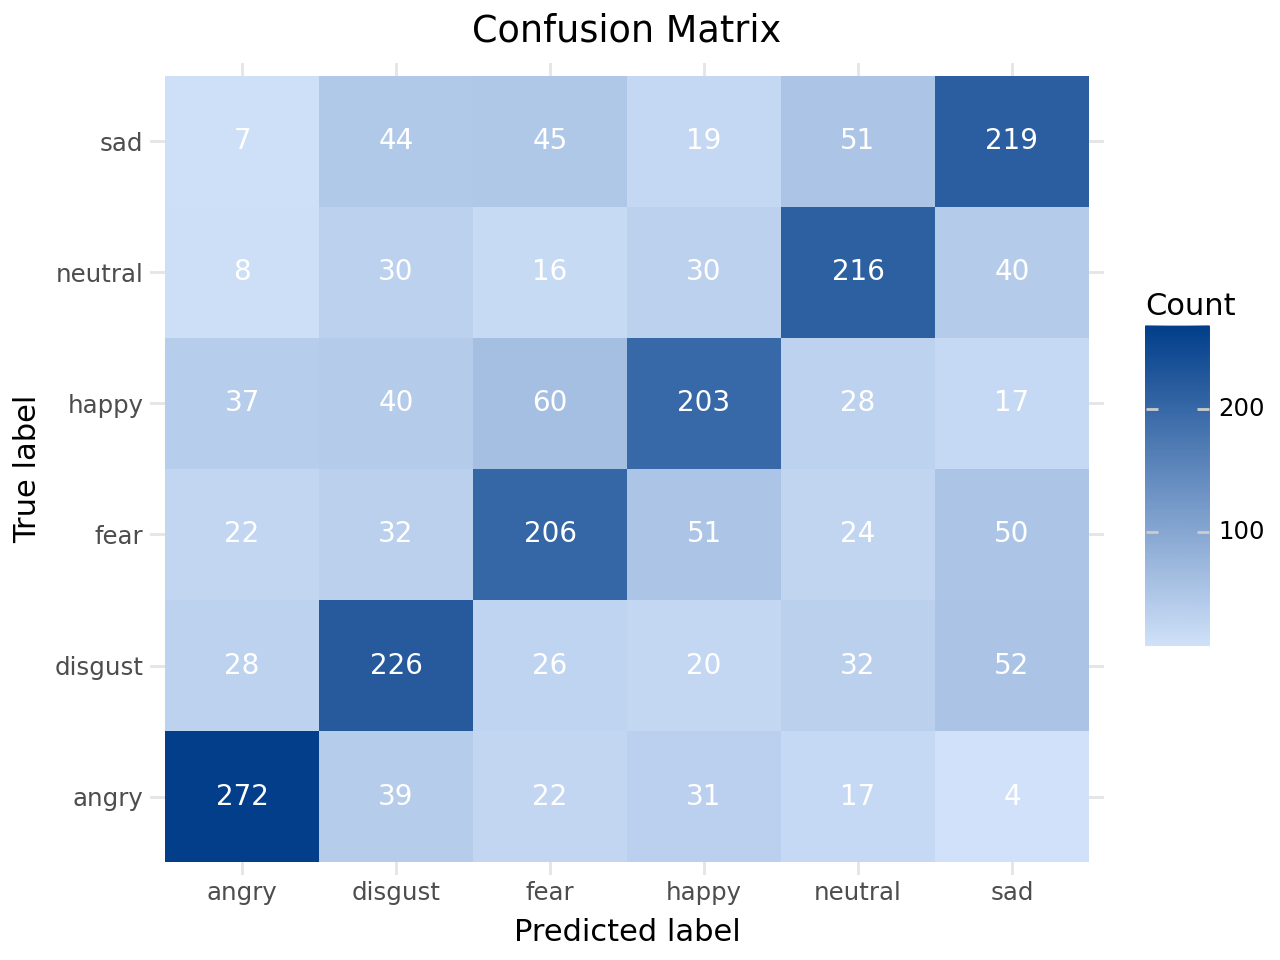

In [12]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from plotnine import *

# Convert numeric labels → emotion names
true_labels = [inverse_map[i] for i in y_test]
pred_labels = [inverse_map[i] for i in y_pred]

# Compute confusion matrix
labels = sorted(list(inverse_map.values()))
cm = confusion_matrix(true_labels, pred_labels, labels=labels)

# Convert to tidy DataFrame for plotnine
df_cm = (
    pd.DataFrame(cm, index=labels, columns=labels)
      .reset_index()
      .melt(id_vars='index')
)

df_cm.columns = ['True', 'Predicted', 'Count']

# Plot confusion matrix
(
    ggplot(df_cm, aes('Predicted', 'True', fill='Count'))
    + geom_tile()
    + geom_text(aes(label='Count'), color='white', size=10)
    + scale_fill_gradient(low='#d0e1f9', high='#023e8a')
    + theme_minimal()
    + labs(title='Confusion Matrix', x='Predicted label', y='True label')
)

### Unweighted Average Recall (UAR)

In [13]:
uar = recall_score(y_test, y_pred, average='macro')
print(f"Unweighted Average Recall (UAR): {uar:.4f}")

Unweighted Average Recall (UAR): 0.5936


### Detailed classification report

In [14]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred, target_names=le.classes_)
print(report)

              precision    recall  f1-score   support

       angry       0.73      0.71      0.72       385
     disgust       0.55      0.59      0.57       384
        fear       0.55      0.54      0.54       385
       happy       0.57      0.53      0.55       385
     neutral       0.59      0.64      0.61       340
         sad       0.57      0.57      0.57       385

    accuracy                           0.59      2264
   macro avg       0.59      0.59      0.59      2264
weighted avg       0.59      0.59      0.59      2264



## Save Model

In [15]:
import pickle

model_path = os.path.join(final_model_dir, "svm-ser-model.pkl")
with open(model_path, 'wb') as f:
    pickle.dump(svm_model, f)

## Save Scalar

In [16]:
scaler_path = os.path.join(final_model_dir, "scaler.pkl")
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)

## Label Encoder

In [17]:
encoder_path = os.path.join(final_model_dir, "label_encoder.pkl")
with open(encoder_path, 'wb') as f:
    pickle.dump(le, f)